/Users/mac/Documents/taker/.venv/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'
FF Criteria Overlap for Prune Ratio 0.01


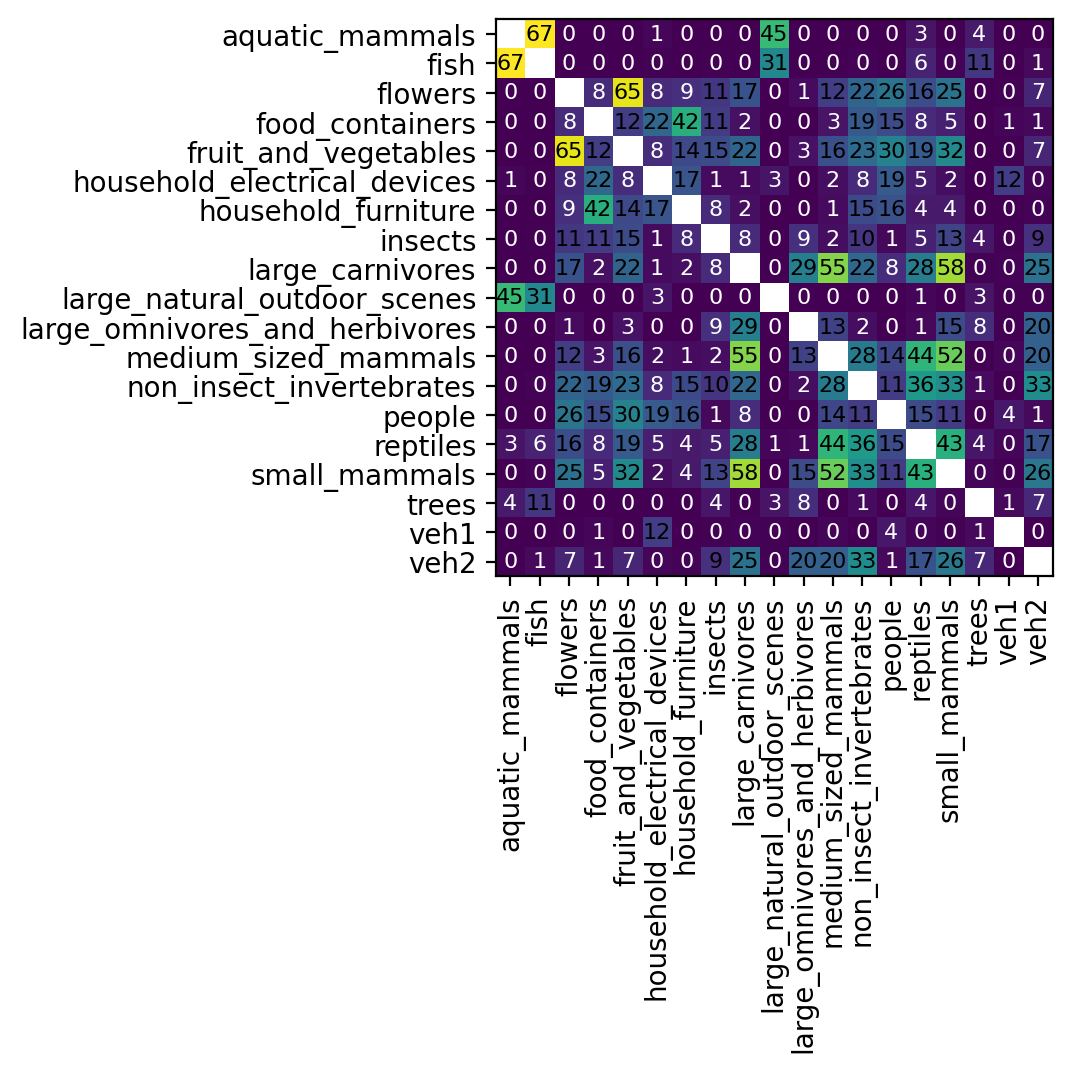

FF Criteria Overlap for Prune Ratio 0.01


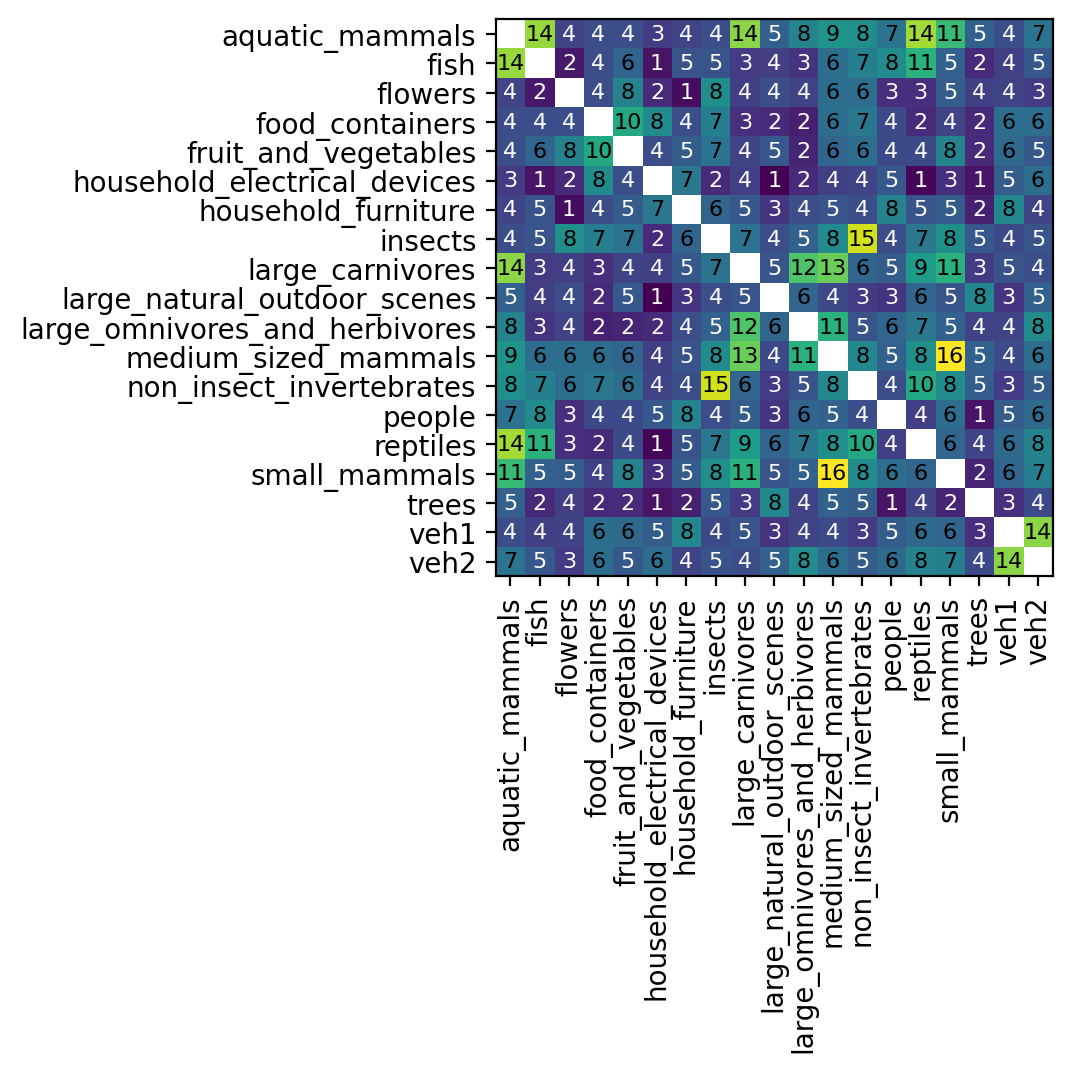

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from taker.activations import get_top_frac
import seaborn as sns

fallback_ratio = 0.01

def load_ff_criteria(directory, repo, focus_repo, suffix, fallback_suffix, device, ff_frac, layers="all"):
    try:
        assert layers == "all"
        repo1_tensors = torch.load(
            directory + repo + "-" + focus_repo + suffix,
            map_location=torch.device(device),
        )
        repo_ff_criteria = repo1_tensors["ff_criteria"]

    except:
        repo1_tensors = torch.load(
            directory + repo + "-" + focus_repo + fallback_suffix,
            map_location=torch.device(device),
        )
        repo_ff_scores = repo1_tensors["ff_scores"]
        if device == "cpu":
            repo_ff_scores = repo_ff_scores.to(torch.float32)
        if isinstance(layers, str) and layers == "all":
            layers = list(range(len(repo_ff_scores)))
        layers = np.array(layers)
        repo_ff_criteria, _threshold = get_top_frac(repo_ff_scores[layers], ff_frac)

    return repo_ff_criteria


def load_ff_criteria_auto(
        model_size: str,
        repo: str,
        prune_ratio: int,
        path: str = "./",
        focus_repo: str = "cifar20-split",
        device = "cpu",
        layers="all",
        ):
    directory = f"{path}{model_size}/"
    suffix = f"-{model_size}-{prune_ratio}-recent.pt"
    fallback_suffix = f"-{model_size}-{fallback_ratio}-recent.pt"

    return load_ff_criteria(directory, repo, focus_repo, suffix, fallback_suffix, device, prune_ratio, layers)



def compare_pruned_ff_criteria(
    cripple_repos: list[str],
    model_size: str,
    path: str = "/home/ubuntu/taker/tmp/saved_tensors/",
    focus_repo: str = "pile",
    prune_ratio: float = 0.01,
):
    # cripple_repos = ["physics", "bio", "code"]
    directory = f"{path}{model_size}/"
    suffix = f"-{model_size}-{prune_ratio}-recent.pt"
    fallback_suffix = f"-{model_size}-{fallback_ratio}-recent.pt"
    ratios = {}
    ratios["model_size"] = model_size

    device = "cuda" if torch.cuda.is_available() else "cpu"

    for repo1 in cripple_repos:
        # load ff_criteria from repo1
        repo1_ff_criteria = load_ff_criteria(directory, repo1, focus_repo, suffix, fallback_suffix, device, ff_frac=prune_ratio)
        ratios[repo1] = {}

        for repo2 in cripple_repos:
            if repo1 == repo2:
                ratios[repo1][repo2] = 0
            # load ff_criteria from repo2
            repo2_ff_criteria = load_ff_criteria(directory, repo2, focus_repo, suffix, fallback_suffix, device, ff_frac=prune_ratio)

            matches = torch.logical_and(repo1_ff_criteria, repo2_ff_criteria)
            ratio = torch.sum(matches) / torch.sum(repo1_ff_criteria
                                                   )
            ratios[repo1][repo2] = ratio

    return ratios


datasets = [
    f"cifar20-{dataset}"
    for dataset in [
        "aquatic_mammals",
        "fish",
        "flowers",
        "food_containers",
        "fruit_and_vegetables",
        "household_electrical_devices",
        "household_furniture",
        "insects",
        "large_carnivores",
        "large_natural_outdoor_scenes",
        "large_omnivores_and_herbivores",
        "medium_sized_mammals",
        "non_insect_invertebrates",
        "people",
        "reptiles",
        "small_mammals",
        "trees",
        "veh1",
        "veh2",
    ]
]

def plot_comparison(comparison, plot_yticks = True):
    grid = [
        [
            comparison[dataset_a][dataset_b].item() if dataset_a != dataset_b else np.nan
            for dataset_b in datasets
        ]
        for dataset_a in datasets
    ]
    grid = np.ma.masked_where(np.isnan(grid), grid)

    average = np.mean(grid)

    plt.figure(dpi=200)

    plt.imshow(grid)
    for i in range(len(datasets)):
        for j in range(len(datasets)):
            val = grid[i,j]
            try:
                int_val = int(val*100)
            except:
                int_val = val
            plt.text(
                j,
                i,
                f"{int_val}",#f"{grid[i, j]:.2f}",
                ha="center",
                va="center",
                color="black" if grid[i, j] > average else "white",
                fontsize=8,
            )
    plt.xticks(
        range(len(datasets)), [dataset.split("-")[1] for dataset in datasets], rotation=90
    )
    plt.yticks(range(len(datasets)), [dataset.split("-")[1] for dataset in datasets])

    if not plot_yticks:
        plt.gca().get_yaxis().set_visible(False)

    plt.subplots_adjust(bottom=0.3)

    print(f"FF Criteria Overlap for Prune Ratio {prune_ratio}")

    plt.show()


prune_ratio = 0.01

comparison = compare_pruned_ff_criteria(
    datasets,
    "init",#"Cifar100",
    path="./",
    focus_repo="cifar20-split",
    prune_ratio=prune_ratio,
)

plot_comparison(comparison)

comparison = compare_pruned_ff_criteria(
    datasets,
    "Cifar100",
    path="./",
    focus_repo="cifar20-split",
    prune_ratio=prune_ratio,
)

plot_comparison(comparison)

FF Criteria Overlap for Prune Ratio 0.1


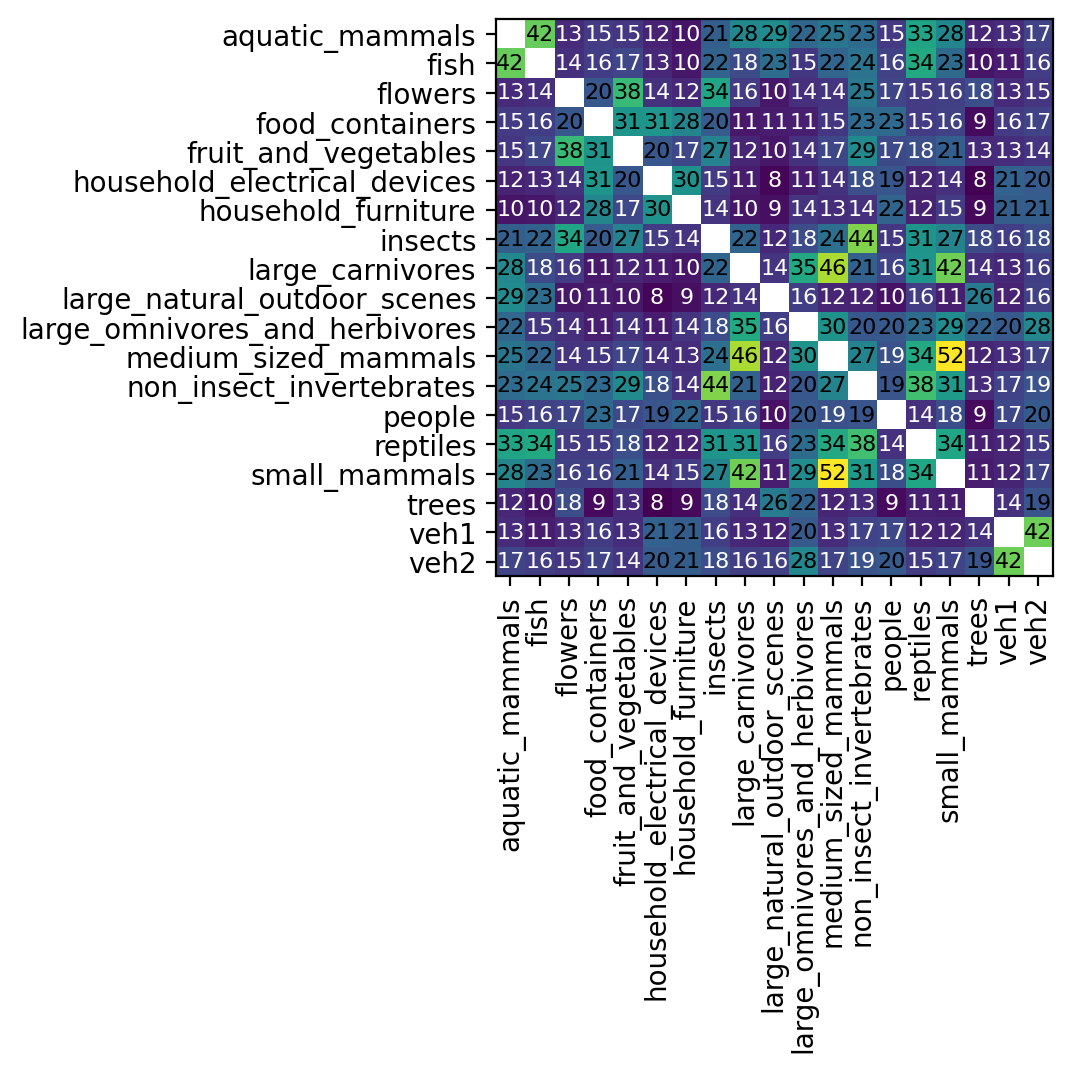

FF Criteria Overlap for Prune Ratio 0.1


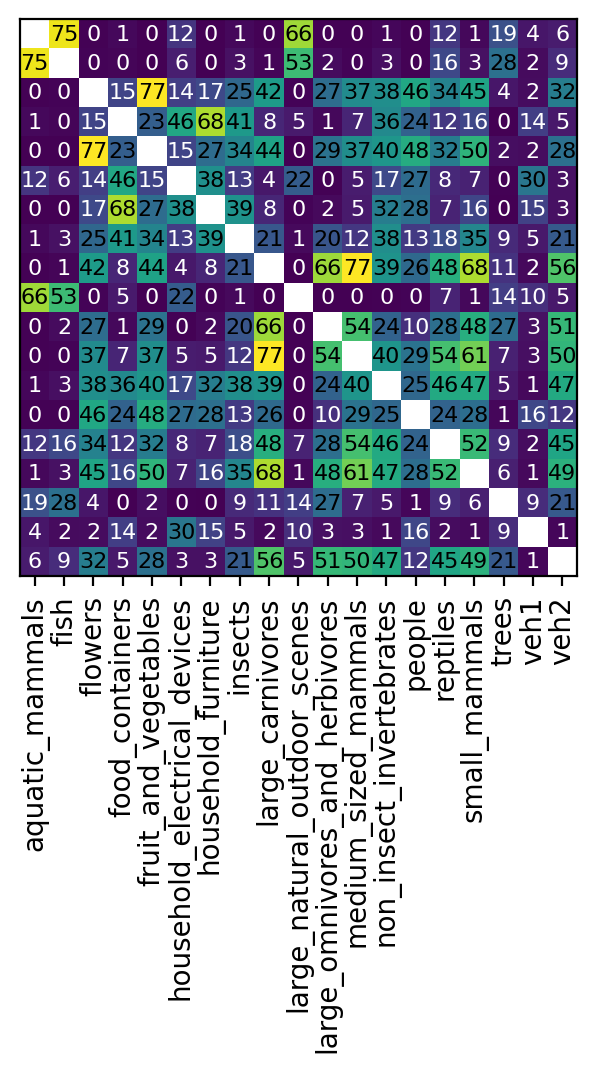

In [2]:
prune_ratio = 0.1


comparison = compare_pruned_ff_criteria(
    datasets,
    "Cifar100",
    path="./",
    focus_repo="cifar20-split",
    prune_ratio=prune_ratio,
)

plot_comparison(comparison)

comparison = compare_pruned_ff_criteria(
    datasets,
    "init",#"Cifar100",
    path="./",
    focus_repo="cifar20-split",
    prune_ratio=prune_ratio,
)

plot_comparison(comparison, False)

FF Criteria Overlap for Prune Ratio 0.2


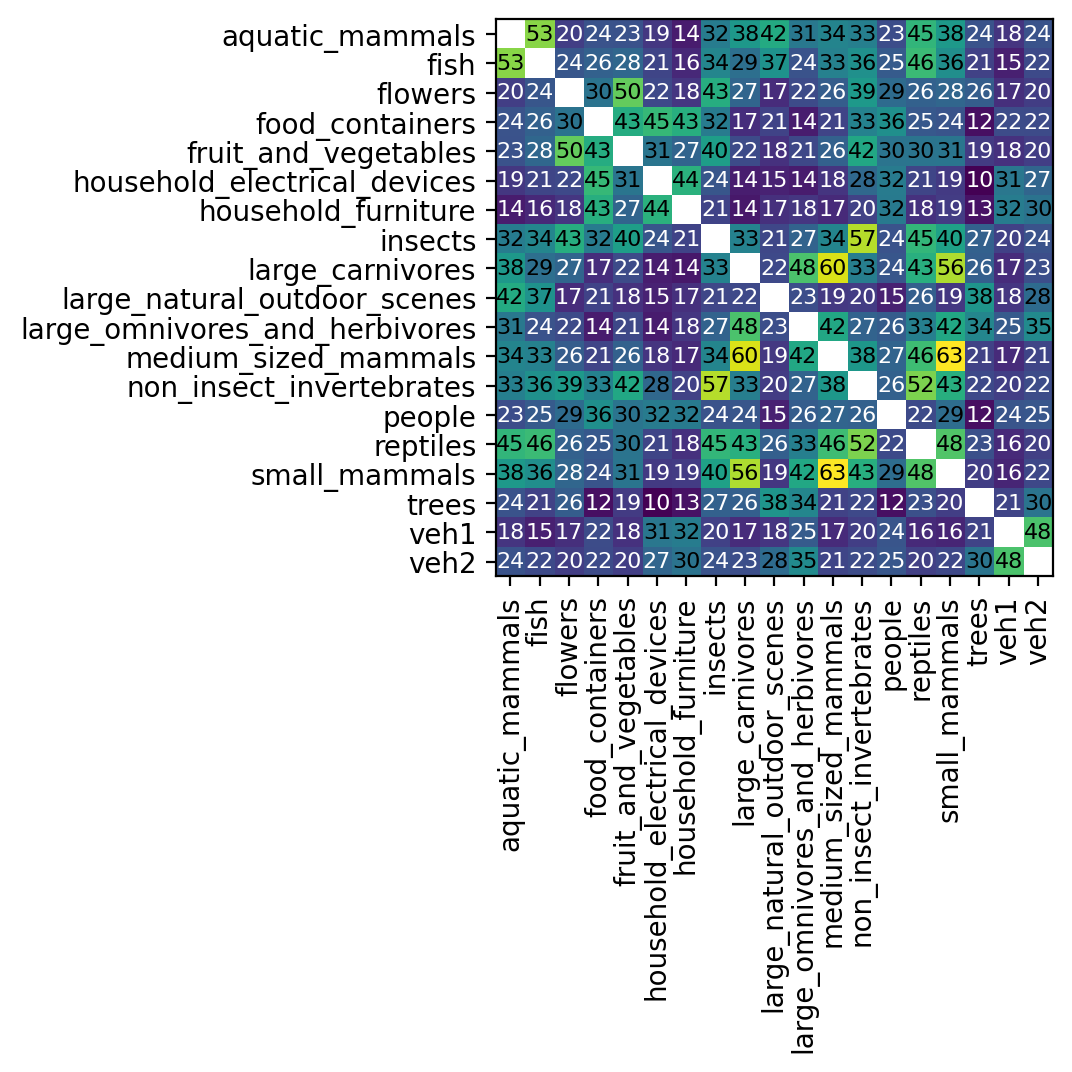

FF Criteria Overlap for Prune Ratio 0.2


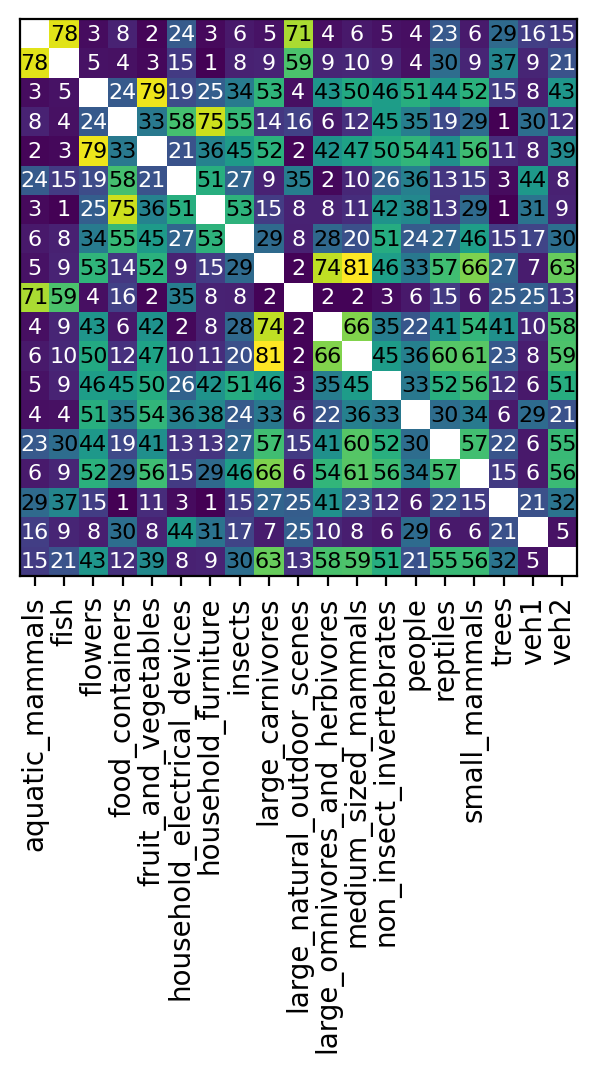

In [3]:
prune_ratio = 0.2


comparison = compare_pruned_ff_criteria(
    datasets,
    "Cifar100",
    path="./",
    focus_repo="cifar20-split",
    prune_ratio=prune_ratio,
)

plot_comparison(comparison)

comparison = compare_pruned_ff_criteria(
    datasets,
    "init",#"Cifar100",
    path="./",
    focus_repo="cifar20-split",
    prune_ratio=prune_ratio,
)

plot_comparison(comparison, False)

## Load Clusters

In [4]:
import numpy as np
from sklearn.preprocessing import normalize as sk_normalize
from k_means_constrained import KMeansConstrained
from taker import Model

def cluster_neurons(model: Model,
        layer: int,
        split_num: int=96,
        method="kmeans",
    ):
    # First, get variables for which components are used
    assert model.cfg.d_mlp % split_num == 0, \
        "split_num should evenly divide model's mlp width"
    split_size = model.cfg.d_mlp // split_num

    # Collect the neurons we are clustering
    weights = model.layers[layer]["mlp.W_in"].detach().cpu()
    normed_weights = sk_normalize(weights)

    # Perform the clustering
    if method == "kmeans":
        kmeans = KMeansConstrained(
            n_clusters=split_num, size_min=split_size, size_max=split_size, random_state=0
        ).fit(normed_weights, None)
        labels = [x for x in kmeans.labels_]
        return labels, kmeans

    if method == "random":
         labels = np.array(list(range(model.cfg.d_mlp))) % split_num

m_rand = Model("nickypro/vit-cifar100-random-init")
m_good = Model("Ahmed9275/Vit-Cifar100")

/Users/mac/Documents/taker/src/taker/model.py:143: UserWarning: Model nickypro/vit-cifar100-random-init not tested.
  warnings.warn( f"Model {model_repo} not tested." )
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


- Loaded nickypro/vit-cifar100-random-init
 - Registered 12 Attention Layers


/Users/mac/Documents/taker/src/taker/model.py:143: UserWarning: Model Ahmed9275/Vit-Cifar100 not tested.
  warnings.warn( f"Model {model_repo} not tested." )
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


- Loaded Ahmed9275/Vit-Cifar100
 - Registered 12 Attention Layers


In [5]:
def get_clustering(m):
    clusters = []

    for layer in range(m.cfg.n_layers):
        split_num: int=96
        cluster_i, _ = cluster_neurons(m, layer, split_num=split_num)
        print(cluster_i)
        cluster_i += np.ones_like(cluster_i) * split_num * layer
        clusters.append( cluster_i )

    clusters_list = np.array( clusters )
    clusters_list.shape
    return clusters_list

In [6]:
#good_clusters_list = get_clustering(m_good)

good_clusters = [
[80, 42, 71, 56, 10, 70, 12, 54, 81, 13, 65, 23, 83, 26, 12, 27, 44, 60, 31, 82, 70, 6, 89, 88, 3, 10, 13, 40, 79, 38, 50, 46, 1, 5, 19, 73, 22, 52, 70, 4, 61, 27, 40, 47, 27, 30, 15, 10, 71, 67, 93, 75, 76, 23, 36, 76, 52, 64, 2, 89, 91, 37, 35, 8, 53, 28, 18, 30, 3, 21, 24, 27, 37, 94, 94, 16, 91, 26, 37, 59, 84, 83, 15, 49, 5, 35, 57, 29, 2, 24, 8, 80, 67, 67, 9, 37, 91, 44, 80, 86, 54, 51, 34, 30, 51, 37, 33, 49, 38, 66, 53, 6, 46, 14, 85, 93, 37, 49, 75, 35, 71, 92, 81, 15, 60, 29, 91, 27, 19, 65, 44, 36, 33, 23, 26, 10, 18, 82, 78, 57, 45, 46, 85, 49, 58, 34, 68, 49, 20, 31, 59, 34, 19, 63, 68, 1, 49, 38, 56, 19, 68, 78, 20, 42, 25, 14, 78, 30, 58, 31, 47, 0, 58, 2, 79, 49, 57, 36, 32, 81, 34, 36, 18, 58, 65, 13, 21, 69, 47, 92, 68, 11, 91, 29, 29, 37, 88, 95, 13, 38, 12, 16, 75, 42, 20, 87, 18, 64, 73, 18, 65, 36, 48, 71, 0, 47, 12, 7, 51, 4, 15, 26, 38, 70, 25, 41, 43, 84, 29, 49, 17, 20, 33, 77, 9, 71, 39, 2, 14, 20, 60, 78, 38, 15, 48, 74, 49, 67, 79, 52, 71, 41, 66, 84, 11, 42, 46, 27, 29, 53, 71, 87, 51, 53, 12, 80, 94, 12, 91, 63, 8, 2, 17, 3, 71, 14, 22, 0, 63, 87, 0, 90, 90, 8, 34, 82, 73, 50, 93, 46, 40, 36, 44, 42, 3, 87, 83, 37, 91, 35, 8, 58, 27, 88, 79, 72, 70, 18, 14, 34, 65, 43, 37, 75, 90, 74, 29, 74, 45, 51, 14, 62, 43, 39, 63, 94, 43, 73, 54, 72, 48, 11, 20, 8, 17, 69, 43, 14, 28, 88, 10, 2, 53, 7, 78, 52, 34, 68, 31, 94, 4, 30, 56, 85, 16, 14, 94, 18, 78, 28, 56, 45, 0, 79, 31, 80, 40, 84, 40, 83, 32, 21, 18, 58, 62, 92, 12, 11, 36, 10, 73, 13, 9, 10, 36, 21, 94, 12, 65, 75, 40, 93, 70, 7, 19, 67, 22, 37, 7, 72, 41, 70, 3, 7, 23, 2, 79, 0, 88, 15, 44, 58, 30, 66, 34, 23, 25, 44, 39, 32, 22, 14, 84, 58, 24, 23, 58, 29, 29, 90, 27, 83, 59, 13, 70, 6, 65, 11, 10, 47, 87, 88, 6, 63, 59, 1, 44, 17, 42, 43, 61, 67, 77, 26, 76, 60, 52, 91, 76, 68, 30, 36, 65, 81, 88, 0, 53, 88, 93, 76, 11, 51, 75, 75, 46, 16, 90, 66, 62, 71, 13, 2, 49, 78, 58, 83, 43, 90, 4, 90, 13, 95, 70, 82, 68, 54, 41, 57, 9, 57, 78, 66, 33, 8, 16, 31, 38, 87, 84, 78, 15, 84, 25, 70, 41, 34, 40, 54, 21, 85, 81, 42, 25, 2, 75, 25, 15, 82, 34, 16, 21, 7, 61, 68, 30, 94, 72, 40, 60, 47, 27, 17, 7, 40, 63, 63, 6, 64, 68, 0, 69, 80, 26, 4, 36, 63, 75, 91, 4, 77, 5, 86, 85, 7, 41, 70, 17, 12, 45, 17, 73, 5, 57, 19, 67, 67, 24, 74, 57, 62, 63, 25, 5, 74, 55, 68, 46, 19, 45, 65, 52, 85, 81, 65, 78, 13, 81, 89, 24, 64, 69, 18, 92, 23, 80, 38, 30, 39, 22, 9, 75, 64, 37, 94, 16, 47, 68, 79, 50, 87, 72, 36, 41, 22, 65, 71, 7, 94, 86, 65, 86, 27, 14, 5, 19, 17, 64, 54, 60, 48, 91, 3, 80, 0, 66, 92, 59, 0, 54, 1, 78, 69, 21, 51, 1, 72, 5, 51, 62, 38, 75, 21, 11, 15, 17, 11, 11, 12, 70, 73, 61, 83, 69, 79, 28, 86, 89, 2, 41, 32, 71, 82, 71, 46, 73, 40, 87, 26, 90, 94, 62, 20, 54, 81, 47, 43, 16, 86, 75, 80, 84, 93, 43, 6, 63, 28, 48, 73, 21, 19, 74, 11, 93, 70, 56, 35, 33, 11, 49, 45, 59, 1, 86, 31, 55, 89, 7, 82, 79, 35, 44, 33, 11, 61, 41, 90, 78, 45, 91, 35, 37, 47, 66, 26, 69, 37, 23, 46, 16, 95, 1, 67, 91, 55, 81, 72, 40, 4, 0, 23, 56, 94, 69, 12, 14, 41, 56, 61, 28, 31, 27, 51, 29, 79, 48, 94, 46, 72, 33, 54, 39, 88, 4, 27, 59, 86, 3, 0, 28, 93, 89, 88, 53, 95, 43, 33, 0, 43, 34, 35, 59, 19, 37, 64, 84, 18, 41, 54, 54, 11, 47, 95, 20, 90, 19, 26, 3, 31, 66, 91, 8, 4, 27, 32, 28, 85, 31, 49, 24, 93, 39, 35, 24, 41, 71, 65, 26, 40, 41, 16, 7, 8, 92, 91, 55, 22, 26, 77, 54, 45, 59, 44, 77, 60, 50, 6, 60, 69, 43, 75, 36, 78, 25, 5, 71, 64, 23, 12, 49, 32, 81, 72, 64, 79, 66, 4, 87, 0, 73, 89, 4, 52, 31, 94, 25, 32, 47, 37, 6, 51, 82, 40, 89, 18, 4, 58, 16, 94, 41, 77, 1, 61, 83, 52, 18, 48, 38, 7, 1, 17, 82, 26, 57, 7, 48, 33, 50, 95, 28, 30, 10, 35, 41, 33, 89, 0, 33, 57, 56, 22, 20, 76, 92, 8, 94, 28, 43, 69, 17, 70, 65, 55, 13, 55, 53, 31, 73, 27, 44, 93, 4, 68, 9, 47, 66, 48, 52, 22, 5, 40, 85, 85, 26, 17, 12, 20, 47, 77, 41, 5, 31, 20, 5, 59, 46, 13, 39, 74, 38, 53, 84, 42, 39, 87, 42, 90, 51, 85, 62, 27, 1, 9, 35, 7, 77, 30, 59, 0, 63, 12, 70, 55, 26, 52, 80, 46, 58, 37, 82, 47, 11, 4, 55, 65, 86, 6, 51, 4, 57, 84, 40, 90, 70, 92, 15, 68, 11, 17, 25, 77, 18, 9, 31, 74, 15, 55, 65, 34, 4, 54, 10, 5, 13, 8, 34, 14, 77, 88, 17, 79, 76, 87, 95, 48, 58, 88, 49, 2, 42, 2, 24, 86, 73, 26, 72, 41, 4, 62, 29, 68, 36, 33, 61, 8, 82, 37, 77, 21, 70, 81, 4, 82, 61, 91, 19, 93, 50, 36, 3, 64, 73, 64, 45, 60, 74, 25, 24, 64, 89, 40, 36, 89, 33, 35, 39, 40, 47, 9, 66, 56, 28, 68, 54, 19, 71, 42, 85, 80, 27, 55, 27, 22, 71, 89, 41, 59, 46, 60, 34, 79, 63, 41, 74, 54, 79, 73, 3, 63, 49, 32, 74, 92, 51, 3, 69, 65, 78, 58, 33, 61, 6, 5, 30, 74, 47, 40, 52, 32, 93, 14, 41, 50, 78, 90, 55, 39, 87, 36, 3, 1, 9, 2, 20, 30, 47, 25, 17, 11, 26, 78, 19, 77, 57, 38, 83, 56, 68, 6, 33, 24, 83, 18, 89, 94, 72, 13, 54, 71, 51, 44, 38, 53, 55, 41, 86, 71, 11, 50, 48, 34, 70, 36, 52, 42, 50, 57, 14, 16, 90, 59, 71, 95, 67, 34, 33, 3, 26, 66, 55, 66, 72, 25, 14, 92, 80, 29, 51, 48, 18, 51, 77, 0, 59, 89, 21, 39, 79, 35, 35, 80, 88, 89, 26, 30, 83, 68, 50, 58, 80, 76, 72, 23, 15, 36, 90, 75, 3, 84, 22, 93, 94, 20, 7, 25, 5, 69, 0, 90, 78, 23, 10, 2, 17, 68, 1, 57, 40, 45, 64, 40, 75, 40, 6, 38, 80, 59, 57, 77, 87, 66, 23, 77, 69, 84, 62, 42, 46, 62, 60, 9, 39, 70, 86, 38, 55, 24, 13, 72, 76, 82, 5, 56, 95, 92, 94, 16, 49, 20, 1, 72, 56, 61, 52, 17, 17, 42, 43, 6, 50, 34, 58, 73, 22, 39, 56, 41, 51, 3, 44, 76, 44, 6, 35, 23, 41, 7, 21, 30, 42, 29, 56, 78, 73, 24, 61, 3, 84, 33, 56, 8, 18, 72, 32, 85, 11, 75, 40, 90, 79, 89, 42, 15, 26, 65, 93, 60, 9, 81, 68, 67, 81, 56, 21, 54, 80, 62, 11, 51, 34, 75, 21, 10, 54, 6, 36, 58, 8, 35, 58, 65, 67, 95, 12, 2, 5, 1, 79, 86, 79, 20, 63, 74, 61, 45, 11, 75, 61, 10, 30, 43, 5, 61, 22, 91, 85, 24, 31, 85, 32, 14, 41, 85, 28, 11, 9, 61, 30, 47, 34, 35, 84, 50, 1, 53, 14, 13, 33, 95, 0, 73, 29, 58, 70, 22, 83, 78, 13, 66, 89, 8, 78, 28, 79, 59, 13, 50, 47, 83, 43, 81, 48, 21, 18, 51, 59, 80, 73, 24, 79, 46, 45, 92, 31, 6, 95, 14, 53, 69, 22, 52, 78, 12, 56, 41, 3, 1, 90, 60, 60, 19, 66, 47, 57, 29, 53, 13, 69, 49, 5, 69, 22, 70, 63, 1, 88, 91, 17, 51, 2, 63, 54, 19, 60, 45, 76, 45, 30, 44, 63, 36, 19, 53, 77, 2, 29, 35, 29, 39, 92, 77, 24, 75, 61, 15, 70, 3, 64, 76, 29, 51, 9, 15, 9, 68, 47, 28, 39, 57, 57, 82, 48, 39, 95, 4, 21, 31, 51, 74, 51, 23, 11, 20, 3, 27, 58, 60, 23, 29, 48, 45, 70, 24, 61, 94, 92, 5, 58, 71, 12, 61, 87, 47, 28, 7, 37, 94, 86, 20, 84, 44, 67, 38, 37, 85, 1, 42, 2, 29, 64, 42, 55, 83, 18, 78, 32, 62, 53, 66, 54, 45, 47, 49, 6, 41, 15, 53, 52, 57, 86, 25, 55, 47, 76, 16, 72, 19, 72, 61, 50, 36, 33, 73, 0, 1, 76, 54, 45, 76, 32, 63, 10, 61, 38, 47, 33, 45, 94, 89, 65, 17, 88, 38, 95, 21, 16, 95, 64, 76, 12, 50, 13, 60, 26, 93, 39, 81, 44, 52, 24, 62, 48, 77, 84, 69, 27, 49, 23, 44, 69, 87, 55, 42, 57, 39, 22, 76, 55, 46, 1, 72, 28, 48, 92, 23, 8, 11, 81, 42, 16, 79, 87, 1, 18, 66, 10, 48, 68, 64, 1, 9, 71, 32, 81, 77, 14, 67, 73, 7, 85, 21, 90, 90, 12, 46, 4, 37, 9, 22, 61, 23, 92, 84, 92, 18, 14, 54, 25, 3, 48, 89, 45, 39, 76, 53, 32, 63, 20, 70, 9, 58, 42, 55, 21, 24, 56, 90, 63, 41, 34, 43, 75, 57, 55, 53, 21, 59, 32, 17, 48, 4, 15, 19, 71, 2, 21, 62, 60, 68, 60, 17, 27, 93, 65, 68, 95, 50, 52, 65, 22, 37, 93, 69, 24, 95, 72, 63, 58, 46, 46, 14, 37, 53, 67, 12, 68, 60, 67, 3, 0, 17, 8, 13, 72, 28, 61, 88, 58, 65, 94, 80, 59, 25, 62, 10, 92, 29, 73, 43, 24, 18, 25, 34, 7, 72, 30, 88, 88, 13, 13, 62, 22, 50, 27, 39, 20, 92, 95, 66, 31, 55, 31, 13, 94, 87, 31, 6, 46, 9, 42, 56, 61, 16, 68, 95, 24, 5, 44, 50, 6, 68, 21, 66, 91, 25, 79, 18, 75, 10, 85, 5, 21, 57, 86, 3, 86, 18, 87, 44, 52, 68, 62, 67, 66, 93, 2, 81, 94, 74, 10, 2, 9, 11, 30, 88, 27, 35, 72, 16, 86, 35, 58, 29, 92, 32, 59, 48, 28, 76, 6, 12, 14, 72, 92, 86, 5, 46, 33, 27, 60, 77, 94, 25, 93, 90, 78, 23, 7, 83, 69, 89, 58, 92, 84, 7, 29, 81, 26, 48, 10, 59, 85, 1, 74, 85, 91, 75, 11, 80, 18, 9, 62, 73, 88, 64, 15, 32, 10, 8, 21, 30, 14, 36, 38, 30, 19, 19, 39, 65, 44, 79, 17, 29, 49, 67, 60, 92, 8, 49, 3, 67, 15, 52, 77, 8, 76, 37, 14, 30, 10, 22, 48, 56, 85, 81, 76, 6, 46, 35, 2, 32, 15, 15, 12, 78, 63, 8, 81, 11, 54, 18, 90, 26, 73, 29, 86, 45, 95, 6, 62, 3, 92, 78, 81, 38, 0, 86, 43, 35, 64, 34, 53, 66, 84, 7, 34, 52, 19, 4, 17, 63, 32, 89, 8, 86, 80, 88, 44, 12, 58, 38, 62, 22, 95, 90, 67, 75, 12, 26, 46, 42, 54, 54, 8, 11, 50, 74, 75, 36, 50, 28, 12, 72, 89, 1, 55, 34, 24, 82, 73, 80, 35, 51, 93, 17, 76, 31, 22, 87, 65, 93, 81, 38, 57, 72, 76, 33, 47, 79, 89, 34, 66, 36, 23, 83, 85, 65, 35, 82, 72, 88, 9, 47, 69, 84, 43, 82, 6, 62, 18, 18, 40, 10, 45, 85, 23, 80, 43, 90, 20, 83, 67, 40, 27, 28, 13, 49, 50, 4, 44, 61, 10, 50, 91, 77, 90, 37, 8, 53, 16, 64, 67, 28, 86, 95, 54, 34, 52, 94, 35, 32, 70, 91, 89, 64, 33, 83, 37, 61, 38, 58, 80, 66, 25, 14, 61, 53, 53, 90, 7, 32, 50, 63, 87, 81, 53, 43, 70, 85, 29, 82, 83, 45, 8, 4, 46, 53, 12, 20, 48, 57, 30, 21, 74, 15, 62, 77, 82, 37, 81, 46, 31, 77, 53, 30, 6, 60, 1, 33, 74, 28, 64, 83, 12, 45, 15, 4, 70, 64, 73, 69, 64, 65, 13, 10, 24, 12, 63, 38, 93, 92, 40, 72, 50, 62, 51, 91, 31, 22, 73, 77, 82, 76, 6, 36, 23, 44, 25, 21, 79, 46, 6, 40, 21, 26, 43, 81, 24, 88, 3, 63, 95, 81, 16, 88, 86, 6, 63, 76, 5, 29, 70, 32, 75, 76, 48, 61, 60, 20, 85, 38, 49, 55, 72, 48, 61, 71, 11, 94, 55, 65, 54, 22, 9, 17, 85, 12, 69, 91, 82, 8, 25, 28, 67, 91, 20, 72, 17, 48, 0, 8, 43, 75, 38, 94, 39, 74, 28, 15, 24, 37, 19, 47, 81, 80, 7, 4, 7, 19, 49, 8, 37, 11, 34, 57, 7, 31, 5, 24, 17, 44, 2, 84, 70, 92, 62, 51, 4, 62, 53, 59, 36, 32, 3, 71, 14, 63, 2, 87, 68, 29, 1, 40, 55, 67, 75, 12, 46, 0, 35, 18, 46, 9, 90, 44, 95, 9, 9, 64, 20, 9, 65, 30, 24, 74, 15, 91, 69, 79, 17, 24, 23, 49, 19, 75, 61, 85, 38, 0, 4, 32, 3, 21, 67, 10, 51, 84, 50, 24, 14, 3, 25, 45, 95, 52, 75, 56, 22, 82, 20, 3, 35, 89, 28, 15, 55, 10, 53, 35, 19, 92, 0, 45, 14, 39, 94, 33, 93, 49, 67, 70, 27, 2, 58, 74, 11, 57, 1, 80, 13, 76, 13, 41, 88, 42, 79, 78, 90, 14, 23, 45, 55, 40, 12, 37, 19, 21, 54, 80, 7, 31, 2, 82, 51, 29, 50, 8, 61, 30, 5, 15, 95, 66, 62, 85, 79, 87, 71, 44, 78, 86, 56, 84, 32, 3, 34, 5, 67, 35, 59, 46, 95, 42, 56, 44, 58, 74, 31, 62, 53, 87, 10, 44, 78, 50, 14, 51, 42, 42, 48, 9, 84, 87, 94, 61, 38, 81, 38, 93, 5, 80, 90, 6, 26, 49, 20, 55, 15, 20, 73, 19, 66, 71, 52, 77, 25, 89, 54, 41, 59, 56, 34, 50, 57, 30, 58, 93, 36, 62, 27, 17, 43, 26, 84, 65, 25, 47, 28, 46, 56, 10, 23, 84, 70, 24, 7, 69, 25, 33, 50, 49, 81, 64, 66, 77, 84, 74, 91, 86, 52, 66, 71, 63, 22, 32, 45, 83, 5, 90, 5, 7, 32, 45, 50, 1, 23, 15, 83, 92, 33, 56, 67, 9, 25, 45, 87, 88, 76, 94, 91, 88, 2, 25, 73, 82, 16, 59, 2, 8, 33, 8, 23, 89, 19, 16, 65, 63, 6, 40, 43, 62, 22, 21, 74, 24, 30, 31, 66, 4, 31, 52, 48, 66, 67, 93, 55, 64, 69, 83, 95, 41, 36, 32, 59, 20, 7, 6, 74, 86, 93, 16, 1, 66, 84, 45, 52, 84, 27, 79, 93, 89, 81, 53, 46, 32, 39, 14, 89, 25, 71, 31, 74, 73, 64, 68, 71, 47, 25, 53, 28, 55, 6, 86, 64, 33, 54, 21, 79, 69, 25, 42, 60, 8, 69, 78, 26, 5, 18, 43, 30, 89, 76, 92, 62, 82, 31, 19, 60, 59, 88, 9, 4, 60, 44, 43, 78, 77, 79, 35, 14, 75, 7, 89, 29, 82, 60, 67, 88, 0, 69, 60, 52, 52, 91, 7, 39, 39, 84, 91, 13, 12, 1, 3, 86, 40, 77, 74, 82, 23, 77, 40, 39, 76, 74, 59, 27, 62, 59, 90, 28, 32, 81, 23, 79, 4, 5, 68, 15, 88, 83, 39, 86, 18, 34, 22, 34, 73, 71, 59, 74, 77, 27, 29, 55, 87, 13, 48, 0, 16, 9, 67, 16, 73, 92, 49, 49, 78, 36, 35, 91, 0, 76, 80, 69, 82, 22, 0, 10, 28, 16, 27, 91, 26, 72, 87, 38, 19, 85, 41, 77, 93, 26, 48, 36, 2, 82, 16, 80, 91, 43, 28, 88, 68, 56, 45, 93, 55, 83, 65, 75, 21, 52, 47, 88, 73, 38, 20, 85, 44, 92, 28, 41, 15, 37, 74, 37, 95, 29, 54, 52, 27, 44, 51, 26, 0, 16, 60, 3, 95, 13, 83, 18, 18, 87, 2, 85, 2, 42, 20, 46, 50, 60, 56, 22, 66, 31, 84, 57, 60, 13, 4, 42, 80, 64, 58, 10, 30, 83, 89, 0, 34, 35, 16, 17, 15, 64, 95, 16, 70, 10, 33, 69, 83, 53, 30, 40, 51, 80, 52, 48, 43, 83, 49, 59, 19, 38, 82, 10, 42, 68, 59, 11, 39, 6, 36, 87, 37, 82, 87, 87, 23, 24, 39, 83, 11, 86, 92, 39, 76, 44, 56, 52, 69, 57, 22, 71, 83, 75, 50, 87, 72, 56, 39, 57, 54, 95, 26, 71, 5, 33, 43, 16, 86, 1, 64, 28, 74, 49, 82, 93, 1, 56, 83, 63, 93, 47, 42, 33, 16, 51, 31, 2, 57, 56, 27, 36, 32, 57, 62, 78, 80, 20, 45, 13, 63, 43, 26, 9, 67, 23, 20, 57, 85],
[49, 36, 67, 28, 95, 37, 47, 52, 35, 44, 37, 24, 21, 41, 47, 35, 29, 50, 2, 52, 42, 26, 37, 95, 46, 79, 8, 89, 26, 8, 79, 21, 77, 85, 81, 35, 19, 12, 33, 56, 20, 57, 33, 60, 52, 32, 59, 79, 15, 49, 52, 93, 27, 72, 42, 61, 16, 73, 46, 92, 33, 59, 65, 73, 85, 69, 46, 79, 2, 1, 22, 23, 9, 59, 34, 28, 48, 55, 55, 93, 84, 32, 88, 28, 87, 91, 32, 91, 66, 16, 38, 57, 92, 19, 75, 18, 89, 7, 69, 20, 53, 5, 71, 72, 76, 80, 18, 83, 19, 1, 93, 29, 73, 9, 36, 95, 20, 35, 17, 38, 65, 72, 15, 90, 89, 37, 95, 19, 7, 64, 53, 48, 63, 34, 28, 76, 12, 88, 11, 57, 87, 25, 13, 2, 16, 3, 27, 13, 52, 42, 61, 41, 30, 74, 30, 29, 52, 60, 9, 44, 45, 32, 24, 7, 23, 30, 22, 64, 58, 81, 42, 71, 84, 5, 12, 5, 19, 20, 93, 38, 32, 67, 66, 57, 23, 78, 70, 40, 51, 79, 30, 42, 50, 24, 92, 3, 30, 94, 76, 63, 95, 36, 70, 90, 17, 67, 17, 90, 73, 17, 11, 14, 76, 75, 43, 44, 34, 23, 42, 64, 80, 35, 79, 95, 36, 60, 1, 10, 6, 16, 86, 47, 2, 13, 56, 84, 25, 25, 20, 28, 9, 34, 18, 46, 34, 40, 66, 84, 57, 89, 30, 47, 32, 51, 12, 61, 24, 32, 28, 21, 19, 18, 0, 65, 82, 39, 5, 3, 56, 45, 66, 86, 80, 51, 65, 28, 45, 78, 9, 38, 71, 44, 17, 12, 23, 55, 11, 84, 0, 12, 67, 36, 79, 21, 82, 94, 23, 25, 40, 47, 57, 0, 53, 44, 62, 39, 29, 15, 3, 88, 48, 89, 85, 69, 6, 84, 34, 58, 75, 51, 70, 56, 13, 13, 79, 26, 25, 55, 45, 69, 14, 27, 89, 21, 22, 83, 40, 3, 55, 11, 17, 2, 0, 71, 36, 58, 77, 11, 60, 51, 78, 84, 14, 4, 0, 60, 62, 50, 10, 24, 44, 26, 58, 50, 22, 70, 86, 41, 10, 28, 39, 50, 12, 15, 66, 68, 28, 55, 50, 19, 68, 10, 95, 16, 20, 59, 28, 83, 47, 1, 0, 51, 85, 29, 21, 28, 56, 30, 27, 22, 10, 36, 4, 76, 86, 17, 43, 95, 59, 30, 44, 31, 86, 35, 32, 5, 75, 90, 93, 5, 91, 80, 8, 65, 91, 54, 44, 55, 85, 81, 45, 55, 8, 2, 41, 86, 63, 76, 45, 44, 49, 68, 93, 0, 78, 64, 44, 45, 90, 95, 53, 21, 79, 27, 19, 61, 51, 2, 72, 14, 61, 67, 87, 52, 78, 84, 31, 18, 16, 35, 29, 64, 69, 52, 21, 23, 93, 24, 19, 81, 43, 34, 32, 85, 80, 10, 60, 19, 26, 61, 42, 13, 82, 10, 59, 74, 30, 20, 10, 55, 35, 79, 80, 48, 19, 95, 48, 80, 26, 88, 91, 79, 45, 83, 71, 77, 14, 26, 82, 89, 48, 16, 11, 2, 37, 68, 49, 93, 45, 3, 26, 93, 10, 59, 40, 62, 42, 21, 10, 31, 43, 47, 23, 95, 13, 42, 39, 37, 47, 72, 87, 63, 71, 8, 14, 59, 26, 37, 73, 5, 14, 41, 19, 11, 20, 60, 23, 34, 87, 24, 60, 60, 5, 36, 31, 31, 8, 5, 3, 65, 93, 70, 77, 87, 69, 34, 91, 19, 82, 13, 88, 59, 63, 81, 51, 83, 60, 61, 5, 32, 76, 86, 72, 80, 78, 41, 87, 74, 87, 50, 32, 73, 23, 59, 43, 77, 32, 27, 25, 6, 51, 84, 43, 36, 10, 86, 33, 25, 65, 3, 6, 31, 27, 29, 85, 71, 0, 93, 1, 58, 52, 24, 68, 14, 27, 65, 80, 39, 47, 39, 81, 57, 35, 76, 20, 66, 83, 91, 20, 1, 83, 72, 49, 28, 76, 19, 21, 81, 61, 8, 71, 61, 1, 43, 7, 77, 69, 42, 56, 34, 75, 19, 40, 0, 49, 85, 77, 32, 42, 42, 82, 35, 17, 60, 67, 31, 11, 40, 30, 89, 83, 84, 2, 33, 40, 95, 17, 16, 70, 2, 53, 66, 48, 82, 54, 74, 88, 63, 37, 14, 34, 34, 26, 86, 66, 64, 83, 23, 40, 55, 6, 92, 72, 83, 68, 31, 81, 59, 92, 55, 85, 81, 82, 22, 72, 53, 63, 31, 65, 24, 64, 44, 66, 81, 40, 36, 37, 37, 72, 85, 66, 89, 74, 4, 12, 59, 66, 70, 52, 29, 64, 75, 37, 67, 80, 31, 39, 74, 41, 32, 77, 54, 71, 18, 78, 57, 17, 86, 75, 15, 83, 69, 60, 62, 71, 31, 15, 51, 75, 10, 86, 56, 81, 92, 14, 57, 95, 77, 67, 46, 8, 17, 61, 63, 88, 65, 19, 39, 19, 44, 22, 18, 12, 64, 12, 31, 61, 33, 49, 58, 32, 52, 53, 18, 51, 45, 73, 74, 38, 48, 41, 76, 76, 8, 8, 18, 2, 4, 89, 13, 45, 21, 1, 15, 89, 82, 12, 95, 76, 47, 17, 6, 70, 47, 36, 22, 74, 43, 46, 8, 48, 95, 2, 48, 67, 54, 15, 60, 62, 27, 78, 82, 77, 46, 37, 76, 61, 51, 88, 26, 82, 72, 58, 70, 60, 53, 9, 50, 61, 81, 58, 68, 40, 14, 14, 42, 90, 34, 20, 87, 29, 44, 30, 27, 8, 46, 10, 52, 23, 78, 1, 51, 52, 87, 87, 17, 47, 17, 72, 38, 7, 57, 23, 13, 89, 93, 54, 32, 37, 45, 7, 75, 73, 92, 79, 63, 66, 59, 25, 62, 11, 13, 77, 73, 77, 57, 36, 7, 89, 34, 12, 80, 85, 9, 88, 10, 58, 84, 10, 16, 58, 92, 85, 64, 33, 24, 6, 67, 22, 11, 90, 29, 6, 52, 25, 63, 30, 43, 21, 19, 62, 34, 83, 50, 77, 72, 71, 73, 23, 18, 2, 60, 69, 1, 94, 9, 8, 56, 50, 86, 12, 94, 9, 7, 62, 80, 50, 76, 77, 39, 23, 48, 65, 36, 18, 54, 4, 17, 24, 94, 43, 17, 53, 11, 37, 80, 54, 5, 94, 28, 90, 80, 2, 0, 67, 76, 46, 26, 57, 56, 1, 38, 48, 76, 94, 31, 8, 89, 4, 64, 67, 10, 20, 59, 84, 93, 69, 54, 94, 41, 10, 0, 7, 40, 0, 62, 12, 21, 14, 95, 29, 12, 62, 21, 80, 28, 76, 27, 21, 38, 87, 52, 1, 78, 78, 32, 67, 3, 42, 19, 77, 6, 64, 36, 39, 37, 61, 82, 88, 57, 70, 21, 70, 64, 57, 1, 7, 17, 40, 88, 58, 62, 40, 16, 85, 47, 18, 73, 43, 46, 34, 50, 71, 69, 47, 49, 85, 23, 13, 13, 87, 18, 37, 60, 5, 50, 66, 45, 0, 49, 48, 3, 51, 72, 46, 20, 76, 21, 38, 94, 1, 40, 45, 62, 65, 52, 93, 30, 46, 5, 36, 65, 0, 85, 12, 89, 92, 21, 75, 59, 67, 49, 39, 1, 74, 73, 49, 0, 63, 19, 33, 27, 27, 29, 6, 94, 66, 18, 89, 56, 21, 24, 64, 5, 38, 58, 90, 67, 84, 77, 70, 88, 42, 31, 15, 43, 47, 29, 66, 45, 46, 15, 61, 3, 0, 35, 9, 55, 37, 32, 2, 78, 94, 76, 73, 60, 32, 23, 8, 27, 34, 56, 83, 79, 7, 16, 87, 26, 9, 30, 46, 39, 43, 41, 33, 20, 31, 84, 45, 53, 83, 40, 55, 69, 71, 74, 56, 7, 35, 78, 12, 36, 11, 76, 87, 14, 76, 25, 84, 39, 77, 33, 21, 93, 64, 44, 82, 23, 57, 7, 75, 90, 63, 52, 50, 11, 31, 62, 14, 59, 39, 18, 45, 2, 79, 54, 62, 45, 71, 29, 54, 73, 61, 91, 41, 93, 47, 18, 23, 8, 64, 48, 70, 41, 14, 47, 15, 63, 45, 52, 42, 84, 66, 45, 48, 35, 74, 71, 70, 48, 46, 72, 81, 69, 36, 23, 32, 49, 73, 6, 94, 15, 64, 62, 35, 84, 77, 76, 51, 15, 91, 20, 12, 38, 9, 31, 62, 89, 10, 71, 22, 58, 46, 4, 86, 81, 78, 92, 64, 3, 59, 70, 16, 52, 6, 28, 68, 78, 91, 57, 55, 87, 28, 91, 67, 78, 50, 34, 87, 3, 29, 83, 23, 46, 41, 22, 45, 7, 95, 44, 21, 46, 70, 40, 22, 86, 7, 90, 24, 37, 4, 88, 52, 53, 15, 54, 54, 2, 46, 23, 91, 15, 45, 65, 69, 29, 95, 14, 34, 4, 85, 73, 54, 4, 80, 31, 87, 17, 65, 30, 66, 14, 60, 61, 82, 43, 41, 58, 85, 67, 20, 19, 39, 10, 19, 56, 68, 87, 87, 79, 67, 17, 95, 65, 39, 84, 13, 80, 19, 87, 68, 15, 94, 26, 64, 9, 13, 4, 40, 88, 43, 50, 32, 65, 91, 87, 43, 14, 10, 71, 5, 80, 8, 18, 72, 49, 16, 84, 22, 86, 4, 81, 48, 66, 87, 48, 7, 14, 92, 17, 50, 11, 0, 9, 10, 67, 2, 4, 89, 43, 60, 82, 24, 38, 48, 8, 24, 48, 40, 2, 39, 69, 25, 66, 56, 54, 92, 74, 57, 46, 68, 31, 22, 83, 18, 50, 78, 80, 73, 95, 32, 63, 0, 76, 64, 73, 9, 58, 92, 31, 88, 81, 20, 27, 13, 16, 65, 70, 7, 16, 9, 31, 81, 46, 17, 73, 68, 49, 56, 9, 91, 78, 74, 17, 15, 3, 31, 80, 13, 80, 20, 45, 6, 90, 20, 43, 18, 63, 14, 92, 27, 73, 60, 37, 56, 1, 18, 57, 9, 71, 20, 54, 74, 3, 2, 16, 72, 12, 95, 3, 86, 5, 76, 75, 20, 49, 86, 68, 11, 10, 68, 65, 2, 69, 5, 67, 28, 94, 51, 85, 44, 80, 72, 7, 77, 38, 68, 81, 36, 37, 35, 2, 58, 11, 95, 91, 84, 75, 28, 80, 25, 33, 83, 39, 69, 13, 12, 65, 6, 55, 56, 3, 24, 15, 19, 88, 52, 61, 91, 94, 17, 77, 50, 11, 47, 75, 12, 91, 51, 33, 31, 45, 7, 6, 51, 64, 64, 9, 68, 91, 89, 61, 26, 61, 12, 90, 16, 93, 85, 84, 62, 67, 24, 77, 13, 92, 83, 23, 39, 64, 76, 82, 71, 27, 28, 71, 28, 79, 2, 84, 80, 22, 49, 68, 5, 24, 70, 89, 70, 66, 8, 44, 28, 6, 15, 39, 67, 66, 34, 16, 14, 25, 37, 45, 29, 31, 33, 14, 51, 56, 30, 47, 58, 11, 9, 69, 63, 77, 83, 53, 69, 29, 6, 9, 10, 64, 5, 92, 24, 63, 82, 23, 82, 68, 80, 37, 62, 6, 20, 92, 79, 90, 10, 5, 93, 20, 28, 19, 19, 37, 54, 75, 54, 1, 35, 74, 55, 32, 47, 93, 74, 11, 36, 4, 75, 94, 24, 73, 58, 1, 68, 40, 92, 30, 91, 47, 71, 36, 56, 19, 29, 33, 29, 50, 65, 66, 55, 70, 51, 16, 78, 17, 43, 75, 89, 36, 63, 26, 55, 11, 19, 7, 35, 55, 66, 51, 67, 43, 67, 69, 70, 0, 77, 58, 39, 55, 41, 29, 44, 27, 52, 33, 67, 80, 1, 46, 86, 25, 49, 63, 16, 41, 86, 86, 88, 69, 24, 91, 92, 75, 72, 90, 23, 12, 16, 60, 2, 39, 0, 53, 4, 67, 10, 20, 13, 33, 18, 16, 29, 60, 56, 56, 29, 39, 9, 11, 58, 52, 38, 83, 7, 78, 41, 41, 69, 38, 67, 35, 94, 70, 82, 47, 65, 19, 8, 54, 7, 95, 4, 69, 27, 0, 41, 49, 53, 28, 34, 9, 1, 15, 85, 72, 65, 74, 29, 88, 73, 44, 6, 44, 3, 0, 37, 69, 40, 48, 75, 21, 61, 59, 41, 84, 82, 5, 48, 41, 32, 54, 54, 30, 51, 49, 54, 64, 22, 53, 75, 85, 53, 7, 31, 46, 42, 75, 70, 9, 54, 63, 7, 85, 44, 47, 3, 56, 65, 28, 55, 43, 10, 5, 92, 38, 15, 53, 43, 16, 80, 42, 58, 68, 3, 15, 22, 2, 17, 62, 27, 44, 83, 49, 50, 9, 42, 44, 47, 63, 65, 62, 12, 94, 44, 22, 50, 15, 68, 28, 8, 89, 79, 27, 3, 25, 64, 65, 25, 93, 7, 29, 36, 62, 11, 50, 50, 71, 14, 88, 79, 21, 46, 82, 30, 9, 51, 81, 72, 16, 94, 56, 44, 26, 66, 49, 22, 1, 14, 43, 51, 33, 55, 9, 28, 11, 7, 83, 6, 59, 29, 77, 19, 40, 55, 33, 68, 73, 95, 79, 41, 67, 32, 27, 28, 80, 1, 33, 49, 89, 76, 4, 13, 3, 70, 48, 9, 17, 78, 46, 57, 4, 61, 74, 50, 24, 42, 2, 40, 57, 81, 55, 81, 45, 20, 52, 22, 81, 17, 36, 73, 83, 72, 32, 42, 56, 4, 31, 93, 25, 8, 79, 30, 42, 88, 89, 11, 30, 89, 1, 52, 78, 15, 74, 24, 34, 89, 61, 53, 50, 1, 90, 36, 87, 37, 88, 53, 59, 71, 54, 11, 10, 33, 82, 0, 73, 22, 54, 8, 94, 84, 38, 75, 87, 38, 8, 38, 62, 74, 8, 38, 62, 21, 69, 41, 39, 27, 39, 56, 82, 87, 1, 95, 91, 33, 34, 3, 85, 4, 19, 13, 13, 9, 62, 73, 37, 29, 6, 18, 74, 4, 5, 31, 40, 88, 94, 51, 17, 42, 29, 51, 94, 85, 1, 15, 72, 3, 79, 53, 90, 63, 36, 63, 26, 28, 57, 35, 26, 93, 47, 33, 26, 46, 76, 25, 77, 83, 6, 38, 16, 18, 21, 49, 23, 49, 3, 11, 36, 25, 38, 88, 39, 65, 1, 43, 35, 92, 37, 92, 49, 30, 40, 42, 18, 57, 28, 30, 63, 0, 91, 86, 86, 43, 38, 45, 38, 33, 86, 55, 40, 47, 57, 46, 92, 32, 94, 58, 5, 53, 38, 81, 84, 64, 78, 12, 36, 18, 8, 73, 66, 59, 61, 60, 15, 74, 82, 90, 58, 40, 6, 39, 62, 20, 53, 75, 7, 31, 30, 86, 53, 94, 68, 70, 4, 13, 57, 93, 20, 92, 0, 57, 22, 14, 28, 45, 59, 56, 34, 66, 5, 26, 31, 46, 93, 26, 18, 89, 82, 70, 32, 40, 81, 58, 2, 73, 1, 38, 6, 88, 30, 30, 56, 67, 75, 27, 55, 90, 78, 25, 35, 76, 93, 64, 10, 65, 6, 65, 49, 43, 24, 25, 78, 57, 35, 90, 4, 43, 41, 25, 75, 80, 22, 90, 5, 29, 51, 59, 84, 60, 54, 1, 2, 89, 76, 63, 79, 25, 74, 62, 20, 24, 86, 26, 70, 59, 83, 42, 3, 44, 2, 83, 95, 94, 93, 12, 58, 93, 77, 33, 8, 18, 66, 44, 90, 22, 29, 60, 83, 76, 23, 69, 82, 68, 3, 51, 3, 83, 4, 44, 91, 39, 84, 91, 21, 29, 50, 68, 86, 27, 92, 58, 88, 5, 84, 75, 47, 11, 30, 53, 5, 71, 35, 90, 4, 94, 7, 12, 88, 83, 58, 48, 26, 77, 34, 51, 16, 17, 22, 60, 16, 35, 21, 13, 45, 40, 13, 82, 36, 74, 18, 57, 2, 74, 8, 75, 84, 21, 87, 75, 54, 77, 61, 8, 86, 6, 16, 74, 34, 42, 59, 74, 25, 14, 72, 3, 39, 56, 53, 91, 8, 85, 25, 66, 17, 92, 35, 92, 42, 26, 74, 25, 73, 14, 9, 57, 63, 16, 77, 90, 69, 71, 78, 15, 58, 61, 34, 1, 81, 64, 55, 82, 86, 57, 43, 13, 20, 5, 41, 79, 71, 94, 75, 70, 28, 66, 60, 62, 1, 26, 37, 72, 6, 69, 43, 12, 27, 51, 32, 57, 13, 91, 72, 77, 21, 24, 51, 82, 4, 93, 13, 87, 76, 78, 94, 63, 65, 72, 2, 26, 44, 59, 11, 26, 43, 67, 84, 22, 49, 92, 48, 14, 5, 79, 92, 25, 44, 36, 41, 0, 85, 7, 85, 38, 36, 63, 14, 47, 45, 10, 57, 88, 31, 10, 56, 86, 20, 38, 38, 23, 26, 32, 60, 23, 8, 33, 90, 54, 54, 13, 40, 56, 72, 34, 14, 24, 85, 62, 52, 27, 49, 42, 24, 88, 42, 41, 85, 23, 25, 42, 47, 43, 41, 28, 55, 64, 41, 87, 71, 48, 11, 82, 59, 33, 50, 78, 79, 47, 40, 89, 7, 60, 94, 90, 49, 33, 42, 35, 21, 12, 22, 53, 68, 68, 10, 4, 95, 73, 79, 35, 88, 33, 90, 48, 87, 84, 83, 0, 53, 22, 65, 37, 27, 46, 67, 91, 55, 18, 79, 46, 33, 55, 71, 29, 36, 13, 16, 55, 84, 24, 67, 41, 92, 50, 63, 48, 45, 66, 24, 95, 88, 74, 52, 35, 44, 50, 95, 30, 65, 4, 85, 30, 95, 63, 72, 75, 34, 69, 8, 12, 43, 79, 54, 75, 81, 81, 62, 64, 71, 6, 57, 74, 23, 70, 3, 68, 25, 59, 62, 90, 86, 92, 35, 79, 71, 26, 21, 42, 6, 91, 94, 1, 60, 12, 73, 68, 30, 22, 81, 78, 2, 48, 49, 58, 18, 52, 69, 15, 87, 93, 70, 77, 78, 94, 22, 51, 5, 49, 80, 15, 59, 17, 0, 27, 52, 37, 59, 34, 63, 93, 69, 0, 25, 95, 90, 79, 62, 89, 52, 48, 41, 91, 86, 80, 5, 18, 82, 17, 68, 46, 77, 25, 74, 53, 90, 45, 52, 72, 87, 68, 61, 71, 61, 34, 52, 11, 56, 53, 3, 32, 39, 23, 33, 94, 53, 58, 26, 15, 21, 32, 11, 24, 90, 91, 7, 85, 78, 62, 81, 90, 30, 61, 88, 33, 83, 73, 36, 11, 69, 70, 9, 60, 82, 7, 20, 0, 15, 50, 16, 6, 53, 19, 74, 39, 85, 76, 47, 86, 44, 89, 55, 0, 58, 91, 6, 41, 37, 95, 4, 75, 81, 61, 80, 81, 4, 46, 27, 61, 39, 49, 40, 93, 54, 30, 34, 54, 0, 60, 81, 68, 4, 26, 16, 64, 48, 31, 89, 56, 13, 59, 14, 79, 37, 63, 66, 59, 15, 25, 33, 12, 38, 93, 47, 78, 88, 66, 35, 92, 20, 70, 50, 72, 71, 27, 24, 58, 10, 54, 53, 22, 38, 35, 61, 27, 35, 22, 6, 38, 72, 31, 91, 83, 9, 48, 18, 4, 3],
[86, 22, 69, 70, 93, 22, 9, 89, 2, 72, 52, 50, 28, 80, 60, 50, 14, 44, 41, 41, 75, 23, 26, 39, 16, 94, 95, 47, 95, 71, 2, 85, 73, 75, 54, 43, 11, 62, 0, 83, 77, 29, 89, 27, 14, 30, 14, 39, 24, 77, 76, 43, 80, 54, 59, 4, 67, 44, 22, 49, 69, 41, 47, 90, 24, 0, 22, 24, 62, 11, 8, 11, 37, 63, 89, 82, 23, 67, 62, 44, 23, 15, 39, 83, 54, 89, 31, 84, 41, 38, 63, 93, 92, 65, 34, 1, 21, 8, 12, 74, 4, 26, 94, 19, 28, 44, 27, 36, 8, 12, 45, 66, 85, 54, 48, 62, 17, 7, 38, 23, 75, 16, 79, 69, 5, 68, 81, 94, 88, 35, 30, 13, 68, 79, 86, 88, 29, 41, 26, 62, 41, 75, 59, 89, 71, 10, 48, 26, 28, 75, 51, 39, 88, 77, 85, 83, 14, 8, 12, 93, 27, 4, 47, 72, 53, 94, 21, 68, 78, 24, 53, 76, 39, 1, 1, 32, 18, 18, 45, 50, 78, 4, 5, 56, 57, 61, 69, 89, 73, 64, 1, 17, 92, 75, 77, 62, 63, 53, 89, 26, 24, 88, 76, 76, 41, 74, 41, 43, 63, 34, 30, 17, 19, 95, 58, 6, 34, 0, 49, 12, 52, 67, 91, 69, 80, 67, 88, 7, 85, 85, 4, 65, 17, 42, 29, 4, 7, 51, 69, 48, 9, 73, 36, 35, 53, 5, 63, 66, 65, 66, 10, 45, 30, 11, 26, 44, 15, 11, 45, 40, 22, 80, 5, 7, 46, 37, 21, 4, 0, 3, 24, 43, 84, 38, 78, 34, 44, 48, 60, 18, 58, 41, 49, 28, 35, 80, 31, 49, 84, 21, 3, 75, 37, 48, 62, 77, 8, 21, 18, 93, 50, 61, 23, 46, 16, 82, 20, 2, 48, 67, 46, 44, 50, 70, 48, 64, 7, 74, 53, 73, 9, 2, 4, 54, 86, 57, 14, 79, 63, 50, 16, 41, 36, 17, 7, 41, 37, 95, 36, 83, 60, 78, 85, 64, 47, 72, 94, 60, 69, 66, 27, 57, 74, 95, 32, 50, 61, 76, 6, 47, 2, 82, 47, 56, 87, 72, 63, 15, 58, 51, 72, 51, 74, 84, 44, 71, 3, 86, 69, 56, 19, 16, 15, 37, 85, 92, 53, 72, 50, 92, 57, 38, 33, 42, 90, 76, 8, 79, 20, 18, 83, 41, 46, 11, 1, 53, 5, 60, 2, 45, 90, 12, 63, 28, 17, 43, 82, 78, 64, 38, 39, 23, 9, 57, 11, 68, 92, 72, 30, 30, 1, 33, 47, 29, 60, 44, 64, 46, 83, 10, 87, 93, 69, 12, 37, 80, 90, 30, 91, 9, 85, 17, 6, 70, 54, 1, 34, 12, 88, 87, 88, 24, 32, 57, 19, 60, 45, 7, 32, 65, 59, 34, 16, 15, 3, 52, 70, 93, 22, 36, 35, 56, 6, 95, 12, 45, 76, 60, 58, 43, 36, 27, 64, 73, 43, 60, 72, 12, 51, 72, 48, 94, 73, 59, 35, 71, 7, 40, 45, 30, 75, 44, 42, 82, 80, 62, 73, 59, 71, 60, 58, 29, 34, 66, 23, 95, 61, 85, 78, 17, 18, 27, 26, 71, 49, 16, 29, 36, 86, 23, 39, 55, 87, 42, 91, 0, 39, 95, 65, 65, 71, 52, 42, 1, 51, 42, 28, 87, 84, 49, 37, 28, 42, 72, 3, 72, 95, 47, 61, 75, 13, 92, 25, 16, 85, 53, 53, 14, 42, 77, 12, 77, 42, 1, 68, 31, 63, 16, 10, 10, 58, 17, 35, 30, 52, 81, 40, 20, 72, 75, 46, 30, 69, 88, 29, 19, 25, 7, 59, 7, 80, 60, 0, 26, 76, 33, 27, 46, 79, 6, 29, 45, 40, 8, 0, 54, 40, 27, 37, 13, 81, 47, 93, 62, 65, 5, 48, 34, 28, 89, 26, 75, 51, 17, 23, 2, 6, 69, 71, 89, 56, 8, 91, 66, 78, 15, 33, 31, 77, 41, 61, 35, 17, 68, 4, 60, 75, 18, 30, 68, 31, 67, 31, 32, 13, 58, 91, 54, 78, 12, 27, 31, 78, 9, 15, 53, 28, 13, 24, 21, 29, 71, 37, 12, 20, 86, 61, 53, 57, 21, 60, 34, 3, 20, 71, 16, 34, 74, 49, 34, 66, 52, 21, 21, 90, 7, 3, 94, 2, 0, 21, 9, 53, 65, 46, 66, 25, 0, 46, 33, 60, 85, 20, 22, 48, 15, 79, 64, 82, 36, 58, 44, 52, 4, 62, 77, 60, 16, 80, 27, 39, 89, 51, 24, 8, 14, 87, 1, 94, 15, 44, 24, 55, 26, 52, 48, 16, 25, 0, 5, 53, 84, 61, 47, 24, 68, 6, 59, 49, 29, 13, 45, 74, 16, 95, 70, 77, 68, 89, 30, 91, 85, 0, 15, 1, 37, 0, 79, 38, 43, 50, 30, 37, 14, 53, 16, 95, 41, 32, 59, 90, 76, 14, 90, 8, 89, 87, 9, 0, 24, 17, 87, 93, 94, 0, 6, 5, 43, 34, 37, 62, 15, 28, 28, 35, 34, 14, 95, 46, 74, 35, 41, 70, 53, 87, 61, 78, 61, 52, 29, 46, 76, 15, 28, 49, 77, 34, 84, 11, 55, 94, 61, 95, 45, 73, 57, 65, 2, 43, 90, 40, 82, 37, 93, 78, 58, 69, 36, 9, 68, 91, 28, 43, 69, 83, 26, 87, 85, 71, 45, 73, 75, 74, 83, 57, 6, 5, 54, 2, 6, 68, 60, 93, 33, 25, 49, 38, 60, 29, 91, 27, 43, 84, 1, 64, 65, 21, 59, 52, 48, 42, 67, 93, 54, 56, 50, 84, 82, 76, 41, 57, 0, 76, 15, 28, 50, 73, 80, 17, 65, 37, 47, 14, 88, 50, 46, 23, 63, 52, 31, 12, 40, 38, 35, 64, 71, 38, 66, 54, 11, 55, 81, 10, 92, 17, 59, 48, 17, 25, 46, 68, 18, 48, 81, 27, 3, 19, 62, 15, 71, 63, 69, 92, 79, 47, 4, 64, 74, 4, 41, 21, 41, 69, 19, 4, 76, 45, 87, 11, 0, 2, 53, 17, 17, 13, 40, 37, 42, 89, 84, 0, 30, 27, 6, 65, 52, 90, 57, 67, 75, 92, 39, 32, 47, 2, 57, 57, 6, 77, 77, 12, 70, 50, 2, 9, 4, 27, 12, 19, 33, 23, 91, 11, 43, 14, 25, 91, 63, 33, 56, 26, 81, 32, 56, 38, 5, 55, 65, 84, 61, 52, 87, 22, 69, 89, 35, 64, 18, 49, 78, 78, 45, 34, 83, 13, 63, 45, 48, 26, 79, 28, 32, 83, 77, 88, 67, 51, 85, 20, 76, 44, 72, 25, 85, 67, 81, 49, 46, 25, 16, 59, 87, 57, 74, 17, 77, 19, 20, 12, 84, 44, 81, 30, 94, 59, 3, 65, 74, 93, 58, 54, 80, 25, 77, 18, 21, 34, 58, 10, 33, 15, 80, 67, 69, 47, 73, 8, 22, 88, 80, 80, 25, 14, 53, 38, 88, 21, 7, 64, 92, 50, 11, 80, 34, 80, 91, 20, 6, 32, 9, 81, 59, 19, 56, 22, 79, 8, 61, 78, 60, 30, 44, 84, 38, 41, 46, 72, 14, 74, 2, 73, 67, 25, 3, 37, 12, 50, 79, 34, 91, 37, 50, 70, 77, 88, 36, 42, 80, 34, 47, 1, 82, 19, 93, 11, 56, 27, 84, 32, 9, 63, 48, 1, 0, 33, 28, 27, 86, 89, 8, 76, 40, 7, 33, 29, 7, 11, 17, 24, 85, 17, 44, 28, 59, 18, 72, 6, 82, 16, 32, 12, 23, 19, 59, 68, 82, 83, 81, 1, 49, 81, 14, 78, 21, 94, 3, 49, 63, 18, 24, 72, 19, 66, 39, 63, 26, 53, 83, 36, 79, 52, 59, 6, 9, 33, 82, 70, 81, 55, 2, 31, 68, 34, 16, 39, 89, 53, 40, 87, 14, 5, 14, 69, 48, 42, 17, 49, 32, 59, 3, 21, 73, 4, 86, 4, 66, 22, 93, 23, 22, 82, 8, 27, 80, 56, 25, 67, 92, 86, 86, 88, 32, 91, 62, 90, 93, 31, 14, 70, 57, 47, 4, 54, 23, 67, 26, 15, 42, 9, 1, 40, 55, 31, 71, 19, 78, 34, 43, 1, 66, 36, 79, 18, 64, 38, 29, 4, 12, 92, 84, 81, 64, 46, 27, 85, 81, 40, 51, 65, 45, 8, 45, 18, 54, 7, 39, 3, 34, 55, 37, 87, 35, 42, 72, 1, 23, 3, 59, 91, 3, 78, 70, 6, 80, 51, 20, 18, 33, 51, 79, 37, 11, 56, 42, 40, 21, 58, 39, 52, 67, 76, 49, 66, 11, 73, 79, 33, 84, 69, 45, 84, 61, 28, 56, 24, 20, 26, 32, 61, 85, 13, 79, 10, 40, 18, 88, 9, 43, 28, 80, 2, 68, 4, 34, 77, 82, 49, 20, 56, 18, 41, 73, 52, 28, 50, 25, 47, 26, 2, 47, 8, 76, 42, 38, 80, 16, 39, 43, 58, 12, 73, 49, 3, 49, 50, 11, 29, 45, 40, 16, 91, 47, 50, 12, 13, 2, 67, 37, 61, 72, 44, 59, 40, 78, 6, 10, 18, 56, 93, 84, 82, 38, 36, 30, 74, 75, 23, 43, 80, 56, 11, 90, 22, 24, 66, 76, 95, 73, 82, 74, 77, 36, 41, 45, 31, 1, 92, 65, 29, 20, 55, 61, 29, 25, 94, 90, 21, 79, 9, 49, 55, 19, 81, 7, 37, 6, 48, 10, 38, 9, 54, 69, 77, 13, 43, 15, 60, 7, 82, 5, 28, 53, 25, 88, 8, 51, 50, 71, 21, 27, 10, 46, 63, 91, 29, 87, 70, 54, 23, 87, 85, 61, 4, 13, 13, 61, 90, 69, 62, 22, 77, 1, 57, 6, 95, 3, 9, 28, 19, 92, 23, 59, 26, 92, 68, 19, 49, 24, 88, 61, 49, 58, 58, 49, 21, 60, 88, 59, 53, 26, 73, 82, 56, 40, 3, 33, 62, 64, 70, 0, 63, 48, 70, 51, 85, 88, 41, 13, 14, 12, 22, 0, 9, 38, 52, 67, 35, 70, 12, 10, 75, 83, 60, 11, 34, 81, 60, 57, 65, 13, 73, 35, 16, 26, 12, 95, 23, 14, 90, 95, 61, 49, 89, 29, 95, 61, 74, 46, 47, 70, 52, 47, 79, 25, 14, 86, 39, 10, 20, 42, 21, 86, 79, 20, 75, 27, 13, 94, 95, 66, 84, 55, 74, 39, 95, 18, 39, 22, 41, 95, 87, 37, 6, 71, 73, 55, 78, 27, 55, 32, 95, 12, 24, 85, 49, 15, 33, 49, 31, 75, 43, 38, 13, 59, 59, 74, 69, 43, 70, 9, 57, 66, 14, 63, 18, 58, 95, 71, 52, 65, 93, 26, 36, 18, 83, 0, 77, 9, 30, 78, 17, 90, 58, 66, 14, 73, 65, 3, 56, 32, 10, 91, 74, 35, 8, 33, 25, 73, 4, 90, 40, 79, 85, 34, 45, 77, 27, 71, 2, 10, 13, 2, 48, 80, 10, 57, 2, 51, 91, 87, 51, 50, 29, 74, 2, 90, 13, 36, 92, 3, 46, 46, 77, 52, 64, 89, 31, 82, 7, 82, 20, 50, 93, 92, 92, 57, 73, 94, 80, 78, 86, 39, 63, 5, 81, 22, 35, 20, 83, 59, 36, 15, 60, 18, 74, 13, 47, 26, 24, 22, 46, 4, 5, 41, 10, 38, 88, 52, 82, 86, 8, 12, 67, 48, 61, 79, 32, 53, 13, 87, 4, 88, 38, 19, 50, 31, 3, 22, 3, 87, 46, 81, 54, 4, 64, 74, 42, 22, 93, 34, 51, 64, 23, 44, 31, 60, 37, 5, 60, 71, 68, 84, 64, 81, 78, 75, 8, 85, 26, 92, 20, 27, 61, 47, 41, 54, 51, 33, 58, 57, 11, 78, 75, 86, 19, 38, 39, 92, 33, 25, 25, 74, 91, 86, 79, 44, 68, 94, 63, 71, 39, 90, 45, 25, 8, 22, 77, 66, 82, 83, 47, 82, 89, 77, 5, 44, 27, 46, 37, 76, 36, 0, 21, 56, 9, 21, 64, 28, 5, 75, 8, 15, 9, 13, 89, 33, 81, 34, 50, 44, 86, 14, 95, 41, 88, 45, 89, 67, 68, 51, 92, 62, 77, 49, 64, 33, 52, 47, 87, 83, 84, 45, 47, 30, 30, 94, 88, 1, 23, 78, 75, 46, 31, 50, 8, 76, 81, 38, 33, 79, 34, 91, 57, 16, 29, 86, 62, 17, 70, 72, 40, 74, 30, 71, 92, 65, 28, 18, 80, 24, 6, 86, 12, 20, 61, 82, 31, 33, 10, 68, 30, 37, 48, 71, 10, 74, 88, 6, 13, 80, 86, 16, 81, 54, 3, 54, 86, 32, 10, 41, 18, 68, 38, 20, 65, 51, 44, 79, 1, 28, 27, 11, 84, 32, 54, 17, 24, 20, 68, 92, 8, 88, 7, 74, 76, 82, 25, 86, 29, 76, 55, 68, 20, 70, 20, 57, 48, 7, 53, 70, 30, 33, 69, 19, 4, 1, 55, 45, 43, 67, 43, 90, 1, 30, 36, 22, 21, 48, 36, 3, 33, 45, 63, 44, 23, 86, 27, 94, 82, 94, 31, 90, 17, 54, 44, 45, 43, 56, 52, 93, 12, 39, 35, 25, 31, 5, 69, 31, 62, 47, 65, 32, 25, 90, 4, 78, 73, 11, 36, 3, 13, 58, 60, 7, 32, 86, 62, 70, 71, 70, 89, 92, 10, 20, 36, 94, 6, 13, 28, 83, 65, 79, 61, 40, 58, 1, 49, 81, 31, 30, 21, 32, 88, 16, 95, 55, 5, 72, 38, 71, 15, 7, 25, 69, 69, 10, 54, 64, 70, 42, 91, 52, 44, 62, 58, 5, 85, 24, 19, 17, 73, 57, 30, 12, 55, 54, 12, 83, 36, 49, 32, 84, 67, 33, 22, 62, 23, 32, 2, 85, 70, 4, 59, 44, 94, 67, 61, 64, 41, 60, 27, 52, 36, 6, 73, 17, 66, 63, 66, 46, 18, 18, 85, 75, 48, 69, 6, 62, 15, 2, 95, 65, 52, 11, 17, 94, 53, 90, 55, 95, 85, 11, 27, 50, 36, 60, 31, 28, 12, 58, 36, 2, 47, 27, 0, 33, 18, 24, 29, 55, 59, 77, 92, 87, 0, 13, 9, 22, 18, 38, 44, 20, 37, 19, 26, 74, 23, 26, 16, 26, 46, 63, 23, 42, 83, 91, 60, 67, 5, 59, 1, 75, 25, 91, 43, 25, 0, 4, 5, 67, 17, 23, 80, 31, 55, 77, 10, 42, 65, 15, 81, 92, 93, 0, 45, 43, 24, 42, 83, 20, 71, 89, 10, 58, 39, 6, 62, 84, 73, 17, 53, 19, 75, 43, 35, 8, 1, 11, 14, 22, 82, 50, 39, 2, 86, 41, 87, 71, 43, 83, 90, 57, 62, 54, 32, 62, 31, 40, 59, 37, 8, 75, 81, 51, 38, 6, 40, 40, 84, 36, 37, 35, 75, 75, 51, 54, 89, 74, 72, 21, 68, 60, 68, 66, 91, 66, 57, 27, 82, 88, 64, 79, 51, 26, 91, 1, 14, 32, 30, 63, 58, 35, 94, 49, 51, 95, 11, 55, 25, 59, 86, 24, 90, 86, 30, 81, 53, 80, 23, 56, 53, 91, 57, 63, 82, 83, 72, 42, 66, 15, 55, 63, 2, 3, 82, 89, 39, 36, 93, 51, 53, 10, 4, 47, 23, 6, 40, 49, 67, 79, 94, 75, 19, 56, 73, 8, 24, 84, 19, 24, 76, 89, 85, 9, 80, 24, 56, 50, 29, 73, 58, 77, 54, 83, 76, 57, 92, 40, 31, 31, 35, 75, 61, 22, 51, 58, 43, 1, 75, 58, 56, 5, 68, 25, 58, 92, 37, 28, 64, 42, 57, 86, 9, 87, 31, 55, 76, 90, 31, 89, 56, 83, 14, 32, 20, 72, 44, 17, 64, 45, 78, 84, 94, 19, 72, 0, 37, 44, 66, 22, 90, 67, 64, 26, 82, 83, 24, 56, 39, 12, 21, 29, 79, 84, 16, 90, 4, 89, 65, 90, 62, 61, 1, 51, 43, 48, 57, 45, 50, 30, 81, 19, 6, 78, 60, 19, 28, 20, 10, 42, 29, 91, 9, 35, 14, 43, 11, 22, 54, 24, 72, 23, 88, 13, 94, 46, 81, 23, 79, 90, 34, 20, 55, 72, 83, 7, 52, 81, 46, 83, 73, 90, 66, 91, 6, 23, 46, 80, 86, 55, 69, 83, 88, 20, 87, 23, 48, 5, 0, 52, 93, 39, 15, 65, 4, 6, 90, 71, 38, 85, 16, 47, 40, 56, 59, 16, 71, 57, 55, 76, 8, 30, 55, 15, 76, 3, 89, 3, 35, 86, 16, 68, 40, 31, 78, 95, 13, 14, 94, 81, 85, 68, 77, 5, 60, 61, 0, 9, 10, 68, 14, 54, 41, 49, 62, 38, 7, 21, 65, 51, 70, 68, 69, 8, 62, 73, 35, 94, 5, 9, 56, 4, 84, 58, 38, 89, 55, 72, 11, 78, 8, 33, 94, 14, 24, 61, 70, 54, 78, 72, 13, 7, 35, 72, 10, 29, 52, 63, 70, 37, 2, 63, 67, 81, 48, 13, 1, 86, 67, 89, 7, 19, 55, 53, 42, 63, 26, 63, 40, 10, 19, 78, 29, 47, 36, 59, 27, 53, 66, 92, 87, 32, 51, 0, 93, 14, 28, 93, 19, 36, 56, 1, 93, 76, 29, 67, 70, 55, 39, 64, 66, 15, 10, 48, 2, 9, 0, 72, 80, 11, 39, 88, 39, 79, 74, 48, 51, 62, 26, 95, 57, 85, 93, 94, 43, 70, 28, 3, 35, 54, 26, 35, 67, 8, 8, 13, 52, 88, 30, 42, 42, 84, 62, 91, 95, 7, 69, 0, 3, 42, 16, 33, 75, 93, 66, 48, 15, 3, 54, 15, 21, 39, 85, 15, 37, 35, 41, 47, 76, 16, 18, 52, 2, 18, 92, 66, 89, 7, 9, 76, 70, 5, 36, 80, 81, 63, 50, 50, 51, 84, 11, 62, 7, 93, 68, 22, 22, 66, 42, 21, 93, 34, 40, 91, 71, 52, 45, 74, 41, 28, 82, 29, 65, 88, 30, 5, 25, 25, 91, 24, 40, 22, 71, 18, 83, 32, 90, 70, 95, 27, 44, 65, 53, 86, 56, 58, 40, 66, 44, 19, 35, 7, 43, 87, 92, 3, 15, 48, 31, 5, 33, 29, 94, 73, 56, 33, 36, 71, 26, 55, 50, 2, 56, 94, 38, 21, 32, 74, 55, 64, 35, 72, 87, 76, 70, 38, 11, 84, 53, 58, 2, 68, 87, 69, 64, 77, 31, 6, 67, 93, 42, 5, 87, 65, 34, 93, 10, 21, 35, 69, 16, 13, 76, 11, 16, 62, 46, 35, 7, 51, 64, 78, 34, 45, 33, 20, 15, 87, 67, 22, 79, 64, 46, 92, 39, 74, 61, 58, 7, 83, 91, 10, 5, 38, 59, 32, 20, 5, 72, 71, 65, 83, 46, 17, 79, 66, 25, 18, 40, 9, 29, 44],
[85, 19, 54, 69, 94, 92, 15, 54, 44, 14, 11, 36, 5, 17, 40, 64, 90, 76, 42, 81, 31, 17, 26, 7, 59, 49, 54, 52, 81, 29, 47, 12, 67, 73, 77, 41, 58, 14, 38, 35, 7, 40, 25, 94, 13, 68, 32, 46, 83, 30, 15, 87, 55, 51, 28, 62, 50, 46, 45, 20, 47, 71, 93, 69, 2, 48, 84, 27, 28, 14, 8, 76, 54, 45, 68, 81, 51, 51, 64, 64, 81, 20, 67, 70, 40, 27, 32, 0, 37, 77, 50, 24, 23, 4, 35, 91, 53, 52, 77, 82, 18, 6, 1, 49, 12, 2, 37, 35, 38, 95, 55, 41, 4, 95, 32, 60, 6, 32, 18, 23, 31, 81, 34, 91, 12, 13, 61, 78, 48, 79, 36, 21, 91, 57, 11, 88, 23, 5, 74, 1, 86, 74, 58, 18, 59, 33, 88, 20, 81, 39, 1, 78, 75, 68, 73, 45, 83, 58, 63, 32, 90, 61, 4, 10, 61, 33, 47, 31, 15, 30, 46, 17, 56, 36, 82, 36, 11, 8, 68, 34, 22, 22, 24, 5, 19, 68, 23, 46, 92, 37, 5, 32, 35, 55, 94, 28, 94, 26, 87, 41, 91, 80, 20, 6, 61, 4, 3, 61, 12, 30, 31, 25, 48, 92, 73, 90, 7, 55, 46, 32, 93, 73, 79, 61, 78, 94, 46, 90, 89, 68, 39, 80, 63, 8, 19, 85, 25, 26, 16, 34, 92, 4, 85, 36, 89, 49, 29, 38, 53, 58, 29, 76, 37, 0, 0, 62, 87, 86, 69, 18, 94, 45, 24, 42, 69, 32, 11, 47, 43, 73, 72, 12, 40, 82, 17, 19, 3, 67, 88, 88, 64, 36, 89, 70, 84, 11, 33, 85, 16, 11, 72, 60, 2, 26, 2, 31, 84, 73, 34, 84, 58, 50, 49, 27, 27, 52, 10, 3, 37, 82, 32, 14, 91, 19, 47, 66, 11, 13, 38, 54, 85, 27, 68, 55, 15, 36, 94, 43, 40, 40, 85, 92, 75, 78, 6, 32, 34, 0, 12, 51, 81, 11, 88, 16, 4, 1, 37, 60, 26, 18, 73, 49, 86, 87, 78, 11, 78, 76, 85, 9, 35, 72, 70, 56, 83, 50, 13, 19, 12, 65, 48, 18, 13, 6, 95, 44, 26, 63, 10, 89, 38, 9, 11, 72, 56, 62, 87, 39, 53, 52, 48, 78, 34, 37, 52, 46, 87, 75, 60, 84, 71, 82, 20, 0, 10, 31, 24, 35, 77, 95, 71, 63, 5, 1, 43, 25, 36, 49, 17, 4, 74, 47, 74, 61, 23, 95, 67, 72, 9, 75, 35, 85, 51, 90, 74, 27, 6, 22, 58, 46, 66, 55, 65, 71, 32, 42, 22, 53, 33, 33, 63, 68, 56, 61, 22, 74, 30, 18, 17, 75, 53, 44, 5, 61, 67, 67, 23, 44, 74, 63, 16, 16, 55, 28, 45, 43, 83, 68, 34, 20, 56, 76, 53, 41, 92, 69, 7, 1, 37, 13, 6, 31, 67, 61, 89, 48, 89, 83, 55, 7, 52, 73, 32, 63, 49, 87, 81, 48, 12, 2, 70, 4, 44, 14, 39, 76, 25, 86, 28, 63, 24, 21, 91, 51, 88, 70, 47, 50, 60, 88, 18, 9, 62, 81, 31, 60, 2, 43, 83, 16, 24, 82, 53, 67, 90, 22, 94, 26, 31, 44, 51, 54, 67, 45, 29, 1, 30, 79, 42, 62, 60, 7, 55, 30, 45, 79, 15, 74, 57, 16, 76, 40, 3, 78, 1, 41, 6, 18, 58, 51, 15, 73, 52, 65, 1, 54, 92, 90, 70, 38, 18, 8, 90, 54, 14, 95, 26, 87, 32, 9, 54, 39, 33, 29, 3, 57, 66, 7, 62, 60, 51, 83, 29, 41, 7, 82, 75, 56, 84, 68, 19, 14, 39, 63, 44, 17, 31, 94, 8, 90, 43, 38, 87, 45, 45, 80, 23, 0, 64, 50, 43, 35, 91, 5, 94, 37, 21, 61, 26, 34, 69, 32, 47, 49, 12, 29, 55, 19, 6, 50, 57, 26, 26, 21, 52, 54, 18, 45, 86, 12, 21, 2, 25, 21, 63, 6, 9, 93, 49, 1, 60, 30, 11, 77, 30, 65, 48, 2, 45, 70, 86, 50, 27, 40, 78, 30, 68, 5, 25, 91, 70, 46, 41, 57, 89, 3, 8, 12, 68, 9, 24, 19, 11, 11, 77, 94, 17, 95, 19, 68, 27, 64, 45, 2, 62, 87, 32, 29, 58, 27, 2, 4, 47, 63, 8, 47, 94, 37, 41, 1, 52, 78, 81, 33, 92, 63, 57, 34, 88, 93, 73, 63, 52, 94, 79, 25, 35, 10, 95, 17, 37, 82, 94, 32, 21, 38, 41, 55, 49, 79, 18, 56, 82, 56, 88, 39, 6, 26, 50, 43, 23, 42, 20, 91, 88, 52, 64, 64, 15, 65, 4, 58, 87, 8, 55, 69, 8, 69, 18, 57, 92, 91, 22, 82, 80, 34, 22, 75, 63, 53, 16, 84, 22, 65, 25, 65, 76, 35, 73, 0, 50, 47, 60, 14, 28, 84, 68, 32, 43, 45, 2, 42, 58, 85, 82, 88, 6, 24, 42, 93, 41, 9, 28, 43, 47, 67, 92, 29, 6, 75, 14, 95, 22, 59, 22, 37, 81, 11, 40, 65, 69, 6, 23, 6, 51, 89, 86, 48, 3, 11, 43, 95, 59, 56, 94, 26, 40, 35, 67, 30, 47, 85, 55, 57, 4, 95, 8, 38, 28, 43, 5, 23, 32, 20, 45, 55, 81, 53, 57, 21, 35, 71, 50, 34, 36, 46, 8, 48, 12, 48, 27, 17, 53, 10, 90, 76, 77, 92, 50, 5, 23, 90, 95, 69, 27, 94, 71, 90, 86, 84, 25, 10, 86, 87, 56, 59, 58, 60, 25, 5, 54, 61, 26, 25, 15, 7, 48, 58, 53, 9, 20, 3, 93, 18, 40, 31, 66, 18, 91, 39, 27, 9, 86, 51, 1, 60, 28, 75, 67, 86, 79, 82, 77, 95, 36, 80, 32, 14, 20, 93, 89, 47, 66, 14, 43, 22, 27, 81, 56, 30, 24, 13, 14, 28, 43, 37, 95, 8, 45, 56, 14, 69, 40, 64, 77, 51, 95, 29, 7, 89, 55, 11, 13, 0, 91, 63, 46, 78, 73, 42, 36, 60, 94, 30, 75, 37, 7, 93, 77, 17, 47, 87, 42, 94, 87, 22, 79, 57, 44, 25, 18, 23, 51, 16, 1, 73, 26, 86, 48, 67, 75, 43, 6, 56, 27, 35, 19, 53, 31, 22, 40, 89, 18, 83, 92, 75, 28, 79, 33, 39, 43, 87, 7, 41, 19, 17, 60, 38, 7, 15, 74, 16, 37, 0, 54, 80, 8, 7, 74, 12, 74, 21, 58, 79, 1, 66, 79, 42, 73, 57, 53, 32, 89, 3, 72, 59, 28, 84, 69, 0, 29, 6, 70, 88, 37, 52, 64, 59, 2, 17, 65, 74, 7, 29, 45, 81, 35, 83, 36, 53, 53, 90, 37, 19, 85, 43, 5, 90, 40, 72, 30, 80, 4, 38, 61, 55, 44, 67, 57, 38, 82, 28, 60, 74, 49, 16, 79, 37, 28, 84, 55, 78, 38, 24, 7, 14, 25, 87, 0, 10, 45, 95, 40, 14, 76, 82, 11, 51, 37, 46, 83, 75, 75, 14, 61, 10, 79, 16, 71, 38, 53, 25, 80, 30, 58, 4, 66, 28, 20, 15, 18, 36, 65, 57, 32, 56, 86, 92, 1, 81, 90, 14, 92, 87, 89, 69, 2, 39, 62, 5, 83, 16, 49, 60, 55, 24, 61, 83, 59, 70, 35, 22, 66, 90, 17, 93, 0, 77, 44, 58, 21, 88, 56, 42, 91, 39, 79, 3, 50, 7, 95, 3, 35, 19, 87, 45, 18, 72, 45, 57, 23, 11, 64, 71, 70, 38, 72, 9, 5, 94, 76, 73, 83, 54, 70, 54, 30, 16, 88, 33, 21, 71, 73, 81, 81, 75, 30, 94, 0, 2, 71, 65, 64, 53, 80, 24, 16, 76, 62, 4, 63, 72, 39, 65, 11, 88, 66, 53, 48, 48, 19, 86, 84, 84, 27, 1, 44, 67, 5, 10, 0, 44, 22, 59, 91, 5, 12, 24, 69, 25, 23, 64, 79, 45, 82, 48, 4, 27, 49, 69, 65, 41, 53, 29, 22, 6, 51, 70, 84, 56, 49, 35, 45, 92, 22, 72, 94, 21, 86, 79, 1, 62, 13, 50, 56, 58, 2, 45, 10, 46, 58, 74, 37, 65, 33, 76, 32, 27, 6, 50, 48, 33, 91, 21, 47, 39, 93, 60, 39, 6, 32, 66, 70, 73, 67, 4, 19, 91, 86, 39, 39, 75, 61, 31, 66, 51, 33, 41, 29, 40, 13, 46, 24, 33, 59, 21, 1, 59, 6, 31, 62, 48, 89, 90, 65, 35, 33, 36, 66, 61, 0, 28, 16, 74, 72, 46, 58, 16, 43, 21, 24, 22, 52, 31, 64, 55, 15, 46, 54, 32, 94, 51, 9, 90, 70, 9, 19, 61, 10, 24, 36, 74, 70, 16, 77, 70, 63, 4, 52, 37, 28, 24, 72, 85, 36, 80, 77, 77, 52, 85, 13, 80, 41, 37, 24, 8, 16, 15, 84, 7, 81, 11, 54, 55, 45, 43, 39, 84, 66, 89, 51, 39, 11, 58, 71, 8, 71, 34, 77, 39, 18, 75, 13, 69, 21, 64, 0, 69, 83, 69, 13, 72, 33, 64, 16, 95, 23, 18, 83, 86, 63, 28, 2, 95, 67, 50, 68, 70, 62, 67, 88, 94, 58, 33, 77, 76, 94, 1, 95, 73, 0, 64, 94, 16, 27, 93, 31, 41, 95, 48, 75, 87, 42, 85, 88, 58, 69, 13, 15, 20, 10, 32, 67, 47, 66, 9, 62, 9, 1, 84, 75, 56, 73, 50, 93, 62, 7, 26, 15, 83, 10, 2, 48, 82, 62, 59, 2, 22, 93, 81, 65, 10, 86, 41, 47, 70, 50, 67, 34, 7, 59, 29, 3, 82, 17, 14, 93, 12, 25, 73, 74, 24, 78, 21, 23, 3, 33, 81, 94, 22, 42, 78, 31, 30, 56, 32, 74, 8, 83, 85, 84, 91, 48, 91, 73, 0, 57, 82, 93, 36, 0, 80, 43, 9, 45, 71, 73, 34, 20, 20, 94, 26, 26, 14, 19, 19, 68, 61, 82, 83, 95, 57, 88, 89, 78, 11, 81, 83, 69, 46, 66, 33, 7, 5, 12, 85, 79, 67, 80, 41, 71, 59, 65, 10, 83, 75, 39, 18, 94, 2, 72, 87, 80, 34, 38, 26, 3, 51, 26, 74, 59, 22, 66, 41, 41, 47, 72, 76, 68, 36, 35, 9, 20, 81, 88, 54, 55, 72, 35, 6, 95, 77, 14, 87, 48, 66, 77, 28, 69, 61, 75, 29, 33, 30, 86, 3, 3, 40, 40, 81, 24, 23, 18, 68, 5, 47, 82, 25, 42, 19, 11, 41, 30, 61, 27, 85, 84, 12, 73, 71, 33, 86, 36, 27, 50, 59, 10, 43, 82, 91, 62, 53, 84, 75, 58, 36, 16, 44, 62, 34, 4, 91, 85, 85, 13, 40, 13, 28, 43, 63, 71, 13, 62, 83, 25, 22, 7, 16, 58, 56, 37, 47, 47, 10, 91, 12, 62, 65, 35, 34, 30, 40, 17, 19, 51, 64, 35, 79, 77, 71, 87, 44, 92, 69, 92, 66, 79, 85, 59, 59, 0, 63, 42, 94, 40, 78, 41, 93, 36, 2, 41, 12, 76, 10, 82, 39, 42, 45, 41, 69, 2, 18, 42, 54, 16, 88, 7, 30, 25, 39, 34, 64, 63, 38, 44, 70, 42, 80, 6, 74, 84, 50, 25, 58, 44, 8, 15, 77, 19, 10, 92, 23, 21, 38, 18, 40, 22, 42, 4, 0, 1, 22, 51, 72, 31, 65, 66, 27, 20, 40, 31, 15, 77, 35, 92, 18, 50, 26, 92, 88, 17, 93, 26, 49, 56, 95, 93, 89, 57, 76, 20, 71, 82, 91, 89, 89, 8, 57, 7, 12, 93, 44, 93, 79, 19, 29, 86, 8, 74, 69, 59, 50, 49, 25, 23, 58, 78, 93, 66, 92, 83, 58, 9, 56, 57, 78, 54, 28, 83, 28, 67, 31, 60, 53, 7, 89, 50, 85, 63, 23, 71, 75, 46, 72, 23, 78, 72, 37, 93, 5, 50, 70, 12, 9, 25, 9, 13, 51, 70, 84, 60, 83, 21, 31, 44, 0, 76, 93, 71, 72, 12, 40, 8, 78, 19, 48, 84, 74, 38, 89, 5, 31, 75, 8, 47, 56, 8, 91, 38, 73, 85, 64, 45, 31, 88, 69, 44, 36, 3, 3, 78, 26, 38, 12, 66, 93, 84, 2, 66, 16, 89, 30, 1, 39, 9, 90, 15, 47, 59, 49, 29, 69, 87, 80, 41, 55, 27, 26, 44, 71, 51, 7, 31, 71, 64, 94, 93, 76, 46, 75, 39, 74, 86, 90, 56, 82, 12, 34, 89, 6, 91, 8, 85, 57, 86, 51, 86, 4, 80, 13, 46, 55, 1, 82, 2, 3, 63, 36, 74, 15, 44, 33, 13, 23, 78, 78, 76, 55, 20, 62, 60, 54, 13, 39, 18, 13, 25, 89, 71, 73, 88, 31, 86, 62, 70, 77, 43, 93, 81, 10, 21, 63, 20, 78, 68, 95, 91, 34, 52, 90, 13, 10, 5, 39, 26, 37, 0, 54, 38, 70, 77, 66, 77, 44, 0, 94, 19, 81, 75, 86, 66, 69, 22, 18, 78, 80, 50, 21, 65, 49, 3, 95, 39, 71, 90, 8, 33, 19, 44, 35, 48, 86, 40, 79, 17, 85, 73, 62, 30, 15, 49, 68, 24, 3, 47, 79, 63, 63, 81, 4, 26, 43, 56, 38, 21, 74, 29, 83, 40, 14, 75, 89, 5, 64, 4, 23, 85, 79, 27, 26, 24, 46, 42, 72, 27, 52, 85, 14, 68, 33, 89, 49, 19, 72, 17, 87, 93, 13, 66, 61, 45, 37, 81, 65, 76, 46, 10, 37, 23, 24, 60, 85, 66, 38, 31, 65, 57, 57, 17, 2, 80, 29, 14, 55, 17, 20, 53, 92, 16, 63, 65, 52, 57, 60, 4, 60, 24, 28, 60, 61, 80, 80, 33, 45, 72, 68, 88, 42, 74, 36, 92, 29, 49, 95, 87, 33, 48, 0, 75, 78, 3, 28, 18, 65, 56, 39, 11, 41, 42, 27, 57, 86, 86, 54, 60, 93, 70, 95, 68, 38, 53, 19, 14, 2, 74, 67, 77, 85, 1, 30, 29, 94, 28, 53, 34, 17, 3, 53, 53, 34, 33, 6, 31, 23, 38, 2, 24, 64, 73, 38, 49, 77, 24, 6, 64, 0, 48, 17, 20, 77, 65, 14, 46, 8, 70, 91, 55, 51, 31, 81, 12, 38, 5, 41, 7, 15, 47, 67, 72, 45, 61, 26, 23, 44, 53, 29, 43, 11, 73, 79, 27, 71, 40, 31, 3, 92, 42, 52, 82, 68, 92, 45, 40, 69, 11, 69, 34, 41, 40, 39, 20, 38, 5, 72, 24, 19, 43, 83, 44, 13, 59, 51, 13, 51, 68, 4, 32, 79, 12, 59, 35, 4, 30, 95, 46, 70, 33, 38, 49, 54, 88, 67, 93, 50, 30, 62, 25, 95, 53, 91, 67, 50, 37, 84, 73, 81, 49, 61, 78, 68, 77, 74, 66, 7, 11, 73, 46, 11, 44, 13, 12, 50, 25, 83, 4, 32, 79, 84, 52, 25, 9, 11, 91, 72, 89, 14, 55, 17, 71, 36, 42, 34, 55, 12, 61, 76, 61, 35, 61, 6, 72, 43, 65, 30, 36, 52, 68, 23, 88, 15, 39, 87, 37, 48, 9, 4, 34, 34, 80, 5, 90, 50, 20, 25, 22, 43, 66, 17, 56, 15, 90, 49, 93, 52, 40, 3, 54, 27, 1, 76, 13, 22, 76, 57, 89, 2, 16, 17, 74, 15, 91, 8, 8, 2, 9, 58, 80, 85, 16, 29, 21, 34, 3, 56, 29, 71, 52, 22, 30, 47, 35, 66, 75, 46, 1, 74, 59, 3, 67, 61, 90, 27, 44, 65, 43, 47, 56, 45, 58, 7, 67, 61, 29, 5, 79, 2, 83, 38, 59, 82, 63, 20, 82, 25, 64, 9, 76, 44, 51, 5, 20, 54, 36, 64, 16, 25, 51, 51, 86, 13, 65, 84, 92, 58, 38, 20, 75, 15, 79, 24, 39, 60, 28, 15, 14, 63, 46, 1, 72, 87, 70, 92, 50, 10, 88, 9, 9, 44, 8, 23, 28, 79, 35, 80, 28, 57, 6, 93, 18, 52, 41, 61, 14, 88, 21, 8, 37, 44, 19, 60, 71, 30, 68, 55, 31, 0, 31, 77, 95, 65, 32, 36, 77, 79, 21, 67, 34, 70, 76, 82, 32, 61, 49, 36, 85, 41, 12, 41, 14, 21, 87, 7, 26, 89, 57, 15, 59, 47, 41, 24, 14, 28, 10, 59, 17, 80, 27, 34, 1, 9, 33, 87, 11, 48, 7, 37, 29, 12, 89, 1, 65, 55, 4, 42, 20, 24, 78, 10, 48, 49, 27, 57, 54, 6, 53, 46, 78, 21, 82, 42, 85, 67, 0, 35, 10, 49, 21, 34, 66, 23, 79, 23, 14, 20, 47, 3, 4, 62, 10, 40, 46, 60, 10, 57, 22, 67, 49, 11, 21, 80, 15, 89, 64, 91, 42, 48, 69, 59, 92, 52, 90, 60, 52, 83, 82, 3, 20, 72, 84, 84, 81, 87, 41, 68, 22, 78, 16, 32, 43, 71, 6, 9, 92, 0, 62, 54, 14, 21, 15, 1, 83, 81, 21, 84, 50, 71, 46, 90, 80, 91, 32, 42, 18, 30, 64, 26, 6, 28, 90, 52, 16, 16, 46, 5, 62, 22, 10, 20, 12, 53, 68, 62, 28, 76, 29, 44, 72, 2, 76, 88, 3, 42, 43, 13, 58, 47, 80, 77, 71, 75, 92, 56, 76, 36, 52, 60, 72, 24, 17, 12, 80, 80, 64, 4, 83, 53, 52, 40, 33, 58, 59, 83, 47, 63, 26, 17, 88, 49, 59, 25, 10, 10, 68, 37, 9, 86, 31, 90, 67, 52, 64, 5, 26, 73, 21, 60, 71, 5, 59, 23, 7, 54, 42, 33, 65, 66, 63, 9, 3, 15, 39, 62, 17, 33, 62, 80, 81, 1, 36, 15, 79, 92, 58, 62, 91, 57, 46, 18, 66, 69, 28, 25, 45, 20, 84, 93, 42, 56, 17, 60, 50, 29, 65, 85, 70, 90, 63, 51, 8, 15, 73, 90, 77, 76, 70, 2, 4, 11, 2, 8, 54, 52, 82, 42, 4, 23, 64, 33, 76, 54, 59, 13, 5, 68, 35, 49, 3, 5, 92, 74, 87, 24, 95, 88, 27, 74, 35, 1, 8, 27, 0, 84, 56, 29, 30, 19, 44, 0, 36, 89, 75, 9, 70, 76, 43, 52, 30, 49, 6, 53, 90, 69, 59, 55, 34, 34, 19, 62, 64, 57, 88, 0, 86, 29, 51, 57, 87, 54, 54, 48, 20, 15, 55, 80, 48, 13, 78, 78, 35, 29, 17, 62],
[85, 62, 25, 50, 51, 92, 93, 76, 90, 88, 39, 24, 29, 68, 66, 31, 51, 15, 12, 4, 55, 38, 72, 63, 53, 47, 68, 92, 70, 80, 51, 41, 67, 27, 52, 8, 90, 3, 37, 87, 85, 85, 81, 71, 84, 83, 64, 92, 51, 48, 70, 64, 33, 91, 93, 65, 45, 49, 76, 94, 77, 21, 14, 76, 70, 39, 23, 22, 6, 76, 70, 86, 64, 47, 57, 64, 6, 68, 65, 78, 4, 73, 5, 1, 77, 24, 51, 84, 31, 92, 50, 4, 54, 61, 61, 24, 42, 20, 6, 66, 56, 85, 65, 44, 71, 67, 82, 59, 17, 89, 67, 43, 63, 43, 32, 29, 64, 56, 40, 56, 48, 91, 19, 78, 45, 90, 8, 17, 46, 86, 46, 4, 4, 1, 62, 36, 3, 17, 90, 60, 77, 40, 42, 76, 29, 94, 4, 37, 63, 0, 18, 64, 76, 62, 4, 85, 21, 88, 61, 63, 93, 27, 55, 10, 52, 6, 18, 11, 71, 37, 25, 69, 0, 28, 26, 52, 34, 85, 89, 30, 15, 71, 49, 75, 38, 2, 93, 48, 19, 0, 31, 71, 10, 3, 17, 31, 90, 74, 61, 39, 82, 36, 48, 81, 36, 86, 35, 40, 69, 27, 78, 49, 17, 32, 32, 40, 0, 73, 84, 28, 94, 13, 43, 2, 57, 75, 45, 91, 37, 42, 0, 75, 84, 73, 77, 54, 83, 7, 23, 65, 40, 10, 18, 11, 93, 17, 86, 76, 27, 81, 61, 68, 3, 64, 37, 37, 50, 81, 55, 95, 57, 15, 48, 0, 48, 44, 45, 53, 13, 93, 87, 33, 61, 27, 61, 89, 3, 53, 89, 68, 95, 49, 42, 53, 14, 38, 45, 56, 36, 50, 19, 59, 62, 34, 15, 28, 38, 67, 74, 11, 52, 90, 68, 77, 0, 52, 67, 87, 9, 57, 59, 76, 27, 9, 35, 7, 47, 35, 4, 51, 38, 68, 43, 7, 64, 45, 18, 57, 18, 73, 2, 21, 54, 25, 56, 95, 19, 38, 44, 24, 79, 64, 16, 35, 0, 18, 37, 11, 74, 49, 57, 71, 37, 57, 59, 22, 93, 11, 45, 54, 54, 40, 84, 16, 55, 69, 16, 42, 37, 80, 81, 57, 26, 11, 4, 44, 17, 31, 87, 51, 44, 64, 88, 36, 86, 87, 77, 1, 80, 40, 94, 43, 32, 75, 41, 12, 74, 11, 17, 71, 88, 84, 38, 92, 94, 25, 7, 72, 51, 46, 47, 63, 13, 27, 9, 22, 76, 76, 65, 14, 24, 26, 58, 69, 52, 15, 90, 58, 56, 93, 70, 22, 51, 37, 50, 53, 71, 54, 31, 63, 37, 45, 52, 58, 35, 28, 31, 18, 29, 10, 23, 31, 33, 13, 39, 57, 73, 10, 52, 15, 46, 39, 95, 23, 53, 39, 0, 0, 44, 70, 63, 18, 37, 59, 4, 52, 16, 27, 34, 66, 89, 90, 26, 69, 16, 18, 26, 27, 62, 24, 74, 7, 60, 2, 39, 67, 36, 87, 50, 80, 82, 5, 21, 48, 22, 59, 23, 4, 79, 58, 61, 23, 5, 62, 14, 64, 43, 18, 28, 92, 69, 3, 63, 83, 81, 77, 79, 83, 32, 2, 18, 41, 66, 70, 74, 76, 3, 43, 59, 59, 52, 35, 62, 10, 53, 58, 33, 91, 9, 45, 60, 16, 67, 48, 34, 7, 47, 92, 6, 3, 26, 42, 12, 67, 89, 35, 12, 48, 8, 25, 52, 9, 50, 13, 23, 90, 78, 16, 94, 41, 40, 76, 82, 83, 3, 16, 47, 37, 52, 47, 74, 25, 15, 79, 50, 88, 71, 1, 34, 32, 94, 44, 73, 8, 73, 43, 32, 15, 83, 41, 6, 46, 72, 31, 45, 27, 7, 50, 14, 40, 31, 85, 82, 69, 71, 0, 82, 54, 82, 4, 26, 6, 74, 14, 88, 95, 92, 11, 13, 25, 56, 49, 15, 87, 19, 46, 70, 22, 18, 73, 35, 50, 78, 65, 43, 5, 78, 34, 6, 4, 34, 33, 91, 32, 37, 95, 71, 10, 24, 6, 15, 33, 65, 24, 88, 54, 18, 11, 22, 42, 8, 90, 0, 8, 69, 51, 43, 37, 56, 53, 17, 66, 67, 67, 42, 56, 69, 80, 30, 82, 1, 63, 29, 53, 57, 52, 21, 80, 95, 78, 42, 88, 74, 26, 49, 4, 82, 88, 47, 9, 60, 80, 27, 44, 18, 63, 9, 18, 53, 12, 56, 5, 67, 5, 54, 48, 68, 25, 29, 75, 22, 64, 87, 38, 30, 55, 67, 8, 85, 71, 73, 52, 55, 33, 41, 39, 12, 60, 30, 15, 15, 63, 51, 95, 43, 48, 28, 63, 70, 17, 35, 54, 36, 43, 82, 15, 63, 12, 32, 70, 60, 65, 44, 80, 65, 93, 25, 76, 86, 60, 12, 74, 12, 89, 79, 45, 47, 11, 1, 66, 5, 46, 13, 49, 2, 72, 67, 21, 37, 5, 17, 33, 83, 21, 37, 69, 87, 61, 37, 25, 27, 39, 37, 49, 88, 18, 61, 55, 33, 29, 44, 71, 33, 76, 3, 20, 84, 25, 81, 39, 61, 26, 70, 89, 77, 47, 72, 78, 47, 95, 36, 47, 3, 74, 76, 79, 29, 61, 84, 41, 29, 25, 48, 9, 29, 12, 15, 53, 3, 93, 25, 46, 46, 35, 79, 52, 59, 32, 1, 44, 43, 17, 67, 28, 81, 77, 95, 36, 70, 27, 37, 31, 46, 95, 78, 92, 19, 65, 58, 16, 47, 89, 83, 70, 30, 69, 25, 82, 77, 84, 8, 89, 28, 6, 26, 35, 32, 36, 19, 92, 81, 33, 66, 74, 51, 60, 28, 27, 9, 92, 28, 93, 31, 62, 0, 26, 2, 58, 14, 33, 5, 24, 11, 14, 6, 28, 51, 20, 86, 23, 11, 90, 85, 40, 33, 93, 23, 85, 50, 32, 34, 6, 72, 75, 77, 17, 68, 14, 42, 51, 62, 50, 31, 15, 77, 21, 40, 59, 24, 66, 82, 81, 81, 78, 72, 19, 0, 7, 9, 39, 30, 46, 64, 23, 51, 75, 78, 73, 94, 69, 40, 42, 44, 31, 89, 90, 49, 70, 9, 85, 39, 57, 43, 43, 53, 91, 68, 7, 21, 14, 16, 32, 69, 62, 49, 88, 51, 23, 40, 90, 56, 72, 12, 8, 91, 60, 23, 24, 95, 92, 78, 4, 94, 79, 20, 24, 29, 60, 5, 66, 20, 91, 38, 74, 5, 81, 45, 55, 49, 41, 29, 35, 72, 5, 2, 74, 36, 29, 21, 3, 33, 69, 50, 81, 50, 79, 2, 85, 77, 53, 71, 89, 74, 92, 80, 54, 39, 94, 63, 40, 53, 68, 77, 86, 28, 10, 68, 33, 10, 27, 4, 14, 84, 26, 77, 55, 36, 28, 81, 87, 24, 22, 68, 30, 52, 75, 4, 20, 23, 82, 40, 42, 30, 67, 80, 21, 30, 79, 57, 85, 63, 43, 71, 7, 24, 32, 32, 48, 25, 88, 54, 67, 75, 91, 15, 21, 19, 19, 30, 82, 90, 20, 46, 54, 16, 19, 82, 20, 87, 39, 63, 43, 35, 23, 75, 54, 8, 27, 35, 89, 10, 74, 16, 56, 72, 26, 7, 72, 45, 27, 14, 86, 18, 95, 46, 44, 92, 38, 10, 0, 70, 53, 49, 8, 40, 2, 9, 1, 83, 93, 82, 42, 86, 56, 9, 51, 9, 10, 48, 24, 1, 28, 38, 46, 95, 4, 17, 86, 16, 20, 17, 84, 52, 85, 69, 5, 43, 4, 24, 45, 90, 71, 17, 55, 1, 72, 85, 5, 27, 25, 59, 65, 29, 1, 86, 55, 83, 66, 83, 3, 31, 16, 93, 69, 65, 65, 41, 20, 73, 16, 33, 10, 50, 86, 79, 21, 28, 59, 2, 40, 94, 51, 86, 8, 63, 83, 51, 90, 62, 64, 24, 3, 28, 79, 28, 55, 20, 49, 56, 43, 31, 81, 14, 7, 17, 76, 6, 62, 91, 25, 64, 22, 42, 12, 14, 4, 85, 67, 7, 87, 81, 72, 6, 45, 95, 64, 10, 39, 93, 25, 91, 76, 57, 44, 38, 24, 65, 50, 51, 40, 60, 46, 76, 82, 61, 8, 76, 85, 59, 64, 26, 21, 67, 51, 3, 66, 8, 19, 79, 85, 67, 71, 73, 57, 85, 67, 16, 58, 93, 52, 50, 58, 7, 12, 66, 1, 83, 33, 43, 79, 95, 8, 57, 17, 57, 39, 91, 78, 2, 26, 58, 29, 67, 87, 71, 11, 31, 92, 30, 46, 11, 54, 30, 51, 4, 62, 60, 37, 28, 20, 47, 42, 34, 35, 17, 70, 13, 18, 33, 67, 50, 1, 16, 1, 21, 78, 27, 56, 42, 63, 22, 5, 88, 71, 66, 28, 10, 5, 42, 48, 89, 73, 68, 39, 87, 82, 60, 54, 46, 57, 27, 87, 66, 80, 19, 92, 21, 65, 53, 70, 36, 44, 49, 58, 48, 62, 31, 58, 70, 35, 56, 59, 58, 91, 33, 72, 68, 43, 17, 1, 72, 58, 7, 39, 71, 6, 23, 12, 83, 17, 13, 51, 0, 15, 83, 68, 71, 12, 75, 86, 10, 88, 91, 6, 13, 95, 95, 88, 33, 78, 48, 3, 80, 30, 87, 66, 12, 49, 81, 44, 27, 41, 73, 39, 16, 40, 4, 77, 45, 36, 57, 80, 66, 23, 8, 8, 77, 20, 31, 47, 59, 84, 53, 67, 56, 21, 59, 74, 75, 8, 41, 94, 13, 89, 72, 71, 74, 49, 16, 47, 38, 9, 91, 44, 22, 16, 38, 94, 9, 54, 46, 8, 48, 2, 66, 20, 15, 31, 19, 42, 7, 2, 53, 90, 90, 27, 57, 92, 84, 35, 41, 36, 27, 61, 20, 15, 59, 94, 17, 15, 6, 22, 84, 26, 13, 50, 18, 11, 91, 69, 93, 69, 87, 7, 20, 39, 86, 62, 40, 26, 13, 7, 33, 81, 13, 1, 60, 61, 27, 95, 65, 89, 21, 44, 6, 11, 11, 80, 29, 78, 7, 28, 12, 38, 49, 17, 76, 49, 44, 93, 33, 56, 0, 81, 45, 62, 61, 58, 52, 9, 33, 62, 13, 10, 95, 11, 65, 3, 13, 67, 84, 74, 60, 35, 95, 64, 2, 45, 22, 83, 77, 20, 78, 28, 52, 90, 14, 76, 49, 30, 27, 83, 22, 48, 69, 45, 62, 85, 93, 34, 21, 66, 3, 12, 5, 41, 8, 30, 93, 69, 36, 19, 92, 3, 69, 21, 35, 3, 24, 22, 45, 73, 38, 26, 58, 49, 58, 94, 83, 62, 31, 59, 69, 83, 54, 10, 79, 95, 32, 2, 90, 46, 64, 18, 8, 38, 92, 88, 93, 95, 35, 69, 72, 89, 1, 20, 23, 75, 7, 61, 23, 28, 28, 5, 31, 31, 20, 60, 31, 5, 28, 85, 59, 66, 82, 52, 88, 44, 5, 64, 34, 13, 63, 94, 26, 74, 77, 79, 39, 13, 31, 82, 34, 94, 83, 12, 88, 64, 3, 72, 81, 77, 46, 77, 73, 24, 39, 2, 8, 35, 9, 90, 45, 29, 41, 54, 58, 91, 74, 1, 18, 11, 48, 29, 3, 36, 57, 6, 8, 82, 41, 45, 1, 52, 6, 66, 91, 14, 0, 57, 19, 7, 15, 81, 25, 30, 73, 20, 89, 15, 17, 37, 48, 86, 19, 32, 63, 56, 63, 12, 2, 56, 60, 22, 6, 62, 6, 80, 68, 9, 72, 33, 61, 19, 63, 15, 58, 10, 35, 0, 65, 27, 32, 68, 17, 56, 14, 50, 25, 73, 61, 88, 85, 4, 36, 69, 73, 78, 72, 24, 72, 66, 65, 16, 83, 89, 59, 56, 1, 16, 51, 42, 42, 16, 34, 79, 75, 12, 64, 94, 81, 76, 42, 95, 29, 9, 9, 57, 25, 73, 57, 87, 2, 54, 61, 20, 66, 66, 2, 83, 74, 34, 37, 61, 25, 45, 30, 28, 70, 35, 23, 87, 86, 26, 23, 95, 34, 11, 23, 71, 15, 49, 75, 20, 13, 86, 63, 73, 55, 5, 65, 59, 83, 20, 41, 1, 74, 29, 52, 59, 63, 56, 53, 9, 2, 12, 38, 87, 90, 94, 30, 18, 6, 12, 62, 24, 34, 36, 44, 77, 94, 40, 86, 81, 11, 20, 91, 46, 35, 86, 30, 66, 8, 46, 46, 67, 78, 58, 42, 5, 75, 42, 74, 46, 11, 94, 59, 80, 70, 45, 3, 6, 91, 95, 16, 42, 87, 32, 12, 48, 49, 33, 22, 94, 61, 10, 90, 14, 61, 74, 73, 84, 26, 91, 84, 23, 72, 36, 51, 92, 3, 80, 13, 1, 59, 78, 10, 88, 94, 71, 65, 89, 56, 89, 12, 26, 65, 38, 39, 10, 77, 36, 0, 44, 84, 32, 70, 25, 36, 55, 63, 83, 60, 63, 32, 47, 30, 56, 38, 22, 43, 65, 26, 54, 2, 51, 80, 91, 40, 58, 13, 61, 63, 40, 68, 0, 27, 18, 81, 82, 39, 6, 19, 68, 69, 84, 30, 87, 24, 81, 34, 83, 26, 88, 56, 75, 6, 80, 13, 71, 53, 46, 73, 75, 19, 64, 57, 81, 31, 87, 50, 10, 68, 76, 80, 0, 14, 54, 23, 60, 38, 54, 27, 65, 1, 85, 59, 76, 68, 19, 66, 41, 85, 7, 75, 37, 11, 55, 50, 88, 13, 43, 29, 57, 77, 9, 6, 36, 58, 8, 29, 54, 70, 41, 47, 10, 79, 82, 56, 60, 59, 69, 95, 13, 27, 65, 44, 58, 10, 23, 79, 87, 94, 91, 27, 39, 85, 22, 34, 49, 76, 68, 13, 95, 49, 59, 45, 84, 68, 73, 8, 64, 53, 62, 44, 82, 29, 72, 14, 45, 86, 7, 4, 70, 11, 79, 18, 53, 68, 22, 14, 41, 31, 54, 57, 1, 24, 50, 34, 93, 21, 59, 38, 40, 50, 21, 81, 29, 9, 3, 3, 21, 75, 43, 73, 62, 32, 7, 43, 37, 42, 92, 54, 41, 95, 76, 62, 35, 28, 76, 29, 44, 73, 87, 88, 49, 49, 6, 47, 31, 76, 11, 41, 0, 50, 19, 32, 42, 84, 8, 83, 37, 54, 26, 36, 71, 71, 15, 66, 93, 71, 79, 30, 65, 86, 83, 0, 80, 62, 89, 8, 42, 42, 74, 13, 58, 87, 53, 3, 85, 38, 19, 29, 43, 38, 34, 94, 33, 61, 41, 60, 14, 14, 30, 21, 20, 91, 6, 79, 92, 21, 47, 84, 89, 45, 31, 52, 28, 87, 85, 53, 18, 78, 10, 64, 14, 68, 93, 42, 22, 47, 55, 44, 59, 68, 89, 93, 46, 1, 57, 92, 50, 92, 40, 43, 90, 79, 58, 19, 69, 48, 2, 18, 80, 33, 72, 83, 22, 82, 88, 28, 62, 49, 73, 15, 36, 66, 1, 94, 70, 27, 85, 1, 8, 61, 77, 16, 78, 79, 14, 61, 51, 71, 34, 73, 58, 24, 55, 4, 78, 56, 67, 26, 40, 91, 95, 78, 5, 32, 84, 41, 63, 7, 2, 84, 6, 52, 78, 0, 61, 93, 35, 55, 69, 90, 83, 17, 33, 89, 11, 89, 30, 74, 12, 52, 57, 9, 79, 50, 95, 37, 66, 89, 64, 24, 81, 13, 11, 17, 64, 66, 92, 80, 18, 43, 59, 23, 60, 22, 44, 29, 72, 53, 4, 35, 90, 89, 41, 39, 39, 58, 53, 9, 7, 25, 18, 25, 28, 44, 48, 2, 13, 57, 86, 67, 61, 45, 75, 58, 80, 84, 45, 12, 90, 58, 64, 32, 21, 92, 30, 60, 7, 94, 15, 77, 13, 40, 42, 29, 80, 89, 2, 58, 53, 24, 86, 25, 47, 12, 88, 19, 1, 75, 69, 86, 25, 75, 14, 20, 37, 92, 14, 50, 54, 41, 25, 43, 24, 4, 3, 94, 84, 4, 65, 59, 31, 61, 70, 58, 44, 95, 75, 0, 93, 16, 78, 77, 34, 53, 55, 80, 39, 60, 16, 34, 53, 56, 72, 48, 78, 2, 0, 57, 89, 5, 30, 50, 11, 67, 11, 55, 1, 36, 60, 78, 5, 65, 86, 57, 85, 47, 22, 22, 38, 69, 38, 22, 23, 2, 46, 13, 54, 11, 31, 91, 80, 18, 72, 73, 84, 26, 55, 78, 48, 53, 22, 91, 60, 88, 88, 68, 93, 38, 81, 67, 94, 48, 29, 9, 76, 65, 2, 55, 94, 22, 34, 76, 63, 84, 4, 17, 41, 78, 90, 68, 88, 34, 28, 23, 34, 36, 49, 71, 62, 52, 45, 27, 79, 11, 0, 85, 10, 18, 58, 92, 20, 4, 10, 48, 42, 41, 51, 65, 21, 41, 46, 9, 3, 76, 34, 90, 91, 79, 22, 16, 75, 80, 41, 74, 21, 38, 16, 73, 36, 2, 38, 93, 93, 9, 23, 26, 74, 19, 55, 41, 72, 53, 79, 24, 10, 72, 77, 13, 35, 23, 71, 75, 17, 47, 46, 55, 86, 50, 61, 5, 82, 51, 36, 5, 82, 17, 22, 14, 92, 19, 82, 74, 44, 19, 30, 44, 92, 80, 5, 76, 35, 24, 44, 26, 7, 70, 70, 21, 5, 49, 52, 55, 81, 91, 40, 81, 70, 87, 11, 46, 41, 79, 52, 62, 19, 51, 91, 36, 33, 2, 35, 63, 84, 68, 10, 52, 8, 18, 84, 16, 30, 45, 77, 6, 62, 56, 32, 12, 33, 15, 70, 43, 5, 0, 82, 86, 18, 63, 0, 75, 80, 83, 75, 23, 24, 20, 39, 20, 19, 54, 14, 90, 22, 43, 67, 77, 25, 72, 72, 47, 90, 62, 29, 88, 34, 64, 80, 64, 20, 55, 64, 5, 2, 34, 6, 40, 82, 49, 29, 62, 15, 13, 55, 93, 67, 17, 3, 56, 47, 23, 88, 43, 10, 39, 14, 65, 15, 75, 0, 52, 5, 32, 16, 30, 85, 55, 1, 37, 45, 7, 46, 55, 9, 61, 87, 77, 78, 32, 74, 29, 33, 94, 20, 33, 55, 47, 17, 83, 69, 75, 66, 89, 88, 86, 55, 48, 60, 30, 20, 63, 40, 21, 25, 55, 75, 48, 3, 8, 50, 1, 84, 26, 7, 86, 32, 62, 38, 19, 37, 26, 38, 72, 60, 75, 32, 39, 73, 79, 36, 25, 57, 88, 4, 34, 65, 92, 77, 37, 7, 25, 14, 30, 12, 35, 83, 14, 67, 32, 47, 86, 47, 51, 39, 93, 60, 81, 60, 40, 69, 12, 10, 21, 42, 89, 84, 82, 16, 91, 23, 70, 74, 53, 47, 54, 19, 40, 48, 87, 51, 64, 21, 66, 56, 32, 7, 79, 91, 87, 12, 48, 49, 47, 4, 9, 68, 35, 8, 34, 31, 82, 9, 68, 70, 28, 50, 85, 46, 87, 28, 26, 59, 38, 54, 47, 90, 34, 15, 94, 30, 70, 24, 79, 71, 60, 73, 36, 41, 15, 60, 52, 37, 1, 80, 0, 78, 66, 92],
[12, 9, 60, 31, 87, 39, 29, 27, 81, 54, 37, 57, 42, 13, 6, 44, 19, 38, 90, 17, 75, 6, 79, 13, 21, 21, 47, 10, 9, 15, 93, 35, 59, 87, 16, 39, 60, 60, 15, 29, 36, 10, 49, 7, 13, 3, 88, 44, 55, 75, 9, 63, 12, 84, 19, 50, 30, 54, 73, 57, 47, 6, 92, 11, 69, 71, 95, 57, 29, 51, 67, 71, 37, 36, 46, 0, 1, 52, 10, 51, 85, 79, 49, 83, 54, 18, 20, 51, 87, 37, 20, 88, 32, 7, 88, 52, 30, 59, 58, 47, 52, 51, 53, 47, 71, 9, 66, 44, 55, 31, 51, 4, 47, 95, 91, 66, 42, 81, 25, 33, 62, 30, 70, 94, 70, 30, 88, 94, 77, 14, 70, 48, 87, 27, 37, 88, 62, 84, 82, 42, 29, 52, 91, 87, 78, 64, 56, 45, 67, 26, 20, 71, 11, 27, 37, 21, 78, 64, 24, 55, 18, 77, 72, 84, 55, 53, 1, 24, 7, 10, 87, 23, 78, 31, 2, 90, 65, 75, 85, 11, 80, 11, 8, 83, 54, 2, 88, 40, 69, 76, 25, 71, 17, 31, 40, 48, 7, 53, 29, 57, 63, 44, 30, 76, 45, 35, 86, 66, 61, 45, 38, 80, 49, 57, 77, 24, 72, 51, 75, 60, 28, 16, 61, 49, 88, 54, 83, 42, 20, 82, 28, 29, 63, 81, 68, 16, 34, 68, 3, 9, 12, 49, 60, 38, 36, 66, 54, 50, 37, 93, 13, 55, 64, 20, 23, 25, 10, 43, 92, 49, 48, 94, 10, 48, 82, 95, 26, 92, 23, 69, 43, 4, 4, 59, 2, 79, 90, 8, 80, 58, 75, 11, 80, 1, 83, 28, 55, 32, 17, 28, 77, 41, 39, 37, 74, 24, 53, 39, 44, 10, 1, 55, 56, 74, 54, 13, 13, 71, 30, 8, 31, 42, 71, 64, 90, 50, 31, 90, 59, 1, 14, 79, 18, 23, 35, 72, 5, 63, 92, 7, 75, 51, 87, 85, 34, 62, 86, 60, 51, 12, 45, 36, 9, 72, 51, 3, 31, 59, 46, 0, 66, 91, 3, 88, 37, 75, 93, 29, 11, 22, 87, 2, 20, 49, 25, 5, 56, 71, 2, 66, 54, 79, 18, 73, 86, 44, 29, 27, 71, 14, 65, 70, 80, 5, 51, 61, 54, 4, 47, 46, 42, 31, 33, 53, 88, 21, 52, 28, 69, 21, 94, 83, 9, 87, 2, 38, 75, 68, 49, 69, 22, 63, 26, 37, 21, 70, 67, 93, 66, 76, 33, 25, 71, 50, 1, 67, 88, 48, 82, 77, 32, 30, 54, 89, 86, 4, 7, 14, 5, 18, 6, 0, 59, 17, 91, 65, 4, 45, 82, 9, 23, 76, 91, 68, 93, 31, 4, 25, 73, 65, 24, 49, 67, 81, 66, 40, 40, 9, 4, 33, 28, 91, 88, 25, 65, 58, 32, 46, 55, 10, 65, 23, 45, 52, 0, 86, 39, 15, 25, 84, 27, 24, 19, 14, 80, 72, 29, 61, 81, 78, 79, 62, 69, 52, 70, 75, 53, 43, 81, 84, 55, 44, 72, 55, 84, 83, 70, 87, 60, 21, 49, 11, 46, 65, 12, 68, 80, 48, 20, 18, 82, 46, 17, 58, 57, 88, 0, 14, 40, 17, 42, 33, 43, 94, 82, 15, 93, 23, 90, 94, 83, 15, 51, 67, 9, 53, 54, 79, 56, 79, 69, 49, 19, 11, 83, 6, 53, 3, 29, 94, 69, 91, 65, 93, 63, 34, 4, 24, 45, 34, 78, 78, 69, 95, 69, 15, 17, 91, 27, 18, 92, 7, 26, 19, 79, 12, 86, 78, 64, 73, 47, 8, 69, 74, 48, 87, 52, 72, 43, 78, 34, 34, 18, 92, 45, 17, 35, 60, 23, 3, 3, 36, 37, 24, 70, 24, 46, 33, 91, 78, 46, 61, 81, 84, 27, 12, 95, 62, 15, 57, 0, 94, 75, 39, 40, 75, 59, 75, 76, 10, 69, 82, 92, 48, 71, 90, 81, 39, 79, 13, 40, 20, 24, 14, 59, 61, 67, 81, 7, 90, 26, 76, 29, 90, 11, 22, 8, 50, 17, 57, 79, 47, 35, 62, 31, 53, 44, 59, 78, 19, 82, 59, 5, 56, 28, 82, 43, 24, 60, 77, 19, 76, 18, 17, 38, 16, 9, 26, 56, 73, 12, 11, 76, 43, 85, 7, 31, 92, 23, 76, 93, 75, 52, 65, 78, 3, 58, 58, 30, 63, 34, 49, 82, 38, 55, 6, 41, 8, 23, 46, 79, 35, 26, 36, 69, 29, 56, 12, 64, 35, 8, 74, 10, 91, 56, 73, 28, 77, 89, 43, 77, 62, 41, 72, 45, 89, 16, 8, 77, 68, 82, 4, 37, 41, 18, 27, 34, 54, 8, 43, 40, 16, 76, 33, 8, 34, 89, 10, 38, 15, 59, 68, 75, 68, 30, 6, 41, 77, 14, 94, 63, 86, 67, 83, 76, 17, 50, 47, 28, 81, 60, 61, 62, 79, 87, 3, 25, 32, 7, 94, 47, 21, 39, 39, 73, 79, 57, 82, 24, 43, 63, 11, 70, 66, 20, 14, 66, 55, 94, 67, 78, 95, 93, 73, 53, 9, 22, 74, 16, 6, 93, 3, 83, 78, 54, 83, 79, 52, 89, 95, 95, 89, 22, 89, 74, 61, 29, 4, 70, 43, 29, 23, 26, 50, 38, 68, 38, 81, 55, 26, 49, 5, 78, 71, 1, 13, 24, 30, 81, 77, 88, 84, 50, 90, 77, 30, 8, 12, 53, 24, 20, 5, 70, 86, 11, 79, 94, 17, 77, 83, 79, 65, 44, 59, 34, 4, 81, 70, 79, 57, 32, 85, 1, 25, 87, 70, 68, 1, 41, 44, 74, 8, 40, 4, 20, 26, 42, 35, 9, 1, 0, 37, 6, 93, 17, 42, 27, 87, 73, 37, 23, 85, 74, 39, 59, 82, 41, 19, 16, 71, 17, 1, 27, 80, 91, 48, 0, 70, 23, 94, 92, 69, 26, 63, 22, 82, 8, 0, 79, 74, 64, 81, 24, 39, 39, 4, 21, 25, 61, 7, 22, 3, 33, 29, 31, 95, 89, 35, 59, 90, 49, 28, 15, 13, 15, 11, 13, 27, 69, 70, 14, 77, 37, 22, 15, 63, 93, 17, 68, 67, 85, 89, 16, 52, 78, 76, 51, 19, 23, 49, 84, 69, 68, 63, 63, 8, 22, 47, 2, 16, 78, 87, 38, 74, 36, 45, 9, 93, 29, 90, 82, 52, 56, 46, 28, 15, 15, 16, 44, 50, 33, 60, 72, 64, 51, 22, 83, 62, 59, 45, 39, 13, 62, 84, 88, 44, 66, 23, 60, 82, 3, 62, 8, 83, 35, 62, 54, 14, 94, 51, 52, 73, 5, 27, 85, 45, 21, 37, 31, 46, 11, 38, 16, 15, 76, 79, 64, 20, 10, 89, 36, 68, 21, 95, 65, 8, 42, 18, 52, 27, 38, 14, 50, 85, 0, 76, 52, 71, 23, 49, 13, 27, 49, 28, 12, 28, 48, 58, 40, 72, 66, 67, 60, 64, 43, 64, 29, 42, 40, 6, 52, 6, 27, 77, 13, 35, 30, 43, 71, 62, 31, 54, 88, 27, 55, 71, 85, 57, 86, 34, 35, 19, 56, 46, 10, 1, 8, 40, 9, 17, 89, 90, 71, 85, 26, 38, 60, 71, 73, 58, 42, 80, 19, 9, 5, 58, 82, 27, 76, 80, 25, 55, 2, 14, 6, 94, 42, 41, 13, 52, 80, 28, 25, 25, 12, 31, 45, 52, 28, 35, 88, 44, 94, 10, 64, 49, 34, 84, 91, 91, 58, 82, 14, 40, 48, 36, 46, 42, 22, 53, 29, 2, 18, 12, 91, 5, 47, 5, 36, 34, 70, 7, 0, 24, 89, 7, 61, 94, 70, 77, 22, 22, 89, 87, 92, 31, 46, 6, 36, 11, 87, 85, 32, 30, 2, 91, 41, 75, 89, 47, 33, 46, 34, 35, 8, 20, 56, 77, 86, 81, 34, 34, 9, 14, 12, 92, 75, 52, 72, 21, 2, 14, 12, 45, 89, 65, 25, 40, 36, 13, 61, 90, 18, 9, 40, 47, 66, 11, 21, 11, 16, 40, 27, 73, 77, 77, 7, 80, 23, 68, 52, 29, 48, 47, 35, 32, 11, 32, 83, 95, 3, 78, 66, 36, 88, 20, 88, 30, 35, 65, 15, 0, 22, 36, 57, 92, 47, 28, 12, 11, 53, 85, 44, 86, 0, 76, 27, 21, 36, 39, 30, 22, 34, 61, 66, 29, 31, 7, 78, 86, 69, 63, 95, 52, 75, 21, 30, 71, 76, 78, 87, 24, 93, 63, 36, 79, 92, 62, 3, 80, 51, 59, 89, 92, 72, 4, 58, 8, 2, 41, 62, 70, 48, 40, 68, 36, 75, 85, 51, 35, 40, 77, 53, 69, 77, 0, 14, 36, 70, 63, 84, 47, 84, 55, 4, 31, 12, 16, 11, 21, 4, 64, 56, 20, 88, 42, 43, 18, 95, 83, 27, 90, 25, 94, 13, 39, 64, 92, 1, 80, 21, 57, 84, 10, 90, 95, 9, 8, 94, 6, 52, 20, 49, 73, 43, 4, 40, 48, 37, 7, 67, 42, 53, 51, 39, 15, 78, 25, 5, 92, 55, 84, 50, 66, 38, 68, 58, 0, 33, 58, 74, 58, 20, 50, 43, 73, 28, 83, 41, 41, 54, 53, 32, 95, 23, 42, 80, 65, 20, 56, 84, 86, 36, 92, 21, 48, 81, 67, 95, 95, 70, 22, 62, 64, 1, 44, 62, 3, 17, 92, 81, 91, 35, 41, 89, 24, 19, 82, 60, 2, 87, 50, 92, 59, 72, 66, 61, 36, 37, 35, 64, 31, 0, 75, 6, 61, 45, 9, 33, 14, 63, 50, 86, 85, 1, 72, 22, 71, 37, 16, 73, 78, 79, 20, 86, 74, 55, 50, 5, 28, 7, 9, 69, 16, 69, 12, 8, 54, 38, 21, 55, 29, 22, 47, 87, 62, 16, 75, 42, 61, 51, 43, 80, 25, 48, 56, 68, 64, 74, 42, 63, 51, 56, 64, 40, 14, 7, 32, 61, 21, 29, 62, 39, 48, 1, 74, 93, 14, 37, 19, 35, 56, 55, 67, 14, 15, 11, 59, 64, 6, 82, 3, 38, 73, 57, 53, 14, 72, 45, 21, 19, 69, 25, 24, 7, 89, 72, 10, 8, 4, 58, 42, 38, 95, 88, 65, 33, 74, 80, 74, 73, 39, 71, 27, 1, 12, 21, 58, 26, 7, 44, 67, 57, 27, 6, 14, 55, 61, 27, 11, 94, 13, 45, 68, 29, 27, 31, 61, 89, 34, 39, 79, 35, 66, 53, 76, 22, 82, 93, 50, 78, 58, 38, 80, 13, 28, 47, 81, 63, 72, 81, 42, 67, 65, 86, 0, 32, 22, 83, 1, 22, 44, 73, 33, 71, 41, 17, 31, 53, 41, 47, 50, 59, 16, 15, 19, 3, 69, 32, 63, 36, 2, 84, 34, 46, 57, 14, 21, 86, 47, 71, 24, 52, 81, 1, 89, 32, 48, 15, 57, 82, 48, 50, 90, 44, 18, 59, 11, 43, 23, 76, 22, 46, 53, 43, 88, 56, 66, 66, 18, 57, 72, 91, 18, 35, 2, 88, 56, 58, 39, 21, 26, 90, 54, 28, 54, 34, 69, 66, 33, 67, 19, 12, 42, 43, 25, 44, 33, 53, 55, 55, 74, 35, 29, 6, 60, 90, 21, 68, 64, 93, 81, 63, 74, 73, 80, 52, 66, 57, 20, 81, 15, 2, 73, 9, 38, 83, 92, 26, 34, 65, 76, 92, 81, 32, 84, 32, 13, 38, 15, 52, 3, 28, 40, 90, 22, 57, 21, 4, 27, 80, 76, 53, 88, 77, 23, 70, 23, 66, 66, 0, 60, 67, 40, 37, 91, 85, 8, 61, 45, 16, 2, 20, 53, 10, 89, 32, 41, 3, 45, 40, 33, 71, 46, 85, 56, 93, 42, 23, 0, 56, 89, 94, 35, 67, 95, 17, 13, 47, 19, 10, 18, 4, 54, 65, 71, 17, 4, 3, 57, 83, 39, 58, 61, 82, 92, 93, 54, 31, 56, 94, 83, 79, 80, 57, 8, 74, 1, 33, 37, 9, 53, 85, 22, 3, 1, 86, 34, 17, 38, 95, 3, 32, 18, 57, 11, 75, 35, 57, 60, 5, 70, 12, 64, 93, 35, 51, 60, 7, 54, 49, 79, 91, 68, 19, 55, 15, 8, 91, 81, 44, 63, 73, 77, 63, 12, 53, 42, 40, 65, 24, 44, 57, 28, 54, 17, 80, 35, 58, 36, 65, 56, 46, 85, 31, 82, 14, 74, 50, 49, 51, 84, 77, 23, 84, 32, 50, 90, 86, 84, 82, 14, 50, 34, 66, 15, 0, 20, 16, 51, 3, 70, 7, 7, 47, 62, 86, 79, 34, 9, 75, 6, 58, 19, 61, 41, 43, 32, 65, 38, 35, 50, 18, 12, 71, 70, 6, 85, 36, 67, 92, 86, 74, 69, 83, 8, 75, 64, 38, 94, 70, 5, 34, 95, 13, 74, 19, 61, 9, 53, 63, 6, 17, 59, 76, 39, 18, 29, 35, 88, 47, 36, 73, 94, 23, 80, 15, 31, 12, 57, 70, 78, 68, 1, 89, 17, 74, 28, 62, 16, 42, 58, 33, 53, 94, 22, 37, 34, 10, 35, 86, 6, 94, 90, 30, 44, 53, 1, 87, 90, 54, 93, 30, 33, 27, 66, 61, 68, 4, 19, 78, 66, 47, 84, 67, 34, 85, 90, 13, 79, 31, 95, 60, 30, 32, 4, 24, 39, 69, 49, 48, 33, 73, 13, 35, 91, 86, 0, 40, 9, 60, 95, 82, 1, 32, 77, 61, 3, 10, 20, 41, 0, 17, 91, 45, 85, 68, 45, 45, 22, 32, 61, 86, 64, 95, 61, 41, 51, 78, 64, 33, 23, 23, 60, 25, 75, 84, 57, 51, 23, 44, 45, 77, 2, 7, 28, 95, 46, 11, 50, 19, 61, 20, 69, 75, 58, 55, 68, 43, 91, 0, 60, 84, 41, 75, 48, 22, 0, 31, 19, 15, 8, 17, 25, 1, 69, 52, 42, 91, 83, 72, 48, 1, 70, 60, 68, 43, 79, 68, 16, 24, 58, 69, 6, 31, 40, 60, 32, 6, 10, 88, 84, 85, 49, 50, 6, 62, 82, 75, 10, 1, 81, 34, 11, 58, 59, 22, 44, 70, 92, 68, 85, 16, 43, 73, 38, 67, 30, 37, 12, 75, 89, 5, 31, 49, 75, 63, 78, 74, 2, 32, 52, 26, 5, 78, 20, 61, 56, 4, 16, 49, 58, 25, 9, 5, 73, 44, 50, 76, 6, 14, 58, 25, 9, 73, 31, 10, 8, 22, 85, 92, 87, 43, 38, 59, 59, 0, 19, 63, 90, 94, 31, 76, 11, 61, 77, 24, 89, 74, 36, 25, 17, 95, 12, 72, 41, 1, 47, 38, 63, 42, 2, 60, 15, 58, 79, 47, 44, 16, 26, 4, 24, 20, 92, 3, 32, 54, 53, 12, 16, 85, 92, 33, 24, 2, 55, 33, 36, 10, 80, 72, 5, 24, 53, 13, 15, 59, 3, 12, 30, 25, 69, 28, 77, 48, 85, 3, 53, 16, 48, 2, 37, 37, 27, 71, 90, 22, 13, 13, 74, 33, 38, 72, 74, 21, 28, 10, 33, 83, 5, 0, 59, 1, 43, 89, 17, 46, 19, 67, 43, 77, 2, 5, 5, 87, 16, 93, 26, 23, 17, 72, 73, 18, 72, 6, 67, 46, 56, 32, 39, 83, 18, 64, 89, 54, 9, 45, 20, 83, 27, 46, 76, 57, 95, 87, 36, 24, 25, 26, 25, 0, 12, 93, 19, 25, 40, 69, 36, 51, 87, 30, 16, 63, 0, 30, 52, 65, 82, 42, 59, 75, 26, 48, 8, 48, 38, 12, 76, 12, 61, 69, 27, 26, 27, 18, 13, 85, 50, 93, 71, 94, 84, 4, 19, 48, 37, 10, 71, 29, 93, 72, 55, 90, 84, 45, 6, 6, 88, 90, 59, 5, 20, 43, 65, 85, 79, 67, 53, 2, 22, 90, 77, 92, 48, 11, 45, 62, 8, 58, 44, 81, 51, 65, 68, 80, 57, 2, 73, 29, 39, 39, 31, 64, 20, 41, 94, 5, 24, 7, 87, 95, 88, 47, 26, 39, 10, 14, 20, 66, 14, 65, 37, 54, 2, 66, 21, 17, 84, 80, 79, 76, 30, 51, 26, 89, 65, 87, 5, 89, 84, 45, 85, 49, 48, 68, 26, 94, 1, 2, 2, 93, 73, 83, 74, 46, 86, 49, 72, 0, 30, 65, 23, 10, 26, 57, 60, 16, 66, 72, 51, 11, 37, 15, 21, 67, 72, 3, 24, 67, 62, 30, 19, 49, 64, 72, 30, 45, 70, 28, 54, 84, 74, 70, 41, 41, 18, 81, 63, 76, 28, 78, 86, 2, 86, 30, 18, 4, 36, 92, 40, 78, 74, 17, 67, 68, 58, 37, 58, 41, 41, 60, 67, 13, 5, 24, 80, 44, 46, 90, 62, 17, 76, 22, 50, 43, 67, 6, 81, 18, 50, 3, 52, 19, 60, 56, 93, 21, 67, 41, 88, 29, 56, 25, 91, 90, 15, 69, 83, 92, 35, 34, 76, 42, 28, 46, 83, 50, 91, 81, 7, 46, 78, 41, 15, 32, 9, 34, 46, 40, 88, 32, 52, 1, 50, 32, 55, 23, 7, 73, 89, 62, 65, 41, 14, 55, 63, 54, 5, 26, 7, 15, 82, 74, 25, 62, 79, 38, 13, 44, 54, 10, 4, 44, 39, 0, 62, 72, 59, 33, 50, 95, 48, 80, 58, 52, 72, 78, 23, 81, 65, 31, 51, 45, 87, 27, 94, 46, 29, 88, 43, 60, 72, 28, 95, 27, 64, 9, 28, 43, 25, 38, 81, 94, 8, 9, 89, 51, 33, 18, 62, 48, 45, 44, 20, 11, 74, 85, 45, 54, 62, 87, 12, 62, 26, 46, 91, 11, 15, 34, 68, 18, 51, 93, 20, 55, 40, 14, 59, 55, 47, 65, 14, 54, 4, 34, 91, 63, 61, 73, 91, 38, 51, 2, 64, 66, 39, 75, 56, 21, 52, 49, 68, 24, 87, 39, 48, 92, 87, 26, 95, 16, 5, 49, 87, 60, 47, 56, 63, 26, 88, 44, 19, 56, 1, 78, 41, 93, 13, 56, 0, 91, 33, 40, 56, 8, 10, 62, 30, 57, 2, 32, 82, 77, 3, 55, 30, 59, 77, 86, 41, 39, 33, 93, 29, 16, 90, 26, 18, 30, 7, 89, 64, 49, 36, 37, 75, 29, 2, 76, 42, 65, 71, 59, 80, 7, 83, 73, 83, 47, 50, 91, 41, 33, 95, 40, 46, 10, 49, 33, 84, 56, 36, 11, 18, 26, 5, 71, 85, 70, 10, 66, 19, 3, 29, 5, 84, 5, 83, 21, 70, 23, 13, 71, 18, 86, 4, 67, 37, 46, 80, 43, 3, 38, 80, 60, 28, 37, 6, 64, 36, 57, 92, 32, 61, 19, 5, 86, 7, 13, 6, 82, 86, 80, 47, 26, 45, 91, 86, 39, 65, 0, 7, 42, 88, 64, 4, 42, 93, 76, 81, 93, 30],
[66, 26, 5, 54, 76, 89, 49, 76, 20, 19, 89, 67, 31, 31, 24, 66, 56, 95, 12, 72, 28, 51, 88, 35, 17, 93, 5, 76, 92, 74, 69, 86, 59, 40, 95, 50, 68, 38, 7, 0, 67, 72, 3, 4, 15, 90, 57, 89, 4, 63, 58, 21, 20, 71, 41, 79, 32, 55, 81, 41, 9, 65, 17, 52, 76, 47, 45, 29, 18, 62, 63, 81, 38, 44, 52, 19, 34, 63, 0, 33, 49, 93, 27, 39, 90, 36, 53, 44, 70, 28, 66, 78, 64, 82, 90, 34, 94, 69, 3, 50, 72, 14, 92, 15, 22, 8, 52, 10, 48, 84, 8, 22, 4, 53, 82, 6, 27, 25, 15, 24, 52, 72, 93, 91, 57, 3, 41, 68, 24, 63, 59, 28, 28, 68, 71, 71, 2, 83, 35, 43, 87, 43, 24, 7, 55, 28, 91, 24, 15, 73, 21, 44, 56, 90, 63, 74, 88, 70, 63, 8, 63, 52, 90, 88, 85, 58, 44, 85, 65, 42, 86, 61, 63, 23, 3, 27, 53, 62, 46, 35, 80, 8, 57, 75, 11, 25, 75, 28, 5, 1, 32, 26, 91, 21, 69, 30, 71, 74, 16, 64, 52, 70, 57, 30, 48, 74, 84, 25, 14, 20, 82, 8, 77, 5, 69, 32, 48, 14, 88, 73, 58, 71, 32, 82, 45, 72, 38, 29, 30, 72, 80, 41, 34, 27, 14, 79, 69, 4, 0, 63, 30, 62, 33, 59, 81, 72, 45, 82, 89, 21, 48, 5, 66, 49, 51, 85, 2, 54, 2, 25, 51, 67, 79, 29, 31, 3, 35, 3, 55, 8, 11, 22, 43, 60, 71, 95, 90, 37, 7, 80, 26, 59, 34, 60, 31, 49, 54, 21, 18, 16, 56, 22, 32, 72, 12, 82, 78, 8, 93, 66, 75, 1, 36, 6, 13, 55, 0, 73, 34, 12, 43, 74, 1, 1, 10, 91, 17, 94, 92, 50, 70, 77, 92, 37, 50, 3, 31, 74, 7, 85, 62, 36, 45, 16, 38, 46, 25, 31, 33, 2, 24, 38, 80, 32, 50, 94, 82, 85, 78, 54, 47, 65, 95, 8, 75, 73, 46, 59, 88, 27, 32, 50, 77, 76, 76, 65, 50, 35, 62, 64, 48, 77, 62, 84, 11, 68, 5, 62, 59, 9, 91, 87, 70, 0, 54, 26, 58, 6, 67, 34, 94, 82, 17, 93, 51, 66, 1, 45, 61, 72, 73, 94, 46, 54, 86, 19, 8, 68, 12, 92, 4, 54, 78, 1, 68, 16, 71, 58, 91, 52, 5, 9, 14, 44, 23, 95, 83, 40, 31, 62, 6, 42, 89, 68, 3, 63, 56, 31, 57, 18, 32, 76, 84, 92, 24, 45, 5, 37, 58, 18, 50, 87, 26, 12, 79, 44, 67, 24, 36, 34, 20, 78, 71, 30, 43, 8, 71, 92, 39, 10, 19, 81, 0, 41, 4, 92, 62, 85, 20, 95, 72, 1, 13, 44, 74, 15, 26, 18, 55, 36, 65, 18, 55, 51, 47, 14, 19, 56, 58, 83, 20, 19, 43, 58, 28, 12, 64, 16, 56, 38, 41, 27, 73, 86, 36, 18, 60, 78, 84, 82, 9, 6, 44, 57, 33, 14, 11, 38, 86, 92, 55, 39, 3, 49, 41, 28, 41, 17, 66, 53, 61, 45, 66, 58, 27, 1, 10, 20, 60, 87, 27, 40, 70, 0, 71, 45, 35, 95, 44, 23, 27, 56, 57, 75, 7, 65, 18, 63, 18, 77, 78, 57, 82, 93, 89, 25, 54, 49, 49, 10, 64, 75, 0, 31, 15, 77, 71, 38, 86, 23, 20, 61, 57, 93, 19, 58, 4, 54, 68, 54, 64, 50, 27, 69, 54, 6, 19, 30, 78, 92, 3, 55, 23, 46, 7, 78, 56, 72, 39, 7, 80, 13, 70, 80, 67, 26, 67, 1, 68, 16, 17, 2, 13, 37, 47, 47, 76, 66, 72, 89, 95, 77, 86, 61, 57, 76, 7, 41, 11, 80, 41, 19, 80, 13, 21, 20, 10, 74, 13, 5, 43, 71, 2, 7, 5, 22, 15, 23, 16, 79, 9, 90, 84, 65, 8, 19, 54, 18, 65, 47, 5, 35, 67, 23, 5, 36, 70, 73, 81, 88, 45, 88, 48, 91, 48, 53, 7, 26, 14, 88, 18, 76, 78, 40, 43, 46, 61, 43, 68, 36, 40, 24, 53, 64, 79, 76, 10, 9, 30, 45, 54, 59, 9, 27, 3, 23, 83, 60, 21, 79, 93, 4, 34, 8, 50, 24, 2, 9, 32, 4, 14, 9, 73, 86, 16, 91, 34, 72, 88, 12, 30, 67, 26, 9, 71, 30, 88, 14, 87, 16, 84, 4, 46, 37, 37, 41, 68, 53, 10, 39, 61, 64, 15, 81, 88, 56, 92, 25, 15, 42, 68, 84, 21, 84, 6, 17, 16, 33, 54, 77, 31, 42, 64, 25, 72, 10, 72, 76, 4, 28, 77, 52, 5, 29, 12, 76, 36, 71, 62, 6, 67, 56, 26, 88, 55, 14, 50, 89, 25, 60, 42, 10, 87, 89, 55, 6, 16, 18, 55, 11, 65, 15, 6, 25, 74, 58, 27, 73, 3, 72, 94, 12, 81, 8, 47, 15, 20, 16, 4, 82, 82, 55, 9, 61, 72, 58, 84, 16, 54, 87, 72, 70, 6, 93, 71, 34, 22, 48, 44, 67, 5, 24, 35, 95, 89, 1, 54, 30, 29, 65, 20, 90, 25, 19, 64, 71, 13, 29, 29, 87, 11, 86, 67, 42, 3, 4, 54, 35, 45, 42, 88, 48, 85, 29, 4, 7, 47, 46, 59, 53, 93, 55, 55, 44, 86, 33, 66, 3, 50, 28, 58, 28, 58, 22, 34, 6, 87, 21, 49, 90, 34, 95, 27, 53, 64, 30, 76, 63, 90, 91, 1, 23, 24, 89, 78, 24, 63, 42, 59, 16, 9, 23, 90, 46, 53, 17, 70, 17, 26, 77, 53, 63, 60, 56, 29, 47, 21, 59, 20, 33, 47, 86, 62, 75, 44, 28, 32, 38, 13, 70, 18, 75, 93, 10, 23, 70, 66, 22, 34, 95, 50, 21, 39, 41, 76, 67, 1, 1, 11, 63, 87, 77, 44, 45, 27, 64, 79, 40, 1, 51, 54, 15, 3, 64, 26, 80, 56, 5, 52, 48, 37, 67, 59, 5, 65, 6, 13, 60, 61, 58, 37, 2, 67, 56, 10, 85, 60, 0, 54, 47, 4, 94, 93, 95, 57, 64, 32, 49, 79, 91, 55, 74, 91, 40, 44, 1, 39, 87, 9, 60, 88, 90, 11, 94, 37, 87, 38, 78, 30, 5, 90, 92, 68, 60, 69, 3, 38, 69, 77, 64, 0, 29, 39, 80, 58, 84, 22, 11, 92, 7, 50, 0, 70, 15, 20, 84, 21, 55, 71, 17, 40, 39, 82, 52, 77, 32, 69, 61, 49, 25, 42, 7, 65, 10, 58, 51, 49, 10, 75, 32, 26, 87, 38, 41, 74, 45, 89, 16, 31, 37, 16, 46, 75, 31, 84, 57, 80, 29, 28, 50, 73, 94, 37, 69, 32, 59, 6, 34, 43, 80, 15, 22, 93, 5, 21, 41, 8, 38, 85, 41, 20, 36, 56, 79, 26, 49, 70, 1, 88, 64, 48, 14, 49, 29, 5, 63, 79, 91, 16, 75, 53, 38, 91, 30, 11, 86, 93, 0, 23, 79, 25, 81, 22, 18, 72, 54, 87, 16, 26, 41, 62, 38, 74, 35, 66, 52, 84, 85, 42, 69, 93, 29, 4, 16, 17, 25, 55, 16, 4, 0, 31, 42, 51, 81, 62, 6, 53, 95, 61, 23, 66, 43, 92, 51, 57, 8, 44, 48, 23, 9, 49, 34, 38, 90, 27, 32, 80, 0, 39, 41, 67, 4, 60, 18, 7, 82, 17, 88, 59, 11, 91, 35, 53, 45, 25, 50, 41, 50, 17, 73, 65, 71, 52, 67, 30, 2, 62, 70, 18, 81, 33, 48, 73, 16, 74, 94, 35, 81, 61, 25, 39, 57, 43, 21, 40, 95, 50, 95, 77, 73, 92, 7, 64, 34, 10, 81, 85, 14, 16, 94, 93, 43, 22, 20, 61, 58, 37, 85, 46, 88, 78, 44, 3, 81, 38, 92, 3, 47, 49, 30, 6, 19, 6, 28, 17, 63, 65, 94, 88, 82, 82, 64, 45, 25, 75, 19, 75, 82, 3, 15, 79, 61, 56, 39, 95, 22, 94, 86, 79, 95, 28, 93, 18, 73, 39, 18, 11, 19, 66, 73, 36, 47, 41, 1, 78, 35, 1, 1, 28, 81, 8, 37, 70, 35, 59, 53, 2, 25, 37, 64, 35, 15, 81, 1, 53, 33, 73, 40, 59, 44, 93, 11, 92, 58, 27, 13, 26, 63, 11, 84, 82, 42, 37, 19, 10, 74, 81, 51, 4, 33, 69, 43, 53, 12, 39, 71, 46, 29, 0, 22, 45, 89, 13, 75, 5, 87, 9, 77, 57, 89, 26, 20, 44, 94, 42, 40, 48, 1, 21, 61, 62, 77, 42, 86, 44, 35, 47, 15, 40, 19, 88, 19, 64, 66, 17, 38, 36, 51, 50, 81, 68, 65, 87, 95, 32, 33, 14, 11, 22, 23, 2, 55, 14, 8, 28, 10, 54, 39, 10, 45, 18, 36, 1, 15, 51, 44, 30, 78, 18, 91, 27, 70, 34, 84, 19, 1, 31, 49, 16, 65, 78, 20, 84, 92, 76, 9, 66, 71, 7, 78, 77, 73, 47, 81, 75, 83, 39, 21, 83, 94, 58, 92, 93, 85, 60, 81, 91, 59, 77, 11, 42, 24, 92, 14, 52, 88, 52, 45, 30, 2, 61, 9, 65, 29, 63, 94, 36, 4, 42, 29, 68, 46, 0, 9, 32, 51, 42, 32, 88, 89, 47, 61, 84, 87, 66, 3, 50, 51, 5, 58, 60, 77, 78, 72, 89, 56, 11, 5, 82, 65, 13, 30, 6, 87, 65, 8, 17, 2, 73, 56, 44, 91, 33, 63, 63, 90, 7, 36, 83, 13, 7, 82, 79, 88, 52, 54, 6, 60, 67, 48, 49, 66, 9, 74, 2, 26, 54, 67, 70, 84, 64, 83, 4, 63, 95, 13, 58, 27, 79, 61, 91, 36, 53, 3, 21, 37, 90, 91, 30, 66, 48, 43, 30, 4, 27, 92, 63, 55, 22, 66, 2, 51, 89, 84, 52, 33, 36, 36, 70, 95, 75, 65, 5, 89, 70, 68, 70, 76, 55, 56, 1, 12, 95, 69, 76, 47, 15, 24, 36, 34, 68, 95, 6, 61, 40, 35, 32, 88, 46, 93, 35, 44, 61, 30, 78, 38, 4, 77, 50, 24, 77, 46, 14, 15, 59, 29, 57, 39, 23, 46, 52, 81, 4, 85, 32, 80, 52, 18, 92, 71, 26, 19, 63, 82, 40, 43, 45, 17, 29, 29, 68, 44, 42, 22, 79, 43, 33, 77, 48, 53, 40, 73, 85, 41, 46, 24, 27, 67, 2, 77, 51, 33, 74, 13, 41, 13, 38, 41, 47, 16, 85, 31, 37, 87, 70, 70, 3, 88, 7, 79, 76, 23, 26, 68, 10, 79, 52, 90, 62, 34, 28, 14, 15, 23, 75, 82, 16, 29, 68, 39, 92, 43, 2, 36, 90, 57, 24, 92, 37, 21, 74, 65, 68, 54, 73, 54, 75, 35, 49, 90, 47, 22, 44, 47, 75, 19, 51, 87, 0, 83, 12, 16, 25, 42, 40, 80, 83, 26, 49, 30, 29, 5, 63, 72, 59, 51, 95, 39, 82, 76, 28, 69, 18, 92, 13, 35, 81, 31, 71, 0, 51, 40, 64, 84, 32, 67, 31, 10, 37, 45, 61, 34, 12, 2, 73, 58, 72, 7, 90, 13, 60, 75, 31, 8, 76, 3, 66, 2, 70, 10, 31, 75, 81, 77, 70, 82, 15, 80, 24, 68, 9, 78, 93, 55, 7, 12, 51, 50, 72, 74, 74, 43, 75, 21, 0, 91, 62, 58, 64, 34, 9, 35, 88, 32, 75, 77, 38, 36, 69, 91, 18, 77, 2, 31, 7, 26, 53, 52, 47, 69, 59, 49, 94, 78, 86, 72, 82, 52, 83, 36, 28, 2, 50, 94, 53, 90, 65, 66, 56, 69, 17, 9, 69, 60, 40, 89, 4, 49, 88, 62, 73, 59, 30, 53, 3, 58, 8, 2, 31, 57, 15, 13, 88, 13, 80, 89, 24, 20, 79, 72, 37, 48, 86, 50, 0, 48, 83, 35, 56, 82, 5, 53, 40, 50, 31, 61, 90, 0, 86, 23, 53, 38, 55, 53, 26, 10, 14, 49, 26, 24, 94, 94, 62, 19, 79, 22, 62, 25, 19, 15, 71, 83, 81, 31, 18, 1, 37, 42, 57, 92, 49, 44, 76, 31, 23, 69, 52, 35, 60, 87, 6, 2, 89, 85, 62, 29, 12, 31, 95, 90, 79, 30, 61, 10, 15, 41, 42, 79, 65, 45, 49, 90, 26, 27, 25, 88, 85, 19, 66, 68, 25, 83, 10, 74, 21, 50, 59, 46, 20, 62, 1, 60, 28, 65, 12, 68, 9, 86, 1, 51, 21, 33, 14, 55, 39, 66, 29, 95, 1, 28, 20, 80, 56, 93, 38, 50, 46, 89, 81, 56, 35, 90, 22, 19, 72, 89, 10, 73, 86, 80, 39, 67, 24, 79, 1, 90, 45, 47, 57, 87, 81, 28, 84, 49, 81, 17, 23, 25, 35, 34, 59, 86, 83, 22, 73, 36, 83, 17, 32, 61, 49, 32, 93, 82, 68, 66, 74, 56, 27, 62, 65, 37, 36, 10, 12, 69, 47, 91, 52, 10, 0, 91, 51, 35, 53, 48, 17, 16, 17, 79, 77, 40, 71, 24, 85, 92, 83, 59, 54, 79, 79, 14, 86, 12, 8, 28, 0, 28, 43, 75, 85, 2, 58, 7, 39, 78, 52, 33, 73, 64, 77, 22, 51, 80, 43, 37, 85, 63, 57, 40, 38, 81, 38, 59, 76, 8, 52, 87, 40, 55, 56, 51, 80, 3, 60, 92, 9, 60, 14, 33, 44, 57, 83, 91, 21, 86, 34, 47, 27, 37, 80, 83, 0, 0, 55, 12, 56, 34, 86, 62, 12, 90, 75, 81, 83, 6, 61, 58, 64, 14, 55, 63, 32, 34, 48, 73, 2, 62, 57, 35, 39, 21, 70, 17, 40, 78, 84, 83, 87, 0, 22, 86, 29, 72, 25, 55, 80, 29, 36, 86, 93, 12, 3, 53, 24, 7, 64, 85, 84, 6, 90, 14, 25, 94, 24, 12, 90, 39, 71, 20, 82, 32, 36, 87, 19, 36, 89, 71, 75, 15, 27, 29, 32, 54, 45, 78, 24, 13, 74, 62, 7, 91, 2, 65, 70, 11, 6, 91, 88, 18, 13, 20, 11, 31, 91, 23, 7, 42, 26, 89, 11, 0, 18, 66, 50, 93, 15, 17, 68, 83, 37, 40, 89, 44, 67, 68, 54, 38, 56, 69, 83, 83, 89, 12, 40, 78, 34, 21, 16, 59, 45, 60, 34, 46, 45, 11, 86, 21, 46, 94, 85, 94, 77, 13, 17, 15, 49, 25, 43, 14, 76, 56, 12, 58, 33, 81, 94, 4, 52, 78, 16, 63, 45, 86, 15, 21, 19, 38, 62, 29, 49, 23, 47, 36, 84, 30, 27, 51, 93, 63, 61, 93, 27, 40, 63, 47, 62, 18, 84, 78, 93, 49, 44, 4, 61, 93, 29, 74, 74, 86, 47, 48, 80, 80, 82, 43, 60, 21, 67, 63, 45, 20, 45, 67, 1, 12, 13, 55, 23, 95, 92, 42, 94, 85, 6, 41, 80, 46, 40, 47, 17, 70, 41, 63, 28, 89, 13, 60, 30, 85, 11, 23, 33, 57, 7, 20, 69, 7, 87, 74, 72, 48, 42, 0, 46, 14, 19, 39, 48, 64, 40, 60, 32, 2, 41, 14, 57, 60, 9, 23, 95, 69, 11, 39, 95, 6, 67, 26, 37, 24, 53, 19, 29, 65, 14, 71, 80, 34, 2, 14, 11, 46, 83, 75, 42, 13, 9, 17, 65, 44, 48, 20, 77, 73, 40, 71, 22, 60, 20, 12, 55, 79, 91, 43, 85, 66, 66, 25, 90, 71, 39, 76, 70, 3, 55, 29, 52, 24, 65, 12, 57, 57, 35, 11, 23, 8, 2, 58, 43, 95, 21, 17, 66, 71, 64, 25, 85, 42, 2, 69, 61, 73, 87, 36, 24, 84, 56, 69, 11, 68, 25, 94, 68, 26, 62, 48, 0, 87, 2, 83, 19, 65, 35, 48, 37, 57, 62, 33, 16, 64, 78, 86, 36, 58, 9, 5, 69, 25, 5, 86, 1, 46, 7, 79, 76, 33, 28, 33, 50, 67, 43, 10, 85, 20, 94, 6, 46, 14, 32, 73, 23, 57, 37, 60, 20, 13, 53, 12, 27, 80, 11, 74, 47, 0, 41, 25, 40, 51, 83, 12, 80, 50, 46, 39, 74, 32, 23, 6, 20, 79, 81, 37, 54, 58, 87, 69, 46, 49, 30, 12, 55, 9, 24, 78, 31, 19, 84, 73, 34, 68, 57, 89, 27, 13, 66, 14, 32, 22, 8, 88, 89, 21, 22, 84, 4, 38, 76, 86, 54, 33, 10, 72, 78, 72, 15, 51, 8, 39, 42, 12, 59, 40, 34, 15, 26, 16, 60, 3, 95, 5, 37, 77, 41, 37, 73, 34, 17, 37, 90, 47, 44, 53, 35, 70, 38, 78, 64, 60, 31, 77, 87, 11, 47, 94, 91, 28, 80, 74, 3, 20, 52, 85, 60, 76, 23, 47, 10, 50, 86, 92, 91, 22, 35, 16, 51, 8, 45, 2, 93, 70, 56, 75, 36, 90, 87, 21, 13, 51, 41, 83, 82, 19, 34, 7, 92, 19, 22, 7, 13, 31, 13, 56, 84, 43, 58, 52, 43, 7, 5, 24, 74, 23, 48, 41, 42, 24, 6, 61, 94, 8, 18, 5, 44, 57, 52, 30, 30, 62, 66, 95, 42, 46, 4, 22, 56, 51, 69, 82, 69, 27, 28, 29, 9, 27, 27, 64, 27, 65, 53, 75, 50, 3, 30, 3, 17, 83, 5, 59, 66, 83, 1, 52, 74, 35, 10, 26, 33, 23, 20, 11, 6, 8, 44, 64, 85, 78, 59, 80, 67, 61, 31, 71, 68, 54, 75, 3, 45, 33, 46, 45, 22, 36, 95, 20, 42, 38, 59, 61, 33, 8, 39, 33, 46, 8, 4, 85, 18, 84, 87, 76, 83, 67, 54, 71, 80, 51, 74, 9, 26, 72, 59, 67, 59, 48, 43, 10, 42, 40, 22, 76, 18, 17, 42, 41, 28, 49, 56, 8, 65, 43, 70, 12, 74, 31, 43, 69, 21, 89, 9, 61, 5, 88, 39, 85, 15, 53, 33, 79, 79, 81, 69, 68, 67, 93, 73, 4, 76, 18, 41, 52, 18, 81, 69, 38, 75, 94, 22, 48, 6, 48, 14, 25, 13, 8, 46, 83, 93, 38, 67, 4, 45, 33, 92, 89, 55, 28, 72, 51, 76, 28, 39, 49, 33, 21, 91, 6, 11, 0, 94, 31, 11, 33, 26, 59, 32, 0, 17, 75, 43, 57, 82, 29, 30, 84, 30, 9, 94, 60, 62, 48, 91, 88],
[71, 36, 63, 47, 38, 67, 70, 16, 87, 7, 72, 16, 29, 29, 95, 75, 6, 94, 73, 56, 22, 67, 83, 53, 94, 13, 43, 31, 73, 78, 93, 17, 63, 44, 24, 79, 45, 65, 19, 50, 11, 93, 79, 83, 60, 57, 46, 38, 75, 7, 73, 23, 9, 75, 27, 33, 71, 21, 67, 40, 4, 74, 23, 4, 75, 26, 78, 79, 72, 45, 41, 63, 19, 80, 52, 28, 59, 26, 86, 82, 10, 37, 67, 74, 9, 45, 8, 47, 11, 24, 57, 57, 20, 59, 58, 47, 9, 76, 76, 88, 60, 56, 45, 37, 85, 67, 81, 70, 4, 12, 48, 89, 38, 37, 38, 80, 60, 27, 65, 85, 46, 34, 89, 64, 61, 35, 24, 40, 44, 38, 33, 9, 53, 53, 74, 70, 7, 45, 45, 14, 43, 57, 59, 58, 19, 85, 9, 55, 9, 20, 17, 77, 43, 34, 19, 81, 29, 46, 59, 69, 57, 49, 66, 91, 95, 52, 1, 3, 63, 37, 93, 61, 26, 28, 94, 18, 20, 49, 92, 95, 75, 75, 45, 34, 33, 83, 53, 7, 39, 86, 65, 6, 37, 51, 22, 29, 21, 78, 0, 86, 1, 54, 38, 28, 26, 5, 17, 34, 4, 87, 28, 34, 85, 34, 90, 6, 35, 4, 62, 18, 64, 38, 62, 56, 66, 77, 20, 77, 35, 33, 56, 30, 86, 62, 22, 9, 38, 95, 36, 87, 52, 90, 57, 29, 77, 11, 11, 69, 45, 42, 76, 22, 38, 58, 91, 18, 14, 47, 1, 54, 8, 73, 74, 42, 40, 77, 95, 84, 66, 91, 12, 35, 36, 29, 11, 40, 55, 31, 79, 36, 72, 10, 10, 44, 12, 39, 21, 29, 25, 65, 73, 32, 49, 40, 61, 40, 79, 90, 15, 82, 79, 69, 72, 49, 74, 22, 21, 15, 67, 27, 67, 7, 16, 55, 88, 46, 63, 82, 57, 30, 71, 84, 63, 83, 39, 64, 18, 12, 32, 45, 15, 1, 69, 66, 8, 72, 61, 5, 54, 36, 33, 19, 80, 86, 89, 57, 61, 87, 20, 68, 72, 25, 4, 5, 10, 14, 52, 67, 85, 43, 14, 48, 72, 54, 0, 76, 77, 20, 38, 58, 2, 71, 63, 42, 68, 5, 78, 94, 4, 18, 49, 66, 46, 60, 44, 73, 4, 18, 60, 58, 71, 66, 15, 46, 53, 8, 55, 74, 65, 63, 8, 92, 69, 0, 81, 43, 51, 90, 1, 70, 53, 75, 78, 6, 86, 21, 21, 11, 32, 49, 36, 50, 7, 61, 63, 64, 86, 5, 9, 16, 69, 84, 17, 27, 1, 26, 61, 40, 14, 94, 18, 93, 93, 78, 93, 78, 72, 47, 86, 93, 36, 18, 4, 10, 64, 88, 44, 47, 83, 71, 90, 35, 35, 49, 69, 32, 3, 52, 3, 56, 66, 59, 40, 52, 95, 87, 73, 87, 34, 32, 65, 89, 83, 37, 61, 28, 7, 4, 22, 56, 54, 16, 18, 48, 24, 62, 2, 16, 13, 7, 83, 9, 18, 42, 91, 28, 4, 84, 15, 67, 2, 8, 30, 15, 57, 23, 55, 6, 23, 18, 53, 32, 40, 82, 42, 24, 28, 49, 20, 31, 94, 12, 7, 93, 46, 83, 68, 81, 5, 54, 56, 72, 10, 41, 4, 75, 75, 21, 36, 56, 33, 48, 33, 28, 29, 90, 4, 45, 84, 2, 32, 68, 56, 95, 68, 93, 1, 67, 54, 63, 65, 9, 84, 74, 92, 90, 35, 2, 23, 0, 56, 6, 20, 42, 17, 64, 70, 15, 89, 45, 84, 26, 72, 1, 45, 42, 30, 14, 62, 29, 42, 25, 75, 43, 17, 0, 8, 80, 83, 56, 69, 10, 88, 14, 64, 22, 0, 41, 61, 73, 8, 85, 56, 14, 62, 4, 89, 1, 19, 32, 65, 15, 8, 82, 94, 58, 79, 22, 7, 7, 46, 37, 12, 21, 35, 4, 36, 36, 30, 52, 43, 48, 16, 28, 62, 33, 92, 33, 53, 49, 73, 13, 19, 37, 84, 80, 86, 33, 8, 20, 1, 67, 62, 91, 23, 57, 84, 76, 82, 57, 46, 83, 92, 84, 24, 80, 79, 14, 49, 29, 7, 69, 31, 37, 14, 48, 61, 64, 73, 19, 83, 55, 72, 21, 25, 89, 2, 62, 83, 23, 9, 27, 0, 67, 54, 25, 24, 59, 55, 78, 56, 43, 26, 39, 88, 73, 56, 48, 41, 67, 5, 54, 29, 55, 32, 53, 11, 70, 63, 94, 61, 81, 91, 94, 93, 14, 38, 46, 93, 23, 57, 22, 80, 30, 58, 57, 31, 31, 70, 32, 10, 53, 93, 16, 81, 61, 2, 3, 53, 27, 43, 68, 57, 52, 63, 95, 92, 44, 23, 73, 35, 57, 94, 54, 41, 7, 64, 58, 42, 89, 80, 18, 40, 0, 65, 84, 41, 46, 10, 59, 6, 3, 13, 90, 57, 42, 39, 40, 59, 24, 0, 50, 94, 49, 33, 27, 67, 88, 71, 87, 13, 23, 19, 51, 95, 36, 41, 76, 10, 22, 82, 25, 52, 29, 15, 60, 50, 29, 30, 25, 10, 50, 25, 52, 56, 14, 2, 9, 54, 66, 79, 79, 16, 57, 20, 41, 22, 44, 90, 94, 59, 87, 73, 82, 40, 2, 24, 72, 34, 22, 3, 80, 47, 55, 71, 58, 6, 49, 55, 70, 78, 22, 66, 43, 95, 94, 19, 74, 74, 0, 48, 19, 60, 51, 46, 83, 75, 4, 15, 0, 94, 34, 57, 6, 46, 45, 32, 95, 46, 39, 92, 13, 58, 33, 69, 48, 17, 74, 9, 2, 83, 88, 1, 64, 20, 28, 39, 22, 10, 22, 88, 0, 5, 73, 51, 86, 56, 23, 92, 34, 88, 57, 86, 27, 93, 14, 79, 21, 38, 75, 24, 47, 72, 27, 86, 6, 24, 85, 5, 2, 51, 50, 80, 29, 19, 17, 30, 2, 56, 3, 45, 15, 16, 19, 20, 82, 63, 69, 13, 34, 92, 28, 8, 29, 33, 4, 85, 21, 59, 48, 57, 55, 33, 3, 24, 86, 26, 28, 76, 92, 47, 91, 75, 64, 62, 19, 43, 16, 54, 75, 31, 27, 75, 11, 67, 67, 35, 59, 85, 23, 88, 51, 4, 69, 52, 93, 7, 56, 77, 32, 88, 62, 87, 38, 65, 17, 27, 79, 10, 73, 60, 41, 62, 40, 83, 68, 79, 47, 3, 84, 29, 81, 79, 19, 51, 8, 53, 35, 77, 70, 66, 59, 43, 64, 38, 7, 26, 34, 23, 56, 7, 36, 32, 48, 35, 21, 49, 87, 68, 28, 53, 3, 1, 10, 51, 88, 57, 95, 32, 87, 91, 46, 91, 2, 68, 14, 63, 93, 36, 15, 17, 64, 17, 32, 94, 78, 4, 35, 37, 59, 6, 62, 94, 79, 11, 50, 73, 76, 76, 81, 81, 43, 31, 61, 31, 92, 68, 63, 90, 94, 62, 90, 55, 9, 2, 48, 15, 67, 68, 0, 63, 11, 1, 25, 93, 10, 34, 12, 5, 82, 55, 61, 20, 37, 43, 24, 60, 9, 37, 68, 3, 5, 71, 48, 85, 48, 72, 49, 89, 22, 4, 67, 5, 27, 62, 39, 42, 6, 82, 53, 51, 24, 74, 95, 90, 91, 16, 3, 95, 87, 71, 0, 3, 27, 24, 8, 32, 52, 24, 85, 24, 62, 47, 85, 64, 43, 72, 42, 4, 94, 31, 17, 10, 74, 45, 85, 40, 22, 39, 21, 73, 50, 47, 72, 48, 46, 24, 35, 80, 47, 69, 35, 73, 87, 45, 55, 16, 42, 61, 31, 3, 11, 27, 62, 27, 73, 15, 8, 1, 15, 67, 81, 38, 68, 33, 12, 60, 58, 68, 3, 89, 35, 61, 52, 87, 58, 77, 82, 63, 10, 43, 18, 81, 78, 77, 15, 29, 40, 58, 76, 80, 55, 23, 79, 65, 46, 76, 85, 53, 39, 53, 58, 35, 29, 79, 92, 5, 59, 66, 82, 57, 63, 79, 51, 50, 5, 15, 54, 54, 80, 39, 78, 85, 20, 12, 49, 74, 52, 93, 30, 14, 48, 24, 76, 37, 28, 78, 76, 75, 52, 72, 79, 64, 69, 93, 79, 75, 53, 30, 43, 5, 28, 13, 72, 13, 52, 60, 7, 70, 37, 55, 19, 11, 92, 80, 89, 33, 12, 8, 76, 70, 78, 95, 48, 77, 41, 80, 54, 46, 3, 14, 26, 39, 85, 57, 65, 27, 70, 35, 88, 33, 73, 39, 30, 46, 52, 21, 62, 86, 32, 5, 0, 60, 40, 71, 72, 31, 22, 37, 44, 92, 34, 53, 37, 57, 53, 46, 26, 64, 31, 80, 23, 90, 13, 25, 21, 85, 38, 2, 12, 36, 9, 75, 91, 17, 89, 59, 77, 81, 26, 81, 21, 51, 9, 27, 2, 16, 31, 94, 38, 59, 2, 28, 28, 9, 27, 30, 59, 5, 8, 91, 77, 41, 50, 50, 22, 36, 7, 36, 40, 74, 24, 33, 81, 37, 3, 43, 48, 68, 34, 33, 77, 36, 47, 13, 83, 61, 69, 58, 32, 71, 29, 61, 81, 82, 69, 72, 64, 8, 10, 23, 54, 69, 17, 66, 0, 18, 86, 23, 20, 11, 49, 63, 0, 1, 15, 20, 91, 9, 10, 22, 7, 60, 19, 12, 68, 65, 83, 47, 55, 44, 81, 88, 31, 25, 17, 87, 45, 27, 66, 88, 83, 50, 3, 82, 30, 37, 5, 28, 42, 28, 94, 45, 52, 74, 17, 7, 59, 17, 34, 46, 1, 1, 8, 24, 37, 66, 0, 91, 48, 39, 29, 2, 84, 51, 5, 85, 7, 19, 77, 67, 86, 67, 80, 6, 44, 65, 89, 54, 50, 63, 68, 51, 13, 19, 17, 3, 54, 45, 16, 35, 51, 84, 95, 77, 6, 89, 19, 82, 45, 47, 55, 82, 51, 74, 53, 35, 77, 27, 11, 39, 89, 58, 8, 85, 30, 69, 80, 24, 11, 26, 71, 49, 95, 12, 5, 0, 77, 54, 1, 6, 51, 72, 80, 95, 76, 30, 34, 86, 66, 91, 36, 92, 41, 25, 37, 24, 25, 92, 76, 65, 28, 62, 29, 34, 76, 71, 42, 21, 65, 30, 84, 89, 50, 92, 91, 1, 55, 44, 7, 56, 7, 1, 51, 87, 34, 14, 57, 88, 83, 5, 60, 70, 70, 0, 18, 78, 60, 69, 86, 93, 12, 46, 23, 68, 42, 95, 63, 36, 77, 8, 76, 42, 1, 84, 50, 75, 8, 6, 33, 26, 81, 61, 86, 41, 45, 62, 27, 41, 54, 42, 22, 62, 41, 94, 11, 62, 12, 91, 2, 11, 69, 28, 40, 78, 64, 87, 50, 18, 92, 8, 48, 56, 15, 94, 48, 28, 37, 37, 56, 31, 71, 27, 87, 35, 58, 75, 12, 89, 16, 51, 61, 72, 22, 75, 62, 33, 35, 11, 37, 19, 11, 35, 35, 33, 15, 30, 26, 48, 76, 14, 44, 32, 48, 38, 39, 47, 82, 44, 85, 51, 48, 17, 23, 71, 13, 43, 13, 16, 18, 8, 8, 52, 90, 87, 22, 79, 47, 50, 83, 24, 91, 80, 64, 53, 41, 86, 44, 49, 21, 86, 79, 82, 92, 47, 51, 35, 2, 28, 32, 60, 25, 85, 60, 47, 92, 83, 63, 36, 9, 23, 84, 61, 20, 43, 30, 68, 89, 9, 0, 6, 39, 91, 0, 11, 0, 77, 37, 91, 47, 22, 78, 45, 0, 23, 52, 1, 54, 89, 58, 82, 17, 33, 49, 40, 65, 94, 2, 4, 16, 21, 90, 59, 16, 73, 27, 41, 2, 73, 27, 10, 10, 13, 60, 17, 82, 1, 88, 0, 28, 10, 60, 79, 81, 16, 79, 8, 13, 11, 49, 5, 27, 13, 74, 26, 64, 46, 35, 93, 95, 12, 69, 32, 31, 41, 94, 70, 41, 85, 31, 88, 39, 74, 39, 39, 24, 8, 79, 71, 8, 61, 55, 75, 30, 83, 76, 23, 60, 45, 22, 57, 1, 93, 20, 25, 56, 94, 92, 60, 64, 37, 44, 58, 14, 57, 29, 45, 23, 50, 5, 29, 75, 68, 20, 87, 38, 92, 33, 0, 84, 66, 60, 65, 85, 38, 36, 31, 18, 51, 69, 37, 73, 10, 80, 45, 39, 31, 7, 31, 84, 14, 77, 6, 5, 84, 50, 53, 91, 78, 34, 86, 88, 84, 84, 84, 2, 76, 71, 34, 47, 3, 33, 74, 26, 52, 75, 18, 31, 36, 95, 57, 20, 47, 49, 38, 60, 93, 36, 51, 86, 12, 72, 90, 89, 48, 78, 73, 22, 18, 47, 14, 87, 20, 88, 89, 4, 52, 40, 66, 11, 80, 14, 41, 14, 81, 7, 53, 71, 89, 94, 25, 48, 32, 85, 44, 38, 66, 3, 73, 68, 23, 25, 2, 93, 21, 20, 49, 60, 30, 75, 28, 15, 67, 65, 0, 19, 27, 27, 44, 84, 5, 85, 25, 27, 92, 70, 52, 66, 75, 33, 74, 64, 74, 81, 13, 62, 25, 83, 5, 17, 83, 40, 69, 42, 30, 56, 46, 28, 4, 49, 33, 50, 49, 15, 34, 67, 65, 44, 90, 6, 14, 93, 89, 0, 2, 47, 71, 77, 74, 82, 47, 74, 58, 38, 85, 51, 32, 17, 54, 1, 85, 70, 45, 43, 44, 94, 54, 69, 87, 6, 18, 86, 26, 6, 34, 20, 56, 2, 92, 42, 30, 83, 75, 7, 36, 34, 10, 11, 10, 44, 0, 60, 1, 88, 85, 15, 5, 56, 32, 94, 71, 95, 32, 39, 42, 44, 78, 93, 54, 83, 70, 73, 70, 67, 60, 19, 11, 29, 24, 90, 41, 13, 30, 40, 8, 47, 54, 13, 10, 35, 51, 43, 45, 7, 36, 21, 43, 64, 69, 12, 63, 44, 70, 6, 72, 91, 73, 59, 50, 55, 32, 26, 78, 77, 48, 84, 4, 68, 15, 11, 82, 4, 59, 41, 6, 34, 17, 21, 83, 66, 38, 3, 67, 58, 74, 80, 9, 50, 91, 29, 37, 61, 9, 59, 79, 20, 18, 4, 63, 18, 69, 26, 30, 91, 76, 14, 22, 24, 60, 49, 77, 91, 84, 60, 64, 22, 90, 61, 35, 30, 36, 33, 92, 4, 52, 90, 38, 13, 60, 70, 82, 76, 46, 29, 50, 5, 52, 58, 71, 81, 33, 42, 11, 90, 70, 90, 67, 10, 94, 23, 46, 9, 93, 95, 54, 19, 38, 90, 52, 82, 31, 3, 71, 13, 34, 49, 24, 2, 36, 27, 91, 30, 3, 51, 43, 12, 36, 90, 53, 41, 71, 92, 49, 42, 42, 13, 6, 29, 85, 47, 68, 7, 7, 39, 66, 8, 20, 18, 81, 20, 67, 39, 1, 81, 61, 59, 80, 63, 89, 25, 38, 58, 1, 28, 41, 8, 49, 25, 14, 34, 12, 65, 80, 11, 64, 76, 43, 87, 80, 38, 31, 89, 77, 54, 13, 27, 51, 24, 42, 14, 12, 21, 0, 91, 39, 51, 26, 63, 6, 71, 15, 91, 5, 42, 55, 93, 13, 66, 26, 43, 22, 9, 58, 44, 30, 35, 48, 93, 93, 1, 86, 78, 23, 68, 74, 81, 74, 58, 49, 84, 84, 19, 90, 50, 82, 24, 66, 87, 29, 55, 55, 79, 70, 66, 76, 40, 88, 83, 55, 87, 25, 9, 50, 71, 19, 57, 69, 52, 78, 39, 88, 59, 19, 29, 14, 66, 25, 37, 43, 26, 89, 77, 40, 12, 20, 90, 88, 49, 70, 50, 81, 37, 2, 70, 19, 78, 31, 86, 57, 25, 95, 9, 28, 3, 13, 16, 40, 78, 44, 54, 86, 88, 16, 67, 42, 6, 12, 21, 23, 26, 90, 17, 95, 25, 51, 62, 55, 78, 11, 81, 93, 1, 16, 53, 51, 63, 40, 51, 21, 23, 41, 88, 6, 33, 95, 61, 17, 43, 38, 76, 89, 55, 18, 70, 21, 48, 31, 78, 81, 15, 63, 93, 23, 72, 55, 58, 81, 78, 61, 52, 86, 17, 14, 46, 87, 32, 40, 15, 68, 82, 6, 10, 5, 68, 61, 42, 71, 22, 64, 88, 20, 58, 92, 59, 59, 63, 12, 37, 78, 67, 30, 1, 86, 34, 65, 21, 41, 3, 18, 13, 53, 41, 89, 73, 2, 0, 72, 59, 95, 72, 21, 18, 37, 34, 16, 87, 55, 77, 88, 83, 45, 65, 50, 76, 40, 27, 61, 47, 69, 41, 65, 21, 56, 65, 60, 33, 91, 23, 26, 35, 29, 61, 26, 85, 64, 20, 48, 61, 66, 35, 16, 91, 7, 19, 39, 0, 10, 69, 87, 92, 75, 7, 30, 17, 4, 44, 9, 17, 48, 74, 19, 36, 69, 85, 44, 58, 51, 9, 43, 4, 36, 57, 6, 66, 65, 75, 58, 40, 32, 66, 10, 63, 56, 82, 95, 21, 34, 86, 55, 46, 77, 2, 16, 38, 90, 93, 65, 46, 37, 25, 89, 89, 76, 2, 30, 88, 13, 13, 75, 47, 38, 83, 28, 64, 80, 22, 12, 65, 36, 71, 68, 16, 15, 68, 92, 63, 31, 56, 34, 74, 22, 65, 83, 23, 12, 68, 95, 90, 55, 79, 45, 45, 11, 17, 4, 86, 81, 58, 30, 16, 18, 75, 44, 72, 54, 25, 50, 40, 12, 48, 73, 39, 43, 79, 77, 49, 29, 2, 46, 3, 79, 76, 68, 3, 32, 87, 82, 59, 5, 70, 52, 70, 67, 42, 31, 92, 3, 27, 43, 74, 89, 90, 52, 69, 40, 4, 5, 11, 59, 94, 58, 21, 39, 23, 62, 90, 31, 12, 88, 58, 44, 18, 28, 53, 13, 65, 92, 56, 66, 3, 26, 49, 86, 89, 25, 12, 32, 95, 42, 64, 84, 53, 9, 16, 52, 62, 59, 72, 29, 72, 33, 79, 92, 77, 55, 64, 14, 65, 53, 14, 16, 54, 16, 12, 62, 60, 64, 40, 44, 26, 38, 45, 70, 95, 46, 3, 94, 67, 81, 60, 79, 28, 9, 11, 62, 42, 25, 17, 6, 70, 44, 80, 10, 42, 73, 62, 77, 88, 25, 65, 8, 90, 54, 26, 6, 18, 50, 53, 78, 17, 15, 20, 14, 62, 76, 35, 80, 61, 82, 69, 20, 41, 11, 71, 84, 34, 32, 47, 3, 26, 19, 15, 80, 21, 87, 32, 84, 28, 75, 41, 50, 82, 53, 36, 80, 13, 84, 64, 73, 57, 25, 81, 74, 80, 91, 31, 44, 18, 56, 73, 87, 72, 46, 9, 76, 41, 52, 18, 72, 47, 53, 85, 1, 26, 13, 78, 41, 94, 39, 74, 78, 44, 71, 67, 59, 66, 43, 25, 71, 91, 68, 45, 54, 68, 20, 81, 62, 70, 66, 66, 16, 50, 71, 26, 74, 7, 63, 83, 10, 50, 88, 30, 39, 19, 56, 15, 95, 24, 31, 15, 31, 82, 24, 12, 6, 77, 76, 70, 8, 59, 39, 87],
[43, 40, 78, 67, 15, 91, 62, 24, 14, 76, 93, 29, 63, 35, 13, 34, 28, 81, 20, 56, 86, 17, 34, 27, 63, 47, 3, 44, 69, 75, 77, 80, 55, 79, 22, 48, 36, 22, 44, 43, 41, 16, 23, 7, 87, 61, 63, 26, 46, 77, 26, 94, 45, 20, 0, 1, 76, 33, 50, 89, 41, 52, 67, 57, 16, 9, 23, 37, 63, 69, 19, 56, 11, 51, 12, 29, 40, 11, 90, 74, 63, 9, 59, 9, 24, 92, 43, 61, 16, 75, 58, 62, 56, 78, 26, 62, 24, 92, 49, 40, 74, 39, 60, 33, 32, 8, 11, 15, 72, 22, 55, 33, 2, 79, 50, 6, 91, 47, 54, 38, 45, 60, 44, 26, 38, 84, 0, 13, 42, 85, 80, 66, 11, 70, 12, 71, 36, 36, 84, 65, 59, 86, 75, 78, 25, 4, 85, 14, 20, 59, 43, 47, 72, 47, 16, 72, 29, 76, 29, 8, 28, 66, 40, 19, 80, 60, 8, 60, 92, 3, 86, 42, 61, 88, 80, 7, 54, 74, 5, 55, 48, 22, 21, 55, 87, 30, 62, 0, 74, 28, 38, 89, 57, 65, 37, 92, 50, 72, 83, 12, 60, 55, 89, 44, 73, 94, 23, 27, 92, 61, 42, 42, 27, 67, 74, 22, 43, 60, 56, 95, 49, 55, 57, 24, 81, 63, 25, 41, 2, 40, 22, 51, 87, 19, 7, 57, 54, 31, 73, 66, 39, 89, 4, 4, 83, 3, 86, 7, 46, 45, 76, 84, 50, 68, 48, 26, 58, 90, 95, 41, 85, 69, 30, 66, 50, 93, 14, 1, 44, 39, 59, 73, 41, 40, 41, 55, 8, 77, 3, 63, 1, 87, 58, 39, 46, 51, 15, 20, 72, 51, 50, 68, 22, 74, 38, 24, 2, 13, 78, 76, 67, 11, 3, 8, 18, 69, 60, 53, 14, 52, 3, 41, 80, 13, 48, 4, 8, 0, 85, 28, 33, 46, 39, 70, 31, 18, 78, 16, 27, 34, 40, 85, 21, 69, 8, 18, 45, 85, 80, 13, 10, 71, 37, 43, 65, 26, 56, 47, 51, 14, 68, 48, 62, 78, 67, 39, 17, 60, 13, 53, 64, 31, 67, 46, 28, 66, 38, 87, 13, 0, 76, 82, 1, 64, 11, 30, 28, 40, 28, 86, 75, 17, 20, 25, 4, 46, 82, 78, 65, 79, 77, 3, 62, 79, 51, 90, 53, 75, 65, 43, 87, 25, 16, 43, 23, 57, 64, 27, 80, 32, 71, 73, 41, 77, 4, 57, 81, 60, 71, 56, 24, 50, 76, 10, 60, 66, 0, 70, 5, 89, 80, 91, 20, 39, 47, 13, 23, 6, 29, 40, 26, 72, 42, 14, 5, 23, 11, 50, 37, 5, 34, 14, 92, 82, 53, 80, 88, 17, 27, 0, 2, 37, 32, 10, 80, 79, 87, 46, 95, 54, 75, 15, 13, 62, 95, 46, 72, 19, 44, 44, 34, 47, 88, 13, 47, 29, 75, 82, 33, 38, 51, 57, 95, 64, 94, 10, 82, 57, 83, 95, 20, 20, 69, 30, 61, 48, 34, 23, 50, 7, 41, 57, 82, 74, 36, 73, 73, 47, 79, 69, 4, 10, 66, 53, 68, 7, 90, 8, 70, 35, 80, 73, 6, 42, 31, 57, 48, 9, 89, 89, 87, 88, 65, 81, 70, 95, 38, 83, 58, 94, 21, 65, 53, 83, 31, 28, 28, 66, 75, 54, 29, 86, 91, 55, 59, 76, 3, 67, 11, 72, 51, 83, 1, 41, 35, 11, 69, 37, 10, 39, 14, 4, 45, 36, 5, 32, 66, 88, 6, 49, 45, 14, 35, 88, 85, 74, 11, 27, 43, 19, 12, 45, 66, 64, 7, 26, 13, 26, 88, 23, 52, 16, 38, 93, 66, 95, 82, 92, 86, 18, 32, 69, 19, 22, 56, 47, 74, 0, 58, 6, 34, 32, 44, 22, 25, 40, 24, 1, 2, 34, 25, 39, 51, 1, 25, 26, 94, 72, 77, 79, 5, 57, 61, 88, 2, 80, 82, 74, 45, 52, 22, 32, 32, 86, 34, 74, 93, 88, 13, 49, 32, 67, 20, 55, 64, 5, 22, 32, 67, 56, 42, 49, 38, 7, 36, 64, 4, 33, 3, 14, 81, 65, 10, 75, 53, 55, 72, 85, 66, 61, 34, 48, 37, 17, 0, 92, 12, 95, 15, 58, 83, 31, 79, 40, 85, 95, 68, 52, 66, 84, 76, 50, 52, 19, 27, 41, 35, 72, 88, 12, 91, 5, 49, 80, 14, 31, 18, 91, 9, 36, 21, 13, 89, 4, 52, 48, 28, 56, 69, 83, 27, 94, 95, 45, 12, 47, 35, 37, 78, 40, 88, 61, 12, 49, 92, 14, 68, 8, 45, 8, 71, 1, 15, 3, 85, 86, 47, 69, 33, 11, 10, 14, 11, 56, 61, 65, 39, 46, 33, 80, 75, 48, 29, 19, 65, 71, 76, 29, 77, 65, 83, 95, 58, 14, 21, 6, 26, 83, 33, 84, 85, 27, 59, 60, 49, 0, 73, 77, 93, 6, 49, 27, 15, 1, 69, 78, 68, 8, 57, 29, 58, 90, 34, 31, 13, 15, 19, 50, 71, 22, 72, 19, 18, 29, 41, 60, 44, 25, 88, 63, 90, 66, 8, 38, 3, 39, 40, 28, 34, 85, 38, 40, 50, 40, 36, 89, 31, 75, 64, 20, 85, 82, 21, 46, 28, 35, 45, 6, 9, 44, 41, 38, 6, 77, 14, 1, 58, 89, 75, 1, 62, 24, 56, 54, 58, 37, 66, 35, 83, 37, 93, 37, 30, 6, 91, 63, 29, 37, 76, 94, 54, 50, 24, 14, 16, 63, 30, 64, 55, 35, 67, 32, 9, 7, 46, 61, 76, 24, 52, 92, 17, 86, 59, 49, 40, 88, 27, 66, 65, 1, 21, 15, 95, 57, 43, 4, 52, 3, 81, 1, 82, 67, 58, 77, 24, 27, 63, 36, 53, 79, 50, 44, 61, 46, 93, 16, 30, 20, 25, 38, 19, 4, 15, 10, 53, 12, 47, 73, 0, 44, 2, 10, 80, 76, 43, 76, 60, 21, 81, 38, 87, 44, 18, 66, 46, 63, 20, 90, 14, 19, 31, 9, 87, 4, 87, 61, 73, 52, 59, 31, 53, 60, 90, 81, 64, 24, 50, 2, 60, 75, 59, 81, 50, 93, 13, 77, 39, 95, 34, 45, 45, 32, 24, 64, 92, 21, 29, 43, 41, 17, 3, 52, 12, 72, 78, 59, 10, 54, 21, 77, 58, 41, 1, 30, 93, 31, 24, 3, 69, 69, 48, 58, 94, 78, 66, 81, 88, 9, 78, 72, 54, 9, 14, 19, 27, 59, 25, 95, 24, 27, 88, 11, 53, 48, 7, 19, 92, 90, 4, 18, 84, 35, 85, 8, 55, 19, 18, 93, 88, 62, 38, 73, 25, 15, 24, 30, 53, 12, 93, 79, 22, 26, 91, 3, 78, 80, 2, 33, 58, 33, 57, 93, 23, 72, 11, 42, 35, 63, 16, 30, 40, 56, 52, 64, 95, 54, 14, 3, 33, 89, 90, 60, 58, 37, 39, 94, 60, 52, 10, 58, 62, 57, 9, 88, 74, 63, 76, 93, 75, 58, 24, 90, 39, 43, 18, 36, 78, 19, 28, 11, 34, 66, 81, 79, 6, 29, 45, 91, 56, 93, 42, 19, 55, 92, 91, 1, 76, 91, 12, 70, 49, 71, 76, 50, 53, 15, 41, 45, 14, 12, 35, 23, 48, 89, 54, 0, 62, 1, 76, 74, 37, 11, 57, 5, 20, 1, 48, 82, 58, 10, 74, 87, 37, 42, 67, 61, 82, 77, 55, 29, 51, 68, 10, 51, 39, 5, 28, 2, 83, 79, 56, 51, 21, 6, 68, 21, 90, 47, 19, 9, 49, 22, 33, 8, 42, 47, 87, 89, 3, 19, 78, 22, 44, 3, 15, 93, 42, 33, 81, 45, 23, 62, 63, 71, 11, 71, 72, 77, 59, 94, 78, 93, 37, 43, 30, 51, 4, 53, 58, 77, 78, 94, 81, 61, 61, 60, 31, 0, 11, 3, 39, 50, 2, 78, 42, 38, 62, 5, 12, 74, 76, 35, 60, 7, 81, 44, 5, 4, 16, 82, 56, 89, 30, 79, 31, 1, 71, 59, 62, 80, 15, 89, 89, 58, 49, 3, 63, 91, 24, 80, 0, 36, 87, 18, 3, 86, 77, 75, 29, 65, 49, 84, 70, 75, 6, 21, 62, 23, 75, 10, 12, 38, 21, 36, 46, 35, 28, 24, 66, 69, 36, 25, 16, 25, 29, 5, 65, 57, 19, 86, 9, 86, 93, 86, 71, 53, 59, 0, 32, 89, 8, 87, 9, 42, 17, 36, 60, 43, 32, 69, 30, 7, 42, 20, 69, 5, 52, 46, 21, 75, 84, 0, 71, 30, 82, 79, 59, 70, 16, 52, 15, 70, 28, 1, 33, 20, 36, 8, 90, 25, 36, 24, 19, 38, 34, 35, 16, 88, 80, 55, 87, 52, 81, 86, 42, 30, 83, 20, 1, 17, 89, 28, 32, 67, 59, 9, 8, 92, 66, 83, 75, 83, 60, 80, 13, 79, 9, 2, 56, 72, 4, 75, 61, 9, 59, 47, 43, 2, 9, 91, 4, 61, 74, 72, 76, 18, 32, 80, 57, 2, 8, 42, 7, 11, 50, 54, 77, 70, 2, 68, 17, 47, 87, 0, 56, 90, 54, 90, 82, 21, 40, 82, 27, 32, 36, 15, 65, 69, 80, 85, 27, 41, 58, 23, 42, 17, 84, 90, 11, 44, 42, 42, 64, 11, 73, 9, 73, 7, 56, 26, 29, 89, 68, 48, 42, 95, 89, 26, 37, 6, 50, 48, 55, 54, 30, 36, 24, 28, 65, 14, 39, 78, 20, 75, 82, 68, 53, 64, 15, 45, 71, 70, 91, 30, 16, 34, 23, 44, 32, 20, 63, 81, 59, 72, 56, 44, 82, 69, 35, 33, 12, 5, 69, 35, 38, 5, 4, 39, 51, 87, 85, 78, 28, 46, 33, 71, 15, 88, 25, 77, 24, 88, 6, 3, 62, 68, 85, 17, 12, 51, 49, 12, 39, 9, 52, 93, 22, 32, 58, 47, 67, 7, 85, 31, 54, 78, 51, 52, 84, 33, 62, 1, 61, 55, 57, 20, 93, 42, 44, 81, 2, 6, 92, 80, 76, 81, 4, 92, 20, 55, 1, 74, 58, 23, 75, 33, 64, 58, 8, 46, 94, 90, 10, 15, 63, 66, 74, 50, 68, 75, 1, 0, 34, 32, 84, 23, 45, 74, 68, 16, 90, 16, 29, 74, 13, 9, 2, 5, 42, 59, 41, 81, 70, 12, 51, 6, 23, 52, 54, 35, 69, 63, 15, 21, 34, 22, 39, 82, 4, 93, 68, 8, 67, 31, 36, 45, 37, 2, 85, 45, 48, 39, 91, 40, 62, 92, 92, 11, 91, 55, 86, 42, 29, 13, 46, 91, 8, 24, 91, 53, 8, 17, 83, 11, 52, 28, 13, 8, 25, 73, 27, 33, 75, 45, 31, 24, 64, 67, 44, 44, 6, 17, 18, 35, 27, 5, 50, 49, 51, 23, 78, 10, 48, 34, 45, 0, 83, 88, 54, 92, 63, 38, 47, 48, 54, 68, 3, 17, 68, 2, 73, 25, 59, 18, 74, 36, 47, 59, 54, 30, 51, 3, 37, 46, 30, 15, 33, 6, 12, 95, 55, 41, 89, 26, 11, 58, 26, 92, 8, 84, 48, 65, 62, 93, 77, 1, 40, 66, 71, 6, 84, 68, 46, 17, 81, 0, 65, 89, 33, 18, 95, 5, 9, 77, 81, 14, 18, 80, 16, 3, 72, 69, 21, 12, 46, 82, 23, 27, 43, 4, 79, 89, 4, 12, 28, 27, 73, 18, 17, 16, 62, 90, 58, 59, 17, 10, 57, 87, 28, 48, 26, 40, 34, 34, 87, 25, 89, 20, 71, 64, 67, 50, 22, 68, 18, 51, 71, 64, 77, 86, 55, 5, 53, 56, 52, 38, 87, 13, 24, 48, 40, 30, 92, 16, 6, 65, 87, 71, 74, 20, 53, 59, 78, 64, 51, 17, 84, 60, 60, 4, 72, 87, 24, 78, 7, 95, 61, 39, 63, 40, 43, 2, 40, 57, 21, 39, 76, 42, 75, 70, 46, 81, 50, 55, 4, 61, 79, 66, 71, 56, 29, 72, 15, 31, 11, 77, 36, 34, 15, 25, 42, 7, 86, 84, 39, 90, 21, 47, 72, 71, 67, 33, 86, 81, 30, 49, 64, 35, 90, 14, 84, 13, 38, 21, 38, 94, 93, 72, 61, 10, 1, 60, 4, 40, 88, 71, 79, 88, 9, 23, 82, 77, 71, 82, 85, 14, 35, 20, 52, 85, 64, 73, 71, 12, 37, 64, 70, 92, 62, 90, 31, 10, 22, 68, 33, 84, 5, 62, 91, 21, 0, 44, 70, 19, 51, 21, 64, 72, 91, 87, 14, 80, 85, 72, 44, 48, 59, 43, 81, 0, 61, 76, 38, 60, 60, 84, 37, 59, 19, 9, 2, 50, 82, 18, 31, 53, 91, 72, 56, 14, 67, 78, 10, 90, 74, 25, 68, 45, 46, 84, 65, 68, 23, 94, 57, 54, 0, 43, 92, 26, 95, 78, 87, 9, 84, 41, 84, 27, 16, 85, 0, 50, 12, 10, 8, 10, 36, 32, 20, 80, 55, 86, 72, 53, 51, 26, 77, 43, 74, 7, 63, 35, 86, 28, 77, 35, 23, 44, 50, 7, 30, 22, 7, 84, 62, 10, 67, 64, 1, 52, 28, 49, 0, 47, 23, 65, 73, 49, 13, 54, 53, 65, 61, 8, 85, 58, 49, 73, 24, 55, 63, 94, 25, 25, 54, 65, 8, 49, 17, 49, 95, 37, 36, 88, 47, 31, 94, 37, 33, 6, 47, 36, 14, 35, 7, 95, 62, 60, 24, 52, 38, 66, 58, 56, 16, 94, 20, 51, 62, 93, 72, 83, 47, 86, 53, 17, 41, 31, 81, 84, 75, 26, 83, 69, 84, 12, 21, 29, 80, 21, 51, 95, 10, 64, 81, 83, 79, 70, 72, 57, 45, 15, 68, 47, 18, 37, 7, 9, 1, 54, 51, 70, 76, 53, 25, 60, 31, 42, 93, 83, 38, 86, 13, 82, 28, 30, 69, 76, 92, 93, 37, 27, 12, 70, 14, 70, 29, 61, 87, 43, 10, 8, 19, 77, 76, 25, 95, 35, 85, 20, 74, 48, 36, 32, 86, 39, 48, 31, 22, 29, 40, 82, 50, 44, 77, 79, 70, 40, 26, 16, 37, 43, 3, 70, 85, 79, 91, 30, 13, 51, 89, 17, 36, 19, 17, 15, 49, 30, 74, 23, 55, 28, 32, 29, 37, 81, 90, 25, 32, 15, 62, 2, 64, 94, 74, 37, 67, 55, 3, 88, 69, 39, 75, 67, 55, 60, 73, 91, 55, 2, 52, 38, 31, 43, 1, 41, 28, 81, 26, 67, 48, 69, 55, 32, 35, 55, 23, 82, 8, 53, 26, 30, 28, 17, 18, 91, 26, 20, 95, 87, 43, 13, 64, 70, 20, 53, 76, 10, 69, 41, 65, 43, 71, 17, 85, 85, 39, 2, 49, 78, 57, 43, 14, 12, 22, 67, 69, 23, 79, 64, 45, 46, 56, 70, 41, 10, 93, 41, 75, 32, 35, 21, 56, 59, 84, 49, 78, 89, 73, 44, 37, 77, 12, 32, 82, 90, 10, 90, 79, 49, 22, 27, 14, 61, 90, 93, 67, 59, 2, 9, 33, 68, 16, 45, 80, 15, 0, 46, 25, 4, 68, 48, 84, 57, 49, 49, 38, 34, 53, 29, 28, 19, 6, 7, 19, 66, 27, 91, 86, 1, 14, 27, 73, 26, 35, 95, 44, 53, 47, 80, 34, 56, 85, 52, 70, 26, 33, 17, 19, 83, 54, 30, 59, 18, 21, 91, 65, 28, 24, 76, 94, 34, 77, 30, 26, 21, 90, 9, 30, 13, 77, 30, 43, 22, 70, 93, 79, 36, 54, 11, 90, 26, 5, 29, 48, 61, 15, 37, 22, 71, 3, 31, 66, 54, 3, 36, 83, 38, 13, 31, 28, 31, 83, 71, 83, 56, 17, 29, 10, 7, 21, 3, 5, 16, 54, 78, 86, 49, 18, 52, 40, 81, 26, 94, 90, 39, 88, 91, 11, 68, 87, 95, 0, 41, 17, 7, 32, 70, 29, 45, 59, 11, 53, 15, 70, 23, 16, 13, 82, 53, 71, 57, 65, 81, 84, 35, 46, 30, 4, 73, 59, 22, 52, 46, 79, 51, 93, 0, 34, 61, 9, 63, 13, 36, 84, 31, 83, 62, 67, 46, 71, 18, 19, 44, 1, 4, 34, 91, 63, 56, 22, 91, 18, 2, 22, 38, 41, 17, 76, 0, 18, 84, 5, 32, 74, 9, 79, 89, 34, 28, 6, 51, 95, 1, 45, 26, 47, 40, 92, 75, 25, 42, 43, 10, 68, 94, 61, 60, 13, 2, 83, 67, 61, 35, 2, 79, 33, 79, 53, 79, 13, 94, 31, 47, 41, 80, 44, 87, 8, 66, 66, 83, 85, 5, 6, 88, 67, 91, 51, 76, 74, 78, 44, 17, 44, 84, 71, 50, 30, 86, 61, 23, 10, 50, 78, 63, 22, 82, 34, 65, 19, 65, 94, 79, 95, 81, 82, 43, 24, 42, 86, 51, 65, 8, 39, 0, 62, 73, 90, 89, 6, 42, 58, 70, 37, 50, 6, 39, 2, 71, 59, 7, 20, 16, 64, 63, 76, 66, 27, 58, 36, 66, 48, 24, 21, 67, 84, 94, 92, 67, 29, 63, 93, 69, 75, 94, 7, 73, 35, 61, 56, 77, 62, 42, 92, 54, 92, 16, 42, 6, 18, 19, 84, 43, 17, 6, 32, 47, 73, 7, 33, 73, 38, 66, 18, 6, 34, 93, 65, 68, 5, 87, 47, 83, 38, 52, 87, 69, 49, 23, 86, 73, 34, 92, 9, 13, 54, 87, 16, 91, 5, 58, 86, 8, 48, 89, 62, 21, 5, 89, 68, 46, 22, 91, 49, 29, 83, 80, 15, 60, 94, 95, 0, 85, 94, 41, 72, 69, 83, 49, 25, 82, 2, 6, 2, 27, 57, 40, 52, 68, 7, 33, 94, 88, 94, 57, 33, 64, 92, 43, 67, 11, 89, 45, 46, 17, 25, 27, 5, 20, 55, 19, 94, 64, 1, 26, 15, 54, 63, 64, 50, 73, 59, 21, 7, 74, 6, 41, 33, 56, 36, 62, 40, 27, 60, 74, 12, 25, 89, 70, 12, 70, 3, 4, 26, 18, 0, 36, 23, 48, 83, 39, 75, 44, 25, 57, 18, 92, 5, 29, 57, 37, 45, 12, 94, 9, 5, 79, 54, 52, 27, 74, 88, 24, 7, 18, 41, 92, 22, 18, 80, 88, 73, 68, 82, 20, 95, 11, 52, 11, 63, 16, 86, 90, 70, 2, 51, 70, 72, 76, 75, 22, 65, 41, 63, 16, 12, 67, 55, 15, 79, 25, 71, 16, 31, 78, 88, 27, 61, 57, 53, 48, 54, 86, 85, 45, 93, 46, 73, 47, 4, 57, 81, 77, 5, 4, 88, 73, 56, 62, 35, 39, 20, 34, 3, 40, 65, 14, 23, 63, 31, 11, 56, 32, 94, 69, 46, 7, 58, 32, 23, 45],
[47, 85, 74, 65, 38, 23, 82, 23, 61, 49, 79, 44, 81, 74, 87, 5, 86, 90, 2, 55, 8, 89, 20, 41, 56, 74, 16, 18, 13, 38, 88, 10, 52, 93, 35, 45, 64, 13, 1, 86, 23, 44, 94, 28, 55, 25, 79, 63, 8, 89, 55, 83, 61, 11, 79, 63, 38, 11, 28, 47, 35, 71, 0, 9, 18, 80, 29, 15, 40, 48, 64, 71, 48, 35, 66, 36, 22, 10, 3, 69, 30, 87, 25, 62, 50, 68, 74, 51, 92, 15, 87, 30, 0, 61, 15, 48, 25, 89, 74, 27, 46, 71, 80, 59, 91, 83, 24, 33, 77, 8, 8, 24, 37, 58, 31, 64, 41, 36, 22, 88, 55, 56, 75, 48, 47, 26, 8, 19, 67, 61, 91, 1, 49, 27, 90, 12, 91, 7, 71, 11, 22, 44, 44, 39, 80, 28, 23, 21, 2, 9, 95, 83, 68, 63, 64, 81, 11, 47, 7, 88, 12, 12, 87, 87, 94, 43, 86, 10, 54, 41, 91, 54, 12, 91, 6, 46, 32, 76, 1, 25, 88, 41, 78, 59, 68, 9, 83, 69, 16, 94, 62, 31, 38, 43, 2, 56, 73, 44, 67, 50, 2, 46, 16, 58, 1, 82, 51, 53, 86, 86, 4, 71, 62, 9, 16, 84, 1, 91, 62, 35, 41, 67, 83, 63, 12, 27, 68, 26, 10, 1, 84, 94, 67, 39, 72, 9, 11, 60, 63, 3, 17, 65, 36, 31, 42, 39, 17, 92, 89, 95, 67, 41, 34, 16, 78, 4, 21, 0, 8, 74, 46, 43, 14, 0, 45, 78, 42, 25, 49, 12, 85, 41, 10, 4, 62, 47, 44, 26, 71, 7, 41, 58, 43, 47, 38, 53, 11, 20, 54, 9, 24, 59, 14, 30, 63, 50, 17, 1, 77, 36, 75, 45, 30, 57, 80, 61, 88, 43, 37, 14, 55, 54, 64, 5, 95, 58, 12, 7, 24, 49, 76, 45, 45, 3, 55, 70, 17, 49, 57, 7, 84, 47, 30, 68, 59, 39, 54, 44, 94, 46, 56, 91, 2, 25, 16, 34, 33, 23, 65, 29, 21, 44, 17, 34, 86, 42, 42, 55, 48, 5, 92, 3, 65, 13, 68, 54, 21, 65, 83, 6, 62, 79, 42, 32, 95, 82, 21, 0, 40, 18, 92, 58, 19, 18, 0, 9, 6, 51, 80, 84, 8, 25, 66, 62, 9, 53, 79, 19, 6, 74, 31, 89, 68, 15, 57, 2, 14, 3, 95, 47, 3, 21, 1, 45, 21, 2, 89, 52, 47, 39, 74, 48, 2, 45, 87, 93, 56, 75, 38, 3, 37, 6, 70, 18, 79, 49, 78, 28, 70, 11, 72, 75, 11, 93, 37, 75, 39, 32, 54, 10, 13, 76, 5, 7, 32, 47, 60, 24, 5, 30, 68, 3, 75, 48, 2, 76, 74, 65, 92, 21, 56, 53, 84, 62, 49, 0, 54, 87, 42, 14, 53, 58, 27, 30, 92, 48, 27, 78, 86, 68, 44, 15, 26, 42, 50, 77, 52, 31, 91, 44, 51, 11, 1, 27, 13, 52, 2, 93, 46, 12, 45, 83, 22, 49, 42, 0, 33, 74, 28, 91, 29, 5, 6, 73, 37, 82, 51, 1, 48, 33, 67, 73, 41, 59, 57, 82, 24, 91, 40, 16, 4, 39, 63, 55, 81, 84, 1, 83, 26, 6, 32, 71, 74, 66, 93, 82, 82, 23, 88, 85, 39, 40, 27, 43, 10, 74, 4, 38, 67, 42, 89, 76, 86, 69, 25, 31, 88, 20, 42, 60, 94, 11, 14, 24, 74, 93, 51, 72, 45, 87, 2, 81, 74, 15, 91, 72, 38, 37, 14, 35, 62, 83, 84, 67, 86, 88, 87, 10, 19, 89, 16, 80, 49, 66, 57, 80, 6, 74, 65, 54, 66, 61, 70, 87, 14, 71, 29, 47, 4, 61, 8, 22, 4, 6, 85, 11, 17, 68, 16, 15, 5, 10, 54, 7, 28, 69, 6, 73, 16, 78, 71, 84, 42, 3, 32, 69, 33, 40, 11, 7, 47, 59, 43, 85, 67, 17, 19, 1, 28, 35, 91, 60, 3, 38, 5, 78, 35, 71, 20, 41, 10, 82, 30, 32, 17, 12, 14, 56, 38, 25, 40, 32, 62, 46, 72, 64, 79, 4, 21, 59, 90, 5, 48, 71, 81, 74, 82, 41, 75, 53, 10, 18, 40, 55, 7, 87, 87, 20, 91, 67, 46, 94, 47, 30, 27, 61, 68, 48, 53, 66, 46, 74, 35, 42, 70, 70, 89, 92, 66, 74, 77, 3, 5, 55, 37, 14, 73, 86, 35, 11, 25, 78, 0, 22, 56, 34, 34, 49, 89, 57, 6, 4, 12, 71, 52, 71, 55, 89, 80, 40, 88, 64, 15, 39, 37, 31, 72, 27, 35, 11, 66, 38, 14, 36, 75, 90, 8, 66, 44, 73, 83, 78, 9, 74, 15, 22, 93, 82, 82, 82, 54, 29, 67, 39, 20, 62, 42, 37, 43, 82, 69, 12, 89, 44, 62, 38, 51, 59, 84, 18, 73, 18, 31, 35, 0, 43, 22, 38, 58, 37, 61, 18, 30, 15, 93, 32, 10, 90, 30, 12, 32, 69, 30, 8, 20, 64, 15, 69, 52, 0, 46, 80, 7, 18, 60, 60, 26, 63, 14, 77, 92, 81, 64, 82, 4, 53, 0, 12, 32, 68, 3, 57, 74, 54, 83, 5, 65, 68, 77, 46, 33, 90, 25, 38, 94, 56, 8, 79, 8, 24, 46, 46, 26, 9, 69, 77, 6, 31, 85, 51, 43, 26, 63, 88, 71, 2, 10, 40, 47, 13, 51, 11, 40, 18, 5, 52, 95, 22, 73, 70, 30, 38, 73, 26, 5, 41, 61, 71, 86, 75, 34, 43, 57, 40, 4, 0, 19, 37, 22, 14, 82, 17, 86, 5, 63, 52, 89, 53, 56, 58, 31, 89, 65, 37, 0, 70, 41, 7, 52, 29, 89, 88, 36, 62, 26, 83, 27, 76, 18, 66, 57, 75, 43, 79, 54, 67, 13, 40, 11, 19, 64, 25, 73, 84, 87, 59, 33, 67, 19, 67, 84, 78, 57, 37, 89, 58, 25, 10, 93, 11, 58, 10, 32, 7, 84, 72, 20, 35, 52, 54, 73, 19, 38, 95, 41, 14, 55, 65, 5, 43, 67, 91, 20, 40, 52, 76, 32, 90, 16, 61, 66, 4, 76, 18, 95, 93, 0, 94, 21, 3, 3, 32, 95, 46, 83, 65, 79, 30, 4, 3, 34, 11, 12, 43, 7, 74, 46, 95, 93, 85, 68, 23, 14, 21, 39, 88, 9, 29, 89, 70, 28, 2, 69, 91, 34, 88, 14, 56, 64, 49, 39, 40, 74, 73, 70, 38, 1, 35, 60, 38, 21, 29, 53, 25, 47, 25, 25, 53, 50, 78, 46, 50, 51, 36, 65, 32, 21, 37, 94, 37, 82, 20, 11, 63, 80, 71, 10, 49, 56, 46, 17, 71, 68, 65, 58, 88, 13, 64, 72, 17, 39, 50, 88, 44, 7, 33, 79, 83, 3, 67, 95, 93, 46, 57, 56, 38, 73, 3, 78, 53, 53, 34, 0, 52, 0, 16, 3, 39, 75, 62, 49, 45, 75, 49, 35, 11, 55, 79, 3, 68, 56, 9, 84, 11, 71, 37, 23, 32, 93, 92, 80, 81, 51, 24, 73, 59, 54, 62, 65, 31, 25, 64, 31, 90, 15, 51, 8, 33, 74, 80, 46, 34, 49, 21, 50, 32, 53, 39, 77, 92, 64, 1, 72, 31, 22, 72, 52, 82, 93, 81, 47, 91, 54, 1, 41, 1, 88, 38, 17, 18, 17, 14, 57, 71, 64, 68, 81, 80, 72, 68, 91, 39, 65, 61, 90, 52, 19, 80, 73, 43, 68, 26, 68, 25, 42, 40, 9, 12, 55, 46, 16, 89, 81, 82, 28, 81, 70, 33, 44, 51, 87, 61, 23, 30, 37, 49, 30, 84, 59, 37, 56, 33, 12, 85, 29, 70, 12, 6, 46, 55, 65, 95, 53, 77, 31, 61, 60, 47, 46, 77, 81, 57, 48, 32, 86, 5, 92, 18, 1, 22, 2, 92, 24, 66, 84, 17, 7, 23, 32, 58, 29, 70, 5, 18, 72, 47, 21, 83, 7, 32, 72, 9, 48, 3, 20, 16, 49, 42, 44, 90, 35, 16, 34, 50, 41, 9, 59, 51, 40, 26, 49, 28, 81, 40, 85, 43, 50, 7, 69, 39, 31, 79, 83, 15, 30, 76, 55, 17, 44, 45, 95, 53, 5, 95, 49, 79, 48, 75, 53, 73, 13, 11, 14, 33, 4, 58, 39, 20, 18, 48, 78, 50, 46, 4, 50, 16, 34, 24, 4, 45, 29, 22, 27, 9, 86, 88, 24, 15, 20, 21, 58, 49, 38, 24, 95, 13, 44, 34, 7, 62, 58, 23, 63, 49, 28, 25, 62, 23, 26, 48, 29, 34, 75, 18, 54, 76, 33, 37, 82, 93, 36, 36, 95, 57, 55, 33, 71, 31, 47, 76, 57, 79, 87, 78, 5, 60, 84, 85, 16, 18, 59, 20, 26, 63, 86, 93, 5, 69, 90, 35, 26, 67, 95, 40, 84, 42, 15, 51, 55, 68, 18, 86, 16, 19, 34, 16, 1, 5, 17, 11, 57, 87, 4, 82, 60, 19, 55, 9, 80, 5, 2, 84, 62, 51, 1, 8, 80, 13, 70, 23, 17, 77, 2, 28, 17, 80, 42, 69, 13, 26, 54, 60, 43, 27, 54, 8, 59, 32, 27, 76, 26, 85, 23, 81, 13, 75, 64, 85, 43, 39, 88, 90, 13, 44, 81, 13, 20, 34, 27, 37, 49, 31, 33, 57, 4, 69, 29, 53, 36, 65, 20, 9, 50, 7, 25, 84, 64, 39, 19, 62, 60, 21, 48, 67, 2, 34, 28, 23, 44, 44, 77, 46, 86, 79, 10, 51, 2, 93, 32, 66, 79, 55, 4, 39, 77, 44, 45, 79, 34, 8, 29, 41, 40, 36, 54, 70, 26, 0, 69, 91, 89, 66, 56, 35, 19, 72, 2, 2, 81, 76, 0, 3, 95, 39, 56, 71, 33, 76, 84, 49, 86, 16, 61, 80, 5, 86, 11, 19, 91, 79, 73, 65, 67, 6, 5, 65, 69, 10, 65, 95, 33, 3, 25, 83, 17, 46, 68, 79, 53, 57, 60, 46, 3, 29, 60, 79, 7, 6, 85, 30, 80, 87, 46, 7, 85, 20, 24, 70, 41, 42, 4, 50, 21, 51, 54, 59, 11, 69, 45, 28, 83, 88, 83, 34, 59, 83, 26, 83, 5, 44, 68, 28, 65, 59, 2, 15, 37, 15, 89, 29, 56, 58, 2, 81, 61, 14, 43, 95, 15, 1, 75, 25, 24, 6, 7, 6, 30, 1, 92, 45, 59, 76, 9, 80, 8, 90, 38, 93, 31, 94, 26, 27, 47, 24, 12, 26, 66, 10, 57, 89, 23, 18, 61, 52, 69, 33, 6, 63, 36, 93, 77, 41, 58, 50, 65, 95, 91, 50, 38, 48, 70, 93, 8, 95, 85, 27, 58, 71, 52, 60, 30, 76, 18, 64, 2, 16, 11, 37, 54, 19, 35, 63, 89, 63, 78, 62, 35, 24, 15, 42, 16, 29, 79, 49, 83, 90, 28, 77, 66, 74, 59, 31, 36, 46, 47, 56, 52, 80, 37, 23, 7, 78, 64, 91, 72, 76, 36, 89, 12, 13, 73, 67, 58, 82, 35, 27, 51, 60, 83, 14, 92, 78, 5, 29, 48, 61, 21, 93, 56, 53, 66, 82, 27, 60, 73, 4, 26, 47, 76, 18, 67, 12, 62, 56, 34, 48, 73, 90, 92, 58, 75, 91, 44, 84, 5, 76, 84, 25, 65, 94, 48, 45, 94, 88, 64, 35, 18, 68, 15, 38, 50, 18, 21, 7, 66, 87, 88, 92, 9, 45, 63, 50, 91, 27, 61, 14, 66, 73, 95, 9, 76, 24, 45, 54, 50, 54, 69, 94, 4, 33, 63, 32, 8, 57, 74, 18, 73, 45, 10, 57, 85, 6, 36, 62, 80, 55, 29, 63, 94, 45, 12, 15, 72, 55, 84, 29, 91, 94, 95, 22, 34, 30, 43, 20, 76, 87, 22, 8, 37, 76, 79, 23, 3, 33, 37, 14, 45, 75, 69, 94, 42, 23, 89, 20, 84, 52, 27, 23, 77, 49, 18, 59, 64, 39, 40, 83, 72, 94, 21, 62, 80, 44, 39, 76, 65, 46, 91, 51, 27, 31, 84, 17, 73, 19, 35, 8, 88, 54, 21, 35, 19, 84, 73, 1, 73, 93, 64, 24, 83, 28, 88, 59, 59, 39, 36, 24, 64, 62, 59, 52, 93, 30, 59, 42, 54, 5, 12, 6, 40, 41, 43, 82, 53, 75, 15, 43, 88, 13, 15, 25, 60, 41, 40, 83, 39, 60, 36, 94, 39, 60, 78, 25, 7, 3, 93, 29, 18, 23, 43, 12, 63, 59, 80, 33, 70, 23, 73, 28, 60, 42, 85, 20, 15, 16, 8, 68, 83, 36, 42, 59, 65, 35, 6, 90, 65, 52, 85, 87, 15, 57, 92, 72, 26, 59, 31, 24, 72, 15, 56, 57, 13, 30, 26, 39, 55, 69, 2, 61, 76, 8, 60, 85, 29, 24, 88, 3, 92, 77, 48, 83, 52, 87, 94, 63, 33, 14, 70, 12, 46, 80, 91, 11, 0, 62, 65, 74, 40, 26, 14, 0, 29, 64, 78, 56, 94, 80, 8, 55, 64, 77, 10, 58, 9, 35, 15, 61, 84, 63, 57, 90, 10, 56, 85, 81, 66, 74, 52, 77, 69, 33, 58, 33, 83, 41, 36, 69, 19, 23, 63, 0, 48, 87, 33, 81, 43, 66, 71, 92, 16, 42, 4, 92, 27, 50, 0, 66, 81, 70, 10, 28, 56, 88, 91, 31, 36, 1, 90, 47, 3, 81, 31, 30, 36, 30, 67, 57, 75, 57, 44, 13, 93, 61, 61, 63, 86, 75, 32, 76, 56, 8, 94, 23, 77, 70, 85, 79, 61, 60, 41, 21, 56, 26, 67, 34, 75, 61, 76, 80, 70, 25, 82, 2, 74, 23, 55, 77, 59, 53, 92, 13, 89, 50, 27, 70, 86, 13, 67, 90, 71, 3, 88, 78, 51, 86, 30, 51, 6, 15, 9, 22, 66, 34, 57, 29, 12, 20, 76, 20, 57, 63, 22, 1, 68, 56, 11, 23, 41, 58, 17, 86, 67, 47, 79, 0, 80, 73, 17, 41, 4, 49, 41, 36, 61, 64, 36, 24, 1, 37, 92, 75, 50, 25, 29, 20, 48, 58, 94, 13, 15, 64, 79, 33, 17, 2, 79, 55, 22, 23, 12, 31, 90, 42, 70, 43, 78, 10, 93, 70, 6, 58, 13, 29, 78, 32, 87, 43, 32, 40, 93, 70, 6, 34, 20, 67, 17, 34, 44, 66, 63, 94, 33, 56, 65, 28, 69, 73, 19, 24, 17, 34, 52, 5, 14, 48, 21, 28, 46, 20, 3, 38, 50, 67, 38, 82, 53, 20, 82, 92, 90, 45, 93, 22, 43, 61, 94, 10, 57, 1, 9, 28, 62, 34, 7, 27, 69, 36, 68, 65, 49, 0, 36, 45, 13, 19, 13, 60, 55, 6, 40, 58, 22, 69, 27, 30, 9, 4, 72, 40, 44, 90, 66, 16, 70, 75, 91, 62, 29, 51, 71, 4, 32, 12, 0, 2, 53, 31, 55, 60, 39, 89, 78, 27, 60, 16, 52, 33, 1, 17, 89, 52, 2, 41, 81, 60, 52, 31, 86, 19, 69, 19, 2, 29, 63, 70, 75, 75, 89, 1, 81, 49, 20, 48, 50, 8, 35, 62, 86, 12, 38, 11, 89, 7, 72, 52, 91, 91, 48, 57, 45, 92, 45, 45, 45, 64, 75, 51, 93, 35, 49, 82, 22, 21, 19, 79, 23, 53, 90, 88, 29, 51, 12, 61, 29, 20, 11, 45, 33, 72, 70, 42, 90, 58, 58, 71, 36, 50, 40, 11, 73, 4, 66, 44, 83, 21, 1, 13, 78, 80, 28, 59, 55, 27, 48, 51, 2, 28, 85, 30, 22, 53, 16, 86, 10, 80, 44, 73, 69, 28, 32, 89, 54, 40, 78, 63, 45, 27, 53, 31, 49, 72, 38, 26, 83, 21, 66, 92, 47, 19, 82, 31, 28, 84, 1, 73, 43, 61, 22, 43, 35, 69, 66, 1, 21, 28, 27, 95, 66, 82, 77, 75, 0, 90, 20, 88, 72, 50, 95, 6, 87, 63, 40, 86, 31, 65, 78, 48, 69, 51, 10, 75, 86, 6, 6, 82, 10, 18, 5, 14, 50, 72, 13, 71, 48, 93, 34, 34, 85, 44, 65, 95, 85, 94, 38, 42, 26, 3, 26, 27, 34, 42, 57, 81, 53, 79, 19, 95, 67, 67, 76, 74, 7, 74, 20, 9, 53, 9, 17, 43, 64, 52, 10, 79, 71, 19, 25, 84, 13, 91, 7, 90, 71, 42, 58, 43, 76, 68, 28, 53, 24, 48, 54, 19, 71, 14, 90, 12, 44, 26, 69, 79, 16, 35, 20, 16, 33, 85, 74, 36, 41, 50, 94, 47, 9, 10, 36, 66, 1, 67, 4, 73, 15, 0, 18, 19, 62, 81, 20, 72, 76, 66, 85, 12, 72, 94, 59, 0, 22, 51, 63, 5, 78, 78, 56, 41, 22, 37, 95, 84, 61, 72, 31, 84, 68, 56, 38, 0, 90, 22, 49, 62, 28, 60, 94, 93, 87, 40, 41, 47, 8, 88, 94, 54, 85, 38, 2, 87, 47, 86, 50, 80, 70, 22, 3, 31, 16, 15, 23, 30, 17, 75, 35, 10, 23, 86, 81, 13, 78, 65, 42, 37, 48, 3, 83, 51, 77, 37, 87, 16, 87, 69, 58, 90, 22, 72, 8, 37, 21, 55, 39, 9, 78, 87, 17, 58, 22, 89, 6, 34, 76, 18, 4, 61, 71, 7, 4, 94, 77, 92, 24, 70, 29, 36, 46, 43, 50, 45, 17, 56, 61, 92, 24, 92, 26, 85, 31, 85, 92, 4, 19, 88, 28, 42, 67, 23, 28, 72, 72, 36, 81, 19, 10, 59, 24, 18, 55, 87, 2, 22, 36, 47, 77, 13, 25, 87, 51, 58, 7, 27, 91, 28, 52, 21, 84, 0, 60, 42, 40, 59, 6, 36, 8, 55, 90, 88, 92, 71, 0, 44, 8, 64, 14, 30, 9, 82, 85, 14, 60, 32, 24, 81, 89, 78, 9, 54, 62, 81, 76, 6, 95, 37, 60, 54, 38, 90, 77, 19, 14, 40, 92, 51, 21, 80, 15, 63, 30, 17, 22, 95, 57, 24, 13, 85, 5, 29, 45, 94, 90, 81, 39, 14, 25, 16, 27, 86, 24, 35, 79, 64, 4, 70, 93, 81, 63, 34, 50, 53, 32, 47, 32, 50, 68, 77, 41, 37, 72, 47, 45, 35, 33, 52, 6, 23, 52, 47, 9, 92, 25, 8, 77, 66, 52, 32, 75, 17, 49, 81, 95, 22, 11, 77, 54, 62, 39, 14, 64, 86, 77, 68, 13, 82, 78, 77, 21, 51, 30, 68, 77, 41, 87, 25, 26, 85, 24, 12, 53, 74, 8, 33, 75, 7, 60, 67],
[66, 51, 47, 75, 8, 5, 1, 19, 32, 79, 58, 6, 9, 14, 86, 34, 58, 84, 58, 79, 85, 88, 39, 89, 29, 43, 78, 95, 77, 3, 77, 32, 48, 34, 1, 73, 82, 9, 81, 14, 39, 38, 34, 35, 68, 44, 24, 79, 70, 69, 71, 38, 56, 0, 57, 89, 10, 54, 45, 68, 75, 75, 32, 25, 4, 79, 22, 18, 71, 8, 0, 21, 38, 26, 72, 31, 85, 87, 95, 29, 81, 23, 73, 27, 42, 80, 30, 26, 63, 92, 81, 49, 21, 11, 53, 30, 54, 34, 65, 34, 59, 71, 49, 1, 8, 48, 23, 49, 61, 71, 0, 73, 19, 79, 63, 12, 4, 61, 13, 7, 78, 14, 49, 86, 42, 83, 74, 55, 68, 23, 67, 29, 32, 87, 90, 47, 0, 72, 38, 19, 55, 91, 57, 14, 70, 48, 72, 84, 83, 85, 17, 12, 23, 53, 13, 66, 1, 57, 89, 82, 36, 59, 50, 24, 0, 21, 34, 93, 39, 95, 1, 91, 36, 78, 14, 32, 85, 92, 34, 13, 85, 70, 46, 58, 86, 42, 69, 17, 73, 40, 28, 39, 26, 53, 44, 88, 38, 0, 84, 54, 79, 84, 37, 78, 37, 77, 45, 88, 90, 57, 30, 24, 41, 66, 76, 70, 22, 35, 70, 25, 93, 23, 38, 55, 36, 40, 64, 11, 85, 35, 45, 32, 91, 84, 20, 44, 24, 15, 26, 80, 79, 88, 47, 70, 89, 64, 18, 20, 80, 12, 36, 46, 30, 26, 30, 40, 75, 32, 3, 7, 64, 24, 17, 51, 33, 25, 14, 44, 88, 84, 84, 12, 87, 41, 50, 91, 91, 53, 78, 37, 32, 81, 43, 95, 38, 35, 28, 24, 55, 20, 48, 74, 71, 28, 30, 25, 61, 19, 49, 14, 93, 51, 3, 88, 22, 46, 5, 54, 67, 23, 81, 15, 16, 62, 18, 19, 40, 16, 79, 16, 90, 1, 46, 41, 35, 74, 8, 77, 39, 8, 60, 57, 90, 27, 48, 74, 27, 58, 73, 47, 88, 21, 44, 83, 70, 73, 10, 40, 78, 77, 48, 70, 9, 4, 23, 27, 82, 10, 90, 77, 63, 37, 85, 3, 0, 51, 57, 5, 27, 89, 70, 70, 23, 18, 42, 3, 7, 30, 6, 52, 56, 64, 88, 3, 76, 2, 79, 23, 27, 7, 3, 9, 64, 54, 82, 93, 76, 76, 20, 46, 6, 70, 74, 19, 1, 59, 91, 13, 38, 5, 54, 78, 35, 49, 69, 27, 10, 12, 94, 50, 27, 74, 20, 78, 15, 9, 5, 42, 19, 21, 65, 33, 85, 80, 64, 69, 78, 24, 77, 2, 89, 10, 20, 79, 90, 86, 26, 28, 9, 80, 87, 50, 5, 73, 13, 2, 68, 88, 7, 45, 8, 67, 22, 8, 78, 68, 5, 38, 15, 67, 33, 29, 20, 94, 24, 37, 39, 70, 41, 4, 19, 68, 2, 47, 93, 9, 30, 65, 63, 76, 72, 87, 75, 77, 65, 79, 58, 80, 13, 8, 14, 76, 45, 6, 40, 50, 61, 82, 10, 9, 49, 35, 49, 70, 0, 38, 1, 24, 69, 38, 36, 41, 60, 83, 58, 33, 32, 37, 29, 21, 66, 12, 36, 11, 46, 13, 78, 29, 0, 15, 69, 34, 68, 95, 90, 37, 68, 22, 31, 4, 35, 43, 29, 64, 87, 13, 75, 2, 5, 83, 40, 84, 90, 76, 48, 44, 82, 59, 19, 92, 84, 76, 49, 25, 61, 60, 5, 67, 91, 80, 75, 48, 67, 36, 26, 93, 57, 78, 64, 73, 57, 81, 5, 21, 6, 3, 68, 84, 89, 36, 69, 37, 10, 50, 28, 59, 43, 5, 84, 13, 94, 57, 59, 27, 5, 77, 45, 2, 30, 85, 9, 76, 79, 4, 58, 16, 17, 78, 68, 61, 65, 18, 69, 60, 52, 34, 23, 80, 66, 16, 45, 61, 26, 8, 83, 30, 31, 82, 57, 87, 57, 78, 22, 32, 81, 65, 38, 51, 62, 67, 48, 37, 66, 52, 83, 74, 26, 24, 33, 47, 56, 21, 82, 53, 72, 4, 83, 90, 47, 16, 4, 25, 69, 83, 30, 10, 91, 27, 78, 81, 90, 40, 3, 22, 87, 77, 79, 88, 81, 0, 14, 65, 27, 61, 91, 2, 19, 6, 27, 52, 42, 15, 53, 86, 7, 52, 47, 20, 77, 61, 56, 41, 43, 44, 93, 19, 89, 38, 29, 50, 47, 6, 37, 75, 89, 65, 2, 82, 76, 41, 50, 38, 0, 66, 86, 67, 65, 95, 75, 53, 52, 11, 13, 18, 32, 39, 46, 56, 18, 22, 31, 7, 82, 48, 91, 13, 57, 38, 80, 82, 11, 89, 80, 31, 80, 85, 12, 42, 60, 92, 59, 47, 68, 21, 57, 86, 70, 28, 86, 54, 33, 37, 62, 43, 22, 42, 49, 46, 64, 41, 66, 6, 19, 94, 55, 28, 55, 9, 50, 1, 57, 44, 76, 14, 25, 81, 79, 89, 20, 39, 20, 30, 72, 7, 86, 39, 19, 67, 64, 1, 49, 3, 32, 51, 32, 87, 60, 62, 71, 9, 65, 93, 68, 4, 66, 57, 1, 43, 9, 87, 32, 10, 13, 68, 53, 51, 33, 24, 5, 54, 26, 5, 3, 35, 90, 23, 21, 56, 21, 0, 1, 27, 76, 90, 88, 32, 49, 90, 24, 40, 92, 15, 43, 48, 72, 72, 85, 88, 18, 79, 50, 46, 3, 95, 84, 20, 65, 33, 75, 62, 80, 12, 66, 49, 82, 8, 41, 14, 9, 31, 8, 62, 43, 38, 41, 16, 53, 2, 27, 6, 76, 82, 60, 60, 95, 61, 1, 63, 56, 43, 72, 81, 20, 45, 27, 32, 17, 30, 45, 36, 34, 14, 72, 84, 33, 23, 89, 56, 44, 38, 91, 18, 23, 52, 68, 74, 26, 87, 82, 71, 59, 55, 17, 51, 24, 95, 55, 12, 58, 54, 20, 61, 15, 85, 22, 13, 64, 78, 79, 71, 88, 80, 92, 51, 83, 84, 64, 29, 31, 11, 24, 43, 64, 51, 40, 60, 75, 40, 17, 95, 29, 48, 15, 35, 6, 90, 28, 54, 20, 18, 18, 87, 69, 95, 25, 72, 44, 40, 0, 72, 94, 86, 36, 95, 65, 59, 66, 19, 33, 60, 39, 27, 37, 6, 20, 1, 75, 23, 32, 28, 49, 33, 89, 23, 20, 41, 69, 86, 42, 75, 4, 24, 85, 33, 39, 72, 40, 30, 16, 75, 41, 21, 92, 85, 43, 29, 9, 94, 75, 7, 93, 63, 71, 28, 56, 7, 17, 26, 18, 21, 6, 58, 80, 58, 15, 28, 73, 70, 79, 31, 73, 82, 44, 26, 39, 31, 70, 85, 83, 78, 85, 54, 56, 75, 62, 46, 34, 42, 15, 47, 29, 39, 35, 66, 15, 12, 69, 43, 48, 74, 59, 67, 15, 75, 25, 77, 26, 56, 59, 33, 86, 62, 22, 93, 84, 17, 51, 27, 58, 1, 7, 45, 57, 70, 45, 55, 94, 36, 95, 14, 19, 6, 89, 74, 63, 24, 39, 73, 31, 3, 25, 80, 82, 5, 71, 56, 65, 14, 93, 47, 24, 15, 45, 3, 10, 87, 83, 40, 86, 29, 56, 44, 0, 1, 39, 82, 24, 74, 64, 73, 95, 5, 71, 37, 89, 41, 82, 15, 40, 55, 22, 93, 71, 79, 76, 51, 71, 5, 36, 81, 29, 46, 38, 22, 73, 18, 21, 50, 84, 26, 58, 53, 45, 77, 39, 33, 86, 56, 68, 91, 3, 50, 60, 45, 73, 23, 3, 63, 39, 74, 66, 31, 29, 33, 66, 30, 85, 77, 80, 79, 6, 46, 92, 11, 16, 95, 16, 8, 76, 63, 10, 18, 47, 65, 23, 86, 94, 67, 34, 35, 42, 34, 38, 56, 11, 41, 52, 8, 72, 54, 0, 57, 23, 18, 33, 40, 90, 41, 15, 83, 76, 2, 2, 53, 48, 75, 17, 65, 94, 89, 39, 55, 86, 13, 87, 72, 93, 91, 11, 18, 16, 35, 71, 35, 93, 24, 29, 81, 41, 60, 60, 54, 17, 2, 10, 0, 22, 76, 31, 17, 68, 87, 21, 80, 53, 86, 59, 8, 82, 34, 65, 18, 88, 13, 23, 44, 68, 55, 69, 38, 4, 81, 69, 49, 58, 35, 82, 33, 18, 22, 23, 25, 12, 27, 87, 14, 53, 6, 48, 88, 60, 94, 1, 84, 34, 23, 53, 18, 57, 79, 67, 45, 93, 8, 17, 9, 7, 69, 88, 23, 92, 12, 81, 46, 12, 93, 95, 17, 71, 0, 80, 10, 89, 2, 28, 77, 71, 79, 33, 13, 61, 34, 81, 63, 4, 31, 11, 26, 48, 25, 71, 43, 30, 67, 61, 74, 67, 73, 11, 44, 56, 65, 23, 3, 60, 78, 70, 17, 42, 83, 78, 85, 82, 44, 18, 42, 16, 18, 66, 94, 49, 73, 17, 11, 60, 6, 74, 60, 72, 84, 13, 25, 86, 60, 65, 94, 38, 7, 12, 0, 28, 11, 58, 67, 58, 71, 35, 53, 42, 56, 14, 69, 6, 69, 85, 15, 48, 25, 45, 36, 7, 11, 50, 55, 9, 28, 72, 83, 91, 25, 50, 81, 92, 46, 88, 64, 43, 61, 82, 92, 10, 94, 78, 64, 85, 52, 38, 71, 35, 88, 33, 69, 70, 16, 38, 71, 15, 41, 70, 27, 81, 63, 13, 67, 54, 45, 92, 35, 45, 37, 16, 76, 4, 74, 34, 38, 87, 14, 80, 12, 33, 1, 15, 45, 64, 4, 9, 58, 64, 91, 29, 90, 28, 28, 25, 0, 3, 53, 41, 22, 43, 94, 84, 71, 44, 49, 48, 88, 0, 10, 58, 63, 23, 41, 75, 21, 70, 51, 65, 28, 73, 94, 33, 95, 38, 81, 92, 39, 77, 84, 7, 23, 83, 86, 58, 46, 59, 83, 79, 5, 44, 55, 38, 32, 41, 76, 50, 72, 69, 89, 47, 20, 47, 13, 81, 79, 62, 73, 15, 69, 30, 28, 40, 14, 18, 11, 13, 88, 6, 94, 47, 61, 54, 28, 74, 36, 33, 50, 4, 23, 76, 57, 15, 58, 27, 42, 75, 3, 76, 92, 73, 65, 52, 66, 27, 91, 39, 43, 78, 11, 83, 84, 18, 4, 31, 26, 62, 32, 58, 37, 28, 27, 66, 10, 48, 50, 42, 95, 69, 32, 44, 58, 94, 78, 40, 19, 23, 42, 50, 65, 7, 41, 61, 58, 19, 36, 60, 63, 17, 41, 45, 1, 81, 8, 12, 14, 71, 22, 8, 81, 65, 84, 76, 29, 11, 55, 67, 29, 95, 31, 81, 71, 25, 13, 27, 94, 45, 10, 87, 3, 50, 31, 62, 30, 32, 55, 35, 20, 94, 28, 54, 92, 36, 43, 32, 42, 7, 14, 79, 74, 11, 12, 66, 80, 27, 16, 16, 30, 65, 21, 55, 15, 11, 83, 77, 28, 22, 7, 18, 54, 65, 37, 64, 87, 9, 44, 29, 93, 50, 51, 15, 42, 2, 11, 16, 22, 73, 44, 19, 4, 73, 92, 90, 87, 72, 86, 57, 93, 69, 57, 41, 59, 60, 43, 4, 89, 84, 21, 4, 31, 6, 55, 43, 23, 15, 6, 68, 68, 51, 14, 65, 4, 22, 41, 50, 37, 87, 65, 75, 42, 61, 67, 3, 52, 82, 80, 89, 15, 68, 53, 85, 24, 20, 2, 19, 56, 79, 42, 94, 18, 68, 3, 53, 91, 21, 58, 53, 79, 55, 78, 42, 83, 83, 12, 63, 61, 36, 59, 55, 62, 59, 40, 34, 9, 92, 64, 26, 4, 58, 56, 45, 29, 94, 46, 55, 80, 89, 40, 56, 72, 80, 69, 33, 45, 21, 34, 67, 48, 76, 39, 83, 26, 88, 66, 76, 63, 19, 50, 13, 11, 59, 44, 48, 16, 62, 35, 60, 69, 91, 0, 3, 25, 56, 64, 88, 9, 84, 26, 54, 92, 33, 30, 20, 42, 93, 61, 61, 4, 83, 20, 60, 13, 47, 65, 29, 82, 3, 36, 70, 32, 68, 8, 51, 51, 65, 8, 10, 67, 48, 7, 36, 29, 61, 65, 39, 10, 54, 5, 90, 39, 51, 26, 67, 16, 71, 55, 19, 66, 85, 0, 12, 63, 81, 53, 52, 57, 93, 2, 7, 22, 20, 31, 12, 57, 47, 49, 73, 16, 69, 76, 14, 62, 24, 82, 31, 89, 41, 12, 71, 19, 75, 48, 43, 90, 56, 8, 5, 22, 46, 39, 48, 52, 64, 82, 57, 61, 34, 14, 65, 12, 40, 72, 40, 44, 20, 83, 16, 10, 82, 91, 64, 66, 64, 10, 41, 35, 29, 43, 42, 81, 84, 36, 29, 92, 71, 36, 59, 46, 24, 24, 17, 16, 85, 18, 47, 92, 53, 57, 85, 11, 9, 5, 62, 2, 70, 60, 62, 59, 45, 40, 47, 28, 78, 49, 0, 81, 37, 37, 40, 17, 64, 59, 85, 20, 74, 23, 62, 11, 30, 1, 64, 31, 25, 4, 93, 16, 33, 37, 6, 50, 14, 53, 77, 91, 75, 22, 73, 17, 10, 66, 12, 47, 42, 45, 63, 73, 9, 17, 40, 36, 54, 9, 43, 24, 52, 95, 8, 20, 44, 77, 42, 28, 43, 78, 68, 71, 33, 90, 72, 73, 46, 37, 70, 33, 55, 63, 17, 6, 91, 60, 52, 1, 64, 30, 30, 86, 75, 28, 2, 47, 95, 77, 61, 14, 40, 12, 27, 79, 92, 27, 34, 7, 82, 30, 59, 93, 18, 59, 83, 31, 40, 8, 88, 91, 16, 32, 38, 18, 63, 50, 80, 24, 94, 22, 28, 75, 1, 37, 25, 78, 51, 31, 39, 50, 35, 79, 88, 76, 62, 93, 67, 26, 80, 37, 46, 61, 70, 74, 1, 52, 37, 80, 9, 85, 3, 50, 92, 91, 92, 57, 51, 56, 34, 36, 49, 80, 46, 10, 7, 29, 51, 70, 34, 78, 0, 86, 0, 90, 95, 46, 61, 74, 23, 95, 21, 55, 26, 6, 95, 67, 62, 25, 15, 4, 29, 17, 81, 68, 3, 57, 94, 15, 68, 93, 52, 15, 55, 89, 21, 25, 72, 49, 42, 17, 9, 9, 19, 31, 45, 94, 31, 54, 57, 44, 83, 62, 5, 77, 13, 84, 21, 70, 63, 68, 54, 20, 79, 52, 0, 35, 6, 14, 76, 80, 43, 49, 65, 0, 7, 56, 49, 8, 27, 63, 95, 4, 46, 60, 94, 2, 86, 91, 10, 48, 53, 62, 8, 50, 13, 71, 71, 27, 28, 0, 87, 53, 92, 69, 57, 66, 29, 53, 47, 77, 4, 29, 5, 47, 37, 63, 8, 92, 15, 4, 82, 70, 93, 11, 49, 95, 55, 28, 26, 2, 69, 76, 26, 71, 4, 22, 1, 50, 91, 31, 21, 48, 8, 13, 52, 42, 46, 35, 94, 58, 60, 50, 17, 13, 50, 95, 28, 74, 75, 73, 89, 6, 14, 79, 62, 16, 16, 3, 3, 85, 17, 88, 85, 21, 1, 51, 41, 62, 88, 65, 83, 45, 6, 62, 68, 19, 24, 84, 26, 11, 89, 20, 21, 70, 51, 37, 74, 12, 5, 46, 36, 77, 19, 10, 48, 27, 13, 93, 58, 69, 17, 90, 0, 63, 77, 72, 8, 61, 37, 49, 73, 11, 24, 11, 6, 42, 33, 36, 51, 51, 53, 12, 90, 88, 26, 2, 42, 55, 84, 20, 59, 58, 32, 60, 24, 62, 92, 8, 28, 86, 5, 49, 54, 2, 75, 87, 3, 30, 55, 74, 66, 21, 13, 32, 30, 92, 87, 95, 73, 35, 93, 72, 52, 88, 52, 9, 20, 47, 54, 90, 8, 62, 46, 33, 17, 22, 90, 24, 92, 51, 15, 30, 36, 94, 72, 49, 73, 56, 89, 40, 92, 25, 51, 45, 19, 74, 51, 24, 47, 38, 2, 38, 1, 72, 10, 61, 51, 90, 54, 41, 89, 95, 16, 21, 43, 36, 76, 40, 16, 24, 17, 27, 1, 59, 78, 30, 19, 31, 24, 18, 7, 93, 2, 92, 85, 19, 54, 70, 75, 57, 88, 54, 80, 63, 66, 56, 86, 52, 53, 3, 85, 67, 35, 22, 39, 25, 5, 18, 39, 63, 31, 34, 15, 47, 41, 25, 60, 72, 74, 12, 52, 11, 86, 21, 0, 13, 28, 46, 67, 50, 29, 19, 48, 68, 81, 9, 83, 86, 52, 44, 31, 51, 74, 69, 63, 61, 30, 55, 8, 60, 35, 46, 84, 6, 67, 63, 2, 87, 58, 32, 77, 45, 31, 93, 33, 91, 36, 86, 34, 2, 56, 59, 66, 2, 31, 83, 81, 60, 90, 70, 80, 11, 55, 18, 66, 59, 54, 77, 11, 41, 4, 35, 28, 94, 59, 42, 21, 93, 66, 77, 45, 74, 16, 37, 47, 13, 59, 12, 48, 31, 12, 19, 63, 1, 57, 10, 60, 61, 46, 95, 8, 39, 67, 10, 85, 94, 30, 7, 52, 10, 36, 52, 91, 10, 51, 52, 10, 34, 73, 91, 4, 95, 61, 32, 23, 62, 81, 2, 62, 77, 46, 13, 68, 2, 26, 44, 32, 73, 17, 48, 89, 60, 64, 56, 72, 35, 64, 43, 67, 78, 8, 69, 47, 85, 59, 52, 79, 74, 26, 86, 34, 80, 68, 67, 1, 22, 35, 34, 9, 44, 88, 30, 58, 41, 37, 58, 64, 25, 25, 43, 89, 48, 59, 38, 49, 6, 48, 78, 67, 90, 75, 19, 52, 89, 21, 62, 44, 66, 5, 84, 6, 84, 22, 35, 9, 89, 25, 53, 33, 72, 81, 26, 22, 44, 86, 68, 12, 64, 62, 83, 18, 27, 59, 87, 16, 77, 14, 62, 5, 5, 80, 87, 26, 74, 94, 3, 38, 90, 87, 12, 77, 27, 44, 29, 49, 83, 93, 86, 82, 89, 53, 11, 7, 59, 53, 25, 38, 66, 90, 12, 7, 39, 78, 76, 54, 61, 17, 88, 71, 87, 73, 1, 1, 74, 17, 16, 93, 11, 49, 82, 49, 83, 23, 56, 41, 54, 9, 9, 1, 34, 95, 76, 14, 7, 49, 19, 91, 26, 20, 45, 52, 84, 56, 43, 4, 61, 46, 37, 39, 39, 63, 14, 58, 46, 47, 92, 44, 87, 42, 45, 88, 25, 66, 50, 44, 87, 6, 56, 87, 76, 63, 36, 29, 40, 75, 67, 52, 4, 7, 21, 90, 31, 56, 3, 25, 39, 22, 7, 69, 54, 40, 32, 40, 86, 20, 74, 25, 94, 77, 47, 7, 7, 36, 0, 33, 34, 64, 5, 57, 32, 51, 43, 5, 69, 92, 54, 78, 72, 20, 67, 53, 34, 16, 5, 62, 2, 68, 14, 37, 14, 0, 77, 79, 75, 55, 35, 72, 52, 63, 82, 70, 55, 37, 47, 91, 91, 43, 10, 43, 15, 22, 2, 6, 36, 94, 2, 53, 63, 74, 91, 90, 34, 32, 30, 75, 81, 66, 71],
[20, 80, 5, 92, 8, 35, 81, 54, 64, 73, 3, 13, 34, 72, 19, 23, 0, 26, 3, 52, 62, 24, 61, 31, 68, 47, 78, 94, 35, 49, 28, 62, 53, 54, 90, 87, 15, 12, 34, 28, 42, 87, 72, 89, 51, 6, 54, 62, 90, 6, 83, 15, 92, 34, 70, 54, 56, 13, 86, 65, 9, 92, 94, 20, 14, 70, 92, 40, 52, 60, 15, 86, 40, 4, 11, 22, 27, 65, 2, 3, 23, 93, 52, 53, 84, 60, 80, 25, 44, 36, 39, 21, 79, 19, 30, 77, 51, 60, 80, 62, 26, 72, 12, 18, 76, 35, 91, 93, 41, 28, 72, 91, 72, 10, 14, 69, 17, 34, 6, 69, 59, 10, 18, 59, 87, 33, 18, 78, 24, 70, 8, 52, 31, 47, 30, 16, 27, 16, 93, 74, 11, 29, 37, 39, 3, 86, 30, 70, 51, 71, 43, 0, 2, 34, 91, 5, 60, 35, 21, 89, 0, 64, 0, 60, 80, 68, 22, 67, 88, 94, 29, 25, 32, 59, 14, 66, 81, 25, 16, 77, 12, 17, 82, 50, 40, 85, 51, 15, 87, 8, 37, 28, 73, 34, 7, 30, 94, 86, 46, 70, 41, 23, 83, 46, 25, 79, 12, 9, 12, 35, 17, 73, 87, 18, 38, 2, 88, 74, 28, 50, 75, 20, 85, 49, 46, 69, 90, 87, 47, 37, 25, 7, 64, 66, 56, 38, 46, 32, 30, 86, 9, 25, 72, 40, 9, 2, 43, 59, 48, 15, 36, 63, 72, 29, 68, 55, 68, 24, 27, 25, 40, 73, 66, 37, 79, 28, 77, 75, 25, 63, 59, 30, 66, 6, 11, 11, 71, 39, 9, 29, 34, 5, 6, 59, 29, 16, 20, 9, 79, 63, 58, 22, 31, 6, 26, 0, 27, 30, 39, 93, 22, 20, 73, 30, 77, 11, 22, 21, 57, 89, 81, 44, 88, 23, 76, 20, 40, 90, 80, 7, 26, 53, 52, 95, 38, 54, 63, 46, 15, 50, 68, 62, 9, 35, 51, 54, 93, 68, 89, 67, 90, 79, 55, 61, 80, 40, 30, 81, 54, 40, 72, 93, 13, 49, 91, 9, 14, 76, 92, 12, 65, 74, 3, 92, 73, 89, 41, 45, 57, 16, 53, 78, 70, 69, 22, 5, 53, 15, 55, 21, 91, 41, 39, 43, 24, 12, 84, 24, 33, 79, 0, 13, 71, 86, 69, 52, 22, 83, 48, 41, 30, 66, 70, 45, 92, 26, 27, 76, 37, 94, 84, 24, 10, 65, 15, 77, 62, 30, 36, 16, 77, 45, 40, 17, 76, 27, 76, 33, 83, 65, 22, 30, 61, 85, 43, 59, 58, 38, 26, 52, 22, 93, 77, 2, 35, 19, 10, 84, 90, 23, 42, 73, 89, 83, 23, 65, 92, 92, 63, 65, 86, 26, 63, 3, 69, 10, 15, 69, 75, 27, 67, 70, 47, 46, 45, 5, 62, 1, 82, 77, 87, 76, 30, 54, 75, 28, 65, 86, 19, 22, 56, 50, 63, 47, 75, 77, 80, 13, 70, 77, 7, 78, 88, 95, 21, 31, 6, 58, 90, 67, 87, 63, 62, 59, 61, 95, 12, 87, 16, 24, 40, 18, 75, 40, 80, 73, 22, 51, 53, 10, 19, 83, 89, 66, 16, 11, 73, 68, 72, 47, 64, 66, 85, 11, 90, 45, 90, 65, 24, 0, 92, 52, 77, 81, 73, 85, 85, 19, 10, 63, 75, 37, 54, 4, 14, 23, 44, 89, 54, 55, 25, 38, 14, 11, 64, 4, 54, 29, 52, 29, 10, 12, 51, 26, 15, 67, 83, 44, 46, 71, 1, 26, 38, 81, 83, 86, 56, 80, 3, 63, 24, 31, 68, 67, 1, 23, 47, 12, 30, 57, 92, 36, 8, 50, 88, 2, 6, 19, 15, 18, 39, 74, 26, 78, 66, 64, 64, 46, 17, 11, 27, 94, 73, 48, 65, 12, 75, 74, 37, 48, 12, 46, 58, 48, 94, 71, 90, 88, 32, 60, 12, 68, 17, 23, 13, 79, 26, 4, 28, 25, 82, 76, 87, 56, 14, 84, 45, 89, 7, 39, 14, 77, 40, 49, 10, 60, 70, 37, 1, 91, 39, 92, 25, 70, 13, 40, 93, 56, 45, 67, 38, 70, 14, 56, 10, 47, 28, 91, 33, 54, 21, 25, 27, 3, 28, 28, 57, 20, 69, 53, 49, 64, 27, 70, 11, 51, 52, 86, 66, 69, 88, 84, 91, 3, 27, 47, 81, 2, 25, 1, 63, 74, 17, 15, 0, 1, 42, 32, 81, 34, 93, 91, 19, 83, 6, 89, 78, 27, 31, 8, 80, 63, 61, 57, 20, 46, 44, 1, 44, 56, 86, 57, 87, 45, 45, 46, 24, 62, 1, 8, 59, 46, 31, 27, 28, 93, 48, 77, 7, 9, 25, 24, 66, 19, 58, 46, 53, 28, 33, 20, 7, 77, 19, 87, 12, 45, 17, 42, 67, 1, 16, 74, 82, 58, 82, 45, 62, 40, 20, 57, 26, 46, 0, 49, 75, 27, 31, 35, 3, 57, 89, 40, 40, 88, 20, 50, 75, 71, 0, 54, 18, 80, 23, 10, 52, 6, 4, 23, 87, 93, 85, 15, 6, 77, 73, 32, 10, 91, 95, 75, 83, 23, 64, 87, 73, 55, 16, 36, 45, 5, 72, 58, 84, 11, 72, 61, 31, 22, 83, 30, 87, 54, 78, 76, 89, 28, 78, 69, 48, 31, 85, 90, 26, 80, 49, 56, 61, 21, 60, 15, 5, 78, 48, 5, 57, 95, 70, 45, 15, 59, 59, 55, 13, 48, 55, 19, 5, 23, 84, 39, 5, 7, 11, 51, 46, 16, 65, 12, 41, 24, 52, 21, 20, 70, 56, 8, 78, 2, 88, 34, 70, 61, 79, 82, 3, 8, 57, 86, 81, 41, 61, 37, 51, 84, 36, 77, 10, 13, 64, 80, 78, 39, 80, 21, 82, 74, 31, 33, 8, 34, 67, 70, 68, 16, 26, 36, 61, 39, 43, 5, 28, 87, 88, 31, 7, 51, 21, 9, 7, 44, 7, 5, 38, 26, 94, 7, 83, 50, 18, 32, 22, 70, 89, 48, 82, 23, 73, 85, 56, 35, 72, 72, 9, 76, 13, 66, 31, 87, 25, 2, 15, 42, 3, 55, 60, 65, 29, 39, 35, 39, 70, 2, 19, 82, 81, 57, 92, 26, 78, 22, 51, 75, 21, 55, 64, 91, 18, 62, 52, 11, 60, 92, 57, 69, 72, 32, 39, 25, 48, 87, 16, 57, 54, 70, 17, 22, 34, 9, 91, 2, 80, 36, 0, 35, 13, 94, 60, 20, 19, 38, 46, 57, 48, 17, 16, 78, 40, 75, 48, 51, 45, 47, 83, 82, 55, 93, 56, 73, 55, 69, 85, 55, 18, 17, 10, 12, 42, 9, 82, 75, 3, 34, 19, 58, 38, 25, 32, 36, 60, 34, 54, 4, 58, 78, 55, 87, 47, 26, 56, 47, 58, 46, 68, 6, 81, 69, 84, 33, 19, 36, 7, 51, 19, 71, 83, 36, 9, 41, 21, 40, 73, 63, 80, 73, 0, 62, 46, 28, 9, 35, 48, 92, 40, 85, 73, 75, 43, 18, 17, 2, 30, 22, 84, 45, 17, 78, 58, 17, 59, 50, 66, 74, 1, 12, 58, 24, 58, 15, 55, 89, 90, 40, 32, 30, 53, 22, 25, 73, 14, 0, 5, 74, 18, 91, 12, 49, 66, 35, 91, 88, 91, 29, 1, 64, 44, 61, 40, 76, 84, 46, 28, 55, 9, 89, 95, 71, 37, 24, 23, 28, 11, 60, 95, 81, 5, 35, 1, 59, 79, 19, 82, 7, 82, 24, 94, 16, 51, 35, 34, 74, 28, 95, 20, 33, 76, 56, 82, 76, 2, 4, 31, 57, 67, 82, 95, 33, 81, 21, 15, 51, 57, 55, 23, 7, 53, 85, 93, 81, 20, 20, 84, 1, 42, 67, 93, 28, 37, 65, 83, 80, 25, 94, 19, 1, 84, 65, 19, 20, 21, 58, 6, 58, 50, 10, 86, 34, 82, 73, 41, 3, 66, 43, 75, 22, 60, 11, 74, 88, 66, 59, 21, 27, 92, 48, 11, 47, 16, 94, 61, 95, 62, 13, 18, 53, 9, 81, 64, 36, 17, 56, 1, 85, 23, 24, 11, 82, 91, 58, 81, 41, 0, 16, 88, 41, 80, 15, 52, 32, 86, 42, 4, 57, 50, 1, 15, 24, 68, 88, 40, 61, 89, 51, 36, 57, 34, 12, 37, 62, 60, 49, 49, 9, 93, 3, 81, 7, 4, 34, 27, 32, 49, 92, 40, 18, 56, 85, 37, 49, 95, 47, 83, 5, 50, 95, 79, 81, 41, 61, 60, 9, 31, 32, 21, 33, 71, 10, 60, 83, 88, 17, 4, 22, 0, 17, 51, 88, 90, 26, 82, 43, 72, 69, 53, 47, 66, 92, 59, 48, 78, 2, 38, 6, 28, 51, 19, 63, 22, 36, 15, 49, 76, 55, 35, 36, 20, 30, 61, 2, 76, 42, 24, 88, 70, 78, 10, 26, 83, 1, 60, 39, 74, 26, 43, 27, 41, 20, 84, 44, 92, 63, 15, 17, 30, 32, 78, 11, 56, 8, 52, 52, 32, 1, 62, 46, 0, 77, 59, 85, 5, 94, 80, 51, 33, 74, 6, 70, 71, 64, 24, 57, 39, 86, 2, 5, 8, 48, 67, 81, 39, 0, 95, 84, 87, 30, 33, 21, 54, 70, 25, 10, 49, 47, 38, 32, 21, 69, 72, 72, 47, 39, 60, 94, 41, 80, 56, 63, 42, 38, 72, 86, 48, 61, 54, 74, 78, 77, 34, 64, 52, 21, 74, 32, 42, 55, 13, 10, 88, 24, 57, 65, 33, 48, 58, 94, 51, 82, 52, 36, 5, 7, 40, 11, 60, 89, 75, 34, 33, 44, 84, 2, 52, 61, 42, 71, 44, 85, 36, 59, 1, 4, 36, 6, 18, 13, 93, 47, 84, 43, 53, 41, 94, 37, 54, 4, 85, 29, 8, 16, 86, 87, 62, 68, 89, 37, 81, 24, 60, 40, 6, 93, 77, 82, 63, 90, 56, 8, 41, 68, 74, 22, 71, 60, 66, 36, 59, 14, 56, 3, 34, 26, 62, 7, 71, 53, 89, 59, 32, 63, 0, 88, 63, 77, 71, 74, 91, 28, 27, 72, 9, 49, 93, 51, 21, 15, 48, 78, 42, 46, 53, 94, 26, 58, 2, 54, 51, 57, 2, 71, 88, 37, 16, 11, 68, 0, 42, 87, 64, 43, 7, 44, 79, 26, 72, 8, 44, 84, 78, 46, 37, 58, 49, 55, 94, 93, 93, 47, 29, 47, 69, 64, 13, 91, 19, 30, 15, 19, 50, 38, 44, 93, 32, 86, 47, 77, 65, 11, 7, 23, 52, 75, 57, 66, 54, 17, 55, 34, 76, 74, 90, 69, 44, 28, 35, 93, 83, 4, 91, 12, 86, 7, 53, 59, 90, 10, 58, 29, 17, 58, 65, 89, 46, 91, 52, 85, 55, 9, 84, 50, 86, 38, 45, 56, 73, 47, 88, 27, 93, 49, 44, 18, 64, 43, 0, 14, 77, 26, 35, 5, 46, 1, 45, 95, 52, 74, 51, 36, 49, 11, 93, 47, 71, 6, 34, 39, 4, 77, 70, 17, 39, 79, 78, 61, 25, 62, 95, 91, 22, 31, 36, 61, 90, 69, 2, 42, 56, 38, 50, 40, 0, 3, 94, 50, 45, 50, 93, 21, 2, 67, 73, 16, 61, 62, 6, 60, 74, 12, 7, 85, 50, 61, 50, 39, 15, 78, 64, 47, 7, 18, 87, 69, 41, 17, 41, 44, 91, 58, 42, 90, 5, 51, 92, 67, 86, 53, 1, 20, 0, 55, 7, 52, 9, 88, 72, 67, 27, 63, 57, 71, 20, 10, 12, 65, 95, 85, 61, 59, 49, 67, 3, 38, 83, 34, 85, 13, 76, 32, 44, 63, 79, 58, 43, 72, 37, 71, 92, 67, 95, 44, 43, 18, 33, 68, 56, 32, 75, 63, 19, 44, 68, 61, 37, 90, 35, 87, 93, 91, 2, 71, 75, 66, 47, 53, 90, 57, 8, 48, 54, 65, 16, 45, 62, 62, 6, 76, 46, 79, 8, 45, 15, 66, 17, 59, 73, 91, 52, 37, 21, 40, 16, 79, 66, 4, 86, 18, 65, 66, 2, 8, 19, 64, 49, 34, 67, 48, 77, 18, 29, 32, 20, 89, 75, 71, 84, 80, 16, 81, 14, 52, 45, 82, 2, 66, 22, 32, 14, 27, 86, 45, 0, 20, 83, 20, 62, 91, 29, 84, 19, 12, 90, 29, 79, 17, 2, 52, 49, 32, 18, 81, 46, 58, 20, 33, 27, 38, 34, 53, 76, 14, 78, 84, 49, 23, 73, 1, 6, 62, 7, 91, 64, 7, 90, 4, 89, 81, 58, 66, 14, 60, 95, 53, 82, 74, 29, 54, 36, 28, 76, 38, 69, 87, 48, 27, 82, 8, 58, 44, 90, 44, 79, 84, 13, 29, 72, 54, 8, 72, 74, 19, 18, 56, 91, 43, 45, 20, 87, 92, 37, 14, 57, 55, 11, 13, 59, 23, 22, 41, 24, 73, 54, 2, 79, 5, 33, 35, 13, 25, 94, 78, 64, 75, 34, 3, 81, 56, 8, 54, 29, 77, 85, 95, 26, 16, 14, 35, 38, 61, 2, 78, 1, 33, 68, 75, 20, 49, 89, 89, 65, 71, 90, 71, 62, 73, 43, 75, 31, 90, 21, 83, 42, 2, 41, 80, 67, 4, 74, 76, 30, 20, 90, 64, 14, 80, 65, 88, 12, 79, 77, 5, 82, 79, 34, 68, 11, 33, 85, 35, 82, 21, 44, 86, 92, 79, 36, 37, 22, 39, 74, 26, 28, 21, 84, 54, 41, 92, 80, 14, 20, 93, 65, 79, 70, 77, 67, 48, 69, 83, 36, 91, 60, 29, 35, 19, 81, 8, 26, 53, 1, 33, 85, 71, 10, 0, 27, 88, 13, 7, 48, 48, 32, 81, 53, 5, 65, 5, 4, 39, 95, 29, 59, 89, 54, 29, 33, 19, 28, 15, 38, 87, 73, 6, 90, 56, 38, 91, 17, 90, 9, 87, 23, 15, 60, 68, 28, 3, 4, 4, 53, 94, 31, 88, 29, 38, 52, 90, 48, 5, 36, 37, 37, 95, 24, 4, 41, 83, 72, 57, 26, 10, 16, 95, 5, 46, 59, 10, 69, 66, 55, 72, 55, 17, 20, 41, 86, 13, 54, 69, 17, 14, 43, 53, 75, 10, 8, 74, 13, 83, 1, 3, 13, 35, 12, 25, 70, 18, 80, 94, 47, 87, 38, 82, 59, 11, 81, 82, 31, 29, 85, 50, 10, 68, 2, 11, 46, 79, 44, 77, 86, 17, 12, 36, 30, 83, 94, 68, 60, 33, 12, 86, 82, 49, 10, 43, 42, 27, 25, 11, 14, 51, 5, 29, 8, 26, 43, 74, 48, 95, 62, 50, 5, 64, 73, 95, 13, 75, 44, 0, 34, 41, 47, 45, 0, 59, 95, 24, 23, 78, 38, 95, 65, 14, 44, 53, 6, 69, 32, 25, 25, 85, 21, 45, 62, 93, 95, 90, 73, 70, 62, 14, 63, 94, 50, 23, 76, 89, 11, 42, 63, 67, 60, 71, 36, 84, 44, 16, 9, 64, 4, 26, 55, 31, 66, 51, 41, 42, 69, 68, 65, 23, 74, 4, 73, 83, 30, 50, 41, 18, 72, 3, 22, 78, 43, 64, 72, 63, 27, 84, 43, 94, 76, 77, 23, 61, 43, 38, 31, 83, 74, 35, 57, 92, 23, 33, 18, 34, 24, 80, 56, 64, 56, 76, 29, 45, 30, 3, 22, 71, 93, 74, 8, 60, 37, 65, 13, 15, 52, 45, 24, 21, 81, 53, 64, 52, 66, 48, 10, 13, 93, 75, 25, 18, 8, 8, 32, 71, 41, 68, 23, 36, 47, 3, 53, 68, 73, 60, 4, 43, 24, 60, 54, 6, 12, 24, 24, 68, 4, 80, 16, 93, 44, 39, 42, 33, 79, 7, 83, 44, 12, 25, 73, 63, 42, 76, 33, 44, 6, 76, 62, 68, 6, 61, 4, 44, 30, 19, 39, 38, 9, 11, 10, 63, 78, 67, 33, 13, 36, 94, 49, 94, 54, 48, 51, 57, 21, 65, 50, 14, 42, 50, 70, 42, 8, 56, 72, 46, 72, 32, 11, 72, 63, 0, 12, 87, 42, 68, 63, 43, 53, 69, 76, 62, 79, 42, 0, 1, 49, 11, 20, 69, 31, 59, 81, 66, 1, 79, 36, 43, 58, 61, 53, 85, 13, 88, 1, 39, 18, 82, 37, 33, 55, 22, 8, 29, 28, 17, 2, 37, 74, 88, 28, 71, 18, 53, 69, 91, 87, 43, 16, 32, 6, 9, 92, 31, 39, 4, 57, 7, 43, 14, 35, 82, 20, 55, 82, 61, 40, 32, 77, 78, 50, 18, 66, 50, 59, 9, 80, 33, 9, 29, 38, 23, 22, 71, 90, 79, 29, 47, 55, 49, 41, 35, 75, 23, 37, 1, 85, 55, 68, 64, 31, 5, 68, 39, 4, 31, 14, 59, 17, 42, 14, 55, 86, 15, 92, 80, 65, 71, 76, 35, 6, 84, 26, 94, 52, 51, 67, 92, 67, 94, 43, 7, 3, 69, 89, 75, 95, 45, 42, 9, 79, 79, 70, 58, 84, 26, 13, 49, 83, 71, 22, 13, 23, 38, 65, 52, 85, 64, 39, 68, 33, 66, 1, 45, 88, 80, 9, 67, 50, 62, 67, 27, 81, 94, 41, 51, 5, 67, 92, 41, 7, 45, 11, 10, 53, 14, 41, 5, 91, 94, 81, 3, 42, 30, 21, 89, 21, 59, 59, 72, 70, 8, 92, 89, 40, 16, 58, 1, 1, 8, 45, 88, 89, 18, 0, 67, 49, 31, 30, 28, 42, 6, 83, 25, 87, 39, 79, 81, 2, 16, 4, 27, 62, 63, 42, 36, 40, 84, 50, 33, 65, 39, 46, 55, 3, 48, 35, 79, 14, 58, 29, 9, 61, 23, 19, 33, 56, 88, 61, 37, 95, 43, 30, 83, 66, 31, 27, 42, 2, 38, 31, 49, 91, 67, 3, 78, 75, 64, 70, 82, 50, 39, 12, 71, 71, 52, 62, 84, 37, 33, 16, 47, 76, 69, 90, 84, 74, 56, 8, 76, 3, 77, 54, 51, 6, 89, 3, 8, 44, 61, 78, 63, 28, 14, 64, 89, 88, 21, 6, 76, 86, 0, 75, 4, 3, 92, 41, 68, 13, 50, 23, 24, 75, 43, 29, 19, 63, 12, 29, 17, 30, 67, 19, 35, 40, 6, 85, 48, 27, 80, 21, 0, 31, 94, 25, 31, 32, 57, 24, 27, 56, 16, 28, 29, 45, 86, 15, 46, 47, 57, 69, 15, 22, 34, 30, 93, 31, 24, 32, 38, 49, 85, 34, 60, 4, 92, 86, 76, 35, 10, 65, 69, 40, 34, 38, 30, 61, 18, 7, 79, 53, 67, 36, 95, 22, 88, 0, 27, 50, 35, 32, 5, 58, 18, 51, 4, 58, 17, 43, 37, 86, 80, 14, 50, 95, 10, 25, 57, 3, 46, 77, 95, 37, 9, 49, 47, 70, 43, 67, 66, 85, 13, 31, 25]
]

good_clusters_list = []
for i, x in enumerate(good_clusters):
    split_num: int=96
    good_clusters_list.append( np.array(x) + np.ones_like(np.array(x)) * split_num * i )
good_clusters_list = np.array(good_clusters_list)

In [7]:
# rand_clusters_list = get_clustering(m_rand)
rand_clusters = [
[37, 6, 54, 89, 31, 73, 73, 72, 63, 12, 3, 3, 79, 38, 27, 86, 11, 45, 64, 94, 9, 70, 16, 7, 23, 21, 74, 19, 6, 44, 63, 75, 83, 52, 31, 1, 44, 55, 11, 84, 63, 12, 75, 64, 51, 87, 40, 47, 89, 74, 71, 23, 65, 54, 52, 49, 47, 75, 58, 11, 65, 33, 12, 64, 36, 52, 87, 88, 66, 31, 68, 49, 44, 74, 25, 32, 37, 14, 47, 20, 19, 20, 72, 9, 63, 91, 80, 16, 73, 9, 40, 65, 46, 54, 45, 91, 43, 95, 93, 83, 17, 7, 84, 11, 6, 17, 5, 11, 94, 13, 83, 4, 75, 87, 65, 26, 64, 43, 70, 21, 30, 25, 52, 20, 5, 68, 67, 18, 37, 82, 2, 28, 7, 20, 65, 7, 52, 13, 53, 0, 54, 48, 31, 63, 50, 9, 5, 0, 82, 82, 89, 20, 32, 24, 86, 86, 28, 90, 66, 22, 95, 23, 79, 74, 10, 9, 34, 10, 76, 51, 65, 28, 95, 83, 78, 50, 28, 77, 87, 91, 54, 31, 79, 93, 64, 46, 80, 67, 64, 42, 13, 18, 23, 35, 20, 19, 39, 13, 68, 71, 53, 31, 83, 36, 41, 73, 87, 38, 15, 29, 34, 54, 1, 15, 84, 2, 39, 55, 66, 63, 73, 82, 40, 15, 76, 19, 21, 8, 61, 0, 1, 39, 64, 87, 15, 85, 42, 1, 72, 9, 42, 74, 62, 0, 16, 36, 28, 86, 78, 76, 84, 62, 21, 17, 19, 43, 47, 63, 5, 47, 27, 4, 52, 38, 77, 68, 85, 17, 34, 45, 82, 79, 24, 24, 86, 65, 23, 25, 37, 82, 77, 65, 91, 95, 43, 14, 76, 84, 75, 82, 15, 75, 25, 29, 44, 42, 39, 94, 78, 74, 90, 63, 88, 26, 8, 20, 43, 12, 69, 93, 84, 64, 47, 78, 78, 84, 23, 55, 79, 32, 66, 44, 41, 89, 49, 37, 42, 35, 16, 10, 88, 85, 51, 28, 36, 41, 30, 42, 94, 85, 79, 26, 8, 23, 17, 37, 53, 65, 19, 36, 89, 59, 65, 89, 77, 22, 19, 50, 55, 34, 89, 51, 59, 27, 31, 91, 36, 56, 93, 58, 43, 95, 11, 77, 48, 80, 72, 34, 80, 87, 15, 46, 14, 18, 51, 90, 44, 80, 7, 67, 69, 57, 64, 21, 71, 11, 6, 31, 46, 6, 20, 33, 60, 40, 80, 22, 43, 77, 13, 10, 67, 57, 72, 62, 81, 3, 14, 14, 11, 17, 92, 66, 44, 52, 29, 21, 93, 40, 22, 92, 16, 7, 36, 39, 88, 59, 19, 55, 69, 20, 46, 66, 68, 66, 73, 81, 24, 34, 33, 82, 57, 7, 41, 8, 3, 10, 91, 0, 43, 90, 15, 70, 18, 89, 58, 93, 90, 34, 49, 94, 69, 89, 14, 32, 60, 94, 68, 45, 13, 59, 27, 82, 55, 65, 59, 90, 8, 14, 40, 60, 15, 44, 51, 29, 15, 48, 85, 33, 47, 42, 82, 36, 18, 68, 92, 18, 42, 50, 54, 91, 7, 80, 5, 91, 39, 59, 92, 87, 74, 5, 72, 17, 41, 69, 75, 67, 88, 9, 58, 89, 53, 28, 58, 92, 32, 59, 5, 63, 86, 22, 54, 6, 16, 89, 38, 90, 27, 85, 84, 43, 9, 45, 4, 6, 9, 27, 32, 42, 79, 17, 32, 14, 54, 55, 16, 89, 37, 56, 81, 13, 42, 72, 54, 14, 21, 87, 3, 4, 91, 3, 91, 53, 1, 5, 56, 90, 23, 63, 40, 82, 44, 13, 66, 63, 28, 39, 59, 83, 14, 60, 90, 49, 54, 58, 31, 38, 33, 75, 15, 89, 90, 28, 48, 92, 78, 57, 95, 13, 17, 48, 74, 51, 4, 54, 58, 13, 2, 14, 86, 49, 10, 64, 21, 22, 51, 34, 0, 23, 12, 12, 7, 75, 87, 86, 95, 59, 58, 75, 69, 90, 50, 32, 36, 58, 20, 35, 94, 25, 14, 40, 24, 68, 40, 58, 76, 79, 40, 62, 3, 66, 39, 68, 11, 8, 88, 55, 35, 29, 28, 32, 71, 0, 25, 58, 1, 54, 1, 52, 81, 40, 2, 4, 91, 9, 61, 78, 49, 29, 92, 29, 26, 3, 56, 39, 1, 28, 69, 13, 2, 71, 77, 37, 7, 15, 88, 76, 58, 71, 6, 30, 57, 66, 40, 27, 71, 93, 52, 89, 48, 38, 36, 9, 38, 61, 54, 30, 53, 57, 46, 63, 65, 88, 77, 20, 78, 8, 89, 19, 50, 48, 8, 56, 75, 57, 7, 46, 49, 78, 2, 67, 92, 60, 49, 18, 57, 38, 3, 43, 53, 19, 39, 4, 21, 3, 73, 79, 21, 82, 3, 30, 40, 46, 9, 71, 91, 42, 25, 94, 11, 85, 48, 80, 57, 27, 21, 34, 88, 64, 55, 81, 37, 12, 35, 64, 63, 35, 24, 20, 82, 41, 40, 42, 25, 60, 91, 21, 38, 93, 65, 5, 27, 61, 35, 0, 89, 94, 86, 95, 59, 76, 35, 33, 2, 74, 83, 3, 29, 62, 59, 37, 15, 51, 75, 3, 38, 49, 25, 54, 77, 41, 54, 57, 82, 45, 86, 68, 67, 83, 85, 91, 29, 1, 24, 61, 49, 62, 37, 85, 13, 78, 81, 40, 7, 19, 80, 3, 24, 36, 69, 34, 67, 84, 44, 18, 53, 61, 11, 30, 39, 64, 67, 92, 51, 10, 25, 66, 11, 52, 25, 40, 19, 72, 31, 22, 46, 18, 44, 81, 59, 19, 63, 10, 14, 77, 3, 49, 31, 54, 78, 29, 45, 1, 84, 41, 45, 50, 28, 49, 16, 66, 22, 34, 33, 29, 36, 5, 58, 92, 59, 58, 61, 88, 66, 65, 83, 67, 80, 23, 22, 21, 33, 41, 83, 30, 81, 4, 49, 88, 72, 75, 60, 84, 68, 58, 30, 67, 81, 23, 8, 82, 18, 51, 48, 0, 11, 37, 19, 6, 72, 29, 25, 68, 65, 24, 33, 81, 5, 90, 16, 69, 7, 24, 85, 78, 6, 54, 95, 9, 86, 25, 1, 65, 66, 30, 58, 94, 76, 0, 22, 15, 2, 29, 56, 8, 82, 15, 93, 84, 52, 24, 64, 28, 66, 38, 87, 48, 61, 73, 30, 11, 39, 35, 90, 2, 1, 18, 61, 12, 60, 56, 55, 14, 71, 29, 31, 39, 24, 80, 40, 28, 41, 51, 14, 49, 48, 2, 42, 58, 70, 63, 27, 4, 61, 19, 1, 20, 93, 16, 80, 80, 27, 8, 31, 46, 25, 59, 79, 89, 10, 48, 5, 42, 49, 28, 59, 21, 32, 37, 60, 43, 9, 16, 25, 23, 0, 52, 2, 15, 77, 62, 50, 67, 86, 15, 77, 65, 88, 93, 80, 9, 68, 57, 84, 83, 89, 68, 44, 65, 12, 29, 26, 72, 36, 49, 77, 64, 64, 57, 79, 61, 37, 86, 36, 1, 84, 91, 62, 43, 26, 21, 29, 66, 10, 14, 47, 3, 27, 77, 63, 63, 64, 12, 4, 12, 45, 42, 46, 20, 37, 77, 23, 38, 62, 15, 3, 53, 78, 36, 28, 9, 32, 86, 79, 34, 31, 26, 32, 8, 66, 64, 9, 45, 68, 58, 39, 24, 93, 87, 73, 86, 35, 90, 27, 55, 89, 42, 41, 46, 18, 26, 15, 31, 48, 88, 45, 44, 3, 59, 12, 30, 41, 17, 43, 71, 16, 0, 54, 77, 37, 82, 67, 22, 35, 32, 80, 15, 70, 44, 13, 51, 88, 38, 72, 29, 26, 43, 75, 82, 80, 95, 81, 32, 48, 58, 90, 54, 60, 90, 31, 50, 85, 30, 79, 32, 61, 22, 71, 0, 71, 87, 71, 50, 53, 37, 45, 73, 62, 22, 17, 18, 23, 53, 79, 92, 35, 89, 92, 54, 73, 56, 68, 54, 28, 93, 56, 1, 26, 33, 50, 95, 81, 36, 84, 71, 9, 95, 45, 66, 80, 70, 76, 14, 11, 39, 37, 58, 34, 23, 26, 44, 65, 77, 18, 43, 37, 77, 77, 57, 3, 34, 21, 88, 85, 17, 51, 32, 69, 72, 92, 19, 91, 8, 58, 46, 14, 23, 86, 62, 13, 82, 37, 29, 87, 33, 17, 52, 56, 30, 73, 85, 84, 95, 36, 85, 26, 78, 71, 51, 31, 30, 27, 14, 83, 25, 6, 36, 84, 56, 47, 70, 48, 34, 90, 24, 18, 37, 20, 60, 47, 35, 30, 7, 10, 7, 84, 13, 3, 5, 68, 6, 89, 45, 5, 58, 38, 8, 78, 75, 76, 53, 4, 38, 88, 23, 19, 61, 29, 13, 76, 82, 9, 85, 93, 53, 51, 24, 72, 45, 67, 67, 37, 19, 9, 58, 95, 49, 28, 83, 90, 65, 33, 25, 1, 30, 11, 48, 19, 8, 69, 50, 0, 25, 76, 58, 17, 37, 74, 35, 36, 5, 15, 91, 22, 12, 62, 18, 59, 61, 10, 32, 62, 20, 43, 90, 40, 60, 2, 61, 54, 86, 1, 93, 80, 25, 55, 65, 85, 56, 27, 17, 71, 1, 63, 83, 85, 21, 35, 41, 19, 84, 92, 93, 52, 14, 46, 13, 27, 83, 35, 79, 54, 12, 49, 76, 58, 11, 91, 50, 1, 24, 58, 61, 54, 56, 35, 81, 85, 68, 35, 38, 92, 33, 45, 26, 63, 17, 5, 35, 90, 68, 9, 77, 27, 63, 14, 32, 64, 29, 56, 53, 74, 0, 0, 69, 45, 82, 79, 31, 61, 64, 47, 21, 73, 30, 69, 92, 8, 2, 53, 78, 83, 38, 35, 75, 62, 15, 90, 16, 52, 70, 61, 45, 27, 11, 5, 39, 53, 95, 80, 6, 69, 76, 69, 90, 36, 56, 2, 48, 10, 26, 16, 12, 50, 55, 80, 10, 19, 3, 89, 35, 51, 8, 86, 94, 86, 26, 6, 58, 34, 84, 64, 22, 3, 92, 55, 15, 10, 3, 73, 18, 34, 16, 44, 4, 81, 50, 27, 55, 24, 81, 41, 1, 83, 77, 48, 57, 30, 59, 54, 4, 33, 27, 75, 19, 17, 34, 45, 38, 6, 68, 85, 67, 95, 77, 26, 55, 28, 43, 72, 79, 89, 81, 61, 43, 87, 83, 8, 24, 92, 93, 70, 11, 23, 12, 25, 72, 3, 0, 47, 91, 74, 79, 86, 11, 13, 22, 79, 57, 52, 91, 48, 38, 68, 70, 93, 64, 67, 13, 55, 91, 43, 63, 28, 42, 20, 18, 65, 22, 47, 38, 22, 3, 76, 36, 60, 16, 31, 26, 57, 86, 94, 50, 50, 30, 83, 33, 31, 2, 71, 3, 15, 2, 41, 33, 78, 81, 23, 46, 28, 19, 79, 41, 48, 22, 16, 45, 24, 50, 26, 42, 72, 70, 73, 50, 29, 39, 60, 42, 4, 89, 50, 8, 61, 74, 76, 72, 6, 34, 20, 53, 50, 9, 8, 69, 30, 16, 47, 59, 89, 61, 74, 74, 24, 35, 6, 79, 70, 76, 40, 6, 4, 69, 19, 47, 83, 72, 6, 29, 94, 82, 7, 39, 43, 26, 62, 23, 94, 8, 80, 36, 76, 53, 55, 95, 26, 49, 91, 56, 45, 73, 88, 23, 55, 91, 13, 28, 82, 42, 63, 33, 19, 84, 57, 38, 30, 65, 69, 67, 86, 83, 53, 13, 32, 29, 32, 45, 89, 75, 95, 37, 93, 7, 22, 94, 78, 88, 88, 71, 82, 44, 93, 93, 60, 62, 94, 53, 85, 27, 6, 18, 59, 60, 10, 72, 39, 21, 55, 77, 90, 0, 64, 59, 91, 35, 15, 94, 54, 2, 14, 31, 91, 86, 41, 33, 49, 95, 83, 34, 8, 5, 21, 47, 50, 69, 81, 3, 39, 94, 53, 51, 67, 20, 3, 27, 49, 73, 73, 2, 75, 12, 42, 52, 20, 70, 15, 10, 24, 47, 34, 62, 79, 38, 58, 85, 24, 20, 80, 1, 17, 79, 32, 17, 93, 79, 66, 25, 73, 67, 47, 29, 34, 73, 77, 90, 28, 84, 62, 31, 56, 92, 87, 59, 95, 84, 48, 54, 7, 31, 55, 45, 48, 78, 85, 79, 52, 47, 59, 53, 24, 15, 6, 69, 38, 65, 10, 17, 74, 46, 46, 76, 59, 56, 0, 68, 68, 60, 77, 21, 94, 4, 70, 69, 49, 30, 25, 42, 61, 39, 80, 95, 26, 87, 6, 89, 93, 54, 86, 80, 74, 18, 21, 58, 7, 63, 32, 17, 1, 5, 14, 72, 25, 25, 89, 91, 9, 51, 87, 92, 83, 11, 66, 56, 51, 27, 28, 60, 0, 66, 74, 6, 30, 49, 1, 29, 4, 2, 60, 4, 41, 62, 27, 72, 75, 92, 65, 50, 27, 24, 70, 17, 46, 22, 11, 17, 81, 87, 43, 22, 83, 90, 8, 94, 11, 31, 20, 59, 1, 92, 50, 39, 50, 33, 23, 33, 6, 50, 21, 88, 6, 86, 56, 77, 5, 87, 1, 95, 8, 59, 64, 19, 50, 81, 46, 86, 14, 62, 4, 20, 2, 66, 55, 2, 90, 35, 12, 62, 44, 66, 23, 9, 24, 51, 68, 16, 86, 81, 81, 53, 37, 38, 0, 48, 27, 59, 91, 61, 57, 31, 78, 93, 81, 23, 56, 11, 3, 43, 73, 73, 27, 54, 17, 68, 47, 70, 22, 12, 4, 37, 71, 81, 45, 31, 45, 94, 4, 0, 84, 57, 25, 26, 26, 66, 41, 14, 60, 83, 81, 92, 71, 5, 26, 11, 16, 10, 41, 23, 69, 87, 81, 27, 56, 69, 17, 22, 63, 75, 90, 25, 48, 61, 2, 14, 80, 29, 46, 49, 7, 33, 17, 12, 42, 65, 44, 72, 31, 47, 27, 52, 88, 19, 95, 40, 9, 53, 6, 87, 73, 34, 70, 10, 41, 45, 74, 52, 59, 5, 57, 55, 24, 66, 67, 40, 26, 83, 72, 36, 7, 80, 10, 7, 80, 93, 26, 22, 22, 51, 56, 66, 28, 33, 1, 64, 95, 77, 75, 85, 30, 62, 16, 66, 67, 84, 20, 75, 6, 23, 35, 70, 46, 18, 39, 42, 41, 94, 53, 34, 41, 33, 66, 22, 76, 50, 26, 77, 57, 66, 23, 23, 25, 84, 63, 10, 18, 51, 7, 95, 86, 6, 21, 55, 17, 77, 39, 13, 41, 18, 70, 9, 33, 5, 4, 0, 87, 61, 92, 9, 57, 88, 5, 93, 63, 86, 7, 93, 73, 87, 83, 82, 47, 25, 48, 78, 76, 37, 56, 84, 63, 74, 16, 94, 63, 84, 22, 9, 76, 95, 20, 43, 44, 36, 70, 8, 13, 50, 69, 52, 30, 17, 41, 49, 21, 51, 55, 7, 25, 62, 75, 48, 73, 34, 9, 87, 12, 40, 90, 49, 44, 61, 19, 54, 61, 43, 18, 94, 18, 3, 32, 69, 10, 12, 71, 12, 4, 49, 59, 10, 79, 7, 6, 56, 28, 72, 5, 4, 60, 56, 46, 2, 56, 11, 44, 70, 85, 82, 18, 85, 57, 3, 44, 4, 43, 78, 48, 15, 41, 0, 57, 74, 73, 21, 52, 20, 12, 4, 11, 91, 91, 28, 22, 14, 29, 11, 70, 49, 24, 13, 74, 90, 7, 45, 76, 75, 40, 62, 24, 72, 64, 9, 71, 44, 53, 11, 70, 71, 12, 47, 2, 92, 59, 0, 2, 92, 44, 52, 10, 33, 62, 51, 5, 46, 16, 42, 92, 59, 88, 62, 69, 26, 19, 30, 38, 13, 31, 43, 77, 7, 69, 17, 47, 31, 67, 90, 21, 52, 38, 65, 14, 55, 8, 41, 54, 8, 69, 34, 26, 0, 8, 25, 34, 32, 56, 35, 37, 30, 57, 53, 60, 85, 79, 67, 87, 68, 16, 74, 17, 44, 67, 71, 23, 45, 81, 32, 49, 92, 55, 62, 57, 42, 51, 61, 4, 5, 72, 76, 74, 29, 85, 1, 76, 4, 58, 40, 33, 16, 47, 29, 35, 44, 62, 21, 83, 11, 1, 40, 46, 47, 77, 28, 2, 37, 18, 15, 1, 56, 70, 46, 68, 2, 32, 26, 66, 73, 39, 77, 73, 88, 42, 34, 47, 72, 21, 73, 89, 46, 86, 73, 43, 53, 74, 43, 67, 1, 40, 65, 38, 75, 29, 5, 53, 95, 60, 33, 70, 39, 43, 94, 10, 82, 82, 61, 40, 32, 13, 48, 44, 20, 84, 74, 50, 56, 64, 42, 66, 93, 41, 2, 94, 25, 8, 42, 33, 36, 58, 4, 11, 88, 76, 37, 57, 35, 51, 2, 91, 62, 70, 12, 53, 17, 64, 53, 76, 39, 49, 94, 64, 46, 78, 79, 68, 38, 2, 46, 48, 76, 71, 31, 70, 43, 20, 36, 71, 57, 67, 27, 52, 58, 50, 80, 12, 73, 45, 24, 44, 60, 64, 88, 69, 61, 0, 78, 40, 74, 0, 12, 33, 26, 10, 32, 52, 67, 83, 94, 91, 16, 87, 15, 67, 78, 18, 89, 60, 67, 33, 70, 5, 87, 94, 64, 39, 43, 6, 95, 47, 95, 93, 67, 79, 88, 38, 93, 8, 78, 85, 76, 17, 93, 51, 28, 18, 30, 22, 7, 88, 13, 60, 0, 84, 22, 36, 5, 9, 12, 68, 9, 36, 75, 60, 29, 71, 86, 93, 10, 92, 84, 18, 78, 1, 69, 44, 81, 10, 94, 46, 55, 2, 21, 85, 52, 53, 34, 60, 83, 14, 42, 89, 39, 6, 81, 52, 81, 62, 75, 3, 95, 47, 32, 35, 19, 35, 60, 10, 70, 69, 87, 35, 65, 68, 62, 79, 70, 71, 41, 24, 38, 19, 16, 7, 67, 36, 15, 30, 52, 57, 88, 68, 74, 62, 14, 88, 24, 20, 7, 41, 52, 61, 31, 29, 19, 42, 55, 75, 39, 36, 14, 34, 63, 71, 47, 0, 50, 72, 41, 82, 15, 45, 51, 63, 51, 7, 36, 80, 71, 10, 86, 94, 90, 52, 82, 28, 92, 68, 39, 12, 65, 16, 30, 1, 75, 41, 5, 4, 70, 76, 46, 85, 66, 82, 16, 37, 78, 70, 57, 27, 85, 75, 37, 20, 60, 23, 22, 51, 11, 6, 32, 8, 28, 63, 4, 23, 38, 81, 60, 52, 49, 61, 90, 87, 59, 14, 32, 78, 81, 30, 47, 78, 88, 20, 94, 87, 56, 72, 23, 83, 12, 73, 15, 5, 74, 43, 57, 35, 39, 0, 4, 47, 83, 71, 91, 16, 55, 79, 76, 33, 10, 72, 48, 78, 63, 82, 88, 16, 65, 89, 20, 18, 87, 74, 42, 21, 57, 76, 21, 75, 46, 95, 44, 25, 69, 55, 40, 13, 40, 27, 13, 55, 40, 48, 78, 40, 38, 34, 26, 44, 92, 72, 48, 85, 65, 56, 31, 12, 30, 95, 46, 24, 33, 74, 71, 80, 16, 45, 18, 84, 80, 80, 79, 74, 51, 8, 45, 92, 0, 64, 13, 13, 60, 28, 36, 13, 32, 34, 2],
[73, 45, 38, 14, 4, 53, 48, 39, 60, 50, 85, 86, 88, 60, 27, 82, 77, 23, 52, 92, 46, 37, 19, 89, 69, 69, 69, 29, 46, 95, 91, 11, 24, 93, 54, 11, 4, 8, 81, 33, 1, 31, 9, 6, 66, 30, 24, 75, 77, 73, 25, 50, 45, 78, 54, 54, 16, 82, 86, 69, 37, 12, 84, 74, 17, 22, 71, 86, 10, 89, 78, 81, 39, 84, 83, 36, 80, 39, 86, 53, 35, 31, 24, 60, 55, 4, 12, 22, 57, 7, 62, 93, 42, 20, 70, 61, 71, 81, 17, 1, 5, 4, 62, 28, 42, 35, 9, 42, 40, 47, 73, 16, 68, 11, 24, 47, 49, 12, 31, 29, 76, 71, 88, 1, 66, 51, 35, 90, 46, 57, 33, 76, 87, 81, 34, 82, 9, 74, 45, 28, 38, 37, 38, 93, 85, 30, 84, 17, 73, 47, 25, 54, 90, 68, 44, 90, 50, 76, 25, 79, 67, 81, 44, 75, 9, 6, 41, 30, 88, 58, 42, 90, 2, 1, 65, 50, 6, 34, 66, 83, 63, 55, 58, 20, 85, 53, 81, 18, 88, 39, 26, 44, 90, 1, 84, 5, 53, 92, 60, 14, 64, 14, 17, 57, 10, 51, 58, 93, 61, 93, 87, 25, 58, 66, 79, 24, 38, 91, 36, 60, 18, 17, 16, 74, 88, 17, 91, 32, 39, 41, 46, 87, 38, 20, 85, 18, 83, 36, 50, 17, 41, 10, 27, 31, 49, 40, 68, 8, 43, 75, 12, 92, 42, 51, 10, 1, 31, 32, 11, 63, 84, 78, 53, 32, 69, 68, 44, 5, 51, 58, 88, 77, 7, 85, 4, 42, 86, 87, 68, 61, 68, 23, 42, 30, 74, 92, 48, 59, 21, 31, 27, 92, 62, 16, 27, 46, 3, 71, 33, 85, 52, 84, 15, 40, 27, 21, 4, 27, 65, 65, 92, 84, 15, 33, 25, 52, 24, 5, 43, 79, 50, 23, 28, 88, 5, 76, 57, 38, 24, 2, 23, 78, 75, 48, 42, 41, 33, 5, 34, 86, 48, 86, 0, 32, 29, 88, 90, 80, 58, 30, 51, 16, 43, 43, 46, 28, 33, 43, 22, 66, 6, 34, 42, 4, 63, 25, 27, 94, 76, 49, 72, 74, 83, 74, 29, 65, 72, 95, 71, 46, 84, 54, 19, 62, 85, 0, 26, 3, 48, 40, 60, 0, 55, 35, 2, 19, 45, 47, 16, 71, 86, 80, 78, 14, 77, 25, 15, 55, 93, 53, 6, 22, 15, 11, 39, 15, 95, 0, 36, 70, 56, 41, 2, 88, 34, 22, 94, 38, 27, 81, 15, 12, 0, 71, 94, 59, 22, 84, 37, 43, 38, 24, 34, 2, 48, 30, 55, 41, 29, 80, 24, 79, 12, 64, 76, 75, 62, 64, 24, 92, 9, 92, 54, 44, 15, 90, 3, 26, 1, 67, 40, 33, 29, 42, 22, 53, 60, 31, 22, 76, 33, 8, 73, 21, 52, 56, 90, 81, 39, 78, 72, 14, 57, 22, 85, 78, 68, 89, 3, 59, 50, 75, 67, 21, 17, 90, 76, 90, 29, 59, 55, 26, 55, 94, 3, 49, 46, 48, 2, 68, 38, 4, 87, 27, 27, 30, 35, 59, 30, 45, 71, 21, 31, 87, 91, 23, 92, 56, 15, 26, 9, 55, 43, 81, 1, 26, 27, 51, 68, 7, 0, 70, 76, 32, 69, 77, 74, 87, 90, 65, 14, 91, 79, 36, 34, 94, 19, 66, 33, 4, 39, 41, 12, 72, 28, 14, 85, 95, 80, 19, 44, 87, 28, 61, 32, 67, 94, 34, 51, 73, 57, 42, 68, 76, 85, 55, 39, 68, 78, 91, 84, 83, 46, 9, 73, 43, 49, 63, 41, 34, 6, 1, 0, 66, 49, 69, 37, 63, 86, 76, 71, 13, 90, 74, 34, 87, 77, 85, 6, 83, 54, 93, 17, 66, 1, 44, 16, 51, 53, 68, 17, 21, 25, 39, 67, 9, 28, 92, 28, 5, 7, 89, 73, 6, 45, 5, 38, 40, 62, 2, 20, 72, 76, 59, 2, 87, 43, 56, 6, 72, 11, 7, 71, 80, 55, 0, 46, 22, 16, 47, 94, 87, 20, 29, 0, 78, 58, 46, 18, 7, 54, 66, 91, 45, 67, 32, 49, 47, 60, 69, 60, 26, 67, 21, 44, 25, 69, 28, 17, 85, 19, 52, 42, 35, 24, 76, 60, 3, 7, 62, 29, 42, 77, 67, 15, 82, 84, 28, 87, 77, 63, 54, 41, 75, 69, 8, 77, 74, 9, 37, 59, 90, 82, 66, 52, 1, 63, 13, 43, 81, 45, 48, 13, 72, 38, 36, 14, 0, 58, 84, 77, 30, 89, 30, 51, 9, 6, 53, 32, 58, 92, 25, 69, 6, 94, 28, 3, 43, 18, 56, 62, 30, 50, 75, 80, 45, 0, 3, 51, 65, 5, 62, 57, 71, 84, 24, 12, 68, 91, 83, 12, 91, 27, 8, 79, 91, 47, 77, 77, 16, 69, 66, 15, 49, 94, 20, 59, 13, 49, 36, 8, 52, 3, 53, 18, 65, 6, 84, 51, 19, 1, 33, 13, 64, 49, 83, 15, 13, 25, 72, 57, 94, 76, 67, 6, 56, 59, 38, 1, 15, 44, 16, 76, 29, 20, 15, 5, 91, 87, 25, 62, 59, 54, 52, 67, 30, 16, 87, 8, 6, 51, 78, 42, 5, 49, 16, 26, 92, 18, 46, 22, 92, 82, 42, 18, 80, 39, 90, 60, 14, 30, 39, 8, 58, 79, 88, 36, 83, 84, 85, 0, 83, 19, 65, 33, 92, 20, 91, 41, 28, 47, 3, 2, 35, 43, 88, 2, 88, 70, 4, 79, 82, 9, 38, 80, 56, 14, 88, 2, 48, 8, 17, 46, 89, 2, 44, 6, 54, 13, 66, 36, 9, 19, 34, 18, 91, 84, 69, 31, 45, 75, 57, 82, 48, 22, 94, 82, 2, 31, 92, 81, 48, 3, 80, 47, 84, 45, 26, 8, 87, 19, 60, 36, 74, 72, 74, 37, 48, 10, 49, 53, 62, 34, 67, 93, 65, 36, 28, 91, 41, 21, 65, 74, 60, 0, 6, 47, 84, 6, 84, 70, 13, 94, 33, 74, 29, 52, 72, 3, 13, 55, 64, 67, 26, 21, 62, 68, 27, 33, 23, 45, 53, 85, 62, 83, 28, 34, 26, 34, 49, 86, 44, 15, 94, 64, 55, 19, 6, 94, 75, 45, 23, 45, 27, 61, 29, 18, 62, 83, 23, 46, 39, 14, 54, 55, 66, 14, 27, 19, 72, 82, 4, 8, 51, 21, 75, 64, 21, 73, 2, 46, 54, 35, 59, 95, 31, 30, 65, 34, 10, 6, 78, 95, 12, 83, 75, 17, 54, 79, 62, 14, 48, 35, 66, 83, 67, 86, 57, 86, 12, 3, 27, 38, 93, 78, 11, 15, 40, 19, 37, 63, 53, 40, 18, 66, 75, 56, 16, 24, 67, 11, 56, 76, 56, 72, 19, 8, 31, 57, 60, 3, 29, 3, 34, 58, 19, 10, 33, 2, 47, 67, 13, 71, 12, 62, 76, 68, 2, 18, 80, 54, 70, 70, 77, 73, 51, 53, 13, 91, 28, 51, 33, 89, 34, 56, 53, 92, 78, 4, 33, 25, 45, 1, 93, 43, 19, 24, 88, 53, 38, 79, 29, 46, 87, 2, 95, 6, 5, 55, 9, 86, 80, 60, 39, 1, 20, 71, 39, 31, 64, 69, 26, 47, 85, 79, 36, 50, 35, 10, 18, 81, 59, 21, 21, 70, 66, 41, 93, 27, 35, 58, 56, 0, 12, 45, 44, 36, 53, 42, 31, 34, 91, 76, 76, 18, 62, 12, 11, 64, 64, 5, 71, 6, 72, 70, 30, 54, 5, 13, 52, 81, 81, 34, 63, 34, 65, 24, 82, 75, 65, 23, 66, 9, 19, 20, 14, 48, 8, 60, 59, 59, 80, 10, 77, 56, 89, 90, 47, 68, 70, 72, 80, 54, 72, 27, 0, 74, 61, 87, 87, 95, 95, 49, 60, 59, 38, 34, 88, 89, 75, 22, 90, 7, 7, 73, 16, 62, 92, 13, 63, 14, 93, 64, 46, 63, 49, 73, 90, 79, 81, 24, 65, 11, 41, 53, 32, 79, 33, 39, 55, 32, 24, 80, 15, 35, 16, 54, 57, 52, 18, 53, 94, 27, 90, 8, 32, 48, 1, 32, 44, 44, 55, 59, 11, 86, 25, 1, 23, 61, 21, 67, 40, 3, 63, 7, 66, 36, 2, 20, 74, 57, 26, 73, 51, 74, 36, 45, 69, 65, 4, 0, 35, 47, 7, 36, 62, 86, 16, 38, 44, 12, 18, 9, 91, 67, 59, 50, 15, 49, 66, 64, 10, 38, 88, 75, 82, 71, 73, 91, 21, 79, 86, 88, 93, 81, 16, 6, 6, 10, 17, 49, 10, 17, 73, 5, 79, 51, 26, 24, 70, 93, 94, 75, 80, 85, 72, 61, 3, 39, 61, 72, 68, 57, 25, 2, 18, 64, 23, 93, 48, 71, 68, 40, 83, 84, 17, 62, 11, 51, 10, 82, 35, 47, 79, 82, 31, 76, 19, 57, 88, 54, 47, 9, 78, 9, 61, 11, 91, 12, 23, 41, 58, 45, 21, 89, 19, 32, 82, 92, 73, 66, 29, 16, 13, 33, 84, 78, 24, 54, 5, 75, 1, 73, 68, 78, 12, 22, 58, 85, 78, 42, 74, 85, 55, 46, 88, 64, 18, 93, 12, 12, 91, 8, 51, 91, 89, 82, 22, 34, 80, 1, 86, 29, 47, 31, 18, 23, 52, 90, 48, 23, 80, 9, 57, 34, 44, 46, 64, 66, 7, 6, 32, 73, 56, 49, 63, 55, 40, 7, 56, 31, 87, 84, 52, 48, 71, 37, 23, 66, 28, 43, 4, 92, 82, 30, 57, 64, 95, 60, 81, 44, 18, 55, 40, 13, 39, 83, 78, 1, 78, 8, 70, 93, 55, 51, 71, 54, 70, 80, 14, 86, 14, 30, 80, 22, 41, 23, 33, 63, 67, 41, 72, 95, 60, 58, 67, 66, 1, 61, 11, 5, 49, 93, 71, 38, 75, 35, 48, 0, 36, 17, 47, 40, 20, 3, 29, 47, 43, 64, 81, 45, 40, 51, 49, 26, 87, 50, 36, 9, 82, 21, 84, 61, 82, 7, 82, 13, 32, 62, 46, 5, 47, 79, 43, 95, 92, 94, 41, 63, 4, 15, 5, 39, 94, 62, 61, 56, 12, 73, 47, 25, 38, 34, 70, 79, 32, 66, 16, 82, 3, 72, 43, 1, 23, 90, 54, 31, 37, 22, 44, 81, 92, 21, 50, 24, 63, 47, 18, 23, 59, 77, 87, 92, 62, 40, 60, 7, 49, 83, 30, 37, 53, 51, 52, 58, 86, 47, 40, 42, 69, 44, 21, 44, 6, 33, 80, 13, 43, 83, 0, 30, 6, 93, 53, 38, 65, 19, 80, 87, 37, 83, 44, 26, 74, 85, 23, 33, 86, 4, 22, 24, 85, 83, 74, 24, 39, 4, 37, 22, 89, 48, 4, 72, 23, 81, 9, 70, 62, 89, 42, 46, 48, 95, 12, 60, 61, 43, 32, 2, 69, 95, 52, 92, 53, 28, 89, 36, 10, 65, 73, 70, 31, 20, 42, 92, 58, 83, 40, 5, 63, 59, 61, 40, 26, 82, 79, 14, 7, 2, 32, 47, 50, 94, 14, 10, 90, 0, 24, 94, 49, 3, 22, 10, 79, 30, 56, 64, 0, 72, 76, 66, 43, 94, 93, 68, 78, 12, 10, 35, 46, 70, 94, 33, 22, 11, 32, 35, 0, 95, 31, 26, 30, 9, 75, 93, 33, 53, 85, 47, 17, 88, 52, 36, 63, 77, 70, 56, 61, 15, 31, 53, 52, 46, 8, 42, 66, 23, 46, 67, 19, 47, 60, 67, 69, 80, 42, 92, 4, 79, 86, 36, 5, 35, 49, 38, 29, 54, 31, 67, 95, 37, 71, 50, 66, 63, 26, 10, 48, 80, 11, 78, 50, 50, 53, 41, 37, 10, 16, 5, 74, 26, 40, 2, 19, 60, 17, 20, 57, 61, 43, 9, 26, 75, 95, 54, 88, 7, 28, 29, 32, 85, 68, 4, 93, 23, 87, 57, 48, 69, 76, 38, 39, 30, 46, 4, 60, 39, 14, 54, 16, 68, 10, 34, 22, 48, 78, 56, 72, 37, 74, 15, 37, 37, 82, 27, 7, 90, 71, 90, 27, 60, 40, 69, 50, 43, 29, 91, 38, 41, 82, 39, 27, 36, 77, 9, 92, 8, 20, 36, 6, 70, 57, 27, 36, 51, 62, 4, 7, 26, 61, 0, 21, 24, 18, 93, 18, 62, 78, 23, 26, 16, 91, 43, 28, 73, 79, 35, 73, 38, 52, 29, 73, 70, 23, 8, 47, 13, 29, 36, 17, 35, 75, 76, 14, 13, 0, 59, 3, 92, 16, 60, 61, 52, 60, 31, 2, 16, 61, 84, 75, 95, 40, 41, 71, 11, 74, 63, 81, 37, 44, 35, 26, 76, 11, 4, 7, 32, 77, 35, 52, 79, 42, 33, 12, 22, 91, 38, 81, 28, 20, 50, 44, 50, 25, 73, 45, 18, 44, 93, 92, 60, 49, 20, 19, 89, 14, 54, 88, 93, 38, 94, 30, 27, 7, 29, 59, 63, 73, 81, 32, 13, 59, 49, 30, 83, 89, 40, 95, 55, 81, 85, 19, 7, 60, 54, 70, 85, 95, 71, 31, 76, 57, 70, 56, 36, 9, 42, 57, 40, 13, 59, 30, 14, 95, 14, 45, 68, 9, 20, 32, 77, 46, 18, 82, 44, 64, 57, 21, 29, 60, 80, 60, 26, 22, 36, 50, 94, 55, 22, 39, 20, 22, 77, 62, 79, 68, 25, 78, 12, 26, 91, 13, 45, 76, 35, 23, 31, 4, 19, 2, 2, 85, 65, 6, 15, 8, 87, 56, 3, 74, 43, 95, 78, 5, 50, 29, 7, 31, 15, 70, 3, 52, 42, 3, 2, 7, 80, 83, 17, 56, 95, 39, 44, 7, 4, 88, 47, 78, 63, 89, 0, 5, 25, 48, 84, 50, 72, 81, 50, 75, 17, 91, 67, 27, 61, 5, 79, 24, 59, 74, 83, 61, 47, 10, 24, 16, 51, 24, 25, 20, 30, 82, 79, 67, 11, 5, 90, 47, 2, 15, 8, 7, 74, 0, 7, 33, 6, 63, 21, 47, 12, 56, 24, 27, 59, 82, 91, 65, 72, 89, 0, 77, 1, 57, 65, 19, 15, 14, 19, 72, 40, 11, 33, 94, 50, 83, 94, 17, 67, 19, 52, 38, 37, 37, 88, 0, 11, 41, 87, 57, 61, 35, 36, 48, 74, 89, 29, 86, 77, 8, 41, 76, 79, 20, 24, 64, 11, 40, 16, 20, 54, 77, 78, 43, 77, 31, 69, 40, 56, 58, 21, 70, 35, 28, 28, 23, 25, 28, 71, 18, 83, 43, 51, 3, 88, 88, 13, 94, 72, 44, 79, 40, 57, 10, 65, 63, 36, 87, 61, 50, 15, 56, 58, 42, 35, 87, 20, 55, 35, 95, 13, 4, 25, 69, 11, 52, 73, 28, 61, 43, 68, 86, 81, 95, 50, 85, 61, 28, 21, 71, 46, 77, 2, 87, 58, 95, 87, 41, 4, 17, 22, 71, 66, 35, 6, 46, 2, 9, 5, 29, 18, 94, 30, 69, 77, 46, 32, 29, 62, 37, 65, 28, 70, 52, 53, 66, 50, 3, 5, 0, 31, 61, 9, 72, 9, 68, 93, 32, 28, 82, 20, 28, 88, 26, 58, 43, 66, 61, 54, 52, 82, 12, 15, 33, 32, 0, 69, 76, 80, 55, 64, 70, 83, 86, 10, 45, 87, 62, 14, 25, 32, 43, 89, 92, 57, 11, 59, 80, 55, 71, 65, 50, 63, 8, 1, 11, 81, 95, 52, 10, 61, 61, 56, 25, 23, 45, 67, 49, 27, 73, 76, 49, 59, 25, 85, 1, 45, 53, 61, 30, 34, 79, 39, 71, 30, 13, 55, 50, 83, 67, 74, 77, 3, 3, 0, 36, 78, 54, 17, 70, 93, 82, 55, 25, 69, 21, 57, 1, 10, 20, 90, 49, 64, 41, 48, 25, 37, 64, 19, 59, 20, 84, 72, 57, 70, 57, 75, 11, 74, 63, 56, 28, 75, 21, 33, 26, 1, 18, 66, 38, 55, 49, 11, 55, 18, 58, 16, 5, 70, 84, 1, 92, 94, 86, 42, 32, 42, 18, 91, 67, 70, 52, 40, 85, 1, 24, 27, 34, 74, 27, 9, 45, 28, 5, 51, 64, 87, 42, 65, 48, 39, 20, 26, 32, 4, 62, 11, 72, 0, 39, 41, 53, 89, 41, 37, 23, 41, 73, 51, 38, 74, 68, 58, 56, 37, 72, 20, 42, 70, 33, 20, 28, 29, 35, 51, 69, 15, 84, 74, 23, 10, 45, 89, 90, 71, 56, 22, 81, 63, 67, 62, 48, 48, 90, 17, 34, 64, 90, 94, 51, 50, 37, 10, 22, 95, 14, 15, 25, 84, 63, 69, 69, 78, 64, 10, 54, 36, 77, 84, 13, 26, 16, 0, 90, 8, 57, 52, 80, 41, 59, 37, 8, 89, 45, 58, 88, 73, 37, 24, 53, 93, 7, 93, 65, 23, 25, 37, 5, 3, 40, 30, 17, 87, 40, 90, 14, 61, 51, 10, 84, 85, 77, 81, 46, 58, 39, 88, 81, 8, 4, 8, 58, 71, 59, 17, 54, 94, 94, 11, 66, 90, 12, 72, 64, 56, 35, 15, 44, 9, 49, 55, 63, 26, 20, 79, 56, 64, 65, 41, 89, 58, 83, 89, 27, 1, 92, 81, 4, 75, 16, 48, 8, 13, 22, 65, 75, 44, 86, 53, 52, 30, 53, 7, 85, 37, 14, 68, 77, 21, 56, 68, 8, 21, 58, 26, 91, 73, 81, 86, 79, 59, 21, 76, 67, 86, 58, 45, 7, 25, 65, 3, 20, 17, 58, 25, 69, 55, 45, 25, 31, 75, 67, 57, 76, 92, 78, 78, 32, 65, 75, 8, 2, 51, 35, 82, 41, 95, 10, 62, 73, 28, 75, 37, 69, 68, 15, 41, 1, 40, 39, 86, 10, 43, 33, 37, 7, 80, 36, 42, 22, 86, 20, 15, 67, 2, 41, 6, 13, 16, 42, 27, 3, 16, 32, 93, 52, 40, 89, 68, 23, 46, 77, 22, 64, 65, 89, 11, 91, 19, 15, 89, 93, 12, 78, 7, 91, 16, 70, 45, 64, 30, 63, 76, 93, 34, 91, 44, 85, 71, 52, 69, 47, 75, 1, 95, 13, 88, 69, 83, 45, 21, 9, 55, 89, 89, 88, 84, 49, 89, 32, 29, 83, 34, 21, 64, 12, 33, 80, 11, 72, 31, 48, 83, 4, 33, 19, 23, 12, 86, 52, 24, 64, 58, 43, 73, 19, 8, 31, 27, 13, 95, 63, 39, 34, 35, 71, 88, 29, 50, 17, 12, 2, 86, 14, 44, 13, 18, 29, 13, 34, 50, 74, 43, 63, 58, 80, 65, 9, 17, 12, 10, 49, 79, 17, 53, 8, 14, 14, 31, 65, 6, 95, 38, 4, 60, 44, 3, 39, 90, 11, 77, 85, 68, 18, 21, 51, 38, 59, 82, 89, 46, 5],
[38, 75, 34, 84, 14, 83, 47, 82, 94, 7, 48, 84, 77, 0, 85, 44, 28, 52, 13, 69, 19, 54, 19, 61, 43, 54, 86, 27, 24, 78, 72, 74, 57, 85, 29, 64, 89, 9, 36, 28, 70, 68, 80, 35, 73, 32, 79, 50, 28, 53, 68, 33, 44, 64, 13, 30, 5, 41, 19, 18, 93, 21, 63, 10, 8, 50, 52, 94, 49, 19, 88, 0, 57, 9, 15, 1, 56, 64, 23, 19, 37, 59, 10, 73, 45, 67, 62, 4, 10, 27, 43, 15, 9, 6, 56, 81, 81, 36, 88, 86, 8, 60, 81, 90, 1, 31, 21, 92, 60, 61, 8, 45, 90, 12, 13, 80, 27, 95, 49, 34, 25, 77, 18, 7, 84, 6, 42, 39, 27, 83, 82, 32, 54, 83, 69, 72, 10, 62, 73, 30, 68, 72, 25, 69, 21, 67, 15, 90, 50, 56, 43, 94, 12, 10, 24, 56, 26, 32, 2, 91, 42, 84, 59, 23, 13, 34, 47, 45, 39, 41, 68, 89, 89, 26, 3, 8, 93, 66, 19, 52, 6, 94, 75, 77, 70, 79, 85, 87, 58, 67, 30, 74, 5, 36, 71, 83, 30, 39, 1, 10, 59, 85, 38, 67, 40, 57, 70, 45, 60, 22, 70, 71, 23, 46, 86, 57, 67, 75, 76, 89, 24, 66, 37, 70, 58, 70, 70, 41, 29, 68, 59, 25, 64, 12, 61, 54, 88, 87, 46, 9, 33, 20, 21, 36, 82, 73, 64, 60, 61, 45, 56, 7, 67, 29, 71, 52, 65, 51, 60, 51, 65, 48, 38, 83, 45, 6, 53, 82, 63, 93, 51, 13, 88, 5, 56, 45, 36, 14, 95, 50, 18, 67, 10, 39, 24, 88, 64, 40, 30, 92, 29, 73, 94, 14, 53, 54, 87, 33, 47, 62, 60, 5, 83, 68, 40, 13, 94, 28, 83, 22, 86, 42, 26, 35, 56, 48, 58, 34, 68, 61, 92, 36, 9, 11, 35, 95, 73, 86, 64, 66, 82, 56, 22, 33, 52, 2, 85, 77, 70, 11, 44, 89, 48, 2, 44, 62, 88, 46, 41, 83, 42, 43, 29, 72, 60, 59, 45, 79, 28, 29, 50, 67, 29, 9, 90, 42, 90, 93, 64, 67, 23, 19, 51, 60, 47, 49, 45, 5, 41, 27, 62, 13, 61, 95, 80, 2, 17, 56, 24, 69, 29, 45, 56, 22, 64, 90, 36, 22, 24, 93, 3, 21, 12, 72, 37, 51, 19, 81, 25, 68, 8, 59, 48, 21, 85, 5, 9, 18, 19, 21, 27, 91, 50, 47, 78, 11, 76, 44, 19, 49, 55, 89, 43, 86, 67, 84, 68, 90, 13, 20, 36, 25, 40, 47, 16, 29, 43, 0, 33, 71, 92, 51, 65, 49, 74, 25, 73, 80, 3, 3, 57, 72, 19, 9, 13, 93, 16, 33, 24, 82, 65, 26, 37, 32, 38, 63, 7, 57, 81, 79, 47, 7, 13, 92, 17, 7, 80, 59, 94, 54, 36, 43, 75, 50, 18, 93, 95, 82, 88, 12, 7, 66, 52, 55, 57, 29, 93, 53, 50, 65, 51, 74, 31, 72, 44, 87, 65, 69, 70, 0, 95, 54, 12, 23, 86, 10, 80, 5, 38, 40, 87, 50, 43, 95, 86, 71, 61, 36, 88, 77, 59, 30, 83, 26, 93, 45, 43, 68, 30, 8, 38, 56, 54, 39, 45, 20, 8, 35, 44, 17, 76, 76, 41, 29, 45, 14, 67, 66, 55, 81, 85, 30, 85, 58, 62, 69, 54, 66, 78, 43, 69, 8, 78, 15, 93, 53, 21, 44, 90, 87, 56, 5, 34, 42, 3, 60, 44, 79, 71, 35, 65, 79, 49, 76, 70, 49, 3, 89, 23, 17, 70, 83, 79, 41, 9, 93, 5, 43, 26, 44, 15, 25, 15, 93, 26, 27, 75, 47, 47, 26, 92, 6, 61, 54, 21, 6, 0, 66, 40, 14, 47, 32, 1, 63, 0, 83, 16, 45, 41, 12, 9, 89, 27, 25, 27, 40, 17, 95, 57, 56, 22, 75, 95, 56, 83, 46, 34, 59, 72, 71, 17, 72, 85, 55, 33, 47, 62, 37, 26, 74, 77, 3, 63, 92, 0, 1, 55, 46, 91, 20, 80, 54, 63, 70, 3, 31, 71, 3, 33, 91, 37, 57, 79, 12, 28, 89, 2, 68, 81, 91, 10, 59, 94, 48, 25, 5, 74, 77, 20, 66, 61, 73, 3, 40, 67, 88, 22, 68, 57, 91, 8, 33, 95, 1, 5, 14, 71, 87, 71, 0, 16, 17, 8, 34, 15, 54, 72, 55, 20, 86, 66, 87, 24, 38, 86, 7, 49, 39, 62, 21, 88, 73, 58, 81, 77, 31, 44, 42, 39, 34, 77, 40, 12, 70, 94, 22, 31, 21, 45, 42, 40, 48, 85, 37, 11, 47, 37, 64, 91, 38, 20, 38, 27, 84, 25, 38, 40, 78, 87, 44, 34, 51, 22, 35, 43, 2, 21, 91, 92, 24, 31, 0, 83, 32, 18, 29, 7, 79, 25, 89, 40, 67, 81, 57, 90, 63, 68, 34, 15, 53, 7, 15, 37, 9, 5, 71, 76, 30, 75, 30, 31, 36, 34, 49, 73, 63, 22, 48, 9, 11, 76, 0, 35, 15, 9, 58, 87, 15, 52, 12, 22, 32, 78, 86, 51, 84, 11, 14, 47, 13, 30, 46, 37, 16, 8, 43, 84, 16, 28, 67, 79, 79, 40, 86, 15, 69, 29, 86, 59, 49, 77, 19, 83, 22, 53, 41, 28, 65, 72, 9, 26, 44, 82, 67, 64, 4, 79, 54, 85, 59, 63, 69, 72, 32, 8, 22, 71, 79, 28, 18, 36, 27, 67, 63, 49, 30, 81, 24, 63, 84, 12, 41, 31, 31, 81, 90, 23, 28, 3, 16, 6, 80, 69, 15, 77, 60, 61, 92, 93, 1, 89, 29, 60, 12, 2, 17, 70, 61, 57, 16, 25, 42, 65, 73, 41, 4, 76, 6, 69, 41, 78, 39, 51, 82, 87, 58, 55, 72, 25, 84, 0, 66, 35, 26, 67, 29, 24, 88, 7, 62, 23, 14, 69, 6, 37, 47, 56, 95, 27, 53, 95, 21, 4, 13, 62, 59, 58, 2, 38, 63, 37, 81, 52, 59, 34, 86, 77, 17, 60, 6, 1, 84, 28, 62, 29, 91, 0, 92, 93, 79, 88, 75, 18, 14, 1, 88, 29, 50, 64, 82, 46, 28, 1, 5, 21, 2, 31, 18, 80, 36, 59, 58, 58, 83, 88, 51, 36, 49, 57, 16, 34, 5, 8, 15, 56, 74, 85, 89, 75, 68, 88, 4, 88, 55, 20, 56, 36, 84, 22, 47, 27, 0, 20, 35, 64, 24, 69, 95, 92, 79, 76, 47, 10, 85, 89, 0, 1, 71, 82, 20, 76, 18, 64, 78, 43, 0, 48, 80, 89, 28, 51, 29, 15, 37, 69, 64, 26, 35, 53, 28, 34, 68, 43, 72, 27, 39, 38, 34, 14, 89, 25, 49, 14, 0, 4, 60, 19, 68, 46, 15, 79, 4, 35, 83, 91, 17, 55, 61, 31, 58, 63, 3, 16, 42, 3, 24, 56, 27, 89, 32, 24, 13, 45, 10, 76, 46, 28, 78, 80, 61, 71, 94, 88, 38, 55, 15, 33, 59, 75, 92, 9, 74, 90, 86, 39, 87, 81, 0, 55, 31, 57, 79, 18, 8, 43, 33, 3, 18, 3, 43, 23, 21, 52, 84, 36, 57, 53, 80, 54, 63, 23, 27, 65, 2, 73, 54, 54, 35, 67, 49, 64, 23, 94, 87, 59, 7, 19, 32, 68, 84, 2, 44, 46, 45, 61, 54, 21, 20, 9, 6, 27, 52, 44, 32, 93, 44, 4, 63, 55, 6, 31, 61, 10, 28, 2, 14, 26, 80, 15, 1, 81, 37, 20, 34, 82, 69, 46, 47, 20, 47, 15, 39, 92, 75, 38, 64, 2, 38, 58, 43, 7, 2, 11, 65, 94, 41, 74, 23, 90, 23, 32, 53, 70, 61, 56, 39, 12, 21, 23, 25, 19, 8, 77, 64, 14, 59, 55, 19, 73, 25, 69, 75, 30, 11, 72, 22, 4, 85, 48, 42, 7, 25, 83, 26, 28, 57, 80, 87, 40, 85, 16, 61, 35, 87, 39, 64, 46, 88, 6, 46, 3, 90, 4, 44, 29, 82, 26, 64, 1, 28, 62, 52, 50, 5, 59, 14, 57, 71, 60, 0, 41, 78, 6, 48, 34, 42, 63, 16, 12, 17, 25, 32, 45, 28, 45, 7, 62, 85, 42, 28, 90, 33, 0, 91, 39, 83, 49, 92, 35, 37, 16, 39, 94, 29, 25, 49, 4, 25, 91, 10, 36, 56, 72, 19, 80, 61, 71, 13, 69, 94, 52, 42, 32, 51, 52, 28, 39, 61, 4, 22, 18, 17, 86, 45, 25, 69, 4, 1, 18, 45, 39, 32, 90, 11, 56, 23, 21, 24, 66, 42, 35, 71, 67, 38, 44, 9, 28, 47, 84, 65, 91, 62, 33, 87, 59, 47, 72, 55, 65, 67, 36, 81, 53, 58, 44, 40, 86, 11, 41, 85, 13, 66, 72, 18, 66, 19, 4, 82, 90, 54, 25, 37, 76, 5, 47, 4, 83, 53, 78, 54, 66, 38, 91, 5, 66, 33, 3, 67, 77, 32, 95, 39, 77, 42, 94, 21, 25, 80, 20, 62, 59, 50, 38, 18, 40, 70, 89, 94, 83, 17, 54, 10, 37, 27, 77, 52, 5, 84, 19, 33, 46, 0, 51, 79, 13, 9, 5, 71, 58, 75, 45, 65, 61, 92, 33, 89, 52, 45, 52, 13, 86, 55, 48, 81, 91, 50, 58, 18, 92, 8, 52, 9, 44, 81, 69, 52, 82, 50, 1, 87, 41, 66, 44, 0, 16, 39, 80, 66, 18, 93, 60, 83, 30, 58, 60, 55, 40, 4, 23, 29, 75, 90, 11, 65, 25, 42, 32, 14, 24, 56, 23, 81, 82, 94, 74, 44, 21, 87, 9, 48, 55, 78, 58, 12, 93, 9, 64, 14, 50, 32, 90, 66, 87, 14, 8, 47, 68, 20, 89, 43, 17, 35, 67, 46, 82, 38, 21, 75, 80, 15, 37, 31, 76, 77, 52, 81, 7, 17, 2, 50, 12, 91, 48, 70, 39, 3, 11, 14, 51, 58, 91, 65, 11, 80, 53, 6, 10, 52, 87, 0, 77, 58, 90, 76, 22, 64, 95, 87, 91, 11, 33, 3, 50, 44, 17, 76, 10, 7, 79, 43, 67, 59, 82, 4, 89, 16, 46, 90, 51, 48, 36, 86, 32, 80, 67, 12, 80, 57, 9, 86, 23, 12, 25, 77, 56, 24, 37, 66, 23, 88, 4, 17, 93, 82, 28, 19, 51, 28, 94, 50, 76, 16, 50, 30, 36, 73, 85, 20, 33, 60, 85, 4, 76, 31, 79, 60, 95, 44, 36, 38, 41, 32, 44, 17, 51, 9, 49, 11, 58, 78, 70, 26, 35, 52, 27, 92, 4, 54, 63, 16, 39, 16, 26, 45, 37, 1, 0, 69, 4, 30, 4, 2, 69, 76, 80, 0, 10, 90, 38, 55, 5, 95, 35, 39, 53, 51, 78, 29, 29, 45, 53, 23, 17, 46, 56, 1, 32, 89, 64, 94, 38, 78, 9, 55, 13, 70, 48, 92, 85, 9, 13, 70, 74, 21, 89, 39, 65, 32, 88, 63, 28, 43, 32, 24, 74, 62, 63, 11, 51, 27, 33, 29, 61, 33, 62, 4, 88, 76, 27, 88, 22, 23, 52, 14, 25, 44, 15, 14, 15, 65, 69, 59, 22, 26, 47, 87, 18, 13, 17, 74, 57, 74, 90, 73, 57, 71, 6, 83, 80, 7, 53, 24, 82, 46, 39, 92, 29, 12, 77, 34, 71, 1, 51, 51, 29, 71, 63, 6, 17, 2, 83, 80, 63, 75, 41, 63, 26, 19, 26, 0, 11, 63, 44, 89, 74, 15, 20, 94, 7, 57, 20, 82, 76, 7, 55, 73, 55, 88, 30, 27, 75, 26, 68, 89, 95, 82, 65, 25, 76, 84, 75, 34, 66, 5, 10, 46, 7, 69, 64, 65, 59, 74, 50, 7, 4, 48, 2, 59, 10, 54, 91, 12, 22, 6, 50, 27, 2, 32, 78, 74, 71, 93, 72, 19, 42, 50, 73, 13, 89, 35, 88, 23, 72, 7, 78, 20, 77, 30, 42, 35, 9, 74, 23, 38, 59, 37, 23, 75, 72, 53, 76, 49, 34, 20, 85, 57, 3, 65, 15, 13, 94, 73, 95, 72, 55, 53, 60, 14, 39, 52, 46, 84, 81, 25, 0, 89, 5, 53, 94, 49, 6, 74, 15, 61, 41, 13, 48, 61, 78, 68, 39, 66, 34, 75, 6, 43, 90, 27, 30, 12, 54, 92, 73, 82, 4, 73, 90, 12, 87, 58, 35, 31, 68, 30, 48, 42, 16, 36, 21, 51, 64, 13, 34, 77, 6, 48, 17, 33, 22, 84, 56, 60, 37, 57, 16, 93, 95, 64, 48, 90, 40, 22, 68, 51, 54, 95, 87, 76, 1, 49, 4, 10, 40, 90, 43, 81, 16, 95, 29, 32, 38, 6, 18, 0, 37, 55, 83, 52, 19, 2, 91, 49, 6, 30, 1, 78, 2, 4, 44, 63, 92, 6, 67, 7, 46, 54, 78, 0, 5, 78, 65, 57, 16, 75, 34, 81, 42, 90, 81, 46, 0, 41, 35, 52, 1, 94, 84, 53, 17, 21, 43, 59, 74, 88, 89, 48, 12, 6, 78, 75, 73, 65, 66, 21, 51, 19, 37, 63, 92, 86, 49, 5, 13, 11, 81, 58, 36, 69, 84, 43, 50, 60, 79, 86, 60, 10, 91, 58, 3, 33, 64, 67, 6, 2, 11, 31, 67, 13, 22, 73, 20, 2, 50, 59, 77, 53, 75, 2, 68, 71, 19, 33, 61, 31, 94, 12, 64, 82, 79, 34, 24, 42, 31, 29, 59, 31, 62, 76, 1, 65, 40, 26, 21, 40, 22, 57, 30, 91, 1, 51, 52, 57, 50, 70, 70, 84, 88, 61, 94, 6, 61, 26, 20, 81, 77, 53, 63, 62, 75, 61, 64, 49, 93, 14, 12, 34, 19, 78, 92, 54, 62, 55, 62, 15, 45, 28, 91, 28, 61, 75, 63, 92, 75, 81, 70, 57, 24, 52, 14, 24, 30, 5, 54, 8, 30, 77, 85, 84, 31, 85, 60, 31, 40, 86, 86, 15, 43, 33, 93, 2, 27, 86, 62, 93, 28, 82, 2, 72, 18, 40, 19, 5, 31, 8, 17, 35, 15, 49, 88, 12, 41, 45, 62, 31, 80, 74, 11, 74, 92, 46, 44, 41, 79, 95, 77, 22, 2, 80, 23, 84, 91, 46, 41, 20, 68, 80, 66, 73, 47, 90, 53, 8, 68, 68, 91, 37, 31, 21, 45, 5, 37, 67, 82, 23, 35, 16, 61, 18, 73, 94, 29, 91, 95, 83, 22, 49, 86, 30, 35, 70, 24, 66, 20, 12, 46, 10, 70, 81, 48, 22, 48, 37, 34, 40, 80, 8, 86, 14, 94, 75, 14, 40, 67, 51, 93, 40, 85, 27, 43, 50, 69, 8, 58, 75, 84, 53, 18, 89, 5, 55, 56, 50, 71, 3, 7, 22, 53, 16, 79, 72, 51, 55, 49, 12, 30, 37, 26, 8, 34, 74, 39, 55, 73, 4, 32, 90, 76, 83, 89, 87, 80, 40, 64, 93, 68, 6, 20, 83, 87, 65, 9, 79, 64, 84, 77, 73, 8, 73, 45, 11, 23, 45, 19, 25, 36, 85, 30, 57, 42, 35, 20, 41, 8, 3, 73, 72, 30, 13, 9, 9, 65, 3, 3, 40, 29, 39, 22, 41, 38, 82, 1, 48, 42, 27, 33, 66, 85, 7, 72, 26, 88, 8, 40, 71, 17, 1, 78, 92, 21, 95, 79, 17, 47, 69, 52, 18, 72, 0, 5, 23, 17, 38, 24, 14, 24, 90, 60, 56, 31, 40, 47, 92, 87, 31, 55, 0, 3, 57, 47, 36, 60, 10, 82, 54, 78, 60, 62, 79, 34, 28, 91, 76, 71, 94, 10, 1, 84, 76, 35, 18, 76, 89, 66, 16, 21, 2, 62, 9, 15, 34, 7, 87, 92, 54, 10, 22, 53, 93, 60, 42, 6, 63, 27, 8, 60, 24, 75, 84, 65, 95, 26, 84, 80, 41, 43, 42, 33, 88, 72, 57, 25, 80, 20, 88, 46, 68, 75, 32, 66, 27, 18, 5, 21, 74, 94, 61, 17, 20, 69, 41, 38, 87, 43, 77, 13, 95, 14, 41, 49, 24, 18, 10, 6, 10, 46, 71, 58, 77, 85, 65, 57, 56, 48, 17, 70, 78, 79, 56, 42, 59, 93, 36, 81, 68, 37, 95, 26, 32, 28, 65, 58, 74, 70, 71, 36, 16, 62, 74, 54, 19, 3, 91, 36, 2, 54, 51, 10, 13, 3, 71, 43, 58, 79, 87, 43, 57, 33, 22, 9, 66, 58, 15, 83, 62, 92, 30, 84, 7, 55, 65, 76, 4, 15, 61, 93, 39, 2, 17, 78, 58, 69, 46, 11, 36, 19, 39, 24, 48, 85, 93, 46, 86, 29, 55, 16, 11, 24, 35, 8, 70, 55, 1, 13, 66, 84, 53, 21, 1, 72, 13, 1, 33, 70, 16, 70, 4, 91, 52, 51, 8, 18, 60, 23, 75, 68, 10, 94, 82, 73, 48, 91, 93, 40, 70, 81, 18, 78, 89, 53, 1, 42, 30, 90, 38, 21, 11, 31, 35, 11, 42, 78, 62, 24, 50, 14, 77, 78, 74, 95, 46, 6, 65, 91, 60, 46, 14, 56, 81, 74, 34, 49, 60, 7, 10, 33, 31, 88, 50, 82, 20, 20, 55, 18, 1, 76, 50, 86, 78, 32, 7, 89, 35, 76, 71, 4, 72, 92, 45, 92, 73, 37, 28, 83, 13, 74, 8, 68, 48, 86, 0, 66, 38, 49, 29, 23, 87, 12, 8, 7, 69, 34, 33, 16, 77, 82, 48, 5, 63, 17, 56, 31, 67, 63, 11, 66, 15, 49, 37, 28, 63, 44, 64, 45, 81, 76, 12, 62, 16, 7, 3, 49, 24, 36, 36, 95, 32, 86, 16, 23, 11, 26, 94, 37, 69, 2, 87, 51, 38, 59, 39, 90, 47, 11, 54, 47, 93, 62, 53, 77, 32, 39, 18, 81, 31, 11, 73, 67, 68, 95, 51, 85, 91, 1, 69, 52, 11, 14, 9, 60, 74, 48, 52, 32, 66, 50, 85, 25, 14, 24, 6, 85, 35, 75, 53, 93, 65, 40, 83, 44, 85, 49, 84, 41, 72, 25, 26, 79, 27, 71, 59, 47, 31, 42, 74, 22, 83, 47, 11, 74, 5, 58, 38, 26, 94, 46, 19, 4, 41, 3, 41, 63, 48, 27, 69, 62, 2, 19, 82, 80, 92, 33, 86, 3, 10, 72, 20, 36, 23, 61, 3, 16, 95, 47, 34, 52, 26, 56, 18, 11, 42, 12, 41, 83, 44, 38, 26, 71, 20, 10, 27, 67, 79, 17, 30, 62, 73, 8, 58, 14, 53, 43, 42, 70, 50, 33, 30, 88, 78, 79, 58, 12, 35],
[58, 68, 36, 72, 12, 10, 71, 9, 94, 22, 10, 90, 88, 81, 63, 40, 7, 84, 43, 52, 23, 27, 66, 60, 53, 21, 92, 93, 69, 61, 72, 42, 61, 52, 8, 93, 86, 48, 20, 89, 21, 94, 11, 13, 95, 79, 2, 4, 46, 9, 2, 47, 22, 23, 25, 6, 93, 42, 79, 11, 59, 5, 58, 77, 23, 22, 90, 57, 57, 78, 68, 59, 6, 78, 67, 62, 14, 54, 95, 51, 38, 55, 55, 7, 67, 93, 16, 27, 50, 71, 45, 29, 10, 59, 27, 20, 17, 1, 58, 30, 43, 53, 74, 79, 54, 69, 71, 19, 78, 80, 9, 59, 83, 95, 77, 60, 80, 40, 13, 51, 56, 42, 26, 58, 34, 4, 72, 79, 8, 12, 23, 20, 16, 75, 89, 63, 61, 47, 47, 94, 32, 8, 55, 49, 28, 18, 51, 45, 87, 27, 94, 57, 39, 30, 22, 43, 25, 29, 65, 8, 29, 71, 74, 49, 68, 51, 81, 26, 38, 90, 26, 94, 95, 34, 85, 34, 12, 29, 31, 83, 46, 68, 67, 33, 61, 75, 95, 81, 88, 59, 84, 77, 55, 61, 63, 78, 69, 24, 58, 39, 79, 33, 70, 19, 52, 62, 56, 68, 3, 30, 56, 91, 48, 30, 3, 60, 57, 89, 31, 60, 56, 63, 56, 42, 45, 72, 64, 17, 17, 11, 33, 48, 59, 46, 24, 48, 30, 35, 95, 64, 12, 73, 90, 51, 74, 67, 57, 25, 3, 7, 38, 60, 28, 59, 57, 15, 42, 22, 34, 66, 79, 41, 64, 90, 23, 20, 44, 94, 50, 95, 84, 55, 87, 41, 0, 36, 34, 76, 72, 14, 29, 81, 16, 37, 16, 19, 54, 60, 4, 21, 58, 82, 77, 18, 13, 69, 15, 19, 20, 88, 44, 9, 74, 28, 57, 50, 95, 94, 80, 17, 27, 68, 32, 0, 4, 92, 44, 10, 55, 90, 64, 53, 39, 91, 39, 49, 19, 66, 32, 20, 66, 38, 46, 45, 19, 0, 14, 34, 56, 64, 85, 11, 32, 52, 95, 35, 58, 62, 70, 26, 94, 90, 59, 26, 47, 28, 75, 84, 40, 55, 28, 13, 14, 66, 36, 45, 13, 55, 32, 0, 11, 81, 45, 26, 30, 60, 93, 73, 7, 86, 95, 37, 20, 18, 16, 6, 72, 91, 82, 36, 12, 50, 80, 74, 36, 28, 29, 80, 94, 64, 65, 6, 66, 9, 5, 73, 34, 78, 43, 29, 60, 63, 74, 92, 35, 37, 74, 48, 65, 84, 37, 1, 25, 69, 17, 10, 20, 89, 81, 28, 23, 53, 84, 21, 61, 17, 64, 79, 33, 7, 14, 91, 72, 85, 77, 6, 51, 93, 69, 33, 43, 70, 52, 82, 23, 68, 47, 87, 35, 92, 50, 43, 35, 31, 37, 48, 22, 81, 54, 29, 36, 56, 66, 22, 1, 88, 63, 77, 3, 75, 72, 87, 27, 20, 14, 88, 37, 81, 68, 45, 61, 29, 24, 10, 61, 51, 29, 39, 54, 89, 20, 83, 82, 64, 79, 18, 42, 76, 90, 79, 6, 80, 87, 75, 40, 91, 69, 64, 43, 26, 56, 75, 67, 64, 26, 46, 54, 31, 0, 3, 77, 70, 23, 19, 38, 78, 2, 83, 45, 52, 80, 68, 34, 69, 92, 76, 0, 50, 63, 77, 88, 14, 12, 16, 24, 93, 89, 46, 77, 63, 43, 27, 67, 68, 41, 73, 76, 61, 52, 11, 18, 91, 50, 39, 63, 62, 46, 73, 54, 35, 80, 46, 45, 64, 32, 26, 26, 26, 4, 18, 29, 78, 40, 33, 11, 92, 73, 80, 26, 66, 19, 95, 69, 64, 16, 86, 83, 54, 43, 38, 74, 61, 44, 58, 53, 58, 90, 72, 87, 75, 15, 14, 71, 86, 18, 48, 27, 19, 57, 20, 56, 26, 5, 91, 3, 67, 14, 5, 35, 30, 55, 62, 8, 31, 82, 30, 89, 26, 88, 9, 80, 2, 55, 0, 54, 66, 86, 56, 79, 39, 44, 92, 40, 63, 1, 62, 10, 40, 26, 20, 4, 33, 59, 64, 91, 46, 1, 53, 79, 91, 65, 11, 37, 87, 13, 42, 44, 43, 11, 75, 29, 24, 63, 93, 94, 21, 87, 82, 65, 61, 12, 47, 24, 51, 5, 22, 3, 53, 3, 47, 74, 22, 4, 34, 41, 79, 44, 20, 38, 52, 23, 15, 9, 26, 59, 3, 25, 6, 0, 57, 50, 12, 18, 16, 52, 94, 87, 68, 35, 52, 54, 85, 62, 76, 56, 84, 94, 91, 27, 85, 35, 12, 43, 85, 54, 30, 50, 54, 45, 75, 83, 45, 6, 40, 13, 49, 8, 65, 87, 38, 21, 64, 5, 28, 40, 9, 67, 78, 6, 92, 28, 76, 51, 22, 45, 20, 13, 78, 6, 6, 86, 75, 8, 70, 52, 57, 32, 76, 23, 44, 23, 74, 40, 7, 29, 62, 61, 19, 18, 79, 54, 31, 71, 19, 18, 77, 7, 11, 11, 31, 7, 35, 70, 30, 74, 25, 88, 81, 11, 4, 46, 26, 95, 34, 71, 92, 88, 17, 53, 39, 82, 21, 89, 29, 88, 52, 92, 75, 94, 69, 41, 1, 86, 82, 32, 0, 11, 60, 86, 63, 57, 5, 18, 69, 15, 43, 55, 10, 41, 60, 70, 33, 78, 41, 82, 34, 7, 58, 93, 95, 51, 12, 48, 61, 34, 91, 85, 25, 65, 4, 83, 69, 77, 2, 72, 45, 23, 66, 30, 15, 39, 25, 46, 66, 55, 66, 49, 87, 6, 28, 33, 5, 60, 37, 85, 15, 7, 78, 85, 27, 84, 11, 37, 51, 20, 86, 39, 41, 19, 22, 82, 26, 58, 50, 8, 59, 79, 38, 50, 58, 29, 30, 76, 71, 42, 42, 50, 3, 93, 44, 42, 35, 85, 2, 0, 66, 74, 75, 80, 87, 49, 19, 92, 86, 93, 50, 54, 73, 70, 54, 77, 2, 14, 7, 63, 24, 65, 25, 58, 52, 13, 41, 24, 8, 21, 30, 24, 91, 43, 43, 79, 14, 32, 6, 80, 17, 14, 72, 76, 73, 80, 73, 29, 24, 86, 2, 89, 92, 66, 22, 1, 89, 55, 75, 42, 71, 35, 53, 47, 93, 47, 5, 63, 87, 92, 64, 20, 49, 38, 15, 54, 92, 44, 93, 2, 45, 47, 43, 89, 8, 67, 38, 84, 19, 69, 70, 32, 53, 25, 6, 90, 30, 9, 3, 0, 42, 76, 77, 87, 88, 58, 11, 64, 65, 30, 80, 56, 35, 86, 15, 32, 78, 95, 21, 92, 0, 61, 60, 31, 40, 14, 41, 25, 38, 84, 89, 14, 48, 14, 77, 2, 3, 62, 37, 43, 32, 68, 48, 82, 19, 12, 85, 22, 66, 26, 50, 11, 94, 29, 59, 5, 85, 50, 33, 86, 87, 49, 66, 46, 92, 35, 48, 46, 1, 65, 66, 89, 56, 52, 75, 13, 72, 6, 63, 64, 81, 19, 71, 73, 44, 34, 86, 45, 28, 73, 94, 55, 27, 89, 21, 37, 51, 52, 21, 35, 58, 63, 62, 61, 29, 24, 36, 44, 38, 0, 64, 90, 16, 40, 82, 37, 78, 74, 29, 79, 27, 59, 82, 5, 70, 44, 7, 9, 30, 92, 19, 91, 30, 25, 11, 45, 47, 67, 37, 49, 23, 85, 57, 5, 23, 75, 90, 91, 75, 74, 46, 28, 5, 60, 47, 84, 63, 77, 28, 72, 38, 71, 4, 23, 71, 40, 60, 68, 23, 47, 6, 49, 82, 66, 33, 41, 65, 76, 36, 67, 70, 15, 76, 92, 46, 36, 16, 72, 36, 13, 22, 82, 70, 34, 76, 12, 47, 57, 87, 73, 25, 47, 95, 24, 64, 81, 2, 15, 67, 10, 84, 33, 47, 56, 28, 15, 76, 45, 61, 27, 3, 58, 1, 14, 55, 11, 22, 63, 14, 56, 63, 61, 55, 23, 51, 45, 87, 11, 5, 86, 95, 60, 59, 42, 22, 47, 79, 64, 67, 0, 92, 65, 50, 41, 25, 23, 29, 83, 95, 46, 75, 61, 83, 3, 46, 24, 50, 0, 36, 47, 11, 62, 15, 49, 17, 7, 49, 53, 24, 7, 10, 53, 18, 4, 40, 57, 1, 0, 44, 37, 0, 76, 87, 41, 39, 42, 19, 17, 61, 20, 85, 29, 9, 73, 6, 77, 13, 14, 40, 89, 82, 50, 25, 66, 68, 65, 7, 9, 73, 90, 1, 37, 32, 15, 1, 49, 39, 1, 8, 77, 50, 31, 87, 71, 81, 2, 88, 53, 89, 81, 3, 70, 32, 30, 81, 72, 95, 0, 2, 84, 8, 7, 34, 33, 81, 51, 52, 44, 90, 74, 49, 52, 46, 54, 94, 1, 17, 44, 84, 72, 36, 33, 67, 22, 48, 11, 44, 33, 49, 42, 16, 1, 27, 55, 75, 19, 86, 46, 87, 82, 77, 38, 55, 1, 88, 32, 53, 9, 1, 68, 82, 82, 67, 87, 93, 7, 51, 23, 21, 34, 39, 65, 44, 15, 10, 12, 40, 48, 21, 49, 44, 35, 70, 93, 71, 39, 9, 90, 27, 80, 51, 84, 31, 79, 73, 69, 1, 37, 64, 53, 77, 73, 44, 84, 48, 47, 61, 61, 21, 92, 5, 79, 77, 13, 95, 77, 77, 85, 87, 52, 93, 49, 12, 72, 79, 71, 75, 82, 52, 62, 59, 36, 68, 87, 7, 75, 11, 64, 26, 18, 83, 30, 31, 49, 18, 24, 50, 82, 70, 6, 43, 55, 41, 72, 64, 4, 9, 47, 25, 85, 29, 24, 41, 42, 45, 61, 91, 11, 6, 67, 49, 60, 7, 57, 71, 42, 41, 46, 88, 41, 53, 33, 42, 31, 60, 33, 19, 59, 87, 7, 69, 59, 62, 36, 60, 15, 59, 61, 67, 20, 61, 40, 18, 67, 63, 21, 83, 70, 28, 59, 91, 31, 75, 49, 37, 62, 30, 73, 70, 74, 25, 85, 70, 2, 28, 72, 58, 7, 93, 36, 84, 74, 48, 40, 16, 42, 28, 85, 36, 26, 43, 8, 21, 62, 62, 94, 68, 59, 48, 4, 14, 46, 73, 21, 60, 93, 11, 0, 93, 72, 37, 62, 3, 22, 92, 12, 72, 60, 72, 26, 51, 77, 18, 6, 34, 31, 55, 79, 51, 65, 45, 91, 81, 80, 54, 10, 42, 42, 58, 40, 34, 53, 18, 85, 81, 62, 20, 27, 21, 17, 17, 84, 85, 8, 37, 81, 11, 50, 62, 4, 57, 76, 7, 44, 74, 36, 88, 35, 41, 87, 13, 78, 56, 39, 0, 16, 10, 61, 13, 8, 2, 16, 63, 2, 35, 83, 88, 47, 94, 5, 36, 10, 27, 15, 10, 82, 19, 12, 93, 46, 1, 11, 20, 92, 33, 68, 34, 94, 85, 18, 69, 33, 94, 81, 13, 79, 30, 2, 41, 66, 13, 57, 78, 69, 52, 69, 16, 18, 45, 91, 58, 6, 94, 19, 32, 12, 84, 59, 93, 15, 87, 43, 4, 46, 10, 7, 61, 75, 72, 64, 35, 24, 76, 49, 65, 73, 10, 63, 88, 29, 78, 66, 76, 78, 54, 36, 17, 12, 51, 32, 18, 65, 45, 5, 53, 89, 73, 26, 30, 27, 94, 8, 25, 2, 41, 39, 74, 84, 40, 4, 82, 43, 67, 37, 77, 16, 72, 0, 10, 85, 5, 43, 65, 66, 22, 14, 43, 9, 9, 42, 38, 32, 16, 76, 12, 18, 94, 75, 8, 74, 65, 39, 74, 58, 80, 83, 65, 31, 38, 10, 78, 25, 89, 88, 84, 71, 83, 46, 56, 38, 31, 15, 86, 34, 78, 76, 69, 31, 5, 8, 43, 90, 25, 84, 93, 33, 62, 59, 1, 14, 13, 81, 94, 56, 20, 14, 75, 86, 17, 85, 23, 3, 48, 2, 75, 65, 25, 21, 17, 88, 79, 4, 14, 28, 68, 30, 91, 72, 57, 79, 57, 52, 80, 83, 13, 22, 46, 89, 81, 19, 71, 0, 65, 12, 71, 1, 24, 76, 92, 78, 82, 94, 74, 92, 3, 59, 61, 71, 31, 89, 73, 88, 28, 52, 86, 2, 54, 43, 67, 9, 22, 89, 25, 49, 47, 14, 38, 70, 17, 74, 34, 45, 36, 25, 74, 5, 65, 28, 13, 58, 44, 51, 62, 94, 41, 77, 83, 37, 21, 9, 69, 38, 17, 20, 89, 7, 87, 1, 32, 52, 80, 88, 79, 67, 32, 87, 54, 54, 54, 24, 10, 12, 68, 6, 53, 52, 68, 12, 90, 8, 33, 3, 79, 15, 67, 38, 33, 67, 45, 5, 70, 28, 24, 59, 37, 32, 6, 20, 23, 72, 59, 83, 29, 88, 84, 0, 49, 4, 83, 9, 82, 68, 34, 18, 36, 39, 51, 65, 6, 95, 85, 86, 65, 47, 67, 30, 73, 61, 28, 54, 24, 10, 63, 44, 60, 45, 22, 24, 72, 50, 15, 62, 58, 60, 16, 56, 17, 85, 55, 83, 16, 87, 14, 60, 79, 44, 19, 64, 49, 47, 82, 43, 74, 22, 81, 51, 61, 0, 51, 75, 69, 53, 81, 8, 66, 8, 76, 2, 76, 51, 10, 53, 75, 47, 76, 35, 22, 42, 64, 10, 75, 15, 78, 70, 41, 91, 13, 59, 33, 70, 23, 13, 67, 51, 54, 18, 82, 80, 17, 32, 34, 21, 73, 69, 70, 20, 26, 32, 39, 56, 31, 68, 46, 94, 93, 26, 3, 85, 9, 28, 42, 1, 52, 32, 48, 59, 1, 28, 36, 68, 40, 92, 33, 89, 66, 94, 36, 70, 92, 33, 69, 4, 27, 64, 83, 63, 27, 82, 22, 42, 8, 45, 10, 89, 24, 39, 40, 13, 68, 36, 27, 57, 48, 1, 22, 10, 69, 10, 31, 42, 89, 25, 39, 78, 4, 30, 78, 88, 36, 46, 38, 68, 64, 19, 57, 34, 93, 19, 42, 94, 64, 11, 72, 1, 38, 93, 31, 51, 70, 55, 14, 40, 22, 3, 71, 34, 93, 37, 9, 88, 35, 27, 17, 21, 31, 73, 9, 15, 90, 67, 89, 25, 26, 13, 48, 5, 32, 89, 48, 80, 42, 41, 32, 40, 56, 55, 1, 71, 76, 72, 91, 18, 19, 41, 4, 9, 16, 46, 32, 66, 15, 43, 2, 73, 67, 87, 50, 39, 28, 38, 10, 88, 23, 61, 12, 37, 91, 41, 66, 39, 65, 6, 72, 90, 58, 84, 72, 80, 16, 51, 52, 30, 87, 6, 90, 17, 65, 12, 85, 95, 92, 23, 18, 56, 54, 47, 36, 88, 50, 63, 2, 21, 64, 10, 14, 90, 35, 3, 2, 91, 21, 14, 57, 60, 83, 56, 17, 38, 67, 73, 25, 18, 77, 49, 53, 71, 3, 12, 82, 12, 80, 92, 81, 87, 95, 69, 44, 56, 1, 58, 26, 39, 20, 40, 92, 45, 55, 21, 49, 83, 24, 30, 0, 34, 55, 6, 8, 58, 90, 76, 35, 85, 83, 48, 18, 3, 95, 35, 58, 11, 40, 47, 33, 77, 40, 36, 57, 24, 46, 42, 5, 80, 1, 19, 2, 94, 62, 24, 44, 69, 12, 95, 84, 58, 61, 71, 47, 19, 62, 3, 18, 41, 28, 84, 88, 21, 48, 16, 53, 57, 50, 6, 78, 81, 10, 86, 88, 23, 3, 70, 57, 37, 8, 8, 28, 37, 54, 41, 17, 65, 7, 4, 91, 6, 36, 83, 22, 42, 15, 9, 56, 78, 93, 11, 93, 48, 48, 42, 4, 55, 57, 50, 15, 29, 85, 49, 53, 34, 77, 16, 21, 77, 91, 25, 59, 79, 45, 83, 53, 68, 22, 62, 14, 55, 15, 80, 88, 54, 57, 4, 33, 57, 83, 71, 26, 51, 47, 7, 26, 28, 77, 3, 73, 0, 38, 6, 80, 94, 88, 15, 19, 45, 33, 41, 76, 28, 17, 92, 38, 53, 11, 85, 54, 33, 82, 53, 74, 70, 22, 20, 3, 36, 76, 52, 58, 27, 5, 9, 21, 12, 46, 86, 9, 43, 55, 29, 78, 20, 56, 15, 2, 90, 56, 25, 51, 60, 71, 37, 66, 62, 41, 78, 33, 20, 3, 69, 65, 16, 49, 29, 31, 13, 20, 45, 5, 58, 56, 91, 17, 6, 76, 69, 29, 37, 92, 78, 43, 81, 62, 44, 95, 10, 14, 14, 84, 30, 77, 68, 66, 44, 34, 68, 37, 27, 81, 5, 91, 39, 84, 15, 69, 12, 91, 31, 84, 16, 66, 41, 27, 86, 85, 13, 70, 57, 68, 29, 2, 52, 73, 31, 1, 68, 23, 47, 50, 63, 18, 86, 89, 16, 73, 71, 39, 38, 2, 40, 53, 83, 45, 28, 71, 84, 7, 37, 61, 55, 84, 55, 75, 46, 73, 1, 83, 37, 0, 2, 60, 4, 10, 78, 23, 9, 32, 8, 33, 66, 30, 31, 90, 17, 39, 71, 52, 81, 0, 35, 76, 38, 75, 0, 43, 32, 74, 5, 30, 8, 34, 9, 39, 8, 18, 26, 3, 63, 95, 5, 67, 91, 48, 62, 7, 89, 80, 15, 38, 79, 67, 47, 81, 59, 18, 9, 31, 78, 56, 4, 59, 93, 86, 74, 78, 70, 86, 51, 16, 40, 69, 36, 80, 91, 71, 38, 63, 72, 27, 73, 13, 52, 74, 83, 40, 47, 43, 20, 13, 25, 35, 11, 63, 21, 74, 36, 60, 5, 93, 50, 37, 95, 45, 65, 95, 27, 24, 60, 30, 69, 67, 53, 8, 81, 95, 13, 4, 38, 86, 65, 86, 27, 3, 57, 90, 89, 24, 95, 86, 70, 32, 93, 21, 80, 36, 27, 69, 20, 48, 63, 70, 78, 9, 85, 56, 17, 34, 35, 31, 23, 27, 1, 80, 80, 15, 48, 21, 91, 79, 89, 59, 39, 90, 16, 54, 52, 60, 41, 90, 8, 74, 16, 31, 25, 34, 40, 54, 50, 58, 17, 0, 4, 46, 49, 2, 40, 90, 53, 81, 27, 23, 41, 90, 64, 29, 23, 56, 2, 49, 33, 25, 31, 68, 27, 21, 23, 25, 18, 71, 28, 35, 43, 17, 26, 2, 70, 76, 4, 12, 92, 44, 30, 7, 19, 60, 8, 76, 50, 39, 48, 7, 91, 57, 65, 17, 4, 86, 43, 58, 13, 3, 8, 59, 44, 56, 9, 90, 24, 35, 48, 90, 0, 14, 63, 79, 22, 10, 86, 54, 50, 13, 24, 17, 84, 42, 73, 5, 81, 29, 13, 53, 35, 39, 83, 52, 66, 51, 67, 86, 29, 55, 24, 62, 82, 7, 44, 39, 16, 62, 53, 63, 12, 22, 48, 80, 75, 64, 83, 35, 62, 11, 24, 35, 20, 19, 16, 31, 93, 95, 49, 49, 77, 5, 75, 71, 88, 32, 60, 66, 5, 95, 57, 79, 48, 32, 4, 28, 89, 58, 0, 23, 62, 88, 16, 55, 94, 34, 31, 90, 26, 60, 44, 51, 7, 12, 83, 6, 82, 74, 50, 4],
[88, 80, 73, 73, 67, 36, 84, 60, 5, 85, 19, 32, 9, 71, 46, 15, 12, 41, 31, 3, 10, 42, 76, 54, 82, 32, 43, 88, 64, 29, 22, 14, 86, 26, 2, 57, 63, 33, 40, 49, 27, 44, 23, 18, 39, 22, 93, 59, 11, 68, 86, 30, 34, 46, 21, 25, 33, 30, 6, 59, 27, 93, 59, 68, 24, 39, 8, 28, 69, 68, 5, 61, 63, 32, 92, 73, 12, 75, 78, 3, 71, 82, 88, 26, 2, 43, 8, 17, 23, 51, 30, 79, 34, 94, 80, 34, 58, 67, 95, 36, 87, 16, 75, 79, 29, 66, 76, 58, 62, 75, 44, 28, 52, 84, 12, 11, 86, 28, 52, 74, 19, 41, 33, 82, 29, 56, 92, 27, 11, 52, 27, 22, 89, 39, 47, 47, 22, 64, 32, 77, 90, 73, 93, 6, 14, 61, 86, 18, 10, 68, 37, 43, 88, 49, 18, 93, 32, 73, 0, 75, 32, 94, 33, 49, 37, 64, 90, 44, 40, 16, 71, 71, 75, 39, 34, 24, 18, 15, 32, 27, 54, 80, 71, 44, 78, 32, 4, 27, 92, 43, 4, 88, 27, 16, 78, 16, 71, 87, 3, 36, 40, 25, 66, 34, 25, 74, 28, 67, 65, 41, 94, 1, 10, 43, 89, 57, 76, 81, 16, 33, 91, 53, 89, 9, 80, 93, 22, 8, 53, 60, 54, 21, 6, 27, 94, 14, 18, 90, 6, 37, 28, 61, 69, 83, 0, 33, 72, 51, 23, 49, 59, 44, 36, 57, 77, 75, 71, 70, 86, 95, 42, 57, 14, 88, 14, 4, 75, 57, 54, 62, 14, 26, 85, 29, 28, 74, 41, 28, 62, 15, 70, 68, 39, 86, 41, 18, 94, 20, 43, 4, 10, 45, 4, 59, 48, 25, 25, 15, 43, 83, 3, 17, 29, 4, 81, 29, 50, 2, 19, 20, 62, 66, 23, 86, 88, 13, 46, 88, 19, 73, 49, 23, 69, 2, 57, 81, 87, 81, 69, 85, 17, 56, 39, 41, 11, 83, 60, 27, 55, 30, 69, 81, 57, 67, 75, 56, 46, 41, 0, 24, 13, 28, 48, 21, 25, 31, 77, 24, 12, 21, 28, 10, 48, 30, 65, 62, 35, 70, 17, 93, 91, 37, 51, 47, 5, 77, 10, 31, 45, 77, 43, 87, 85, 43, 51, 41, 89, 49, 50, 5, 35, 58, 71, 1, 57, 84, 67, 90, 74, 88, 55, 12, 90, 25, 47, 38, 91, 47, 58, 87, 90, 45, 84, 88, 74, 43, 45, 16, 49, 47, 79, 72, 6, 72, 36, 75, 68, 49, 91, 9, 80, 28, 70, 35, 60, 90, 95, 37, 24, 89, 8, 86, 83, 23, 47, 24, 22, 87, 65, 9, 84, 8, 16, 94, 61, 77, 1, 85, 39, 3, 93, 42, 68, 65, 22, 21, 59, 38, 89, 15, 59, 48, 60, 79, 61, 55, 72, 50, 82, 10, 95, 28, 35, 91, 52, 57, 64, 27, 66, 18, 45, 62, 55, 71, 49, 64, 56, 5, 73, 20, 35, 76, 50, 94, 32, 37, 10, 91, 23, 36, 92, 58, 39, 89, 18, 37, 22, 23, 92, 19, 11, 1, 89, 57, 88, 43, 21, 12, 84, 34, 3, 48, 82, 67, 60, 42, 25, 78, 65, 83, 28, 50, 51, 65, 4, 79, 70, 17, 91, 25, 86, 55, 38, 62, 56, 28, 86, 49, 28, 77, 3, 91, 5, 37, 87, 51, 25, 48, 46, 62, 91, 13, 56, 45, 6, 69, 15, 27, 47, 57, 46, 24, 48, 59, 66, 60, 19, 27, 23, 63, 73, 18, 34, 13, 95, 84, 63, 75, 25, 67, 0, 33, 31, 15, 12, 36, 42, 13, 63, 3, 12, 60, 91, 23, 63, 67, 34, 50, 94, 54, 87, 91, 11, 22, 56, 82, 44, 35, 84, 80, 89, 81, 55, 95, 53, 88, 14, 40, 32, 86, 71, 46, 49, 76, 2, 21, 52, 76, 46, 49, 20, 83, 73, 1, 71, 52, 14, 64, 13, 0, 72, 19, 36, 26, 7, 71, 48, 27, 5, 24, 62, 29, 76, 39, 63, 40, 81, 19, 9, 63, 5, 48, 82, 26, 16, 32, 42, 80, 49, 79, 17, 22, 68, 14, 16, 16, 80, 75, 0, 50, 27, 57, 74, 7, 75, 33, 38, 66, 68, 2, 19, 94, 27, 18, 21, 23, 79, 83, 3, 0, 50, 85, 91, 0, 74, 69, 58, 8, 50, 28, 11, 72, 1, 78, 79, 20, 93, 42, 72, 64, 70, 21, 51, 47, 25, 32, 7, 74, 62, 15, 26, 55, 87, 36, 60, 19, 40, 93, 37, 24, 5, 13, 2, 41, 18, 52, 25, 79, 58, 10, 93, 7, 5, 70, 33, 24, 24, 2, 93, 36, 91, 79, 85, 21, 13, 74, 29, 35, 50, 56, 79, 60, 17, 78, 42, 80, 90, 55, 3, 95, 47, 11, 38, 52, 95, 66, 6, 70, 80, 31, 35, 58, 94, 14, 70, 56, 92, 70, 2, 12, 1, 42, 43, 3, 32, 21, 49, 89, 16, 64, 61, 92, 71, 45, 61, 30, 17, 85, 33, 94, 9, 74, 17, 71, 78, 57, 58, 18, 63, 21, 35, 33, 19, 92, 74, 10, 20, 12, 33, 54, 18, 35, 17, 1, 26, 42, 6, 34, 8, 88, 14, 59, 14, 66, 23, 33, 16, 47, 7, 28, 68, 33, 8, 81, 18, 77, 30, 63, 23, 8, 43, 31, 12, 8, 65, 65, 91, 11, 48, 9, 0, 58, 46, 53, 48, 48, 48, 15, 0, 14, 23, 24, 22, 38, 38, 83, 52, 87, 5, 83, 64, 82, 43, 24, 41, 65, 37, 12, 24, 85, 63, 88, 24, 53, 32, 2, 44, 37, 95, 33, 67, 31, 57, 48, 5, 90, 89, 77, 60, 6, 34, 24, 10, 50, 69, 73, 60, 24, 11, 12, 5, 70, 65, 20, 1, 70, 60, 57, 83, 65, 64, 90, 94, 46, 35, 63, 36, 78, 40, 85, 82, 56, 24, 49, 78, 94, 4, 64, 73, 9, 86, 18, 53, 76, 82, 4, 7, 17, 27, 21, 49, 21, 81, 0, 45, 52, 36, 30, 57, 33, 1, 25, 15, 25, 94, 93, 47, 36, 42, 84, 68, 49, 44, 90, 10, 65, 26, 27, 91, 36, 83, 7, 54, 55, 48, 42, 39, 0, 29, 95, 44, 92, 31, 22, 43, 50, 22, 16, 81, 29, 28, 51, 58, 38, 88, 31, 53, 2, 84, 40, 44, 2, 89, 38, 90, 1, 17, 55, 47, 43, 8, 55, 3, 92, 20, 20, 16, 18, 82, 80, 50, 40, 29, 55, 75, 76, 63, 84, 16, 90, 56, 62, 95, 37, 8, 26, 87, 44, 8, 53, 54, 54, 42, 55, 4, 27, 80, 57, 29, 6, 49, 61, 32, 29, 41, 69, 95, 38, 8, 49, 8, 32, 23, 63, 62, 87, 84, 94, 17, 52, 82, 34, 11, 93, 2, 12, 95, 83, 76, 86, 59, 1, 66, 56, 23, 14, 75, 74, 4, 31, 34, 38, 45, 81, 74, 70, 3, 24, 83, 87, 79, 31, 52, 62, 55, 48, 86, 12, 42, 26, 77, 8, 70, 63, 69, 39, 40, 52, 21, 69, 88, 95, 45, 36, 88, 83, 62, 77, 38, 66, 30, 10, 9, 58, 51, 63, 53, 94, 36, 78, 58, 90, 53, 78, 83, 68, 6, 23, 30, 44, 34, 91, 0, 80, 9, 61, 64, 9, 52, 94, 70, 31, 87, 86, 60, 74, 69, 13, 23, 67, 50, 50, 75, 65, 19, 83, 48, 29, 30, 46, 52, 7, 29, 1, 93, 67, 11, 53, 59, 6, 72, 30, 7, 5, 6, 44, 7, 92, 70, 11, 83, 74, 30, 31, 75, 41, 60, 19, 34, 88, 56, 19, 66, 83, 51, 24, 36, 62, 1, 59, 87, 34, 33, 40, 10, 82, 39, 62, 32, 52, 69, 29, 8, 53, 42, 42, 1, 20, 89, 32, 46, 14, 16, 0, 12, 29, 26, 8, 50, 80, 71, 70, 26, 9, 79, 5, 74, 3, 45, 59, 37, 73, 78, 5, 34, 25, 22, 79, 10, 63, 85, 33, 45, 53, 70, 20, 13, 52, 40, 21, 89, 67, 25, 90, 12, 55, 6, 24, 67, 36, 71, 61, 50, 26, 43, 90, 57, 77, 12, 71, 95, 95, 79, 7, 91, 79, 7, 70, 9, 9, 0, 49, 13, 89, 91, 24, 66, 46, 28, 54, 13, 18, 73, 10, 17, 24, 3, 75, 92, 1, 61, 60, 7, 6, 83, 39, 8, 77, 19, 76, 2, 48, 34, 36, 50, 14, 60, 78, 86, 8, 89, 34, 60, 88, 30, 46, 48, 6, 7, 27, 93, 46, 58, 6, 46, 50, 12, 50, 2, 63, 4, 8, 20, 2, 85, 27, 22, 82, 81, 90, 61, 68, 13, 4, 69, 18, 17, 87, 24, 15, 24, 67, 72, 63, 86, 58, 15, 39, 21, 58, 18, 81, 87, 26, 55, 49, 71, 80, 80, 3, 87, 40, 85, 62, 19, 35, 56, 56, 30, 25, 1, 69, 37, 69, 95, 5, 87, 54, 6, 29, 29, 80, 66, 72, 76, 64, 49, 87, 76, 39, 17, 71, 9, 13, 9, 74, 84, 22, 61, 20, 82, 72, 59, 57, 34, 23, 41, 47, 68, 61, 50, 44, 32, 64, 76, 53, 51, 35, 53, 29, 33, 90, 41, 8, 78, 5, 71, 6, 81, 14, 83, 18, 90, 84, 90, 79, 75, 54, 54, 41, 16, 46, 40, 26, 63, 4, 77, 57, 19, 36, 22, 42, 28, 81, 55, 57, 94, 15, 16, 47, 4, 39, 77, 5, 28, 48, 90, 55, 3, 92, 11, 67, 4, 10, 2, 63, 59, 10, 34, 69, 66, 9, 3, 75, 4, 39, 69, 43, 33, 18, 59, 23, 4, 33, 14, 73, 43, 35, 49, 13, 85, 21, 76, 72, 53, 51, 35, 42, 71, 50, 19, 6, 52, 69, 3, 21, 76, 67, 30, 42, 1, 34, 24, 61, 22, 17, 91, 81, 71, 8, 45, 75, 67, 55, 70, 93, 80, 69, 17, 42, 69, 84, 15, 19, 17, 4, 68, 62, 0, 56, 17, 85, 34, 3, 52, 62, 93, 28, 88, 61, 7, 84, 83, 66, 91, 26, 47, 39, 37, 74, 54, 59, 15, 38, 89, 58, 20, 85, 39, 60, 73, 6, 95, 67, 39, 59, 84, 64, 0, 16, 73, 78, 32, 56, 41, 52, 26, 54, 87, 84, 33, 66, 92, 14, 28, 33, 76, 36, 84, 41, 35, 51, 32, 15, 59, 24, 63, 24, 51, 61, 35, 44, 11, 67, 85, 22, 78, 73, 31, 39, 35, 44, 35, 64, 50, 5, 16, 31, 18, 40, 29, 93, 2, 31, 4, 21, 7, 13, 9, 2, 11, 41, 91, 80, 4, 63, 82, 4, 12, 38, 66, 9, 31, 72, 64, 49, 17, 5, 62, 54, 36, 63, 44, 4, 78, 69, 45, 24, 58, 92, 38, 69, 55, 21, 72, 60, 31, 29, 94, 89, 49, 50, 28, 63, 34, 95, 40, 9, 26, 77, 93, 53, 20, 77, 43, 21, 68, 53, 88, 78, 17, 19, 14, 29, 55, 10, 11, 79, 80, 48, 71, 7, 5, 81, 3, 33, 77, 21, 18, 4, 77, 6, 7, 62, 72, 70, 89, 53, 68, 37, 62, 95, 64, 17, 4, 58, 64, 59, 31, 20, 66, 12, 48, 35, 94, 83, 92, 58, 52, 13, 62, 74, 47, 61, 77, 0, 3, 31, 28, 23, 43, 58, 50, 45, 61, 23, 87, 63, 74, 26, 84, 32, 22, 15, 77, 69, 77, 20, 20, 87, 93, 52, 53, 9, 48, 79, 1, 37, 92, 9, 68, 20, 4, 36, 40, 13, 12, 68, 9, 82, 5, 85, 48, 13, 62, 29, 27, 73, 94, 59, 54, 77, 95, 10, 84, 56, 26, 36, 44, 70, 51, 29, 37, 30, 32, 73, 82, 45, 28, 92, 82, 47, 0, 65, 51, 31, 70, 24, 59, 7, 9, 43, 82, 74, 89, 44, 94, 0, 74, 0, 18, 86, 84, 61, 31, 76, 32, 65, 3, 65, 25, 44, 77, 30, 7, 46, 89, 36, 8, 42, 46, 20, 35, 59, 5, 3, 80, 17, 76, 33, 53, 17, 38, 81, 59, 44, 82, 5, 64, 34, 15, 70, 5, 46, 49, 87, 75, 35, 61, 22, 37, 54, 89, 5, 45, 3, 63, 93, 2, 20, 36, 11, 64, 79, 92, 0, 68, 15, 2, 20, 15, 6, 13, 30, 12, 28, 48, 32, 12, 11, 44, 82, 80, 92, 91, 44, 83, 4, 73, 34, 49, 85, 85, 35, 90, 28, 89, 61, 73, 38, 48, 54, 93, 54, 16, 94, 71, 80, 55, 89, 87, 35, 25, 81, 21, 56, 92, 53, 0, 71, 3, 37, 1, 26, 50, 54, 42, 21, 44, 16, 72, 86, 68, 16, 12, 28, 69, 43, 82, 19, 44, 55, 77, 47, 82, 54, 60, 29, 54, 36, 50, 10, 45, 79, 8, 47, 64, 15, 65, 8, 1, 13, 14, 25, 86, 26, 8, 82, 75, 75, 1, 85, 61, 11, 33, 46, 25, 13, 44, 30, 45, 20, 49, 65, 85, 41, 58, 59, 54, 19, 62, 30, 54, 57, 11, 39, 20, 68, 55, 65, 64, 95, 61, 23, 75, 14, 58, 21, 38, 34, 19, 85, 33, 52, 75, 58, 36, 0, 24, 84, 87, 74, 86, 37, 45, 95, 89, 79, 48, 67, 64, 0, 34, 59, 91, 30, 49, 32, 83, 73, 7, 26, 69, 27, 13, 1, 62, 22, 58, 18, 94, 12, 45, 39, 62, 3, 65, 65, 53, 3, 79, 30, 13, 65, 20, 11, 7, 59, 37, 63, 10, 54, 42, 85, 5, 70, 74, 51, 13, 40, 13, 20, 1, 67, 62, 5, 79, 38, 11, 67, 69, 6, 15, 78, 59, 6, 14, 1, 92, 15, 80, 31, 88, 53, 90, 88, 79, 43, 90, 88, 0, 64, 52, 70, 1, 51, 84, 57, 79, 93, 69, 15, 17, 71, 82, 51, 75, 88, 65, 42, 56, 52, 10, 0, 88, 38, 43, 85, 58, 73, 40, 62, 23, 48, 56, 90, 82, 14, 84, 57, 27, 52, 54, 14, 47, 53, 74, 75, 3, 69, 77, 67, 45, 79, 30, 51, 64, 75, 35, 80, 45, 88, 30, 7, 50, 86, 39, 8, 20, 87, 39, 59, 25, 70, 66, 6, 81, 81, 50, 7, 81, 84, 43, 92, 37, 34, 35, 22, 31, 76, 53, 25, 40, 72, 67, 9, 47, 2, 26, 84, 6, 29, 81, 52, 23, 7, 22, 77, 38, 47, 74, 33, 39, 14, 75, 41, 73, 41, 31, 72, 63, 71, 38, 91, 16, 75, 11, 45, 24, 65, 79, 51, 1, 19, 58, 64, 90, 38, 23, 25, 45, 1, 1, 79, 73, 31, 85, 11, 85, 10, 30, 57, 41, 16, 68, 31, 43, 76, 32, 78, 47, 78, 22, 72, 55, 66, 6, 15, 45, 80, 94, 95, 92, 13, 4, 57, 56, 43, 87, 95, 73, 58, 89, 10, 60, 50, 18, 45, 86, 42, 11, 61, 91, 79, 68, 61, 19, 89, 42, 41, 23, 93, 27, 53, 70, 74, 14, 40, 66, 52, 60, 93, 76, 44, 39, 25, 7, 41, 61, 66, 5, 65, 54, 84, 18, 19, 31, 59, 66, 21, 11, 35, 67, 30, 30, 78, 48, 94, 12, 7, 46, 95, 72, 56, 42, 38, 80, 44, 84, 64, 25, 70, 40, 47, 40, 67, 76, 42, 80, 23, 34, 26, 73, 68, 11, 76, 91, 81, 13, 56, 37, 81, 31, 93, 82, 34, 57, 86, 26, 46, 55, 47, 49, 4, 51, 17, 16, 27, 60, 15, 20, 45, 40, 2, 65, 25, 10, 60, 2, 36, 57, 26, 46, 93, 40, 84, 17, 0, 66, 38, 49, 38, 81, 11, 66, 13, 70, 92, 60, 3, 75, 2, 27, 56, 93, 20, 5, 39, 18, 40, 84, 68, 88, 80, 67, 33, 72, 4, 60, 85, 20, 79, 10, 31, 46, 2, 16, 18, 15, 57, 72, 70, 22, 8, 58, 32, 60, 72, 8, 67, 46, 42, 36, 35, 44, 10, 37, 78, 28, 16, 29, 35, 67, 71, 15, 83, 41, 19, 46, 54, 26, 65, 66, 55, 21, 95, 78, 2, 21, 7, 26, 87, 94, 41, 38, 18, 76, 55, 64, 86, 67, 91, 88, 90, 30, 41, 69, 15, 11, 10, 46, 64, 72, 49, 77, 27, 14, 12, 74, 28, 12, 56, 89, 91, 33, 79, 40, 45, 23, 73, 33, 55, 26, 86, 69, 22, 92, 56, 5, 6, 95, 0, 48, 77, 68, 89, 50, 51, 50, 91, 61, 41, 51, 9, 27, 69, 23, 40, 78, 22, 29, 19, 9, 74, 78, 46, 82, 54, 7, 78, 7, 2, 38, 58, 72, 89, 46, 1, 83, 81, 39, 36, 56, 76, 43, 30, 3, 25, 25, 90, 14, 89, 42, 76, 1, 57, 40, 92, 95, 67, 51, 32, 37, 52, 73, 68, 77, 52, 78, 0, 9, 85, 45, 55, 66, 47, 8, 7, 31, 47, 72, 80, 22, 90, 22, 11, 37, 71, 82, 27, 32, 9, 82, 83, 27, 12, 95, 72, 51, 52, 42, 10, 26, 72, 86, 87, 14, 76, 44, 37, 81, 86, 77, 66, 17, 15, 76, 59, 94, 47, 56, 25, 82, 92, 8, 2, 70, 13, 92, 94, 93, 38, 38, 80, 41, 32, 35, 74, 1, 93, 64, 68, 91, 40, 72, 23, 12, 68, 65, 16, 86, 81, 93, 19, 85, 66, 19, 32, 74, 71, 15, 68, 43, 6, 41, 27, 78, 80, 61, 6, 72, 81, 72, 46, 38, 94, 51, 59, 72, 45, 22, 39, 57, 33, 65, 67, 61, 41, 29, 0, 37, 85, 2, 34, 81, 66, 45, 88, 51, 84, 60, 20, 92, 66, 41, 17, 43, 47, 23, 27, 71, 55, 14, 62, 68, 89, 88, 83, 85, 65, 60, 14, 6, 10, 51, 16, 0, 22, 35, 9, 60, 63, 53, 94, 63, 83, 16, 88, 56, 78, 64, 18, 21, 58, 51, 86, 53, 3, 62, 48, 38, 29, 60, 46, 20, 95, 81, 95, 26, 73, 56, 61, 35, 13, 86, 76, 83, 31, 37, 36, 52, 29, 16, 18, 4, 39, 7, 10, 42, 92, 58, 47, 91, 40, 61, 4, 87, 90, 54, 48, 37, 21, 83, 77, 90, 44, 17, 83, 76, 44, 34, 12, 21, 90, 54, 94, 19, 47, 62, 53, 39, 30, 17, 37, 53, 65, 51, 71, 2, 87, 73, 55, 19, 76, 92, 78, 11, 75, 9, 30, 25, 63, 86, 78, 40, 74, 73, 93, 65, 56, 51, 53, 57, 43, 28, 91, 13, 66, 28, 2, 9, 15],
[31, 0, 88, 68, 93, 16, 94, 28, 41, 61, 9, 25, 88, 45, 88, 60, 86, 60, 11, 84, 40, 73, 19, 6, 88, 79, 81, 51, 43, 22, 77, 30, 94, 39, 4, 63, 28, 42, 48, 48, 56, 63, 30, 85, 22, 91, 64, 33, 20, 69, 31, 5, 44, 66, 47, 43, 54, 56, 10, 68, 82, 10, 79, 93, 21, 13, 9, 44, 26, 64, 80, 18, 83, 49, 67, 66, 76, 9, 56, 89, 63, 69, 79, 40, 74, 52, 18, 55, 38, 7, 24, 55, 93, 89, 32, 51, 94, 38, 44, 58, 68, 51, 87, 19, 64, 15, 42, 41, 72, 36, 61, 84, 21, 85, 94, 50, 24, 67, 7, 21, 24, 65, 19, 94, 32, 52, 54, 73, 22, 55, 81, 54, 72, 75, 73, 64, 87, 3, 68, 58, 57, 59, 52, 49, 70, 32, 29, 54, 24, 70, 13, 7, 87, 14, 41, 94, 12, 90, 9, 73, 28, 82, 55, 81, 47, 25, 64, 55, 95, 10, 1, 71, 52, 28, 1, 32, 95, 53, 0, 29, 32, 70, 71, 18, 7, 58, 24, 78, 38, 91, 23, 62, 91, 37, 22, 72, 19, 45, 16, 85, 62, 67, 69, 20, 62, 94, 25, 32, 59, 50, 12, 2, 37, 8, 43, 12, 47, 30, 4, 35, 39, 72, 60, 90, 52, 57, 51, 47, 71, 1, 90, 34, 84, 17, 75, 9, 67, 61, 63, 78, 11, 50, 7, 50, 50, 48, 54, 92, 67, 22, 61, 47, 53, 75, 38, 74, 8, 41, 29, 83, 26, 55, 70, 63, 73, 77, 82, 58, 37, 43, 62, 0, 92, 78, 36, 18, 26, 60, 75, 53, 47, 20, 46, 32, 88, 28, 52, 61, 36, 73, 25, 59, 86, 20, 24, 49, 11, 19, 47, 46, 57, 12, 52, 79, 17, 95, 70, 55, 27, 31, 79, 91, 4, 42, 5, 40, 55, 85, 41, 74, 81, 78, 77, 19, 3, 26, 5, 36, 14, 30, 77, 39, 14, 65, 68, 6, 13, 71, 87, 14, 12, 44, 91, 79, 14, 34, 3, 93, 95, 70, 27, 41, 40, 21, 28, 65, 36, 4, 36, 5, 9, 60, 33, 3, 2, 8, 62, 83, 54, 11, 72, 44, 37, 23, 60, 34, 50, 20, 36, 3, 30, 42, 61, 76, 91, 47, 66, 6, 92, 32, 13, 42, 77, 68, 21, 9, 95, 41, 28, 29, 90, 8, 33, 39, 70, 92, 49, 55, 34, 56, 52, 20, 22, 62, 22, 49, 62, 83, 57, 6, 78, 29, 31, 70, 11, 8, 53, 74, 94, 46, 48, 25, 66, 72, 32, 1, 89, 69, 37, 69, 34, 44, 81, 71, 14, 92, 65, 36, 42, 43, 38, 64, 40, 26, 6, 23, 18, 80, 85, 88, 50, 66, 89, 46, 34, 51, 32, 47, 55, 64, 25, 71, 8, 15, 48, 30, 32, 62, 29, 87, 87, 12, 60, 54, 82, 11, 6, 50, 69, 58, 20, 63, 56, 43, 22, 59, 67, 83, 64, 28, 70, 21, 55, 91, 16, 73, 14, 72, 71, 0, 79, 3, 93, 29, 50, 78, 4, 30, 83, 91, 72, 41, 69, 82, 16, 76, 63, 23, 74, 9, 51, 56, 0, 60, 20, 88, 95, 90, 23, 85, 53, 7, 24, 89, 72, 62, 63, 5, 0, 34, 85, 31, 31, 32, 73, 79, 76, 45, 38, 75, 88, 10, 52, 35, 0, 93, 95, 0, 73, 71, 3, 63, 13, 55, 88, 62, 6, 9, 27, 25, 67, 78, 81, 11, 55, 39, 30, 94, 45, 42, 8, 17, 5, 5, 30, 75, 40, 46, 42, 94, 88, 29, 84, 14, 95, 37, 94, 54, 92, 53, 80, 65, 62, 75, 52, 19, 93, 51, 63, 71, 12, 49, 51, 22, 58, 80, 50, 56, 72, 22, 25, 71, 24, 60, 38, 71, 38, 54, 95, 37, 7, 75, 23, 84, 89, 15, 21, 4, 9, 15, 43, 38, 18, 58, 21, 65, 8, 22, 66, 95, 81, 58, 9, 48, 50, 1, 95, 39, 48, 38, 91, 75, 21, 20, 84, 15, 31, 72, 36, 6, 44, 22, 21, 80, 59, 11, 81, 20, 59, 88, 11, 31, 73, 1, 88, 42, 30, 40, 94, 41, 29, 78, 2, 57, 22, 40, 81, 5, 26, 90, 3, 42, 17, 48, 1, 84, 45, 14, 76, 13, 94, 76, 44, 76, 2, 91, 4, 4, 69, 93, 35, 72, 80, 33, 37, 35, 82, 74, 77, 37, 92, 85, 91, 84, 44, 20, 39, 87, 22, 39, 57, 71, 66, 81, 42, 55, 53, 9, 18, 60, 33, 86, 69, 30, 12, 16, 36, 22, 8, 29, 83, 87, 22, 3, 39, 53, 92, 65, 65, 65, 41, 45, 65, 54, 66, 42, 78, 65, 10, 59, 77, 18, 46, 68, 63, 52, 75, 49, 16, 82, 90, 38, 46, 65, 31, 68, 15, 65, 83, 86, 35, 13, 19, 16, 51, 23, 12, 77, 32, 20, 72, 37, 52, 5, 95, 17, 83, 26, 3, 18, 14, 45, 1, 4, 44, 25, 77, 55, 90, 93, 42, 17, 89, 54, 83, 70, 27, 16, 68, 4, 92, 33, 50, 77, 3, 24, 34, 68, 40, 30, 53, 57, 85, 2, 82, 38, 63, 8, 4, 8, 35, 93, 4, 34, 17, 47, 43, 24, 76, 86, 44, 15, 90, 93, 67, 33, 3, 38, 34, 19, 16, 31, 19, 90, 90, 89, 90, 31, 90, 5, 63, 27, 33, 48, 7, 14, 28, 31, 73, 80, 49, 36, 93, 31, 36, 72, 44, 48, 91, 63, 69, 43, 41, 13, 6, 84, 54, 92, 8, 63, 86, 67, 35, 60, 0, 42, 74, 58, 11, 76, 55, 15, 38, 6, 1, 76, 84, 57, 25, 9, 5, 67, 64, 50, 39, 0, 81, 73, 10, 27, 65, 95, 78, 51, 93, 47, 40, 86, 9, 5, 73, 43, 87, 18, 55, 95, 78, 32, 60, 87, 94, 38, 1, 7, 67, 27, 24, 94, 62, 77, 75, 56, 47, 5, 44, 15, 94, 84, 85, 62, 75, 28, 94, 11, 30, 81, 48, 11, 4, 82, 82, 84, 11, 15, 69, 45, 46, 20, 40, 71, 55, 70, 56, 2, 45, 18, 42, 93, 60, 86, 75, 46, 34, 58, 77, 86, 61, 56, 35, 59, 43, 23, 63, 30, 34, 49, 35, 73, 40, 28, 77, 67, 24, 4, 55, 42, 39, 95, 10, 82, 66, 76, 17, 72, 43, 66, 44, 94, 37, 89, 18, 88, 5, 22, 6, 68, 8, 86, 78, 44, 90, 1, 34, 32, 11, 84, 26, 56, 86, 53, 25, 84, 16, 54, 65, 32, 72, 95, 74, 23, 34, 27, 86, 39, 28, 95, 71, 38, 13, 27, 71, 60, 30, 64, 26, 65, 62, 28, 1, 19, 25, 83, 69, 83, 77, 29, 8, 70, 23, 17, 45, 83, 26, 61, 93, 27, 46, 56, 7, 72, 93, 45, 5, 39, 79, 0, 80, 65, 17, 88, 87, 73, 80, 64, 26, 10, 66, 39, 20, 73, 87, 53, 41, 27, 3, 13, 94, 86, 24, 15, 41, 27, 45, 63, 88, 22, 74, 33, 73, 20, 76, 53, 77, 46, 34, 37, 71, 12, 13, 54, 29, 79, 65, 61, 12, 75, 34, 43, 65, 51, 59, 70, 6, 40, 20, 14, 35, 17, 61, 49, 5, 27, 7, 4, 41, 48, 40, 40, 4, 13, 66, 5, 70, 26, 77, 74, 16, 68, 55, 86, 78, 83, 19, 66, 60, 14, 59, 51, 86, 74, 91, 44, 43, 20, 57, 8, 88, 17, 45, 42, 35, 24, 67, 88, 46, 79, 39, 82, 0, 3, 22, 56, 92, 70, 31, 44, 94, 0, 53, 7, 7, 15, 53, 95, 61, 75, 26, 55, 15, 1, 0, 91, 89, 5, 7, 36, 60, 83, 79, 20, 84, 57, 73, 84, 82, 57, 37, 39, 26, 59, 26, 28, 84, 93, 51, 49, 85, 41, 28, 1, 13, 0, 82, 87, 62, 95, 1, 29, 79, 83, 62, 16, 13, 43, 70, 85, 88, 88, 57, 70, 67, 78, 23, 21, 60, 24, 17, 63, 74, 68, 25, 18, 9, 61, 30, 41, 61, 40, 32, 14, 64, 62, 29, 91, 90, 58, 20, 5, 55, 53, 4, 18, 0, 90, 66, 36, 52, 85, 76, 64, 80, 47, 22, 30, 12, 62, 7, 23, 16, 82, 53, 44, 40, 42, 65, 64, 64, 58, 15, 71, 42, 80, 93, 2, 85, 71, 50, 78, 56, 37, 10, 47, 12, 52, 70, 41, 67, 79, 63, 52, 6, 95, 61, 31, 3, 27, 80, 91, 85, 57, 45, 84, 94, 58, 24, 63, 12, 2, 21, 81, 49, 36, 88, 21, 73, 36, 56, 52, 39, 9, 59, 10, 59, 52, 75, 8, 93, 70, 40, 43, 32, 52, 81, 46, 70, 1, 80, 63, 1, 7, 38, 24, 57, 83, 34, 56, 15, 57, 35, 47, 56, 3, 33, 79, 33, 54, 32, 6, 40, 46, 15, 88, 69, 77, 33, 34, 90, 79, 75, 24, 55, 21, 4, 28, 3, 49, 68, 72, 32, 34, 54, 76, 4, 81, 2, 43, 89, 52, 67, 71, 19, 27, 42, 86, 10, 12, 70, 46, 31, 69, 24, 62, 61, 84, 60, 36, 80, 12, 80, 34, 81, 90, 43, 59, 46, 58, 64, 2, 23, 37, 2, 22, 88, 31, 21, 91, 91, 54, 75, 68, 22, 95, 58, 10, 8, 4, 16, 6, 30, 87, 24, 59, 95, 77, 90, 19, 88, 76, 81, 85, 66, 39, 41, 50, 34, 19, 46, 0, 94, 29, 73, 80, 37, 90, 92, 70, 67, 41, 19, 28, 80, 56, 12, 11, 78, 63, 85, 78, 59, 13, 8, 10, 63, 25, 48, 2, 92, 18, 13, 19, 44, 33, 22, 22, 44, 82, 44, 26, 37, 44, 84, 43, 52, 51, 29, 81, 3, 84, 19, 48, 65, 88, 0, 35, 35, 14, 73, 57, 61, 28, 94, 25, 84, 89, 69, 48, 70, 17, 46, 21, 80, 68, 39, 18, 15, 35, 79, 73, 77, 76, 88, 66, 73, 46, 89, 69, 2, 89, 53, 52, 54, 77, 84, 92, 15, 33, 25, 2, 95, 45, 88, 76, 41, 95, 35, 15, 32, 10, 44, 87, 93, 6, 83, 83, 54, 14, 66, 54, 25, 57, 86, 59, 35, 13, 82, 40, 53, 90, 6, 13, 0, 43, 94, 30, 69, 70, 40, 74, 71, 94, 92, 80, 51, 54, 81, 85, 54, 93, 19, 78, 75, 65, 63, 90, 5, 24, 75, 15, 89, 93, 94, 83, 45, 1, 90, 57, 41, 5, 46, 68, 22, 18, 9, 22, 6, 28, 1, 49, 86, 4, 33, 7, 77, 53, 5, 16, 26, 87, 59, 45, 8, 74, 6, 20, 24, 16, 4, 16, 39, 38, 39, 38, 19, 19, 8, 3, 32, 83, 85, 2, 89, 78, 66, 73, 44, 94, 67, 51, 12, 11, 6, 15, 67, 51, 52, 28, 19, 10, 32, 69, 86, 79, 56, 1, 20, 91, 55, 20, 25, 48, 71, 59, 79, 65, 83, 43, 41, 68, 27, 90, 60, 49, 92, 83, 36, 27, 19, 85, 72, 35, 53, 91, 66, 26, 2, 79, 68, 18, 94, 95, 14, 93, 19, 57, 60, 45, 16, 79, 1, 56, 40, 84, 78, 0, 18, 48, 61, 81, 64, 87, 65, 77, 28, 72, 27, 47, 71, 8, 34, 23, 21, 29, 23, 78, 59, 91, 14, 16, 80, 52, 58, 36, 42, 11, 81, 51, 32, 69, 16, 28, 12, 25, 5, 72, 78, 39, 36, 91, 61, 10, 88, 36, 79, 0, 40, 87, 83, 62, 85, 60, 87, 67, 94, 86, 90, 60, 76, 91, 92, 76, 4, 46, 83, 31, 12, 21, 2, 49, 62, 75, 29, 0, 38, 26, 77, 13, 5, 76, 36, 92, 49, 82, 35, 87, 18, 63, 70, 4, 45, 61, 71, 27, 31, 12, 0, 42, 8, 34, 49, 79, 91, 72, 50, 41, 10, 82, 64, 1, 87, 81, 48, 26, 3, 40, 75, 77, 21, 34, 37, 7, 69, 26, 16, 82, 25, 48, 75, 49, 56, 91, 58, 33, 11, 26, 72, 65, 15, 13, 37, 12, 33, 54, 33, 76, 68, 38, 38, 64, 36, 61, 61, 19, 37, 13, 7, 63, 14, 43, 35, 6, 17, 12, 53, 21, 3, 44, 1, 91, 15, 39, 83, 87, 36, 7, 64, 79, 30, 16, 21, 14, 45, 40, 55, 73, 19, 91, 77, 87, 79, 76, 29, 79, 2, 58, 14, 20, 69, 81, 33, 12, 67, 80, 55, 64, 17, 57, 16, 28, 20, 18, 47, 8, 5, 0, 48, 10, 1, 71, 0, 14, 90, 66, 70, 58, 50, 68, 67, 68, 69, 60, 82, 94, 65, 18, 78, 10, 33, 65, 29, 11, 92, 47, 7, 64, 29, 25, 50, 80, 83, 47, 11, 18, 77, 49, 23, 17, 44, 38, 39, 83, 56, 8, 3, 45, 11, 82, 86, 68, 91, 57, 9, 37, 19, 95, 31, 44, 30, 72, 61, 68, 9, 37, 77, 34, 66, 72, 75, 27, 36, 67, 2, 66, 86, 58, 1, 68, 23, 85, 68, 66, 69, 22, 29, 58, 76, 7, 37, 77, 59, 17, 5, 4, 49, 12, 18, 45, 9, 57, 93, 74, 69, 53, 48, 9, 85, 50, 7, 33, 51, 37, 3, 30, 59, 61, 7, 12, 38, 80, 61, 74, 37, 38, 54, 45, 76, 35, 21, 82, 2, 93, 95, 18, 51, 50, 73, 39, 29, 36, 13, 63, 11, 85, 65, 53, 0, 62, 61, 49, 30, 74, 82, 33, 62, 6, 30, 31, 62, 57, 35, 85, 20, 23, 5, 40, 49, 7, 69, 29, 78, 69, 24, 77, 4, 24, 39, 3, 86, 93, 30, 8, 39, 87, 28, 51, 10, 17, 41, 2, 26, 29, 40, 73, 57, 60, 42, 26, 66, 48, 26, 83, 74, 40, 50, 27, 76, 89, 85, 13, 54, 85, 6, 72, 74, 43, 80, 75, 27, 27, 21, 32, 34, 66, 81, 82, 27, 67, 21, 89, 29, 70, 66, 45, 0, 53, 23, 43, 50, 69, 87, 51, 17, 36, 17, 79, 66, 36, 36, 6, 74, 68, 61, 26, 15, 75, 0, 35, 89, 90, 6, 75, 87, 89, 18, 23, 57, 16, 61, 46, 20, 48, 81, 78, 64, 21, 31, 72, 91, 77, 46, 62, 80, 80, 29, 36, 45, 3, 25, 41, 14, 49, 52, 3, 95, 73, 15, 2, 66, 51, 48, 3, 12, 92, 25, 74, 32, 5, 66, 56, 64, 23, 36, 8, 30, 24, 23, 73, 90, 48, 38, 50, 27, 47, 80, 14, 22, 33, 69, 95, 76, 68, 59, 44, 70, 71, 30, 60, 45, 57, 25, 67, 53, 26, 28, 11, 93, 45, 60, 50, 30, 11, 0, 85, 86, 59, 24, 15, 8, 54, 58, 63, 7, 23, 86, 5, 1, 47, 52, 24, 55, 60, 16, 43, 28, 47, 81, 29, 33, 6, 49, 34, 24, 83, 32, 78, 10, 44, 46, 39, 7, 13, 51, 20, 37, 81, 31, 68, 74, 63, 78, 28, 40, 92, 7, 92, 10, 62, 49, 19, 56, 31, 89, 12, 20, 13, 7, 25, 1, 47, 34, 51, 32, 8, 89, 46, 50, 92, 50, 43, 24, 75, 44, 27, 56, 82, 17, 86, 23, 79, 17, 16, 18, 86, 76, 64, 38, 89, 31, 63, 65, 82, 16, 5, 70, 19, 49, 50, 80, 39, 15, 55, 95, 58, 48, 9, 33, 3, 21, 60, 18, 34, 91, 35, 52, 93, 10, 32, 73, 37, 14, 43, 25, 38, 3, 75, 53, 59, 85, 35, 28, 11, 48, 28, 69, 84, 33, 58, 2, 1, 92, 14, 83, 95, 25, 42, 58, 16, 52, 17, 55, 46, 10, 93, 9, 28, 64, 62, 35, 16, 74, 66, 51, 74, 23, 48, 45, 64, 91, 73, 39, 84, 10, 33, 92, 21, 74, 40, 88, 25, 88, 87, 56, 68, 57, 76, 76, 46, 86, 7, 40, 6, 15, 56, 31, 70, 56, 15, 75, 17, 0, 2, 84, 61, 51, 89, 82, 42, 29, 31, 37, 41, 8, 56, 68, 42, 80, 23, 11, 56, 34, 92, 35, 81, 13, 41, 72, 49, 11, 44, 35, 18, 74, 90, 49, 15, 20, 80, 75, 53, 59, 89, 81, 69, 57, 37, 55, 29, 76, 10, 88, 5, 22, 71, 41, 51, 43, 58, 85, 5, 60, 50, 41, 33, 6, 26, 74, 14, 16, 30, 11, 10, 52, 93, 48, 86, 11, 1, 86, 54, 46, 71, 6, 74, 88, 47, 27, 52, 67, 56, 87, 32, 13, 45, 35, 25, 35, 25, 12, 50, 26, 82, 4, 85, 23, 22, 27, 53, 72, 2, 53, 63, 60, 21, 47, 81, 55, 17, 46, 41, 84, 13, 2, 32, 38, 14, 68, 56, 4, 89, 10, 53, 85, 31, 92, 8, 27, 9, 64, 46, 13, 47, 58, 1, 29, 49, 54, 67, 93, 0, 47, 90, 90, 21, 62, 26, 33, 30, 2, 49, 50, 4, 58, 14, 58, 59, 29, 78, 84, 7, 60, 64, 67, 43, 17, 35, 61, 43, 24, 26, 33, 48, 65, 54, 31, 20, 11, 94, 11, 62, 31, 77, 33, 14, 51, 21, 89, 9, 52, 42, 10, 69, 13, 67, 19, 9, 87, 82, 92, 14, 21, 7, 51, 65, 12, 24, 19, 42, 23, 74, 52, 44, 12, 25, 42, 67, 57, 35, 51, 84, 79, 59, 79, 26, 92, 51, 37, 2, 41, 72, 17, 59, 66, 16, 67, 71, 54, 45, 2, 38, 20, 57, 62, 2, 57, 10, 93, 8, 89, 71, 89, 69, 43, 54, 72, 14, 87, 86, 60, 61, 78, 3, 47, 43, 91, 71, 79, 10, 9, 4, 17, 17, 58, 4, 65, 87, 0, 33, 84, 4, 89, 6, 59, 41, 38, 42, 49, 58, 80, 47, 18, 36, 37, 77, 81, 9, 92, 24, 9, 22, 34, 30, 23, 47, 72, 46, 9, 79, 18, 62, 92, 52, 42, 39, 82, 81, 61, 67, 19, 78, 23, 74, 9, 11, 6, 64, 71, 83, 95, 58, 30, 87, 20, 8, 23, 80, 13, 38, 9, 17, 3, 2, 50, 70, 57, 46, 15, 82, 70, 12, 39, 17, 64, 89, 62, 18, 28, 54, 88, 48, 42, 10, 45, 89, 6, 1, 66, 31, 13, 64, 40, 23, 50, 94, 48, 31, 16, 3, 71, 27, 78, 53, 55, 73, 27, 75, 59, 63, 28, 47, 84, 37, 92, 32, 2, 76, 27, 45, 21, 74, 90, 25, 22, 53, 86, 15, 78, 1, 76, 59, 61, 74, 47, 34],
[73, 1, 24, 72, 85, 68, 47, 17, 78, 52, 86, 59, 16, 70, 23, 2, 85, 44, 84, 72, 62, 12, 4, 63, 53, 51, 94, 66, 90, 77, 2, 43, 16, 48, 39, 82, 13, 10, 90, 89, 28, 16, 65, 0, 74, 72, 54, 31, 2, 14, 10, 74, 82, 95, 18, 53, 13, 89, 66, 68, 71, 52, 21, 13, 87, 47, 71, 33, 51, 23, 75, 37, 36, 90, 43, 57, 45, 88, 32, 14, 29, 57, 58, 88, 0, 66, 95, 46, 81, 41, 46, 5, 28, 51, 38, 3, 77, 63, 9, 51, 29, 28, 37, 82, 85, 20, 28, 36, 44, 49, 82, 77, 54, 60, 93, 61, 48, 4, 6, 85, 84, 48, 2, 41, 39, 50, 40, 77, 1, 47, 10, 90, 90, 56, 12, 89, 70, 76, 34, 10, 62, 32, 33, 9, 34, 35, 6, 89, 93, 38, 5, 10, 12, 94, 69, 61, 53, 14, 32, 40, 52, 69, 88, 32, 54, 38, 66, 31, 20, 43, 91, 10, 40, 43, 14, 40, 71, 94, 33, 49, 66, 63, 31, 81, 87, 61, 77, 70, 2, 55, 58, 67, 83, 27, 10, 40, 73, 83, 86, 32, 72, 31, 6, 14, 33, 76, 45, 26, 74, 47, 53, 38, 59, 22, 38, 53, 18, 20, 32, 93, 44, 53, 45, 68, 35, 36, 4, 64, 62, 66, 89, 60, 57, 49, 64, 21, 22, 72, 91, 50, 60, 58, 71, 22, 8, 90, 44, 91, 76, 82, 82, 61, 70, 32, 39, 13, 47, 2, 77, 54, 3, 69, 92, 28, 93, 40, 52, 67, 5, 1, 53, 29, 86, 50, 5, 78, 40, 60, 27, 73, 23, 7, 16, 76, 18, 36, 81, 3, 74, 84, 18, 64, 43, 78, 61, 19, 74, 60, 49, 19, 42, 60, 42, 80, 39, 89, 79, 12, 49, 87, 27, 52, 5, 19, 92, 85, 72, 71, 27, 36, 56, 54, 10, 38, 13, 53, 86, 59, 61, 44, 21, 9, 92, 12, 10, 86, 26, 57, 22, 13, 62, 47, 12, 68, 94, 85, 58, 62, 58, 35, 38, 38, 12, 72, 64, 87, 9, 16, 19, 72, 59, 39, 55, 49, 36, 13, 56, 64, 5, 82, 94, 30, 58, 47, 54, 61, 17, 73, 59, 81, 61, 94, 89, 13, 35, 74, 82, 23, 37, 1, 25, 48, 54, 42, 6, 34, 71, 9, 54, 50, 24, 40, 59, 23, 61, 17, 84, 11, 7, 44, 26, 54, 50, 39, 3, 41, 6, 28, 30, 66, 48, 42, 67, 1, 76, 39, 93, 76, 71, 43, 34, 16, 85, 81, 22, 21, 66, 59, 87, 44, 79, 75, 14, 10, 9, 5, 44, 16, 95, 48, 0, 61, 1, 94, 14, 4, 59, 5, 60, 47, 72, 84, 32, 17, 60, 82, 38, 78, 57, 18, 24, 95, 57, 58, 27, 12, 17, 40, 62, 80, 81, 85, 11, 13, 77, 0, 32, 44, 15, 78, 45, 26, 20, 22, 64, 73, 54, 29, 12, 25, 34, 4, 37, 54, 64, 83, 73, 14, 44, 23, 22, 7, 33, 20, 93, 13, 84, 64, 84, 4, 87, 29, 52, 5, 57, 31, 45, 45, 65, 91, 74, 76, 71, 57, 67, 75, 68, 41, 13, 33, 49, 15, 21, 84, 29, 69, 93, 80, 73, 20, 53, 69, 46, 54, 35, 16, 91, 84, 78, 7, 92, 8, 4, 27, 85, 58, 25, 83, 17, 76, 94, 94, 30, 5, 15, 86, 63, 53, 62, 16, 80, 34, 45, 30, 91, 35, 75, 22, 10, 59, 78, 76, 45, 22, 51, 25, 87, 48, 33, 3, 20, 46, 0, 81, 3, 64, 77, 52, 7, 68, 8, 65, 60, 80, 28, 42, 10, 42, 82, 55, 39, 2, 72, 56, 85, 1, 91, 8, 15, 88, 55, 81, 80, 82, 37, 20, 36, 21, 91, 92, 77, 82, 47, 67, 50, 27, 21, 39, 68, 21, 11, 50, 94, 26, 35, 31, 34, 55, 58, 70, 8, 15, 41, 89, 27, 66, 68, 14, 33, 89, 50, 55, 88, 61, 47, 62, 51, 77, 36, 55, 5, 7, 75, 50, 8, 12, 31, 86, 37, 9, 27, 37, 6, 63, 56, 0, 23, 41, 22, 60, 49, 1, 80, 11, 67, 55, 2, 94, 65, 58, 15, 3, 32, 34, 80, 35, 52, 67, 9, 43, 1, 64, 15, 80, 81, 46, 26, 69, 77, 59, 63, 56, 29, 28, 6, 87, 51, 7, 50, 23, 65, 58, 86, 13, 4, 68, 18, 25, 69, 72, 31, 77, 37, 70, 69, 36, 87, 57, 75, 78, 14, 64, 70, 35, 86, 21, 77, 32, 4, 18, 77, 59, 0, 2, 22, 55, 72, 14, 64, 21, 73, 5, 37, 29, 50, 6, 79, 92, 15, 44, 75, 77, 88, 11, 95, 46, 10, 45, 11, 6, 85, 65, 15, 41, 61, 95, 4, 53, 93, 87, 89, 49, 29, 12, 65, 14, 46, 26, 77, 26, 73, 49, 89, 13, 8, 23, 12, 69, 37, 31, 22, 24, 45, 42, 93, 52, 35, 56, 87, 48, 73, 70, 48, 54, 1, 85, 26, 0, 65, 25, 46, 92, 88, 47, 69, 85, 33, 90, 21, 89, 79, 87, 57, 5, 75, 43, 37, 40, 2, 4, 73, 15, 71, 6, 29, 86, 39, 48, 71, 79, 79, 86, 87, 56, 1, 90, 12, 3, 35, 42, 66, 26, 57, 52, 51, 20, 73, 58, 59, 13, 42, 63, 84, 89, 80, 10, 11, 11, 86, 86, 63, 9, 49, 57, 46, 92, 28, 26, 11, 63, 25, 62, 27, 90, 32, 90, 38, 60, 31, 73, 3, 13, 67, 72, 67, 2, 39, 80, 4, 41, 59, 46, 88, 10, 19, 72, 48, 46, 71, 31, 79, 59, 12, 93, 38, 15, 12, 91, 73, 86, 11, 55, 29, 58, 47, 3, 69, 39, 2, 69, 87, 74, 51, 22, 18, 35, 46, 22, 50, 88, 34, 50, 24, 38, 33, 7, 27, 30, 39, 69, 77, 77, 81, 91, 55, 14, 41, 65, 26, 73, 76, 5, 8, 87, 23, 53, 5, 52, 45, 10, 80, 30, 93, 48, 12, 79, 50, 9, 26, 26, 78, 2, 6, 12, 75, 66, 92, 7, 73, 4, 40, 91, 4, 42, 69, 41, 67, 6, 24, 90, 1, 71, 76, 95, 8, 75, 80, 75, 88, 54, 87, 51, 65, 52, 1, 69, 56, 4, 62, 40, 43, 49, 65, 56, 72, 42, 0, 16, 23, 17, 4, 34, 30, 46, 51, 45, 63, 77, 48, 11, 27, 86, 19, 86, 1, 20, 51, 72, 73, 76, 35, 84, 85, 17, 23, 82, 83, 4, 23, 55, 46, 24, 79, 41, 59, 29, 74, 30, 85, 20, 4, 57, 3, 95, 7, 40, 50, 85, 74, 25, 51, 0, 35, 81, 0, 65, 11, 92, 63, 43, 48, 23, 11, 52, 61, 68, 29, 32, 87, 54, 50, 29, 75, 2, 5, 65, 25, 34, 17, 7, 1, 54, 93, 37, 26, 33, 21, 7, 56, 89, 28, 29, 16, 87, 84, 94, 66, 2, 47, 49, 40, 31, 91, 21, 54, 21, 2, 56, 72, 77, 57, 86, 79, 92, 63, 40, 83, 32, 17, 39, 46, 61, 44, 43, 78, 45, 8, 12, 74, 57, 23, 16, 55, 3, 84, 73, 83, 35, 93, 89, 15, 63, 57, 20, 19, 81, 76, 13, 19, 43, 66, 61, 24, 6, 67, 62, 15, 73, 26, 6, 47, 63, 18, 81, 79, 27, 46, 80, 61, 95, 92, 57, 23, 42, 61, 84, 93, 30, 62, 27, 20, 10, 17, 56, 79, 46, 74, 41, 39, 91, 35, 80, 37, 30, 0, 3, 19, 89, 17, 27, 38, 19, 87, 62, 13, 77, 36, 82, 65, 45, 0, 94, 44, 76, 53, 80, 38, 82, 88, 29, 50, 66, 94, 33, 40, 10, 72, 77, 19, 45, 6, 44, 34, 15, 55, 39, 94, 58, 49, 41, 11, 11, 34, 29, 29, 31, 79, 32, 27, 33, 70, 85, 30, 65, 56, 75, 78, 51, 37, 39, 3, 23, 6, 79, 28, 18, 38, 23, 83, 55, 91, 26, 48, 27, 52, 66, 78, 68, 90, 87, 84, 29, 22, 84, 20, 42, 34, 32, 42, 78, 18, 91, 61, 19, 85, 24, 6, 90, 31, 46, 79, 82, 19, 23, 93, 30, 30, 70, 8, 9, 23, 7, 56, 25, 85, 91, 82, 81, 9, 71, 68, 43, 21, 76, 59, 54, 27, 72, 16, 21, 72, 43, 59, 11, 10, 91, 35, 33, 15, 67, 45, 62, 86, 34, 59, 9, 28, 20, 34, 2, 86, 12, 8, 94, 72, 27, 4, 31, 34, 9, 90, 87, 89, 81, 42, 56, 91, 82, 71, 52, 3, 7, 4, 4, 25, 18, 80, 27, 16, 27, 14, 88, 91, 69, 35, 9, 88, 74, 89, 83, 5, 9, 4, 19, 91, 88, 75, 81, 68, 64, 16, 47, 47, 25, 94, 52, 64, 35, 87, 74, 62, 95, 65, 20, 19, 0, 30, 85, 27, 65, 80, 41, 48, 22, 71, 49, 56, 34, 17, 30, 48, 74, 36, 32, 68, 67, 28, 13, 12, 65, 22, 3, 94, 51, 2, 14, 75, 15, 19, 64, 60, 7, 61, 80, 52, 46, 47, 23, 74, 74, 68, 18, 92, 83, 3, 48, 60, 53, 8, 25, 15, 2, 95, 12, 90, 67, 14, 85, 92, 94, 18, 10, 45, 31, 9, 7, 26, 0, 85, 78, 88, 3, 38, 70, 52, 52, 91, 14, 94, 49, 11, 72, 73, 21, 78, 38, 48, 26, 94, 1, 67, 92, 57, 40, 38, 61, 15, 18, 55, 14, 20, 9, 60, 86, 30, 30, 57, 54, 67, 51, 12, 21, 1, 71, 1, 64, 50, 44, 47, 37, 92, 37, 9, 19, 56, 31, 67, 45, 82, 84, 91, 6, 22, 70, 40, 36, 29, 51, 64, 67, 62, 93, 3, 44, 8, 36, 95, 3, 13, 64, 90, 11, 86, 26, 95, 50, 29, 36, 35, 91, 40, 25, 70, 37, 90, 10, 25, 6, 74, 24, 1, 3, 55, 9, 66, 95, 45, 42, 85, 33, 76, 82, 31, 56, 26, 87, 83, 33, 20, 69, 65, 80, 5, 15, 76, 56, 43, 95, 48, 83, 63, 42, 52, 59, 87, 13, 84, 74, 95, 68, 15, 50, 31, 26, 58, 63, 34, 48, 16, 35, 38, 13, 79, 54, 24, 76, 86, 20, 4, 7, 14, 32, 29, 63, 0, 4, 35, 4, 17, 41, 5, 0, 68, 41, 0, 82, 31, 58, 56, 39, 71, 45, 40, 12, 36, 77, 80, 29, 23, 51, 27, 64, 92, 2, 44, 73, 14, 19, 78, 49, 83, 89, 47, 49, 37, 93, 95, 69, 83, 5, 88, 64, 83, 78, 15, 86, 75, 76, 20, 53, 24, 38, 73, 12, 74, 69, 48, 45, 64, 80, 65, 0, 69, 78, 55, 33, 17, 69, 13, 18, 54, 12, 27, 0, 26, 76, 32, 66, 61, 63, 5, 71, 92, 60, 8, 18, 82, 42, 57, 44, 62, 53, 20, 41, 28, 15, 87, 56, 16, 32, 82, 2, 88, 24, 17, 68, 49, 54, 52, 46, 9, 74, 94, 6, 86, 81, 94, 43, 93, 62, 58, 50, 67, 22, 19, 14, 52, 67, 53, 7, 17, 30, 21, 81, 15, 31, 36, 94, 81, 88, 51, 65, 1, 4, 70, 51, 52, 67, 70, 27, 25, 66, 72, 65, 34, 49, 33, 49, 57, 62, 10, 94, 46, 71, 41, 44, 54, 2, 70, 1, 69, 32, 32, 93, 63, 81, 5, 30, 20, 40, 67, 7, 74, 55, 8, 61, 95, 21, 17, 21, 50, 25, 29, 58, 53, 22, 95, 89, 13, 92, 94, 85, 20, 83, 53, 50, 73, 70, 85, 95, 81, 75, 54, 91, 3, 27, 44, 62, 1, 85, 41, 72, 62, 32, 17, 41, 38, 0, 15, 5, 60, 40, 55, 64, 8, 75, 54, 34, 52, 12, 88, 70, 30, 77, 37, 58, 76, 66, 0, 49, 75, 83, 75, 92, 75, 84, 87, 69, 48, 48, 29, 44, 30, 18, 90, 58, 90, 11, 30, 45, 26, 83, 85, 40, 79, 3, 55, 75, 25, 39, 51, 90, 87, 43, 52, 15, 17, 37, 90, 88, 63, 14, 0, 28, 77, 1, 65, 2, 83, 59, 88, 95, 16, 66, 70, 42, 84, 58, 82, 7, 71, 44, 21, 75, 23, 85, 49, 87, 23, 40, 27, 56, 22, 83, 63, 50, 21, 48, 82, 69, 36, 13, 89, 3, 44, 82, 29, 28, 6, 17, 63, 22, 59, 82, 7, 61, 43, 45, 79, 78, 23, 47, 38, 18, 28, 71, 74, 81, 22, 36, 89, 91, 42, 11, 54, 79, 13, 32, 5, 12, 13, 40, 35, 30, 75, 76, 67, 60, 16, 37, 8, 40, 89, 59, 21, 28, 8, 72, 66, 33, 2, 53, 8, 8, 93, 29, 92, 0, 42, 80, 11, 39, 69, 71, 30, 42, 71, 68, 66, 65, 32, 24, 90, 26, 61, 88, 42, 49, 77, 95, 17, 7, 43, 95, 81, 66, 5, 38, 73, 10, 59, 26, 73, 54, 25, 65, 51, 90, 61, 41, 78, 62, 5, 57, 80, 87, 8, 79, 20, 83, 45, 80, 94, 56, 28, 28, 30, 37, 75, 68, 41, 18, 9, 51, 60, 79, 40, 26, 41, 43, 47, 81, 76, 34, 33, 60, 2, 78, 90, 84, 44, 72, 14, 67, 24, 55, 44, 82, 84, 86, 79, 6, 21, 24, 55, 32, 58, 57, 60, 65, 81, 24, 25, 23, 13, 17, 63, 51, 28, 25, 50, 72, 25, 83, 16, 77, 45, 55, 8, 55, 26, 33, 19, 53, 39, 18, 16, 67, 68, 58, 1, 34, 34, 83, 76, 49, 31, 39, 93, 88, 17, 41, 49, 43, 68, 19, 69, 22, 71, 46, 24, 24, 0, 93, 88, 38, 94, 15, 34, 42, 52, 56, 29, 23, 22, 34, 27, 81, 86, 9, 16, 43, 0, 43, 28, 20, 46, 67, 36, 59, 24, 30, 77, 22, 10, 6, 79, 72, 72, 36, 29, 12, 31, 88, 90, 68, 79, 90, 34, 77, 78, 25, 70, 5, 60, 6, 7, 60, 41, 79, 10, 94, 36, 83, 7, 64, 19, 27, 35, 95, 31, 53, 68, 12, 10, 52, 49, 15, 3, 53, 51, 24, 87, 15, 39, 40, 95, 37, 79, 94, 75, 80, 57, 1, 40, 0, 55, 16, 35, 77, 82, 59, 71, 67, 20, 9, 18, 17, 58, 68, 62, 92, 28, 35, 35, 73, 34, 89, 57, 36, 69, 65, 48, 76, 10, 14, 93, 46, 14, 3, 68, 46, 47, 11, 43, 26, 4, 84, 85, 5, 24, 48, 51, 50, 35, 63, 33, 46, 36, 2, 4, 56, 16, 25, 43, 46, 6, 47, 20, 63, 16, 93, 72, 43, 60, 28, 47, 62, 37, 73, 33, 9, 89, 31, 45, 15, 50, 67, 4, 90, 63, 36, 71, 74, 44, 19, 54, 92, 80, 61, 2, 83, 12, 39, 84, 21, 48, 63, 57, 10, 53, 61, 17, 11, 80, 38, 27, 8, 44, 74, 74, 74, 11, 33, 42, 84, 15, 26, 39, 81, 36, 13, 45, 3, 21, 8, 69, 28, 7, 72, 64, 70, 15, 74, 31, 38, 16, 68, 9, 66, 60, 21, 84, 36, 19, 20, 83, 54, 67, 78, 71, 18, 65, 95, 9, 58, 0, 70, 49, 2, 28, 70, 54, 12, 73, 54, 74, 32, 18, 39, 2, 53, 33, 25, 19, 25, 47, 33, 41, 27, 93, 0, 91, 1, 42, 44, 85, 69, 71, 81, 66, 39, 77, 19, 11, 45, 7, 14, 37, 67, 79, 34, 35, 4, 51, 66, 56, 58, 42, 22, 37, 62, 6, 17, 74, 21, 40, 63, 56, 89, 23, 0, 62, 8, 7, 13, 25, 45, 30, 41, 31, 3, 56, 11, 75, 58, 89, 95, 83, 58, 59, 11, 68, 45, 86, 42, 47, 0, 60, 18, 82, 84, 34, 91, 80, 32, 38, 43, 79, 1, 20, 95, 43, 76, 86, 85, 39, 91, 24, 8, 57, 25, 9, 31, 41, 23, 21, 57, 53, 59, 55, 9, 46, 88, 42, 59, 92, 78, 94, 46, 16, 75, 78, 31, 81, 27, 50, 48, 32, 57, 26, 92, 51, 51, 51, 58, 37, 8, 86, 80, 16, 93, 76, 64, 75, 44, 79, 43, 67, 0, 67, 86, 78, 3, 60, 71, 40, 24, 28, 65, 66, 25, 82, 57, 36, 62, 6, 1, 11, 3, 3, 5, 37, 18, 44, 63, 91, 11, 93, 42, 19, 21, 44, 66, 90, 36, 14, 6, 10, 64, 89, 14, 7, 24, 8, 8, 22, 7, 16, 24, 86, 25, 51, 33, 55, 94, 43, 69, 92, 52, 68, 28, 73, 5, 19, 50, 42, 50, 38, 63, 61, 47, 31, 83, 3, 48, 82, 22, 18, 38, 41, 17, 62, 76, 9, 68, 33, 84, 47, 29, 35, 60, 46, 57, 5, 62, 20, 10, 13, 75, 53, 14, 90, 24, 6, 28, 88, 55, 78, 59, 50, 47, 56, 92, 30, 34, 1, 2, 4, 16, 58, 53, 55, 37, 95, 54, 66, 1, 70, 22, 41, 73, 88, 83, 9, 49, 6, 81, 19, 76, 71, 60, 24, 80, 84, 93, 48, 61, 58, 32, 32, 19, 46, 56, 78, 38, 1, 24, 78, 52, 70, 18, 43, 47, 7, 30, 92, 31, 11, 75, 60, 79, 92, 17, 64, 81, 45, 62, 70, 37, 70, 81, 88, 66, 88, 36, 46, 19, 59, 93, 69, 92, 60, 74, 83, 71, 64, 14, 74, 49, 39, 59, 90, 7, 93, 76, 84, 25, 17, 24, 78, 83, 75, 69, 64, 22, 14, 47, 12, 52, 89, 10, 90, 6, 87, 92, 39, 17, 18, 53, 60, 83, 16, 72, 37, 30, 20, 66, 64, 23, 2, 38, 43, 68, 65, 56, 51, 89, 35, 17, 52, 41, 70, 60, 78, 63, 63, 62, 28, 33, 84, 87, 41, 13, 47, 15, 95, 65, 35, 91, 8, 79, 21, 30, 45, 53, 31, 61, 2, 33, 29, 36, 36, 40, 64, 49, 30, 65, 4, 1, 61, 20, 73, 32, 18, 70, 55, 58, 85, 95, 53, 88, 33, 70, 6, 68, 84, 91, 33, 73, 95, 89, 23, 19, 42, 16, 26, 64, 88, 89, 44, 5, 38, 55, 36, 11, 18, 28, 78, 79, 9, 49, 24, 7, 37, 11, 22, 23, 91, 92, 71, 50, 76, 93, 70, 86, 80, 52, 25, 66, 18, 10, 24, 70, 93, 57, 39, 8, 90, 39, 53, 61, 29, 34, 14, 28, 48, 13, 62, 59, 76, 77],
[30, 11, 49, 38, 73, 75, 63, 20, 52, 83, 17, 79, 14, 24, 73, 18, 64, 86, 90, 29, 32, 30, 44, 86, 58, 93, 37, 44, 16, 51, 41, 87, 41, 8, 85, 40, 44, 94, 87, 37, 38, 21, 39, 1, 66, 5, 48, 87, 12, 70, 7, 69, 86, 18, 59, 41, 43, 55, 20, 55, 32, 53, 44, 16, 61, 62, 58, 24, 71, 16, 86, 92, 46, 26, 14, 25, 84, 72, 5, 6, 20, 94, 36, 78, 89, 26, 62, 80, 59, 6, 37, 44, 63, 92, 12, 59, 4, 50, 90, 89, 10, 27, 3, 93, 18, 5, 10, 68, 27, 7, 40, 28, 0, 20, 3, 83, 58, 78, 34, 69, 8, 89, 92, 79, 3, 4, 31, 50, 52, 90, 48, 42, 39, 25, 62, 79, 39, 62, 32, 16, 91, 6, 20, 43, 81, 1, 46, 29, 59, 29, 66, 38, 79, 81, 28, 83, 75, 39, 7, 41, 48, 12, 68, 61, 91, 79, 58, 41, 37, 59, 80, 43, 65, 92, 95, 69, 36, 72, 53, 37, 24, 12, 17, 1, 64, 44, 34, 87, 69, 36, 17, 47, 8, 53, 66, 50, 87, 92, 37, 19, 19, 3, 68, 56, 31, 65, 52, 40, 20, 30, 14, 49, 38, 77, 76, 10, 64, 90, 50, 60, 0, 19, 55, 73, 34, 3, 48, 92, 26, 36, 31, 88, 31, 5, 81, 60, 61, 70, 57, 29, 53, 17, 33, 87, 67, 69, 17, 20, 84, 60, 35, 45, 90, 61, 58, 33, 60, 91, 72, 63, 8, 68, 20, 19, 28, 51, 81, 39, 75, 8, 1, 3, 78, 17, 75, 14, 33, 75, 37, 84, 68, 87, 46, 70, 79, 93, 9, 23, 65, 78, 65, 27, 82, 73, 88, 90, 74, 52, 77, 56, 77, 77, 80, 35, 88, 81, 81, 4, 71, 50, 73, 18, 93, 39, 23, 1, 86, 72, 89, 64, 14, 24, 91, 44, 64, 76, 24, 70, 87, 76, 21, 16, 3, 51, 46, 82, 43, 23, 13, 41, 29, 78, 11, 43, 93, 6, 92, 25, 60, 76, 92, 95, 13, 80, 81, 19, 50, 2, 77, 3, 81, 93, 75, 72, 74, 75, 57, 23, 74, 76, 40, 91, 49, 22, 79, 84, 29, 88, 15, 47, 65, 47, 13, 42, 6, 71, 69, 65, 75, 62, 23, 51, 58, 79, 22, 69, 52, 25, 46, 42, 15, 66, 84, 9, 26, 61, 77, 43, 91, 65, 45, 20, 75, 67, 94, 44, 23, 2, 60, 36, 21, 68, 5, 1, 21, 26, 2, 89, 65, 35, 69, 20, 39, 62, 30, 13, 72, 63, 0, 39, 62, 31, 66, 20, 60, 77, 26, 12, 39, 94, 36, 31, 80, 66, 38, 1, 38, 83, 23, 62, 67, 29, 84, 38, 25, 59, 53, 28, 80, 53, 40, 48, 92, 38, 48, 16, 86, 28, 71, 52, 61, 64, 54, 57, 32, 20, 17, 60, 42, 92, 59, 51, 24, 6, 7, 0, 20, 36, 37, 59, 93, 25, 8, 69, 15, 42, 16, 49, 36, 52, 19, 90, 35, 85, 39, 23, 21, 4, 64, 82, 3, 81, 27, 29, 17, 21, 7, 15, 42, 43, 54, 18, 84, 20, 46, 72, 2, 11, 50, 42, 27, 17, 27, 8, 12, 31, 54, 51, 95, 83, 74, 9, 7, 94, 24, 63, 32, 79, 45, 16, 90, 44, 89, 14, 27, 92, 15, 70, 34, 32, 68, 75, 63, 56, 49, 40, 67, 72, 30, 4, 88, 80, 40, 62, 39, 22, 32, 54, 38, 8, 34, 38, 49, 7, 85, 7, 58, 37, 13, 63, 48, 81, 24, 66, 8, 90, 34, 8, 22, 17, 70, 88, 91, 77, 50, 85, 47, 33, 36, 81, 84, 4, 6, 51, 93, 8, 22, 38, 71, 34, 45, 76, 38, 51, 5, 55, 35, 64, 55, 28, 36, 90, 0, 62, 39, 30, 33, 35, 38, 37, 91, 5, 14, 29, 66, 11, 22, 37, 27, 52, 51, 26, 63, 25, 11, 36, 43, 18, 67, 55, 68, 21, 38, 5, 41, 30, 58, 32, 0, 18, 6, 26, 54, 62, 78, 21, 24, 45, 32, 46, 34, 5, 26, 39, 70, 75, 28, 60, 47, 48, 62, 25, 46, 70, 50, 64, 19, 47, 78, 14, 18, 62, 48, 63, 19, 87, 39, 55, 77, 41, 69, 23, 55, 95, 34, 30, 8, 17, 24, 40, 40, 14, 61, 22, 15, 45, 56, 8, 55, 20, 40, 23, 59, 74, 28, 72, 2, 11, 35, 23, 44, 33, 75, 9, 54, 49, 22, 34, 16, 77, 67, 2, 56, 20, 49, 43, 73, 43, 64, 95, 74, 72, 55, 42, 80, 35, 11, 61, 46, 67, 63, 22, 36, 4, 20, 19, 75, 40, 54, 4, 86, 49, 94, 57, 0, 11, 2, 53, 22, 46, 38, 4, 0, 61, 48, 15, 77, 42, 66, 74, 92, 53, 10, 21, 35, 57, 48, 63, 92, 47, 54, 41, 29, 55, 21, 55, 5, 55, 92, 94, 46, 10, 93, 87, 45, 2, 83, 3, 83, 25, 61, 74, 29, 82, 76, 59, 14, 84, 41, 61, 13, 70, 94, 77, 30, 73, 1, 6, 33, 37, 77, 28, 91, 94, 14, 11, 79, 8, 46, 80, 30, 57, 56, 66, 65, 36, 86, 94, 77, 14, 95, 38, 81, 58, 76, 80, 65, 73, 14, 51, 35, 70, 58, 2, 42, 95, 46, 22, 70, 82, 48, 93, 2, 82, 28, 5, 60, 35, 53, 45, 19, 67, 61, 12, 26, 61, 95, 76, 55, 82, 67, 57, 90, 41, 20, 18, 2, 47, 59, 8, 95, 93, 20, 71, 14, 85, 41, 64, 41, 63, 91, 42, 0, 76, 85, 92, 23, 4, 7, 46, 57, 77, 78, 72, 37, 59, 51, 13, 77, 93, 1, 36, 83, 7, 10, 70, 43, 36, 14, 87, 83, 59, 10, 17, 84, 67, 42, 79, 34, 16, 66, 75, 14, 13, 82, 42, 15, 34, 74, 44, 89, 76, 91, 27, 30, 92, 24, 38, 71, 16, 39, 32, 94, 25, 52, 20, 65, 26, 25, 85, 54, 67, 90, 46, 72, 38, 53, 64, 31, 91, 21, 10, 11, 53, 89, 42, 10, 42, 36, 20, 28, 77, 63, 39, 89, 27, 56, 7, 60, 94, 56, 3, 35, 85, 21, 94, 3, 85, 9, 40, 88, 51, 10, 6, 63, 55, 11, 67, 47, 62, 68, 30, 67, 78, 28, 79, 13, 3, 72, 52, 80, 68, 26, 63, 48, 79, 87, 49, 88, 4, 5, 69, 0, 7, 78, 85, 49, 63, 33, 64, 58, 90, 48, 37, 28, 94, 19, 16, 8, 9, 10, 54, 72, 90, 88, 74, 13, 58, 74, 67, 31, 52, 70, 72, 74, 13, 21, 92, 85, 4, 44, 80, 17, 67, 2, 94, 37, 56, 39, 66, 32, 30, 33, 54, 17, 21, 79, 85, 78, 87, 5, 79, 75, 29, 91, 0, 65, 87, 55, 54, 91, 25, 24, 24, 59, 68, 56, 38, 22, 95, 62, 87, 72, 3, 87, 92, 2, 10, 11, 84, 15, 68, 46, 30, 57, 23, 85, 53, 55, 1, 80, 91, 74, 37, 90, 4, 52, 21, 4, 24, 85, 87, 36, 69, 89, 9, 61, 7, 32, 11, 84, 41, 19, 9, 31, 72, 43, 28, 72, 6, 45, 53, 6, 21, 32, 19, 20, 76, 54, 13, 15, 47, 65, 51, 70, 23, 75, 50, 13, 87, 95, 82, 41, 72, 56, 44, 90, 12, 2, 63, 26, 59, 0, 42, 64, 41, 43, 36, 70, 56, 74, 42, 44, 6, 36, 93, 93, 8, 69, 50, 55, 7, 83, 5, 54, 0, 28, 66, 5, 20, 10, 86, 29, 85, 77, 44, 24, 15, 53, 88, 9, 86, 76, 69, 12, 26, 27, 0, 2, 8, 12, 41, 57, 65, 66, 17, 76, 69, 7, 1, 19, 73, 54, 38, 61, 62, 15, 16, 74, 83, 88, 10, 40, 49, 24, 86, 89, 27, 17, 31, 77, 65, 90, 69, 41, 0, 75, 53, 55, 30, 89, 94, 92, 84, 79, 58, 24, 13, 92, 10, 26, 72, 52, 31, 78, 74, 43, 1, 42, 8, 30, 92, 27, 12, 68, 24, 14, 47, 83, 20, 73, 20, 82, 34, 84, 81, 50, 6, 48, 40, 1, 49, 92, 62, 65, 50, 34, 54, 81, 7, 60, 45, 88, 49, 33, 11, 29, 10, 17, 91, 88, 32, 36, 56, 44, 65, 1, 9, 37, 84, 68, 13, 76, 21, 68, 43, 40, 29, 15, 29, 18, 57, 87, 93, 36, 94, 64, 73, 3, 94, 28, 17, 49, 43, 95, 70, 95, 67, 28, 14, 9, 35, 45, 80, 59, 22, 71, 87, 23, 91, 29, 27, 20, 74, 17, 0, 62, 64, 52, 3, 82, 16, 19, 4, 91, 73, 77, 33, 13, 10, 37, 50, 60, 67, 82, 15, 85, 25, 65, 79, 92, 76, 51, 89, 14, 4, 33, 3, 24, 53, 50, 5, 57, 23, 63, 76, 23, 34, 75, 88, 59, 43, 33, 46, 38, 32, 54, 60, 60, 44, 56, 78, 31, 73, 54, 38, 27, 1, 88, 34, 2, 0, 3, 73, 81, 70, 72, 13, 38, 22, 88, 13, 11, 93, 58, 14, 57, 42, 63, 72, 58, 54, 53, 71, 25, 54, 86, 15, 52, 4, 85, 40, 89, 2, 15, 78, 62, 18, 21, 80, 51, 12, 73, 42, 30, 66, 30, 33, 42, 10, 49, 25, 59, 12, 88, 20, 84, 1, 36, 0, 62, 59, 45, 36, 45, 58, 9, 75, 20, 84, 73, 27, 81, 60, 47, 48, 3, 80, 73, 31, 24, 45, 40, 33, 2, 4, 33, 41, 40, 91, 62, 56, 81, 48, 29, 84, 35, 83, 29, 30, 59, 64, 74, 51, 28, 83, 69, 4, 19, 25, 44, 19, 39, 41, 93, 86, 95, 10, 47, 12, 10, 43, 11, 42, 83, 6, 9, 58, 8, 45, 87, 29, 83, 58, 95, 3, 25, 64, 40, 52, 81, 69, 0, 95, 80, 68, 14, 9, 95, 78, 49, 60, 89, 42, 70, 63, 14, 32, 31, 69, 14, 92, 17, 16, 8, 64, 83, 47, 1, 23, 43, 78, 25, 86, 89, 38, 1, 88, 32, 45, 21, 1, 11, 6, 27, 86, 11, 62, 30, 71, 32, 13, 6, 80, 82, 8, 59, 39, 82, 68, 9, 7, 25, 67, 89, 16, 57, 55, 1, 71, 45, 47, 93, 10, 92, 21, 16, 76, 56, 63, 58, 67, 35, 9, 50, 14, 58, 14, 48, 48, 46, 26, 61, 92, 0, 50, 33, 24, 33, 46, 10, 95, 44, 53, 32, 44, 63, 36, 13, 78, 71, 22, 92, 30, 7, 54, 50, 4, 63, 68, 86, 40, 22, 10, 55, 54, 12, 22, 31, 73, 94, 4, 49, 19, 60, 53, 29, 92, 83, 50, 6, 94, 90, 86, 61, 1, 55, 72, 36, 51, 12, 15, 82, 70, 76, 57, 78, 53, 50, 40, 57, 17, 0, 89, 16, 57, 5, 72, 21, 1, 53, 48, 72, 83, 85, 79, 75, 26, 94, 82, 30, 2, 24, 81, 7, 81, 12, 39, 76, 44, 77, 85, 44, 4, 43, 56, 78, 37, 31, 21, 23, 18, 71, 63, 64, 46, 64, 33, 19, 7, 80, 69, 6, 41, 37, 9, 12, 29, 82, 59, 39, 6, 12, 82, 32, 90, 11, 66, 9, 83, 35, 16, 57, 2, 13, 53, 49, 52, 56, 26, 87, 51, 3, 12, 93, 34, 25, 18, 21, 65, 18, 18, 50, 26, 65, 76, 9, 49, 15, 24, 30, 76, 44, 60, 51, 21, 26, 44, 77, 48, 44, 17, 47, 15, 10, 80, 86, 32, 31, 69, 32, 68, 22, 29, 93, 49, 1, 51, 90, 47, 28, 72, 23, 0, 27, 76, 26, 54, 51, 87, 46, 10, 8, 53, 94, 50, 94, 92, 12, 43, 3, 2, 16, 22, 7, 60, 32, 57, 62, 94, 13, 50, 51, 68, 90, 65, 11, 23, 17, 72, 58, 41, 36, 31, 52, 87, 87, 70, 35, 3, 65, 93, 91, 94, 17, 79, 26, 8, 3, 5, 19, 89, 80, 30, 80, 72, 84, 41, 58, 89, 59, 13, 50, 81, 48, 28, 61, 63, 74, 17, 1, 37, 36, 5, 29, 56, 65, 42, 42, 75, 34, 53, 49, 5, 11, 40, 83, 46, 30, 2, 27, 90, 43, 53, 30, 42, 35, 59, 22, 62, 87, 18, 86, 11, 72, 57, 17, 19, 89, 15, 71, 22, 25, 67, 29, 56, 77, 31, 33, 32, 81, 77, 88, 22, 41, 18, 40, 45, 86, 57, 56, 93, 34, 79, 48, 28, 14, 80, 80, 60, 57, 11, 31, 62, 15, 2, 6, 9, 58, 24, 69, 4, 38, 19, 27, 65, 9, 31, 69, 26, 61, 25, 87, 53, 22, 67, 90, 37, 61, 5, 77, 49, 16, 52, 93, 61, 25, 86, 93, 46, 11, 16, 57, 65, 35, 10, 12, 14, 43, 8, 45, 60, 5, 93, 15, 37, 32, 83, 75, 35, 45, 74, 54, 51, 82, 41, 34, 49, 33, 41, 17, 55, 91, 53, 28, 34, 71, 71, 80, 68, 87, 7, 15, 71, 36, 57, 53, 18, 39, 73, 66, 27, 43, 82, 60, 18, 57, 34, 73, 7, 15, 77, 49, 25, 95, 39, 23, 65, 22, 84, 60, 12, 5, 74, 50, 28, 37, 17, 28, 56, 56, 6, 70, 5, 85, 89, 44, 82, 48, 28, 25, 12, 66, 1, 12, 85, 74, 70, 62, 31, 5, 41, 8, 63, 94, 39, 49, 58, 70, 12, 43, 78, 22, 10, 19, 25, 67, 94, 57, 54, 83, 27, 68, 80, 56, 45, 68, 34, 38, 51, 25, 86, 6, 4, 85, 65, 70, 90, 68, 13, 84, 91, 69, 38, 30, 52, 89, 67, 40, 86, 73, 1, 60, 73, 40, 55, 13, 58, 43, 29, 66, 50, 88, 88, 18, 17, 47, 15, 16, 51, 88, 85, 60, 91, 39, 46, 32, 51, 53, 27, 64, 47, 22, 48, 49, 51, 60, 80, 0, 79, 91, 56, 95, 40, 93, 80, 6, 2, 79, 60, 85, 79, 7, 74, 10, 26, 52, 11, 48, 73, 81, 71, 73, 36, 78, 3, 81, 7, 3, 59, 77, 93, 41, 24, 76, 19, 2, 37, 52, 85, 95, 34, 61, 32, 84, 26, 70, 5, 89, 59, 91, 90, 29, 84, 62, 71, 33, 55, 47, 91, 84, 33, 63, 56, 77, 48, 74, 83, 9, 88, 47, 67, 39, 40, 57, 36, 30, 86, 39, 71, 44, 4, 89, 86, 7, 59, 54, 25, 70, 11, 78, 18, 72, 30, 22, 20, 6, 51, 44, 46, 38, 79, 82, 86, 32, 24, 44, 61, 22, 6, 1, 14, 92, 36, 63, 12, 43, 52, 91, 22, 81, 61, 80, 45, 75, 52, 82, 16, 89, 55, 38, 89, 50, 48, 21, 1, 58, 44, 13, 35, 4, 25, 10, 73, 39, 76, 0, 49, 71, 3, 42, 19, 27, 63, 27, 71, 3, 34, 47, 14, 11, 74, 42, 3, 73, 35, 72, 18, 69, 32, 6, 95, 58, 71, 46, 34, 52, 54, 56, 18, 14, 51, 29, 70, 87, 30, 28, 76, 73, 9, 69, 2, 18, 1, 88, 59, 27, 93, 39, 6, 78, 73, 73, 28, 76, 21, 16, 37, 29, 4, 64, 31, 67, 15, 66, 86, 84, 44, 88, 83, 75, 24, 51, 59, 42, 20, 27, 89, 28, 81, 76, 32, 57, 48, 8, 0, 66, 9, 70, 45, 78, 95, 59, 25, 89, 13, 34, 74, 8, 62, 45, 18, 85, 58, 2, 59, 21, 5, 33, 27, 35, 64, 19, 6, 79, 35, 23, 0, 56, 81, 47, 67, 9, 90, 23, 24, 79, 84, 27, 28, 78, 5, 18, 13, 14, 83, 67, 84, 28, 68, 4, 37, 55, 9, 62, 21, 64, 41, 78, 83, 19, 26, 35, 67, 11, 85, 31, 69, 37, 78, 4, 85, 5, 22, 2, 74, 83, 23, 85, 19, 64, 86, 76, 62, 57, 56, 90, 64, 79, 41, 33, 20, 24, 88, 78, 26, 49, 83, 87, 79, 28, 1, 34, 7, 21, 42, 60, 94, 93, 91, 30, 83, 66, 60, 69, 5, 2, 31, 56, 53, 71, 91, 84, 85, 58, 45, 61, 31, 95, 37, 50, 34, 75, 68, 75, 19, 68, 46, 65, 52, 10, 39, 13, 93, 34, 16, 22, 90, 80, 4, 58, 23, 52, 46, 35, 35, 23, 66, 11, 79, 88, 12, 7, 64, 69, 50, 61, 87, 16, 74, 71, 8, 0, 18, 9, 18, 33, 81, 52, 67, 47, 57, 61, 34, 10, 71, 23, 27, 95, 84, 51, 18, 55, 15, 75, 91, 27, 66, 41, 43, 46, 17, 71, 48, 19, 35, 38, 65, 45, 70, 11, 68, 16, 91, 36, 59, 73, 78, 94, 28, 18, 82, 80, 82, 58, 16, 23, 33, 21, 62, 84, 46, 75, 47, 90, 93, 76, 89, 35, 5, 88, 89, 49, 47, 76, 58, 49, 94, 75, 31, 7, 15, 12, 26, 23, 15, 67, 29, 12, 38, 64, 47, 3, 82, 35, 45, 47, 45, 51, 9, 85, 47, 87, 68, 86, 26, 10, 24, 0, 86, 46, 83, 63, 13, 89, 70, 61, 71, 6, 39, 71, 7, 70, 47, 20, 50, 71, 33, 95, 95, 40, 12, 40, 8, 26, 90, 18, 81, 33, 27, 17, 16, 3, 40, 47, 54, 88, 77, 66, 61, 75, 57, 55, 82, 31, 33, 68, 75, 26, 71, 71, 52, 12, 18, 82, 66, 24, 64, 8, 1, 45, 73, 69, 64, 54, 0, 3, 4, 95, 9, 2, 84, 43, 26, 52, 55, 33, 17, 72, 80, 68, 92, 83, 38, 31, 66, 65, 50, 75, 63, 82, 47, 86, 74, 81, 35, 49, 77, 60, 19, 90, 31, 40, 94, 81, 33, 2, 70, 7, 66, 64, 45, 69, 90, 37, 32, 82, 9, 21, 66, 37, 13, 73, 74, 15, 53, 1, 81, 52, 86, 43, 16, 45, 55, 74, 25, 84, 40, 11, 8, 93, 23, 55, 44, 65, 91, 77, 62, 94, 78, 19, 95, 50, 66, 42, 25, 85, 76, 39, 11, 4, 29, 30, 54, 6, 2, 79, 95, 82, 13, 88, 14, 43, 15, 57, 22, 7, 48, 41, 56, 66, 21, 61, 24, 52, 9, 95, 46, 92, 78, 16, 67, 48, 61, 65, 0, 53, 5, 68, 88, 95, 42, 15, 79, 35, 74, 56, 79, 31, 34, 77, 69, 9, 63, 32, 6, 78, 66, 0, 0, 60, 88, 67, 23, 82, 37, 54, 29, 45, 43, 54, 61],
[2, 54, 52, 35, 47, 71, 27, 14, 75, 43, 9, 2, 32, 72, 58, 31, 8, 25, 76, 3, 49, 94, 12, 91, 30, 89, 34, 57, 70, 55, 4, 18, 24, 7, 32, 72, 56, 72, 81, 9, 56, 78, 38, 54, 15, 75, 74, 81, 84, 54, 1, 46, 50, 30, 0, 41, 37, 61, 82, 35, 28, 13, 87, 19, 2, 2, 59, 91, 36, 58, 52, 5, 34, 72, 86, 16, 73, 84, 10, 31, 12, 79, 69, 73, 39, 91, 23, 58, 27, 40, 27, 8, 55, 21, 31, 40, 37, 34, 30, 48, 81, 81, 6, 85, 37, 16, 73, 25, 82, 9, 3, 28, 53, 72, 67, 18, 6, 22, 69, 64, 53, 77, 33, 87, 57, 51, 14, 54, 71, 53, 88, 4, 92, 23, 77, 5, 5, 90, 53, 44, 48, 33, 30, 62, 2, 29, 70, 13, 57, 76, 11, 72, 78, 67, 48, 64, 76, 60, 39, 55, 81, 61, 89, 81, 23, 83, 37, 34, 3, 30, 73, 51, 59, 37, 32, 18, 16, 19, 27, 12, 28, 46, 68, 13, 85, 49, 79, 60, 42, 17, 91, 44, 84, 80, 9, 16, 19, 57, 23, 22, 13, 71, 20, 22, 46, 56, 53, 76, 4, 84, 60, 38, 57, 71, 3, 45, 66, 58, 42, 82, 3, 14, 61, 31, 77, 52, 77, 93, 39, 9, 12, 92, 24, 7, 38, 55, 3, 26, 12, 80, 76, 12, 43, 77, 68, 56, 10, 75, 44, 39, 88, 66, 0, 86, 15, 54, 83, 88, 11, 83, 29, 32, 92, 72, 25, 9, 94, 81, 34, 46, 12, 86, 3, 47, 65, 51, 40, 37, 76, 62, 23, 61, 10, 11, 47, 73, 2, 60, 61, 34, 25, 6, 76, 67, 47, 20, 58, 44, 24, 83, 28, 51, 69, 70, 22, 67, 15, 32, 33, 43, 82, 2, 73, 47, 17, 0, 70, 75, 73, 73, 42, 35, 5, 5, 58, 12, 27, 32, 6, 21, 49, 67, 69, 77, 7, 50, 74, 37, 75, 24, 90, 51, 77, 16, 74, 77, 32, 57, 10, 66, 14, 69, 36, 0, 59, 22, 10, 6, 93, 26, 81, 22, 50, 54, 51, 50, 9, 11, 44, 55, 28, 88, 3, 95, 25, 49, 50, 19, 92, 94, 27, 80, 11, 75, 55, 59, 54, 85, 77, 4, 89, 20, 30, 16, 10, 64, 41, 94, 18, 16, 34, 21, 7, 29, 89, 10, 33, 84, 43, 85, 67, 8, 34, 62, 58, 88, 7, 40, 77, 62, 43, 26, 56, 14, 43, 24, 87, 38, 15, 51, 18, 28, 44, 20, 48, 33, 36, 64, 29, 66, 1, 46, 66, 26, 91, 62, 60, 41, 45, 35, 3, 92, 63, 66, 10, 0, 0, 85, 64, 4, 20, 90, 15, 50, 62, 29, 73, 55, 35, 6, 5, 15, 71, 24, 52, 63, 42, 34, 14, 26, 90, 68, 45, 66, 56, 88, 23, 45, 77, 74, 20, 91, 81, 70, 58, 69, 80, 45, 89, 59, 1, 68, 41, 27, 12, 88, 71, 41, 88, 26, 87, 77, 85, 21, 95, 78, 13, 19, 53, 9, 47, 61, 14, 45, 1, 51, 66, 62, 19, 80, 43, 1, 13, 59, 78, 29, 52, 90, 78, 84, 47, 35, 56, 14, 79, 61, 3, 68, 1, 90, 93, 47, 37, 35, 81, 44, 9, 79, 16, 48, 43, 39, 61, 53, 71, 51, 58, 48, 46, 66, 73, 72, 30, 34, 79, 26, 83, 64, 43, 5, 39, 77, 56, 84, 58, 90, 4, 50, 74, 28, 45, 70, 11, 3, 40, 12, 32, 66, 37, 9, 39, 1, 63, 13, 17, 39, 85, 24, 45, 66, 79, 36, 82, 58, 17, 27, 80, 52, 0, 42, 3, 70, 8, 9, 73, 60, 13, 45, 35, 59, 0, 86, 49, 64, 47, 94, 54, 32, 87, 81, 13, 74, 27, 63, 68, 14, 86, 70, 34, 14, 41, 21, 79, 33, 34, 10, 67, 82, 59, 48, 43, 82, 22, 69, 61, 65, 33, 48, 45, 70, 60, 42, 85, 65, 93, 33, 76, 11, 32, 61, 72, 2, 1, 67, 36, 15, 45, 63, 11, 71, 36, 46, 85, 31, 6, 32, 57, 30, 91, 79, 89, 12, 79, 42, 28, 51, 52, 38, 18, 43, 59, 80, 27, 8, 92, 7, 68, 20, 40, 13, 78, 81, 67, 68, 80, 87, 50, 52, 81, 20, 2, 9, 1, 38, 82, 52, 69, 45, 66, 78, 45, 60, 88, 82, 12, 91, 15, 16, 18, 54, 21, 87, 38, 70, 6, 16, 21, 79, 56, 88, 40, 18, 74, 73, 63, 0, 77, 69, 4, 75, 86, 25, 71, 95, 65, 16, 90, 12, 30, 35, 43, 59, 83, 6, 60, 77, 60, 71, 44, 84, 31, 82, 46, 43, 6, 48, 39, 42, 3, 83, 55, 23, 86, 22, 27, 1, 70, 35, 62, 21, 46, 72, 55, 38, 38, 28, 15, 81, 54, 78, 7, 14, 44, 91, 88, 50, 78, 5, 53, 84, 84, 8, 50, 3, 68, 29, 6, 76, 70, 30, 76, 42, 90, 80, 64, 91, 95, 92, 48, 54, 89, 64, 94, 63, 69, 32, 57, 0, 67, 9, 62, 2, 63, 46, 59, 24, 64, 9, 35, 22, 95, 78, 89, 20, 69, 19, 90, 0, 91, 7, 89, 76, 43, 31, 36, 23, 32, 60, 36, 67, 76, 65, 73, 30, 10, 65, 40, 90, 85, 73, 18, 15, 65, 92, 52, 55, 93, 49, 69, 88, 46, 53, 80, 85, 45, 37, 74, 15, 76, 17, 53, 44, 90, 4, 29, 95, 53, 10, 62, 7, 31, 32, 91, 90, 21, 46, 17, 21, 18, 63, 68, 33, 81, 55, 41, 2, 79, 51, 86, 89, 67, 80, 57, 72, 85, 2, 3, 84, 27, 13, 65, 79, 73, 61, 5, 39, 19, 5, 70, 39, 8, 82, 54, 17, 0, 33, 15, 57, 11, 24, 94, 1, 59, 9, 10, 62, 78, 25, 89, 20, 10, 52, 77, 8, 6, 7, 10, 4, 56, 52, 28, 46, 40, 91, 57, 85, 93, 68, 55, 1, 63, 48, 10, 2, 91, 63, 40, 6, 82, 27, 26, 5, 19, 26, 0, 21, 74, 80, 60, 44, 7, 2, 80, 77, 41, 75, 58, 18, 22, 39, 19, 71, 32, 1, 85, 8, 74, 42, 43, 40, 35, 26, 4, 92, 48, 93, 94, 54, 26, 19, 72, 52, 18, 76, 36, 13, 34, 25, 11, 95, 36, 45, 61, 6, 83, 27, 46, 25, 6, 27, 78, 40, 40, 49, 52, 61, 41, 55, 75, 54, 58, 23, 36, 88, 79, 47, 89, 84, 91, 17, 10, 80, 57, 65, 18, 39, 36, 27, 89, 30, 93, 72, 67, 3, 39, 26, 65, 39, 29, 43, 52, 51, 60, 19, 4, 80, 43, 88, 81, 60, 51, 64, 74, 84, 61, 67, 84, 42, 17, 90, 71, 24, 61, 86, 61, 0, 78, 57, 4, 67, 65, 21, 70, 49, 77, 34, 69, 37, 17, 25, 72, 67, 16, 86, 92, 86, 42, 86, 44, 4, 80, 79, 93, 10, 53, 30, 78, 92, 5, 1, 38, 16, 22, 54, 82, 26, 41, 62, 63, 20, 80, 8, 69, 90, 74, 74, 43, 8, 44, 87, 18, 86, 54, 11, 90, 41, 44, 31, 52, 79, 12, 60, 7, 55, 89, 89, 27, 27, 36, 16, 51, 83, 16, 61, 94, 9, 37, 22, 22, 72, 77, 82, 70, 13, 60, 56, 48, 73, 56, 75, 5, 19, 86, 75, 15, 64, 7, 51, 79, 19, 77, 46, 15, 15, 50, 67, 36, 5, 65, 40, 24, 35, 15, 83, 43, 59, 61, 94, 78, 1, 11, 10, 25, 70, 22, 15, 90, 1, 90, 15, 21, 73, 65, 80, 45, 80, 27, 75, 12, 92, 73, 24, 86, 71, 1, 59, 0, 47, 44, 0, 22, 32, 19, 33, 59, 22, 94, 58, 8, 67, 80, 42, 33, 19, 88, 14, 6, 45, 76, 41, 76, 29, 57, 26, 16, 46, 48, 22, 8, 1, 18, 24, 40, 94, 45, 9, 32, 55, 12, 12, 28, 28, 89, 65, 2, 51, 17, 84, 64, 47, 81, 5, 67, 60, 83, 67, 71, 48, 44, 65, 53, 81, 90, 80, 63, 26, 66, 11, 93, 54, 26, 0, 75, 82, 2, 21, 9, 25, 81, 35, 45, 15, 43, 7, 44, 4, 36, 83, 68, 52, 69, 13, 95, 16, 65, 83, 95, 43, 29, 10, 4, 47, 5, 65, 44, 64, 87, 68, 60, 35, 59, 84, 55, 84, 93, 41, 49, 53, 65, 42, 58, 50, 5, 75, 49, 7, 66, 0, 65, 70, 90, 61, 33, 67, 95, 48, 91, 67, 21, 32, 52, 44, 91, 62, 3, 14, 15, 75, 33, 31, 12, 91, 50, 5, 75, 44, 13, 10, 40, 49, 94, 11, 57, 64, 51, 24, 35, 2, 1, 76, 54, 16, 75, 5, 73, 6, 19, 87, 4, 23, 37, 38, 38, 70, 48, 12, 35, 31, 1, 68, 47, 4, 87, 20, 93, 60, 54, 49, 22, 67, 13, 83, 35, 25, 25, 45, 87, 8, 87, 46, 71, 9, 19, 16, 66, 77, 59, 74, 4, 26, 62, 0, 92, 20, 58, 37, 42, 41, 7, 31, 21, 1, 60, 31, 36, 17, 31, 28, 18, 15, 86, 68, 51, 55, 50, 6, 53, 11, 79, 14, 89, 63, 29, 27, 45, 25, 30, 40, 74, 72, 1, 53, 82, 56, 36, 44, 71, 78, 56, 75, 47, 45, 24, 78, 82, 21, 29, 69, 12, 57, 87, 26, 67, 69, 80, 48, 31, 37, 57, 32, 8, 70, 80, 37, 61, 37, 84, 40, 76, 17, 50, 60, 53, 32, 91, 89, 55, 85, 59, 23, 4, 66, 66, 89, 10, 62, 52, 62, 27, 53, 90, 32, 64, 68, 17, 27, 68, 82, 82, 23, 86, 63, 91, 7, 83, 56, 19, 7, 72, 27, 52, 17, 6, 53, 56, 41, 82, 20, 85, 5, 4, 30, 3, 0, 88, 71, 56, 81, 13, 21, 86, 8, 85, 29, 94, 24, 92, 47, 72, 63, 23, 55, 34, 94, 73, 74, 27, 66, 82, 93, 37, 69, 2, 75, 46, 35, 82, 50, 22, 19, 76, 41, 0, 88, 28, 87, 11, 5, 36, 69, 12, 48, 59, 24, 40, 77, 57, 43, 18, 20, 33, 8, 64, 44, 38, 14, 63, 84, 52, 28, 77, 66, 14, 89, 68, 44, 74, 31, 17, 53, 40, 8, 1, 71, 14, 39, 79, 35, 62, 29, 77, 71, 71, 75, 7, 38, 9, 49, 69, 24, 34, 89, 84, 12, 40, 1, 68, 42, 93, 89, 21, 63, 73, 9, 42, 18, 31, 26, 86, 0, 85, 21, 84, 91, 15, 43, 31, 37, 23, 76, 87, 72, 70, 86, 87, 24, 15, 95, 9, 27, 35, 13, 30, 67, 52, 37, 21, 58, 77, 64, 80, 62, 88, 90, 42, 14, 69, 57, 84, 61, 85, 23, 90, 55, 57, 70, 69, 59, 89, 62, 37, 62, 34, 18, 11, 62, 95, 87, 93, 28, 66, 7, 18, 1, 63, 33, 63, 72, 70, 51, 12, 7, 2, 20, 37, 0, 74, 39, 48, 75, 13, 88, 70, 47, 27, 11, 61, 31, 32, 87, 84, 25, 39, 38, 40, 66, 9, 94, 41, 31, 59, 94, 72, 5, 60, 67, 38, 45, 60, 81, 80, 55, 28, 0, 31, 86, 30, 62, 14, 67, 16, 29, 26, 77, 66, 87, 45, 21, 50, 92, 84, 85, 44, 88, 95, 68, 34, 5, 72, 6, 69, 21, 7, 94, 39, 4, 31, 52, 24, 47, 8, 16, 15, 23, 59, 9, 62, 22, 26, 35, 29, 79, 38, 17, 91, 75, 24, 11, 87, 85, 68, 61, 64, 37, 8, 59, 71, 83, 43, 81, 29, 94, 53, 92, 51, 95, 13, 56, 56, 85, 31, 74, 87, 19, 14, 24, 49, 95, 14, 65, 15, 26, 42, 47, 39, 20, 95, 38, 23, 41, 93, 13, 1, 68, 51, 24, 94, 68, 94, 49, 56, 61, 12, 79, 95, 91, 92, 53, 36, 15, 18, 93, 82, 87, 52, 33, 74, 94, 22, 2, 57, 20, 41, 3, 35, 65, 84, 85, 14, 86, 8, 28, 40, 79, 60, 75, 64, 73, 78, 10, 14, 75, 71, 90, 48, 47, 78, 34, 54, 8, 94, 89, 29, 38, 92, 64, 32, 95, 0, 7, 23, 89, 47, 18, 65, 17, 3, 53, 59, 5, 92, 83, 53, 55, 72, 18, 89, 33, 16, 90, 34, 56, 71, 68, 8, 80, 95, 68, 17, 85, 42, 66, 88, 39, 4, 65, 17, 19, 21, 49, 46, 10, 65, 28, 19, 62, 73, 69, 1, 91, 10, 37, 48, 36, 61, 75, 12, 21, 15, 50, 27, 54, 45, 22, 11, 13, 24, 49, 22, 94, 31, 20, 5, 71, 25, 95, 82, 19, 46, 20, 27, 56, 45, 52, 94, 61, 11, 80, 23, 62, 46, 36, 50, 65, 0, 87, 93, 81, 91, 52, 49, 77, 54, 73, 84, 4, 31, 71, 79, 17, 17, 78, 51, 5, 30, 27, 36, 64, 9, 70, 83, 94, 49, 41, 80, 38, 29, 84, 6, 50, 81, 11, 72, 49, 54, 81, 89, 17, 2, 30, 92, 22, 58, 33, 72, 2, 62, 93, 79, 10, 81, 35, 61, 22, 65, 40, 38, 78, 54, 18, 48, 86, 42, 42, 35, 36, 38, 90, 71, 83, 44, 26, 90, 2, 7, 62, 87, 83, 69, 70, 27, 74, 67, 29, 62, 29, 52, 8, 30, 40, 2, 39, 47, 42, 43, 74, 88, 83, 90, 48, 44, 92, 49, 33, 16, 30, 56, 14, 71, 5, 93, 59, 74, 28, 64, 91, 74, 72, 66, 70, 80, 76, 18, 42, 11, 82, 51, 67, 60, 12, 23, 74, 72, 69, 21, 50, 49, 3, 83, 64, 61, 50, 88, 81, 78, 36, 68, 29, 6, 79, 42, 29, 15, 2, 6, 38, 6, 53, 25, 79, 38, 17, 33, 11, 63, 78, 0, 23, 54, 86, 58, 39, 32, 41, 32, 50, 41, 94, 52, 35, 95, 94, 67, 37, 58, 58, 66, 70, 76, 31, 63, 26, 47, 30, 43, 68, 16, 94, 33, 83, 93, 48, 46, 0, 2, 84, 20, 9, 8, 9, 24, 32, 92, 13, 44, 49, 36, 24, 11, 65, 93, 64, 48, 30, 14, 84, 41, 46, 18, 2, 39, 47, 36, 35, 51, 26, 31, 60, 71, 75, 10, 46, 71, 63, 93, 86, 91, 2, 36, 68, 66, 29, 23, 89, 83, 10, 63, 48, 58, 93, 60, 57, 14, 29, 82, 12, 23, 8, 33, 60, 50, 63, 88, 57, 9, 44, 56, 6, 19, 12, 16, 34, 84, 42, 69, 87, 48, 78, 26, 21, 2, 73, 74, 37, 22, 81, 79, 76, 79, 38, 41, 71, 89, 31, 25, 92, 46, 56, 67, 92, 21, 34, 31, 10, 57, 84, 79, 42, 88, 85, 26, 20, 93, 32, 30, 31, 80, 16, 20, 13, 23, 7, 50, 91, 8, 20, 43, 61, 48, 44, 88, 53, 39, 31, 29, 7, 80, 76, 91, 44, 86, 87, 3, 85, 11, 54, 22, 86, 92, 25, 62, 34, 53, 83, 91, 9, 33, 41, 76, 72, 3, 16, 19, 51, 20, 8, 69, 87, 40, 95, 90, 3, 58, 73, 95, 77, 53, 68, 51, 3, 94, 95, 27, 55, 51, 93, 68, 63, 1, 92, 87, 8, 18, 91, 11, 15, 76, 13, 66, 59, 55, 90, 33, 28, 49, 21, 58, 31, 48, 66, 25, 25, 58, 6, 87, 74, 25, 1, 65, 57, 88, 2, 63, 64, 82, 61, 36, 29, 47, 56, 88, 11, 23, 54, 78, 3, 54, 28, 28, 12, 57, 26, 92, 61, 13, 14, 25, 43, 33, 55, 70, 55, 73, 76, 59, 28, 72, 1, 77, 3, 90, 75, 87, 17, 43, 46, 47, 39, 78, 48, 21, 55, 38, 18, 7, 10, 23, 75, 59, 30, 40, 88, 12, 51, 10, 58, 38, 39, 36, 32, 50, 26, 71, 18, 85, 33, 77, 94, 66, 82, 4, 3, 23, 81, 38, 49, 89, 40, 44, 7, 49, 37, 59, 46, 74, 95, 73, 57, 66, 73, 28, 7, 70, 13, 42, 20, 66, 24, 20, 86, 54, 68, 17, 22, 1, 13, 5, 40, 40, 95, 47, 35, 52, 8, 58, 2, 41, 47, 59, 36, 34, 37, 13, 85, 24, 51, 32, 22, 84, 14, 78, 35, 11, 24, 22, 92, 57, 14, 50, 43, 76, 51, 0, 74, 32, 50, 45, 63, 13, 75, 81, 83, 75, 28, 16, 10, 82, 79, 18, 30, 88, 76, 93, 62, 46, 25, 58, 82, 19, 24, 69, 25, 18, 74, 41, 14, 56, 85, 38, 16, 33, 29, 7, 55, 56, 79, 88, 0, 6, 36, 81, 46, 23, 30, 63, 10, 45, 87, 60, 62, 95, 95, 9, 49, 25, 32, 73, 75, 38, 46, 17, 22, 93, 63, 19, 86, 49, 78, 30, 39, 88, 26, 33, 25, 54, 76, 45, 55, 16, 60, 4, 68, 73, 50, 39, 36, 93, 42, 39, 56, 34, 34, 28, 83, 77, 83, 95, 58, 25, 70, 73, 62, 69, 6, 28, 45, 92, 65, 14, 78, 4, 83, 91, 57, 47, 30, 59, 0, 42, 21, 64, 93, 67, 83, 2, 13, 53, 34, 54, 93, 35, 53, 55, 61, 95, 5, 38, 39, 28, 64, 44, 41, 57, 85, 69, 42, 33, 64, 48, 18, 5, 47, 57, 23, 83, 30, 78, 43, 4, 71, 82, 90, 15, 58, 12, 75, 45, 65, 66, 50, 17, 4, 41, 58, 41, 11, 15, 49, 14, 63, 40, 22, 74, 78, 32, 7, 52, 26, 52, 17, 28, 79, 20, 13, 17, 60, 39, 25, 27, 11, 3, 37, 64, 49, 46, 33, 6, 93, 5, 55, 24, 35, 72, 53, 21, 40, 72, 3, 23, 9, 28, 37, 92, 51, 20, 54, 59, 92, 70, 38, 15, 19, 74, 49, 47, 23, 3, 83, 43, 8, 25, 34, 37, 8, 79, 12, 45, 29, 72, 5, 41, 25, 34, 6, 95, 81, 3, 30, 53, 49, 34, 6, 64, 76, 89, 92, 50, 24, 20, 17, 30, 19, 82, 50, 23, 70, 9, 85, 65, 29, 52, 16, 77, 58, 86, 56, 26, 29, 86, 76, 34, 60, 57, 85, 80, 6, 56, 4, 56, 4, 1, 4, 7, 17, 95, 37, 4, 42, 78, 65, 0, 46, 64, 16, 34, 19, 20, 86, 51, 94, 33, 28, 47, 89, 11, 41, 63, 55, 19, 20, 69, 35],
[54, 47, 82, 55, 29, 23, 28, 2, 89, 89, 21, 60, 73, 0, 88, 25, 66, 92, 52, 70, 94, 86, 61, 34, 13, 47, 36, 37, 11, 24, 82, 16, 55, 44, 90, 94, 38, 47, 92, 20, 27, 49, 57, 29, 22, 4, 53, 7, 73, 1, 92, 52, 7, 70, 5, 60, 35, 62, 4, 23, 92, 73, 76, 14, 30, 64, 20, 41, 14, 35, 12, 14, 35, 10, 60, 32, 43, 65, 95, 95, 27, 0, 17, 68, 91, 66, 85, 10, 39, 57, 53, 5, 16, 45, 25, 72, 86, 75, 89, 65, 64, 36, 89, 58, 94, 77, 20, 70, 60, 84, 19, 20, 72, 77, 10, 60, 92, 23, 56, 68, 3, 15, 74, 61, 59, 73, 69, 44, 52, 24, 88, 64, 94, 49, 19, 69, 69, 5, 92, 84, 29, 52, 77, 7, 52, 60, 86, 29, 12, 48, 32, 75, 48, 79, 41, 7, 20, 1, 81, 12, 40, 50, 65, 46, 59, 18, 13, 74, 54, 47, 27, 69, 9, 94, 51, 32, 46, 30, 3, 53, 72, 95, 84, 1, 8, 89, 84, 80, 19, 7, 89, 48, 80, 27, 23, 63, 85, 79, 21, 33, 57, 9, 51, 77, 91, 55, 16, 42, 11, 10, 10, 95, 0, 81, 89, 53, 67, 31, 7, 85, 36, 7, 64, 24, 37, 32, 71, 75, 24, 89, 59, 59, 47, 75, 8, 87, 91, 44, 92, 43, 82, 3, 50, 78, 66, 61, 89, 79, 43, 90, 75, 93, 81, 50, 36, 38, 56, 1, 6, 14, 52, 24, 10, 13, 76, 54, 21, 8, 19, 3, 13, 12, 25, 37, 75, 6, 57, 74, 7, 62, 70, 49, 66, 87, 52, 67, 49, 38, 80, 48, 52, 22, 43, 11, 51, 32, 30, 29, 27, 51, 33, 49, 53, 63, 61, 93, 87, 22, 2, 65, 40, 89, 83, 76, 23, 73, 32, 43, 11, 57, 64, 85, 82, 51, 31, 77, 56, 11, 93, 19, 14, 54, 93, 56, 46, 4, 25, 64, 33, 84, 87, 18, 12, 81, 44, 93, 27, 42, 8, 2, 13, 13, 21, 82, 3, 50, 82, 29, 4, 70, 29, 74, 31, 67, 70, 19, 44, 22, 76, 34, 80, 84, 64, 21, 13, 16, 39, 81, 6, 94, 76, 21, 76, 43, 35, 28, 87, 3, 13, 75, 89, 3, 6, 38, 65, 87, 90, 48, 79, 4, 26, 86, 72, 51, 21, 87, 41, 27, 48, 70, 16, 33, 74, 42, 16, 12, 18, 56, 79, 16, 40, 50, 66, 31, 73, 23, 15, 13, 2, 33, 1, 93, 42, 1, 68, 30, 50, 19, 50, 41, 20, 80, 41, 86, 31, 45, 26, 41, 71, 86, 13, 92, 46, 2, 1, 6, 43, 45, 9, 51, 43, 40, 28, 24, 4, 67, 34, 30, 51, 0, 87, 65, 41, 78, 19, 63, 4, 92, 74, 45, 77, 14, 38, 67, 17, 31, 41, 55, 25, 76, 45, 80, 88, 59, 22, 13, 22, 24, 67, 40, 19, 65, 28, 16, 32, 80, 66, 49, 19, 70, 37, 45, 32, 0, 49, 50, 8, 56, 48, 10, 68, 49, 75, 51, 84, 58, 36, 21, 31, 40, 81, 89, 50, 3, 45, 6, 14, 51, 12, 70, 6, 5, 33, 77, 43, 71, 87, 49, 44, 39, 50, 78, 12, 67, 5, 44, 64, 78, 33, 78, 65, 83, 64, 14, 88, 69, 89, 72, 51, 44, 10, 67, 60, 37, 63, 40, 30, 35, 13, 86, 85, 10, 13, 5, 88, 90, 5, 68, 49, 71, 51, 42, 28, 1, 36, 31, 55, 89, 26, 80, 17, 60, 14, 59, 38, 3, 77, 14, 55, 7, 63, 23, 65, 24, 63, 50, 63, 31, 63, 70, 8, 16, 53, 77, 94, 42, 66, 67, 65, 29, 17, 36, 93, 27, 21, 89, 72, 34, 19, 76, 42, 23, 59, 66, 77, 26, 20, 78, 52, 63, 44, 1, 0, 95, 41, 56, 72, 28, 27, 76, 50, 59, 92, 58, 33, 42, 8, 45, 60, 36, 67, 94, 66, 24, 65, 35, 59, 36, 81, 34, 88, 76, 65, 40, 7, 18, 52, 83, 88, 35, 51, 2, 51, 17, 88, 42, 74, 5, 56, 1, 25, 39, 33, 62, 45, 15, 6, 19, 43, 52, 62, 56, 23, 30, 21, 6, 23, 23, 94, 35, 72, 54, 25, 60, 64, 48, 90, 49, 78, 18, 48, 41, 6, 28, 51, 65, 3, 95, 88, 2, 94, 88, 21, 63, 92, 71, 39, 4, 78, 24, 69, 81, 46, 14, 77, 70, 92, 39, 6, 48, 75, 2, 84, 77, 4, 78, 47, 34, 82, 36, 24, 58, 57, 93, 52, 70, 68, 64, 12, 60, 61, 23, 82, 54, 9, 64, 89, 67, 30, 28, 61, 61, 77, 58, 1, 26, 10, 81, 73, 46, 74, 39, 61, 92, 76, 71, 51, 16, 37, 42, 77, 34, 15, 65, 13, 3, 60, 29, 37, 70, 73, 27, 64, 94, 7, 26, 89, 31, 76, 44, 3, 62, 43, 34, 83, 82, 62, 73, 42, 79, 55, 39, 9, 22, 30, 83, 26, 43, 2, 94, 15, 37, 15, 29, 43, 30, 8, 64, 48, 66, 2, 10, 51, 90, 82, 18, 50, 89, 8, 75, 12, 91, 83, 4, 18, 59, 69, 88, 90, 92, 37, 55, 91, 90, 64, 1, 59, 26, 18, 64, 46, 95, 55, 69, 41, 35, 79, 35, 81, 93, 26, 21, 47, 28, 74, 79, 1, 6, 26, 13, 17, 25, 57, 40, 1, 56, 93, 58, 1, 53, 63, 34, 23, 23, 18, 81, 61, 37, 32, 7, 3, 53, 33, 13, 2, 11, 75, 91, 48, 51, 66, 8, 43, 82, 57, 95, 36, 45, 90, 56, 30, 31, 72, 73, 85, 87, 83, 35, 59, 60, 8, 25, 78, 78, 48, 80, 12, 87, 28, 32, 10, 3, 17, 86, 81, 26, 6, 90, 34, 49, 1, 74, 63, 72, 45, 23, 84, 84, 42, 43, 73, 63, 81, 58, 65, 91, 70, 17, 0, 13, 12, 66, 50, 82, 44, 21, 77, 80, 72, 35, 59, 89, 85, 57, 12, 53, 82, 0, 95, 16, 64, 43, 1, 33, 59, 77, 13, 85, 78, 25, 72, 43, 71, 89, 23, 21, 32, 39, 38, 8, 37, 10, 40, 47, 55, 74, 41, 45, 15, 9, 0, 27, 31, 92, 29, 29, 11, 94, 26, 12, 33, 79, 84, 42, 0, 57, 25, 65, 21, 57, 74, 85, 0, 67, 12, 92, 95, 52, 58, 82, 22, 86, 81, 66, 17, 89, 46, 83, 52, 6, 95, 74, 70, 43, 84, 20, 69, 17, 86, 56, 25, 25, 80, 76, 11, 9, 36, 29, 34, 59, 29, 17, 95, 34, 51, 12, 37, 19, 47, 14, 69, 23, 5, 63, 2, 15, 86, 92, 36, 31, 36, 50, 22, 95, 87, 32, 67, 55, 18, 59, 54, 89, 16, 27, 58, 18, 44, 49, 74, 0, 57, 41, 52, 45, 16, 84, 95, 94, 21, 69, 15, 61, 68, 35, 21, 36, 6, 21, 76, 2, 90, 0, 81, 20, 42, 49, 4, 4, 72, 0, 76, 39, 67, 36, 17, 0, 53, 47, 59, 76, 82, 93, 12, 68, 84, 51, 45, 12, 7, 2, 15, 91, 69, 67, 16, 28, 51, 78, 49, 40, 17, 58, 92, 61, 22, 27, 83, 29, 11, 67, 27, 88, 60, 34, 2, 34, 4, 5, 54, 66, 71, 7, 75, 31, 39, 12, 85, 69, 0, 79, 17, 30, 51, 26, 38, 0, 21, 24, 63, 30, 73, 79, 48, 72, 56, 14, 29, 70, 15, 25, 22, 25, 92, 71, 15, 73, 94, 59, 83, 20, 4, 45, 30, 58, 41, 57, 40, 8, 91, 68, 0, 17, 74, 2, 63, 53, 15, 0, 20, 43, 50, 31, 49, 38, 67, 4, 28, 89, 2, 28, 31, 82, 62, 14, 27, 82, 9, 38, 83, 79, 40, 91, 0, 75, 71, 68, 13, 33, 56, 70, 78, 64, 18, 18, 3, 15, 66, 4, 84, 64, 3, 29, 74, 70, 38, 44, 72, 64, 83, 1, 43, 42, 3, 83, 37, 2, 79, 90, 60, 9, 95, 82, 37, 3, 71, 24, 18, 62, 32, 40, 15, 86, 33, 51, 24, 20, 94, 8, 13, 83, 9, 34, 63, 3, 43, 26, 50, 38, 58, 86, 74, 8, 82, 36, 58, 31, 14, 2, 87, 35, 78, 24, 85, 59, 43, 92, 73, 6, 71, 54, 80, 11, 14, 62, 20, 30, 85, 72, 6, 80, 85, 19, 69, 55, 57, 90, 37, 51, 38, 76, 71, 23, 73, 19, 44, 55, 32, 0, 90, 22, 11, 5, 10, 2, 38, 62, 3, 78, 91, 0, 56, 5, 47, 7, 4, 49, 21, 93, 68, 39, 0, 36, 48, 16, 70, 94, 57, 38, 79, 50, 86, 68, 73, 68, 83, 25, 66, 54, 75, 10, 84, 49, 78, 92, 65, 51, 29, 9, 53, 22, 12, 78, 80, 73, 82, 75, 53, 86, 9, 41, 42, 23, 29, 75, 26, 6, 87, 61, 2, 63, 24, 22, 0, 70, 61, 74, 54, 53, 80, 31, 85, 42, 35, 68, 92, 30, 87, 90, 46, 61, 36, 90, 35, 15, 81, 94, 88, 84, 40, 56, 2, 35, 83, 40, 54, 13, 80, 93, 35, 39, 1, 85, 40, 93, 53, 54, 17, 23, 14, 63, 16, 48, 95, 58, 18, 19, 11, 57, 72, 17, 88, 45, 71, 77, 44, 69, 15, 46, 12, 47, 80, 44, 7, 14, 11, 9, 66, 44, 62, 55, 94, 48, 39, 35, 78, 19, 66, 41, 5, 64, 1, 61, 72, 52, 70, 77, 72, 44, 59, 79, 62, 9, 93, 64, 78, 58, 64, 80, 5, 33, 24, 89, 30, 41, 75, 61, 88, 66, 14, 50, 61, 90, 31, 43, 64, 87, 25, 27, 11, 29, 11, 55, 22, 30, 24, 0, 27, 94, 25, 40, 44, 93, 29, 92, 14, 5, 77, 44, 88, 25, 74, 24, 0, 59, 80, 55, 20, 14, 56, 67, 66, 60, 61, 66, 91, 58, 41, 41, 40, 28, 71, 58, 48, 43, 63, 49, 26, 94, 28, 33, 1, 9, 54, 23, 50, 68, 91, 88, 71, 80, 5, 43, 71, 40, 3, 85, 62, 72, 83, 73, 46, 41, 88, 72, 81, 3, 27, 68, 30, 1, 26, 84, 83, 13, 62, 67, 36, 38, 32, 10, 26, 1, 60, 68, 68, 41, 48, 37, 16, 31, 53, 76, 43, 75, 5, 38, 4, 37, 65, 93, 17, 56, 58, 13, 83, 91, 27, 36, 46, 6, 49, 8, 75, 14, 65, 61, 31, 86, 36, 77, 14, 86, 35, 67, 8, 48, 91, 42, 73, 56, 55, 79, 68, 21, 81, 18, 52, 23, 26, 54, 38, 7, 38, 47, 10, 22, 6, 4, 86, 32, 24, 26, 42, 79, 95, 66, 71, 90, 45, 46, 29, 50, 44, 66, 44, 84, 60, 93, 63, 22, 43, 34, 23, 27, 69, 10, 62, 55, 36, 87, 70, 53, 62, 10, 5, 63, 48, 95, 52, 47, 39, 74, 41, 86, 15, 27, 4, 52, 60, 63, 87, 65, 81, 52, 84, 28, 11, 34, 16, 90, 19, 12, 12, 81, 24, 21, 19, 85, 56, 33, 8, 82, 70, 12, 24, 8, 50, 35, 38, 9, 60, 31, 19, 26, 18, 28, 47, 40, 71, 50, 63, 91, 89, 45, 68, 65, 75, 75, 83, 6, 59, 62, 73, 30, 10, 87, 48, 11, 20, 36, 67, 32, 54, 21, 80, 6, 36, 15, 46, 38, 81, 65, 62, 95, 14, 4, 41, 63, 93, 15, 54, 0, 49, 55, 77, 35, 2, 6, 42, 8, 22, 25, 53, 77, 83, 79, 19, 78, 32, 95, 54, 43, 52, 6, 91, 0, 68, 8, 84, 44, 4, 39, 28, 79, 49, 90, 77, 27, 20, 3, 22, 46, 84, 71, 5, 75, 46, 80, 38, 7, 18, 79, 18, 56, 84, 45, 12, 37, 82, 73, 57, 27, 66, 37, 56, 7, 32, 60, 13, 58, 20, 50, 88, 93, 33, 39, 8, 28, 32, 25, 2, 85, 12, 23, 14, 81, 66, 57, 71, 69, 2, 80, 51, 88, 87, 94, 11, 93, 11, 32, 29, 66, 44, 92, 12, 17, 90, 59, 34, 27, 21, 11, 79, 42, 95, 36, 20, 1, 14, 86, 57, 60, 44, 72, 79, 16, 22, 9, 22, 7, 69, 83, 91, 38, 85, 41, 86, 17, 58, 79, 62, 53, 69, 36, 28, 92, 58, 92, 29, 17, 77, 56, 93, 33, 2, 64, 58, 52, 14, 74, 95, 23, 48, 29, 54, 81, 4, 67, 54, 39, 40, 22, 86, 91, 81, 33, 34, 5, 62, 64, 33, 63, 47, 70, 46, 18, 90, 67, 39, 73, 59, 11, 94, 54, 88, 12, 40, 52, 87, 1, 60, 30, 10, 28, 52, 59, 61, 62, 10, 4, 25, 37, 23, 82, 52, 34, 49, 21, 91, 35, 2, 9, 57, 30, 76, 3, 41, 78, 70, 54, 19, 6, 3, 22, 47, 72, 9, 44, 30, 38, 57, 41, 4, 69, 47, 18, 62, 60, 5, 91, 8, 31, 67, 10, 67, 12, 88, 40, 67, 70, 33, 17, 82, 62, 85, 84, 91, 2, 72, 68, 17, 9, 69, 16, 66, 27, 49, 26, 94, 76, 76, 87, 28, 9, 30, 63, 34, 38, 2, 11, 61, 48, 10, 51, 32, 55, 29, 80, 85, 81, 40, 17, 33, 16, 87, 79, 19, 75, 69, 59, 52, 33, 64, 14, 88, 63, 17, 69, 61, 88, 63, 61, 42, 18, 76, 62, 3, 4, 19, 38, 7, 77, 59, 1, 65, 62, 83, 78, 91, 42, 84, 13, 94, 29, 15, 87, 35, 46, 94, 57, 13, 39, 59, 57, 52, 84, 4, 11, 72, 78, 40, 67, 51, 46, 84, 88, 25, 50, 73, 36, 82, 55, 33, 42, 63, 69, 16, 53, 19, 10, 26, 47, 81, 14, 28, 71, 16, 52, 94, 48, 26, 3, 93, 30, 40, 43, 29, 58, 64, 39, 11, 16, 2, 44, 95, 91, 18, 85, 47, 60, 38, 66, 54, 30, 72, 77, 46, 32, 80, 22, 41, 91, 33, 92, 66, 34, 87, 91, 42, 34, 47, 47, 38, 21, 69, 77, 32, 87, 60, 86, 19, 47, 74, 3, 76, 75, 28, 86, 39, 83, 25, 75, 30, 70, 51, 5, 95, 27, 34, 90, 49, 26, 50, 55, 7, 19, 14, 38, 25, 10, 16, 80, 48, 6, 39, 9, 74, 43, 3, 68, 20, 24, 79, 39, 35, 72, 1, 57, 44, 24, 67, 15, 13, 37, 52, 32, 39, 86, 79, 54, 91, 69, 33, 76, 55, 80, 53, 12, 15, 85, 45, 55, 37, 58, 18, 37, 49, 65, 71, 74, 47, 25, 45, 73, 10, 72, 39, 20, 79, 70, 7, 42, 45, 91, 56, 45, 21, 87, 31, 12, 32, 42, 22, 49, 44, 58, 0, 25, 28, 88, 21, 7, 18, 61, 85, 51, 69, 84, 26, 49, 93, 92, 48, 44, 35, 41, 85, 73, 53, 32, 90, 42, 34, 75, 85, 46, 85, 82, 46, 95, 77, 65, 44, 40, 64, 66, 45, 77, 32, 55, 73, 26, 83, 0, 71, 65, 73, 37, 31, 40, 40, 6, 45, 81, 46, 34, 85, 59, 65, 71, 5, 86, 90, 8, 84, 67, 28, 20, 31, 88, 63, 24, 7, 74, 59, 77, 17, 31, 60, 25, 16, 90, 54, 90, 62, 42, 93, 88, 7, 37, 94, 94, 18, 26, 43, 91, 76, 53, 76, 10, 67, 24, 84, 91, 17, 7, 61, 26, 58, 24, 61, 57, 55, 95, 39, 95, 18, 90, 58, 56, 54, 93, 31, 86, 88, 49, 32, 76, 50, 29, 13, 9, 82, 89, 5, 87, 7, 74, 34, 71, 22, 29, 31, 53, 46, 46, 21, 55, 86, 43, 60, 39, 12, 71, 88, 85, 35, 5, 5, 18, 53, 28, 61, 90, 68, 80, 11, 80, 19, 14, 75, 50, 54, 20, 23, 89, 60, 86, 85, 17, 74, 1, 55, 68, 27, 1, 89, 78, 20, 22, 54, 4, 68, 16, 68, 95, 92, 73, 15, 68, 80, 78, 22, 82, 76, 6, 17, 89, 24, 20, 19, 69, 27, 23, 58, 56, 9, 87, 83, 86, 33, 7, 83, 23, 16, 39, 76, 46, 8, 37, 73, 22, 74, 16, 45, 3, 76, 82, 56, 33, 10, 5, 18, 90, 48, 75, 38, 52, 59, 23, 13, 70, 94, 18, 6, 4, 66, 29, 87, 95, 16, 25, 54, 35, 24, 95, 58, 57, 81, 34, 9, 9, 89, 65, 32, 11, 8, 32, 0, 21, 83, 58, 60, 74, 41, 25, 21, 48, 54, 36, 75, 75, 47, 81, 46, 8, 91, 70, 79, 62, 47, 68, 93, 26, 62, 47, 37, 33, 48, 78, 88, 11, 20, 61, 93, 33, 22, 69, 45, 77, 19, 78, 48, 74, 9, 10, 30, 3, 53, 71, 4, 52, 68, 39, 11, 18, 60, 78, 34, 24, 61, 26, 37, 7, 79, 57, 81, 30, 37, 64, 45, 49, 50, 36, 66, 21, 20, 5, 89, 31, 48, 40, 23, 14, 18, 62, 58, 2, 24, 11, 69, 79, 8, 4, 8, 62, 20, 50, 80, 34, 37, 57, 28, 45, 26, 15, 45, 35, 83, 71, 94, 81, 15, 1, 93, 20, 22, 40, 74, 47, 31, 29, 11, 30, 63, 86, 55, 82, 47, 13, 90, 65, 78, 93, 6, 65, 20, 93, 7, 46, 52, 15, 42, 37, 45, 5, 41, 35, 5, 46, 70, 59, 53, 25, 33, 2, 46, 19, 73, 28, 92, 32, 61, 53, 49, 95, 86, 83, 82, 24, 30, 80, 13, 78, 37, 67, 57, 9, 65, 56, 17, 42, 47, 53, 67, 72, 87, 95, 41, 79, 46, 77, 20, 39, 82, 75, 28, 27, 53, 35, 27, 45, 72, 3, 42, 8, 15, 91, 11, 84, 17, 36, 56, 47, 61, 9, 7, 68, 22, 55, 9, 4, 39, 88, 56, 17, 71, 9, 36, 83, 8, 8, 65, 10, 74, 19, 69, 27, 38, 76, 9, 47, 15, 41, 85, 20, 1, 62, 72, 71, 73, 53, 56, 49, 68, 81, 46, 34, 79, 55, 92, 56, 27, 23, 28, 16, 30, 10, 57, 5, 61, 58, 31, 90, 84, 11, 1, 62, 54, 34, 51, 94, 50, 60, 38, 6, 83, 6, 64, 0, 35, 57, 15, 28, 55, 85, 64, 57, 5, 51, 89, 73, 69, 76, 50, 20, 15, 53, 71, 87, 78, 72, 44, 70, 75, 92, 16, 25, 13, 93, 54, 15],
[43, 13, 70, 81, 72, 6, 30, 15, 50, 30, 34, 58, 56, 14, 74, 67, 23, 89, 1, 56, 47, 37, 21, 60, 73, 93, 38, 80, 49, 9, 90, 83, 77, 4, 66, 71, 8, 35, 14, 37, 61, 33, 29, 16, 80, 74, 74, 26, 94, 92, 11, 52, 91, 17, 41, 48, 50, 57, 70, 52, 45, 20, 92, 43, 93, 49, 20, 32, 77, 78, 88, 44, 77, 38, 70, 81, 58, 92, 64, 35, 40, 75, 74, 6, 62, 94, 78, 16, 86, 80, 56, 3, 26, 61, 75, 2, 42, 75, 88, 20, 19, 63, 25, 55, 17, 37, 82, 76, 67, 53, 10, 4, 79, 42, 10, 89, 33, 92, 23, 84, 85, 58, 56, 22, 68, 90, 31, 45, 55, 35, 33, 49, 12, 6, 32, 32, 35, 73, 87, 60, 70, 24, 74, 65, 24, 44, 8, 47, 59, 21, 33, 19, 65, 46, 68, 69, 30, 64, 65, 60, 84, 95, 73, 31, 9, 12, 71, 0, 4, 22, 13, 11, 91, 16, 76, 37, 13, 71, 69, 40, 70, 42, 27, 32, 27, 36, 62, 39, 36, 28, 0, 46, 10, 68, 91, 64, 42, 87, 80, 65, 86, 81, 59, 43, 5, 76, 61, 56, 15, 59, 0, 71, 18, 33, 17, 60, 74, 20, 95, 78, 77, 17, 86, 67, 3, 95, 2, 10, 11, 31, 82, 79, 43, 17, 42, 80, 79, 88, 19, 64, 86, 44, 16, 49, 49, 31, 7, 32, 54, 25, 58, 71, 87, 44, 48, 6, 77, 57, 73, 88, 30, 91, 92, 70, 90, 69, 0, 26, 38, 93, 38, 30, 1, 95, 42, 0, 78, 17, 88, 77, 84, 90, 82, 28, 32, 18, 49, 77, 88, 37, 70, 23, 9, 65, 38, 46, 26, 60, 5, 27, 6, 39, 53, 18, 8, 91, 11, 62, 31, 94, 41, 63, 27, 47, 84, 54, 92, 54, 60, 48, 1, 32, 80, 1, 85, 61, 95, 10, 41, 18, 9, 57, 78, 90, 46, 40, 66, 30, 79, 54, 75, 65, 36, 76, 38, 50, 34, 3, 7, 11, 79, 64, 24, 57, 42, 85, 20, 8, 85, 95, 4, 18, 72, 51, 72, 38, 34, 53, 52, 69, 4, 64, 55, 41, 71, 12, 14, 95, 62, 18, 83, 72, 49, 62, 67, 86, 63, 54, 81, 69, 76, 23, 31, 74, 60, 40, 28, 45, 24, 24, 8, 10, 56, 93, 88, 34, 8, 63, 9, 71, 13, 14, 58, 62, 67, 54, 86, 44, 48, 64, 23, 89, 50, 27, 53, 38, 94, 81, 60, 19, 41, 17, 71, 51, 44, 64, 42, 85, 42, 5, 75, 38, 27, 58, 28, 48, 16, 86, 90, 20, 11, 39, 90, 88, 35, 82, 37, 83, 64, 37, 21, 51, 13, 30, 51, 84, 47, 20, 48, 15, 79, 54, 65, 55, 65, 95, 85, 82, 15, 50, 71, 70, 64, 52, 10, 70, 82, 4, 23, 51, 89, 47, 41, 43, 82, 83, 43, 71, 20, 82, 0, 2, 94, 76, 59, 81, 76, 48, 60, 76, 64, 28, 22, 62, 2, 46, 90, 39, 86, 5, 61, 24, 26, 89, 79, 48, 23, 17, 4, 1, 91, 19, 22, 43, 25, 5, 29, 94, 35, 49, 55, 78, 78, 16, 15, 77, 93, 0, 74, 35, 54, 51, 28, 49, 19, 81, 33, 4, 30, 88, 89, 6, 75, 63, 82, 85, 34, 67, 70, 1, 24, 0, 67, 33, 73, 55, 54, 88, 80, 86, 66, 75, 15, 2, 50, 93, 2, 32, 27, 16, 3, 81, 5, 94, 17, 29, 48, 71, 41, 37, 81, 15, 29, 14, 6, 36, 14, 58, 68, 47, 5, 94, 18, 53, 43, 17, 71, 44, 77, 56, 22, 31, 25, 24, 85, 74, 17, 58, 8, 12, 63, 12, 4, 11, 31, 69, 0, 52, 94, 3, 87, 10, 37, 79, 47, 28, 69, 74, 17, 7, 54, 35, 49, 21, 69, 35, 16, 88, 94, 35, 47, 54, 1, 26, 23, 67, 12, 16, 34, 22, 25, 61, 89, 32, 39, 84, 19, 22, 11, 62, 68, 92, 81, 33, 51, 24, 45, 76, 68, 65, 18, 93, 42, 90, 11, 54, 36, 42, 33, 95, 63, 15, 74, 25, 49, 53, 56, 2, 59, 45, 55, 26, 40, 66, 39, 68, 53, 30, 90, 51, 56, 10, 48, 30, 92, 64, 14, 51, 21, 2, 9, 33, 55, 7, 81, 84, 29, 63, 74, 43, 74, 45, 65, 58, 22, 90, 0, 23, 19, 86, 20, 16, 11, 73, 61, 71, 68, 16, 77, 67, 14, 46, 53, 19, 14, 45, 77, 7, 87, 57, 35, 13, 41, 78, 51, 37, 42, 66, 83, 93, 95, 79, 60, 56, 54, 54, 3, 66, 21, 21, 37, 74, 91, 63, 38, 12, 14, 59, 5, 73, 81, 4, 12, 81, 40, 20, 78, 8, 3, 47, 29, 60, 13, 85, 27, 32, 52, 76, 50, 4, 80, 8, 47, 85, 65, 53, 37, 47, 26, 51, 84, 32, 30, 30, 36, 94, 76, 34, 71, 19, 12, 5, 53, 80, 40, 7, 1, 80, 84, 23, 79, 2, 78, 2, 55, 58, 95, 77, 84, 38, 29, 9, 21, 53, 62, 36, 35, 24, 34, 9, 40, 57, 8, 32, 59, 38, 24, 58, 76, 11, 34, 65, 50, 50, 68, 37, 87, 85, 83, 33, 58, 3, 74, 25, 48, 75, 69, 61, 26, 33, 54, 69, 18, 44, 38, 58, 26, 75, 3, 74, 46, 10, 57, 11, 32, 70, 51, 89, 59, 25, 35, 42, 94, 30, 83, 3, 43, 21, 79, 55, 42, 62, 30, 81, 65, 75, 3, 32, 55, 53, 68, 9, 13, 51, 93, 35, 66, 26, 92, 59, 21, 9, 93, 84, 3, 83, 70, 66, 3, 22, 68, 53, 42, 44, 43, 84, 55, 91, 78, 32, 44, 77, 21, 66, 29, 6, 46, 29, 51, 16, 46, 49, 7, 86, 22, 49, 3, 91, 3, 89, 46, 19, 47, 19, 30, 47, 3, 10, 60, 53, 8, 85, 45, 54, 16, 11, 34, 36, 56, 62, 8, 39, 52, 35, 7, 64, 58, 95, 8, 6, 59, 29, 2, 57, 76, 20, 36, 47, 27, 79, 34, 73, 85, 32, 89, 5, 15, 70, 11, 8, 72, 73, 9, 21, 26, 12, 87, 24, 37, 41, 26, 39, 82, 57, 59, 39, 53, 25, 1, 70, 70, 83, 58, 22, 58, 79, 24, 89, 41, 33, 39, 75, 13, 43, 92, 93, 50, 27, 13, 76, 10, 14, 68, 1, 48, 86, 32, 0, 3, 17, 91, 83, 87, 68, 4, 76, 15, 9, 62, 13, 39, 56, 22, 59, 91, 45, 93, 90, 70, 66, 5, 32, 43, 64, 20, 51, 41, 35, 20, 38, 10, 11, 80, 74, 20, 73, 53, 60, 45, 75, 41, 0, 22, 28, 54, 73, 6, 69, 21, 14, 48, 25, 44, 6, 16, 74, 66, 94, 34, 16, 34, 5, 57, 45, 19, 49, 6, 68, 22, 14, 15, 53, 82, 79, 71, 90, 27, 1, 90, 4, 17, 57, 45, 19, 49, 56, 48, 10, 56, 68, 29, 83, 95, 59, 63, 89, 23, 69, 61, 18, 85, 80, 58, 24, 83, 3, 13, 17, 2, 12, 80, 60, 50, 64, 39, 57, 79, 36, 84, 15, 63, 34, 91, 72, 84, 84, 66, 13, 6, 82, 73, 5, 69, 89, 28, 66, 10, 5, 0, 56, 34, 85, 25, 10, 83, 39, 67, 40, 36, 39, 21, 22, 12, 25, 64, 57, 26, 68, 75, 13, 83, 36, 19, 74, 52, 86, 83, 29, 45, 13, 56, 35, 6, 35, 61, 12, 48, 39, 93, 29, 59, 68, 67, 67, 50, 41, 0, 90, 72, 50, 67, 31, 87, 70, 67, 85, 61, 34, 28, 51, 34, 15, 11, 40, 81, 76, 29, 82, 83, 24, 82, 52, 23, 63, 15, 95, 60, 33, 52, 89, 91, 7, 47, 13, 14, 28, 29, 70, 70, 13, 87, 38, 7, 17, 30, 38, 95, 43, 51, 28, 39, 40, 24, 16, 45, 43, 95, 62, 21, 88, 44, 2, 75, 54, 30, 17, 24, 83, 7, 19, 6, 6, 94, 4, 61, 36, 23, 20, 85, 45, 62, 60, 41, 12, 77, 81, 13, 32, 80, 17, 79, 40, 25, 7, 28, 80, 3, 65, 79, 77, 28, 31, 18, 64, 15, 33, 30, 90, 14, 29, 25, 81, 50, 82, 95, 16, 56, 84, 63, 73, 30, 55, 24, 58, 92, 20, 56, 47, 32, 7, 7, 50, 19, 72, 95, 93, 40, 27, 27, 21, 3, 25, 28, 9, 91, 62, 20, 41, 53, 7, 32, 52, 17, 15, 42, 61, 46, 29, 47, 36, 61, 70, 66, 16, 69, 55, 95, 29, 59, 19, 44, 42, 27, 28, 7, 6, 37, 34, 38, 59, 86, 58, 77, 80, 72, 69, 1, 69, 62, 15, 69, 0, 55, 15, 41, 25, 81, 13, 5, 50, 71, 53, 12, 23, 23, 45, 57, 49, 50, 71, 46, 71, 88, 60, 75, 44, 52, 69, 94, 15, 69, 8, 61, 21, 94, 7, 52, 4, 18, 25, 58, 52, 36, 42, 41, 14, 36, 69, 66, 87, 33, 27, 77, 47, 54, 61, 9, 7, 11, 80, 74, 54, 19, 15, 78, 11, 52, 32, 93, 10, 60, 51, 14, 71, 62, 86, 65, 50, 85, 21, 26, 46, 39, 42, 37, 76, 21, 73, 15, 60, 39, 14, 26, 69, 45, 56, 52, 18, 7, 31, 1, 36, 92, 87, 62, 26, 5, 58, 10, 56, 94, 16, 16, 28, 58, 28, 44, 50, 18, 12, 32, 29, 10, 29, 52, 7, 24, 67, 36, 52, 37, 84, 41, 33, 67, 65, 92, 0, 47, 21, 63, 57, 25, 33, 38, 16, 88, 33, 46, 91, 10, 53, 10, 49, 86, 66, 38, 23, 12, 8, 19, 85, 34, 1, 35, 11, 83, 17, 41, 1, 82, 0, 59, 88, 20, 26, 29, 92, 89, 29, 9, 58, 65, 93, 78, 22, 89, 75, 8, 52, 7, 90, 12, 65, 3, 33, 49, 0, 80, 57, 9, 9, 67, 23, 75, 82, 76, 76, 40, 13, 87, 86, 51, 77, 21, 81, 62, 65, 78, 21, 49, 75, 72, 80, 95, 30, 2, 87, 79, 26, 78, 50, 35, 59, 86, 1, 32, 94, 52, 14, 82, 46, 1, 12, 4, 91, 41, 38, 28, 87, 45, 26, 48, 87, 32, 60, 76, 48, 85, 13, 94, 45, 29, 1, 54, 41, 2, 53, 70, 11, 89, 1, 59, 44, 30, 75, 37, 42, 11, 50, 90, 31, 25, 63, 86, 46, 66, 31, 81, 75, 12, 22, 67, 64, 73, 11, 50, 45, 59, 93, 25, 93, 36, 19, 36, 90, 78, 73, 88, 2, 23, 18, 4, 61, 82, 18, 61, 44, 4, 27, 64, 84, 7, 27, 27, 72, 25, 60, 51, 38, 62, 1, 60, 55, 84, 69, 70, 13, 55, 38, 63, 12, 52, 65, 46, 40, 53, 37, 80, 42, 77, 10, 0, 43, 90, 51, 54, 59, 54, 8, 61, 32, 10, 87, 28, 4, 5, 76, 91, 57, 55, 46, 2, 73, 65, 40, 81, 80, 88, 81, 30, 0, 47, 65, 21, 23, 81, 66, 94, 58, 1, 3, 38, 38, 82, 92, 10, 29, 25, 35, 73, 56, 79, 92, 18, 90, 5, 31, 7, 20, 21, 83, 74, 56, 62, 38, 51, 64, 93, 58, 67, 65, 0, 57, 31, 78, 4, 35, 93, 26, 81, 68, 26, 14, 8, 50, 64, 46, 26, 9, 14, 51, 80, 60, 64, 83, 12, 66, 65, 63, 54, 28, 27, 4, 72, 25, 68, 14, 77, 17, 92, 77, 77, 9, 82, 48, 84, 22, 87, 66, 91, 42, 13, 95, 24, 2, 28, 76, 7, 47, 57, 6, 35, 39, 39, 17, 62, 90, 73, 57, 17, 89, 9, 24, 2, 79, 78, 49, 8, 34, 85, 64, 36, 77, 88, 65, 31, 73, 61, 41, 61, 36, 6, 55, 16, 90, 48, 7, 2, 64, 80, 87, 55, 64, 45, 6, 49, 78, 6, 94, 19, 4, 8, 82, 62, 15, 28, 41, 47, 21, 40, 80, 11, 28, 33, 45, 49, 89, 86, 61, 8, 22, 69, 76, 2, 45, 53, 47, 72, 53, 86, 6, 64, 16, 16, 12, 95, 82, 91, 92, 43, 31, 44, 0, 86, 10, 70, 29, 51, 47, 72, 72, 10, 4, 48, 25, 31, 13, 48, 28, 18, 26, 93, 23, 66, 93, 74, 35, 4, 86, 51, 67, 5, 28, 13, 21, 13, 44, 75, 5, 34, 61, 58, 5, 38, 1, 47, 24, 45, 27, 69, 85, 33, 68, 47, 66, 6, 24, 76, 44, 28, 90, 86, 50, 95, 43, 87, 87, 78, 29, 29, 86, 67, 90, 75, 73, 46, 95, 20, 63, 93, 16, 35, 17, 79, 22, 16, 77, 79, 52, 63, 79, 60, 20, 72, 44, 20, 72, 66, 51, 89, 37, 4, 13, 14, 64, 1, 30, 92, 26, 29, 74, 95, 70, 85, 36, 82, 30, 42, 9, 66, 40, 54, 67, 1, 76, 17, 82, 55, 51, 40, 58, 35, 44, 35, 8, 95, 50, 0, 27, 59, 90, 59, 87, 67, 30, 69, 88, 3, 79, 70, 43, 43, 65, 47, 12, 89, 6, 91, 15, 31, 68, 85, 26, 85, 14, 5, 72, 44, 93, 56, 63, 24, 19, 36, 47, 94, 88, 50, 68, 60, 41, 19, 78, 10, 64, 58, 66, 36, 92, 66, 24, 41, 55, 86, 77, 68, 17, 33, 84, 31, 14, 83, 9, 85, 42, 53, 82, 74, 44, 24, 84, 49, 50, 91, 88, 52, 29, 27, 57, 62, 39, 39, 64, 92, 42, 72, 10, 79, 76, 75, 52, 4, 25, 92, 38, 88, 79, 23, 33, 76, 17, 20, 6, 92, 0, 86, 8, 40, 89, 30, 81, 67, 59, 46, 53, 88, 28, 13, 43, 46, 83, 73, 85, 58, 89, 75, 54, 78, 81, 4, 71, 47, 1, 90, 2, 55, 70, 55, 37, 1, 0, 84, 55, 88, 62, 37, 56, 31, 8, 14, 95, 26, 12, 59, 91, 39, 56, 57, 55, 65, 36, 66, 83, 35, 69, 23, 71, 64, 15, 25, 43, 18, 72, 40, 77, 71, 34, 57, 92, 23, 2, 22, 59, 71, 89, 82, 68, 7, 73, 33, 48, 29, 25, 42, 61, 29, 44, 68, 7, 28, 77, 83, 60, 19, 94, 71, 66, 1, 88, 5, 46, 19, 54, 44, 33, 50, 35, 65, 94, 37, 48, 46, 81, 33, 11, 52, 84, 90, 89, 4, 75, 56, 84, 23, 88, 95, 33, 44, 33, 27, 18, 85, 48, 0, 85, 9, 70, 93, 84, 80, 48, 20, 73, 95, 31, 77, 37, 8, 1, 52, 56, 27, 15, 70, 47, 45, 71, 5, 21, 40, 78, 94, 91, 22, 31, 3, 58, 38, 3, 37, 71, 17, 52, 54, 49, 16, 49, 78, 44, 12, 21, 3, 85, 8, 2, 86, 18, 88, 24, 12, 69, 56, 5, 66, 26, 75, 43, 61, 33, 48, 15, 89, 72, 7, 28, 75, 27, 34, 42, 78, 91, 20, 62, 18, 45, 17, 6, 83, 40, 23, 72, 54, 27, 55, 52, 63, 18, 72, 93, 70, 45, 46, 74, 61, 15, 73, 49, 31, 87, 27, 60, 20, 79, 65, 58, 67, 94, 82, 57, 14, 54, 42, 66, 56, 11, 30, 93, 67, 8, 31, 27, 2, 32, 66, 40, 1, 22, 74, 90, 51, 36, 87, 70, 93, 86, 69, 50, 43, 83, 51, 60, 88, 37, 81, 92, 88, 13, 32, 94, 4, 50, 51, 65, 10, 62, 72, 74, 9, 57, 3, 33, 55, 63, 9, 44, 49, 18, 24, 53, 6, 84, 18, 72, 1, 38, 77, 34, 54, 74, 49, 30, 83, 71, 80, 16, 19, 12, 68, 40, 57, 78, 45, 11, 71, 82, 22, 46, 53, 24, 46, 63, 78, 11, 2, 88, 89, 29, 59, 46, 39, 73, 59, 24, 67, 84, 20, 39, 68, 38, 67, 74, 55, 55, 37, 20, 13, 45, 43, 55, 46, 7, 94, 32, 57, 38, 34, 76, 7, 51, 34, 81, 63, 39, 80, 60, 12, 84, 91, 0, 79, 20, 63, 41, 40, 25, 23, 22, 23, 86, 93, 42, 89, 57, 5, 2, 68, 54, 63, 76, 43, 30, 63, 92, 9, 72, 47, 39, 39, 2, 24, 21, 62, 2, 72, 82, 71, 48, 52, 76, 0, 45, 70, 94, 91, 91, 6, 2, 72, 41, 62, 13, 68, 73, 53, 15, 16, 31, 49, 34, 60, 91, 40, 61, 92, 92, 20, 83, 90, 82, 8, 12, 38, 9, 18, 93, 59, 26, 85, 52, 43, 59, 81, 34, 71, 1, 73, 79, 4, 15, 62, 67, 89, 2, 22, 16, 21, 25, 21, 43, 40, 78, 14, 9, 49, 36, 47, 69, 31, 77, 19, 26, 77, 2, 23, 93, 63, 10, 65, 40, 44, 87, 73, 81, 64, 1, 69, 0, 43, 20, 32, 92, 19, 22, 90, 87, 14, 61, 76, 56, 72, 14, 74, 69, 90, 31, 41, 7, 59, 48, 35, 16, 69, 95, 5, 27, 75, 43, 53, 91, 3, 65, 74, 44, 18, 9, 84, 28, 15, 53, 5, 80, 79, 40, 77, 94, 57, 3, 83, 43, 46, 84, 43, 34, 6, 68, 3, 18, 0, 67, 15, 89, 73, 83, 35, 63, 10, 36, 14, 18, 91, 4, 62, 8, 72, 68, 31, 25, 34, 75, 93, 94, 36, 91, 19, 31, 39, 76, 60, 78, 72, 37, 40, 9, 30, 61, 26, 56, 7, 22, 41, 6, 22, 31, 87, 68, 46, 32, 83, 91, 86, 23, 94, 84, 71, 19, 13, 79, 30, 78, 87, 14, 81, 39, 11, 37, 67, 21, 42, 92, 41, 75, 46, 62, 49, 61, 17, 5, 8, 27, 41, 57, 60, 66, 11, 59, 34, 17, 9, 25, 51, 0, 57, 5, 75, 87, 0, 89, 39, 74, 11, 18, 56, 5, 36, 61, 87, 63, 5, 92, 67, 19, 33, 92, 22, 17, 12, 11, 79, 49, 22, 63, 48, 20, 42, 50, 85, 4, 23, 64, 80, 40, 42, 71, 73, 22, 3, 24, 3, 25, 11, 12, 26, 45, 31, 52, 44, 15, 18, 61, 63, 80, 73, 45, 48, 23, 78, 87, 48, 72, 35, 36, 89, 52, 27, 78, 28, 37, 95, 95, 83, 87, 80, 23, 82, 34, 70, 16, 50, 27, 10, 39, 37, 41, 58, 80, 88, 75, 37, 32, 48, 8, 53, 30, 6, 18, 88, 9, 55, 6, 57, 86],
[58, 46, 90, 66, 41, 90, 88, 9, 32, 3, 4, 88, 32, 81, 37, 36, 56, 38, 21, 87, 54, 17, 13, 23, 46, 93, 66, 77, 17, 75, 35, 79, 50, 31, 90, 16, 72, 52, 77, 69, 31, 33, 41, 21, 94, 17, 27, 72, 77, 19, 26, 37, 58, 0, 59, 69, 1, 68, 69, 79, 94, 93, 53, 0, 20, 64, 79, 77, 49, 68, 66, 40, 33, 29, 27, 89, 45, 68, 77, 57, 49, 16, 22, 14, 30, 91, 2, 55, 60, 16, 90, 91, 49, 17, 5, 72, 8, 2, 2, 38, 78, 42, 87, 82, 71, 7, 58, 33, 36, 19, 2, 85, 52, 56, 14, 37, 84, 25, 69, 34, 28, 59, 52, 13, 46, 10, 0, 52, 22, 21, 40, 0, 44, 13, 36, 11, 50, 72, 47, 56, 30, 56, 25, 88, 70, 75, 20, 25, 61, 40, 32, 1, 48, 41, 87, 54, 85, 43, 20, 44, 16, 35, 42, 6, 73, 7, 50, 37, 15, 10, 55, 41, 41, 33, 80, 58, 48, 9, 88, 94, 26, 2, 11, 86, 69, 2, 0, 84, 65, 5, 20, 24, 42, 38, 19, 5, 43, 31, 30, 53, 91, 89, 34, 32, 54, 70, 41, 58, 95, 7, 23, 39, 73, 60, 27, 1, 47, 35, 38, 71, 1, 40, 10, 73, 58, 75, 29, 2, 36, 16, 49, 57, 42, 7, 78, 67, 93, 53, 1, 20, 21, 5, 62, 47, 60, 59, 87, 7, 24, 50, 84, 90, 21, 94, 69, 25, 48, 58, 59, 39, 94, 76, 60, 87, 93, 26, 2, 8, 83, 80, 64, 63, 41, 50, 41, 85, 55, 72, 19, 39, 19, 70, 42, 76, 40, 65, 45, 42, 93, 76, 32, 45, 95, 70, 66, 51, 31, 55, 86, 15, 65, 8, 94, 90, 39, 66, 71, 64, 71, 43, 94, 36, 93, 83, 56, 0, 29, 75, 39, 13, 76, 22, 18, 68, 11, 10, 81, 13, 18, 76, 95, 43, 23, 62, 63, 38, 77, 26, 1, 37, 41, 30, 40, 88, 54, 63, 81, 88, 38, 53, 21, 76, 28, 5, 65, 48, 34, 31, 81, 25, 56, 68, 58, 67, 89, 59, 90, 50, 50, 14, 65, 50, 75, 72, 67, 73, 67, 79, 40, 8, 13, 67, 62, 21, 17, 18, 2, 67, 45, 81, 28, 65, 60, 35, 16, 13, 24, 68, 10, 90, 81, 92, 81, 62, 55, 4, 62, 51, 17, 65, 83, 29, 75, 47, 9, 80, 74, 7, 78, 76, 85, 68, 58, 19, 54, 7, 52, 30, 60, 66, 76, 7, 9, 92, 83, 38, 6, 56, 63, 20, 67, 91, 95, 45, 29, 12, 47, 92, 43, 84, 12, 6, 83, 54, 3, 44, 67, 8, 16, 86, 93, 46, 42, 34, 7, 20, 28, 70, 38, 63, 42, 23, 84, 18, 80, 60, 51, 9, 90, 72, 83, 26, 79, 48, 30, 84, 37, 25, 29, 75, 45, 45, 42, 46, 52, 76, 67, 15, 60, 95, 78, 4, 40, 6, 48, 39, 20, 72, 77, 84, 13, 72, 95, 58, 31, 12, 65, 23, 72, 6, 65, 47, 4, 57, 15, 45, 41, 91, 28, 78, 3, 33, 89, 72, 44, 74, 71, 49, 87, 17, 75, 77, 95, 68, 9, 44, 40, 87, 58, 89, 73, 57, 11, 62, 56, 33, 10, 71, 51, 12, 64, 5, 77, 15, 8, 84, 36, 23, 77, 4, 83, 31, 34, 64, 47, 34, 24, 3, 50, 37, 94, 24, 7, 73, 24, 64, 58, 89, 27, 16, 70, 85, 17, 91, 71, 14, 73, 79, 66, 49, 72, 33, 35, 83, 27, 30, 38, 39, 19, 72, 83, 12, 65, 75, 61, 69, 71, 33, 9, 68, 55, 60, 41, 39, 15, 66, 53, 95, 21, 50, 57, 16, 70, 45, 47, 4, 0, 49, 76, 1, 12, 11, 83, 41, 12, 94, 42, 37, 22, 58, 28, 41, 33, 27, 2, 28, 53, 85, 29, 29, 52, 64, 85, 23, 79, 25, 1, 41, 72, 53, 15, 75, 55, 42, 33, 14, 7, 55, 47, 25, 64, 34, 71, 11, 46, 41, 47, 62, 57, 35, 79, 19, 75, 36, 59, 61, 65, 93, 73, 62, 1, 57, 26, 58, 38, 54, 86, 70, 65, 49, 7, 76, 10, 13, 39, 86, 64, 61, 36, 44, 35, 92, 86, 48, 53, 75, 54, 27, 85, 61, 36, 24, 74, 16, 72, 9, 51, 28, 59, 62, 61, 40, 62, 48, 5, 38, 14, 69, 0, 48, 50, 0, 20, 69, 74, 35, 50, 48, 3, 31, 95, 17, 23, 76, 26, 22, 79, 62, 56, 66, 8, 52, 56, 88, 58, 90, 39, 15, 78, 75, 37, 67, 84, 43, 53, 26, 48, 11, 0, 92, 88, 91, 33, 74, 91, 1, 19, 88, 19, 47, 15, 84, 77, 47, 20, 22, 92, 54, 9, 84, 2, 34, 86, 36, 73, 30, 71, 18, 65, 94, 23, 71, 91, 46, 31, 58, 81, 12, 48, 20, 80, 19, 41, 9, 85, 41, 52, 20, 77, 2, 49, 61, 37, 69, 93, 46, 41, 71, 37, 94, 60, 87, 44, 25, 79, 50, 7, 56, 32, 74, 29, 13, 42, 12, 82, 10, 49, 0, 19, 89, 89, 8, 88, 57, 15, 64, 81, 77, 84, 71, 53, 26, 26, 58, 62, 5, 82, 17, 93, 39, 21, 86, 85, 57, 73, 82, 17, 74, 21, 53, 30, 79, 22, 51, 52, 85, 95, 51, 92, 19, 27, 6, 30, 0, 43, 34, 63, 14, 52, 26, 24, 11, 11, 60, 38, 83, 5, 46, 20, 36, 93, 31, 58, 28, 10, 89, 86, 34, 85, 30, 28, 29, 88, 21, 44, 87, 52, 84, 9, 44, 92, 36, 34, 65, 87, 73, 82, 36, 55, 10, 38, 42, 38, 27, 54, 25, 92, 93, 68, 54, 44, 44, 81, 71, 58, 35, 1, 64, 59, 34, 87, 42, 30, 38, 32, 92, 86, 44, 18, 29, 84, 35, 28, 72, 22, 35, 25, 66, 31, 65, 35, 20, 42, 60, 20, 6, 64, 74, 45, 60, 83, 61, 8, 54, 82, 54, 73, 42, 4, 18, 88, 52, 70, 53, 70, 5, 85, 95, 34, 63, 90, 6, 57, 55, 73, 12, 28, 67, 80, 59, 77, 51, 51, 61, 0, 22, 21, 18, 85, 74, 67, 51, 9, 48, 31, 59, 37, 37, 42, 46, 49, 18, 49, 86, 80, 52, 25, 49, 3, 64, 71, 4, 66, 71, 39, 41, 76, 54, 19, 33, 70, 83, 13, 63, 30, 79, 75, 31, 4, 27, 27, 72, 76, 89, 81, 93, 89, 47, 21, 13, 40, 78, 57, 19, 31, 66, 32, 31, 29, 65, 39, 15, 49, 48, 86, 16, 61, 62, 93, 3, 24, 89, 78, 6, 64, 50, 28, 36, 78, 27, 12, 28, 67, 62, 30, 6, 70, 46, 55, 60, 92, 93, 80, 34, 37, 70, 2, 14, 9, 64, 42, 5, 46, 56, 73, 27, 31, 47, 12, 19, 69, 88, 74, 68, 18, 92, 95, 5, 36, 29, 83, 35, 12, 66, 53, 68, 46, 7, 4, 28, 11, 44, 76, 16, 92, 26, 14, 56, 61, 8, 72, 65, 33, 34, 74, 74, 71, 68, 35, 56, 82, 33, 89, 84, 68, 66, 57, 16, 82, 9, 17, 81, 93, 23, 12, 80, 88, 32, 27, 1, 55, 74, 44, 13, 82, 1, 10, 46, 62, 89, 7, 3, 1, 75, 15, 56, 70, 39, 26, 91, 9, 65, 69, 74, 86, 22, 3, 95, 55, 80, 9, 89, 45, 39, 28, 77, 6, 3, 12, 55, 75, 0, 67, 5, 81, 12, 76, 48, 63, 93, 8, 52, 0, 60, 89, 74, 32, 34, 24, 59, 11, 78, 49, 92, 91, 64, 71, 12, 60, 40, 52, 59, 53, 86, 26, 15, 32, 62, 90, 31, 26, 60, 71, 82, 18, 18, 55, 43, 20, 67, 49, 34, 43, 40, 70, 2, 7, 10, 72, 42, 62, 13, 92, 84, 13, 63, 87, 24, 28, 5, 81, 62, 59, 24, 38, 65, 55, 23, 78, 45, 43, 59, 85, 11, 47, 33, 63, 32, 7, 82, 58, 7, 27, 72, 51, 3, 90, 14, 78, 29, 23, 91, 71, 92, 31, 94, 17, 51, 60, 89, 79, 20, 3, 84, 31, 79, 40, 28, 83, 74, 8, 2, 78, 91, 6, 30, 91, 64, 3, 49, 27, 24, 17, 19, 95, 16, 65, 58, 43, 78, 24, 14, 5, 95, 77, 15, 73, 75, 43, 80, 68, 34, 62, 51, 44, 46, 68, 83, 47, 87, 3, 57, 61, 13, 30, 54, 35, 0, 30, 55, 44, 57, 0, 51, 0, 32, 31, 29, 33, 13, 11, 49, 91, 88, 0, 63, 23, 87, 0, 20, 72, 19, 75, 81, 78, 68, 53, 7, 34, 10, 21, 6, 87, 66, 35, 11, 50, 17, 74, 10, 84, 33, 36, 35, 46, 45, 85, 13, 21, 87, 77, 14, 55, 26, 25, 43, 55, 19, 83, 30, 16, 63, 63, 41, 37, 37, 85, 3, 22, 3, 35, 21, 13, 70, 70, 53, 71, 68, 94, 74, 63, 68, 23, 62, 37, 21, 80, 51, 67, 58, 68, 67, 68, 89, 3, 66, 61, 53, 72, 87, 26, 0, 95, 79, 37, 31, 8, 62, 9, 28, 45, 89, 91, 39, 56, 70, 4, 29, 45, 56, 15, 72, 3, 30, 21, 24, 78, 15, 35, 49, 40, 52, 43, 92, 80, 47, 30, 3, 58, 82, 8, 93, 14, 29, 22, 94, 42, 79, 12, 90, 81, 64, 38, 90, 90, 41, 79, 69, 19, 25, 75, 14, 17, 50, 85, 77, 92, 10, 80, 90, 87, 50, 20, 42, 48, 18, 67, 43, 63, 35, 55, 50, 9, 65, 47, 8, 1, 10, 35, 56, 3, 20, 53, 93, 87, 34, 73, 54, 22, 85, 35, 1, 0, 24, 54, 21, 86, 86, 2, 20, 81, 91, 57, 6, 56, 52, 35, 1, 56, 3, 65, 47, 45, 32, 40, 30, 86, 4, 36, 70, 18, 54, 4, 34, 50, 7, 8, 82, 49, 67, 51, 61, 64, 8, 64, 34, 81, 90, 92, 41, 63, 80, 80, 58, 87, 86, 23, 23, 89, 78, 44, 51, 37, 16, 87, 83, 79, 60, 15, 66, 52, 41, 43, 71, 68, 24, 22, 25, 27, 37, 95, 79, 2, 5, 38, 6, 42, 74, 54, 73, 30, 91, 29, 32, 59, 82, 51, 69, 8, 18, 88, 76, 87, 15, 94, 56, 75, 71, 54, 5, 71, 1, 50, 68, 13, 57, 2, 76, 41, 83, 84, 14, 17, 82, 11, 66, 69, 69, 65, 63, 35, 12, 65, 64, 46, 32, 75, 92, 65, 38, 71, 53, 7, 25, 43, 79, 8, 14, 94, 8, 22, 2, 12, 89, 56, 51, 54, 2, 59, 72, 3, 74, 15, 24, 3, 95, 13, 4, 84, 62, 28, 24, 93, 69, 49, 53, 72, 16, 88, 73, 62, 15, 82, 6, 77, 47, 85, 83, 13, 59, 27, 63, 17, 48, 25, 49, 50, 25, 67, 13, 83, 59, 47, 13, 1, 43, 16, 68, 46, 16, 84, 18, 79, 8, 86, 65, 95, 76, 41, 38, 76, 41, 86, 81, 51, 86, 10, 95, 19, 9, 27, 85, 87, 33, 9, 0, 60, 19, 56, 83, 34, 23, 10, 48, 55, 83, 64, 6, 84, 63, 76, 51, 62, 71, 13, 44, 66, 92, 48, 50, 54, 4, 49, 69, 29, 63, 51, 45, 44, 22, 69, 12, 4, 5, 44, 25, 55, 58, 79, 4, 63, 52, 7, 18, 11, 84, 45, 90, 26, 90, 51, 67, 17, 91, 80, 73, 25, 95, 52, 91, 27, 28, 0, 30, 41, 1, 91, 80, 48, 39, 85, 17, 83, 2, 72, 82, 27, 1, 21, 36, 15, 35, 76, 2, 78, 15, 17, 34, 90, 63, 79, 25, 50, 87, 36, 62, 54, 23, 12, 69, 88, 3, 91, 46, 76, 69, 92, 22, 25, 40, 95, 48, 33, 21, 4, 51, 31, 56, 21, 94, 18, 89, 29, 21, 39, 33, 30, 68, 32, 37, 18, 94, 15, 54, 53, 17, 82, 5, 93, 78, 49, 70, 8, 89, 49, 31, 60, 24, 77, 31, 8, 73, 19, 94, 24, 33, 39, 92, 36, 14, 56, 43, 43, 38, 21, 64, 54, 36, 90, 37, 57, 39, 91, 52, 77, 22, 78, 78, 10, 38, 11, 13, 70, 28, 89, 0, 2, 46, 32, 10, 73, 5, 57, 6, 51, 2, 60, 87, 78, 70, 85, 91, 76, 7, 6, 75, 37, 42, 24, 83, 29, 23, 48, 40, 23, 43, 46, 73, 80, 55, 67, 21, 39, 27, 0, 94, 4, 48, 60, 48, 53, 88, 55, 88, 39, 12, 5, 6, 69, 12, 7, 81, 36, 40, 62, 15, 22, 71, 66, 44, 75, 38, 69, 70, 57, 50, 53, 71, 74, 53, 46, 73, 4, 45, 78, 29, 46, 62, 5, 85, 80, 19, 25, 25, 11, 68, 24, 81, 3, 70, 86, 26, 33, 57, 16, 85, 11, 61, 8, 30, 44, 29, 73, 50, 40, 14, 19, 93, 90, 59, 67, 81, 40, 81, 31, 45, 89, 95, 55, 32, 48, 86, 78, 56, 72, 32, 64, 63, 55, 66, 40, 56, 52, 11, 13, 45, 43, 89, 69, 85, 16, 5, 1, 27, 5, 38, 22, 92, 5, 74, 90, 69, 37, 46, 2, 23, 93, 3, 88, 30, 63, 10, 3, 31, 39, 66, 71, 80, 65, 83, 4, 26, 64, 67, 76, 95, 8, 90, 33, 72, 77, 66, 4, 79, 2, 43, 28, 19, 3, 91, 36, 86, 39, 92, 88, 69, 52, 63, 14, 94, 17, 83, 6, 59, 12, 61, 37, 93, 71, 89, 54, 9, 6, 14, 81, 11, 70, 87, 53, 82, 9, 78, 24, 42, 1, 32, 36, 65, 11, 17, 64, 9, 2, 77, 7, 33, 7, 15, 92, 34, 12, 43, 74, 91, 11, 21, 61, 14, 37, 37, 40, 4, 22, 3, 10, 89, 64, 55, 7, 22, 81, 94, 70, 12, 31, 26, 20, 67, 60, 28, 38, 33, 11, 47, 44, 44, 19, 10, 23, 4, 34, 23, 16, 6, 10, 86, 90, 82, 25, 95, 57, 36, 78, 63, 51, 52, 33, 57, 14, 36, 1, 59, 87, 73, 27, 9, 6, 41, 39, 66, 51, 21, 0, 8, 26, 62, 6, 59, 63, 85, 70, 38, 16, 69, 17, 38, 87, 40, 94, 47, 49, 34, 0, 44, 81, 45, 21, 26, 36, 45, 75, 73, 94, 12, 69, 95, 58, 72, 16, 61, 39, 6, 24, 19, 67, 46, 80, 22, 84, 21, 94, 18, 61, 89, 19, 61, 29, 74, 10, 70, 76, 31, 82, 28, 86, 61, 33, 15, 6, 33, 61, 34, 67, 66, 74, 60, 16, 1, 50, 2, 32, 67, 29, 80, 43, 55, 16, 95, 32, 55, 13, 64, 37, 75, 6, 46, 52, 72, 24, 7, 51, 76, 5, 16, 13, 73, 87, 11, 69, 26, 32, 28, 24, 51, 10, 18, 41, 38, 39, 58, 75, 75, 11, 22, 40, 54, 89, 93, 43, 18, 48, 23, 25, 45, 94, 84, 66, 29, 59, 44, 88, 82, 67, 44, 19, 88, 11, 28, 11, 80, 67, 61, 84, 27, 15, 20, 43, 75, 27, 22, 8, 6, 4, 17, 43, 26, 29, 89, 4, 22, 20, 26, 66, 64, 9, 82, 42, 62, 87, 45, 5, 42, 15, 31, 61, 0, 50, 76, 62, 5, 62, 68, 50, 42, 18, 46, 19, 81, 65, 85, 57, 83, 10, 84, 27, 55, 76, 94, 87, 22, 32, 94, 40, 36, 65, 95, 79, 77, 8, 94, 1, 79, 50, 68, 18, 35, 66, 64, 29, 1, 75, 82, 85, 73, 84, 56, 51, 73, 35, 5, 78, 87, 22, 32, 25, 35, 45, 30, 88, 80, 14, 37, 60, 64, 82, 43, 12, 94, 50, 29, 52, 20, 53, 80, 78, 27, 91, 70, 59, 86, 58, 45, 46, 9, 93, 77, 2, 33, 39, 64, 59, 45, 91, 38, 37, 16, 59, 65, 47, 11, 93, 74, 54, 53, 10, 25, 59, 54, 77, 15, 32, 4, 72, 75, 88, 47, 39, 57, 88, 60, 22, 59, 39, 90, 68, 25, 79, 26, 15, 20, 88, 52, 25, 88, 75, 17, 88, 80, 12, 40, 43, 7, 59, 14, 44, 12, 47, 0, 60, 28, 58, 61, 24, 60, 16, 31, 83, 84, 85, 46, 63, 23, 47, 82, 23, 75, 85, 3, 56, 63, 95, 71, 91, 86, 35, 6, 9, 61, 50, 40, 94, 0, 41, 37, 33, 69, 73, 50, 84, 48, 20, 71, 72, 47, 82, 34, 68, 44, 44, 11, 73, 24, 93, 86, 49, 51, 38, 82, 80, 32, 45, 92, 9, 20, 81, 70, 8, 34, 74, 42, 40, 80, 49, 10, 31, 78, 54, 18, 2, 74, 57, 58, 36, 48, 73, 61, 78, 30, 9, 61, 74, 36, 8, 55, 95, 16, 92, 93, 32, 90, 79, 27, 30, 81, 56, 60, 9, 42, 82, 27, 22, 18, 9, 49, 13, 4, 69, 28, 14, 94, 8, 61, 42, 80, 46, 57, 16, 79, 20, 40, 28, 53, 8, 54, 1, 95, 48, 37, 5, 28, 77, 90, 70, 86, 45, 66, 14, 77, 88, 4, 83, 58, 83, 28, 57, 48, 9, 57, 90, 58, 59, 52, 92, 81, 3, 38, 74, 14, 20, 40, 33, 34, 43, 57, 82, 23, 6, 60, 18, 55, 61, 40, 20, 46, 32, 36, 74, 24, 21, 68, 4, 22, 14, 36, 17, 92, 86, 29, 53, 35, 23, 53, 26, 66, 43, 57, 26, 46, 1, 74, 93, 47, 47, 14, 79, 5, 59, 29, 93, 15, 91, 78, 59, 65, 18, 91, 20, 61, 63, 69, 17, 29, 2, 70, 12, 33, 49, 18, 7, 80, 19, 24, 52, 61, 84, 57, 41, 63, 45, 48, 80, 66, 7, 86, 83, 23, 4, 27, 10, 76, 93, 52, 17, 47, 17, 44, 49, 42, 35, 54, 5, 78, 0, 76, 24, 26, 49, 41, 11, 81, 90, 90, 48, 2, 18, 77, 10, 91, 84, 68, 22, 30, 89, 88, 92, 30, 25, 92, 81, 1, 13, 18, 39, 10, 1, 14, 38, 21, 15, 7, 18, 82, 27, 34, 67, 23, 32, 62, 52, 67, 79, 1, 60, 23, 11, 25, 42, 77, 53, 57, 3, 44, 66, 17, 21, 79, 14, 14, 6, 77, 35, 82, 45, 26, 26, 51, 47, 13, 76, 53, 30, 16, 85, 56, 4, 39, 32, 77, 95, 23, 31, 56],
]

rand_clusters_list = []
for i, x in enumerate(rand_clusters):
    split_num = 96
    rand_clusters_list.append( np.array(x) + np.ones_like(np.array(x)) * split_num * i )
rand_clusters_list = np.array(rand_clusters_list)


## Do Analysis

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def get_cumulative_counts(cluster_labels, selected_neurons):
    # Count selected neurons in each cluster
    unique_clusters = np.unique(cluster_labels)
    counts = {cluster: 0 for cluster in unique_clusters}
    for cluster in unique_clusters:
        counts[cluster] = selected_neurons[cluster_labels == cluster].sum()

    # Sort clusters by counts
    sorted_clusters = sorted(counts, key=counts.get, reverse=True)
    sorted_counts = [counts[cluster] for cluster in sorted_clusters]
    cumulative_counts = [0]
    for x in sorted_counts:
        cumulative_counts.append(cumulative_counts[-1] + x)
    return cumulative_counts

def plot_roc_curve(cluster_labels, selected_neurons, label="data point", **kwargs):
    cumulative_counts = get_cumulative_counts(cluster_labels, selected_neurons)

    # Plot sorted counts
    plt.plot(range(len(cumulative_counts)), cumulative_counts, label=label, **kwargs)
    plt.xlabel('Cumulative Number of Clusters')
    plt.ylabel('Cumulative Count of Selected Neurons')
    plt.title('ROC for placing Neurons into Balanced Clusters')
    plt.xticks(rotation=45)

    auc = area_under_curve(cumulative_counts)

    return auc

def area_under_curve(cumulative_counts):
    x = np.array(list(range(len(cumulative_counts))))
    y = cumulative_counts


    x_max = min([ y[-1], x[-1] ]) # if there is 30 neurons into 100 categories, then limit ROC to 30

    auc = np.sum(y[:x_max]) / ( y[x_max] * x_max )
    return auc


def get_optimal_auc(pruning_ratio):
    d_mlp = m_good.cfg.d_mlp
    split_num = 96

    split_size = d_mlp // split_num
    num_neurons = int(d_mlp * pruning_ratio)

    y = 0
    cumm_neurons = [0]
    for i in range(split_num):
        y += split_size
        if y > num_neurons:
            y = num_neurons
        cumm_neurons.append( y )

    return area_under_curve(cumm_neurons)

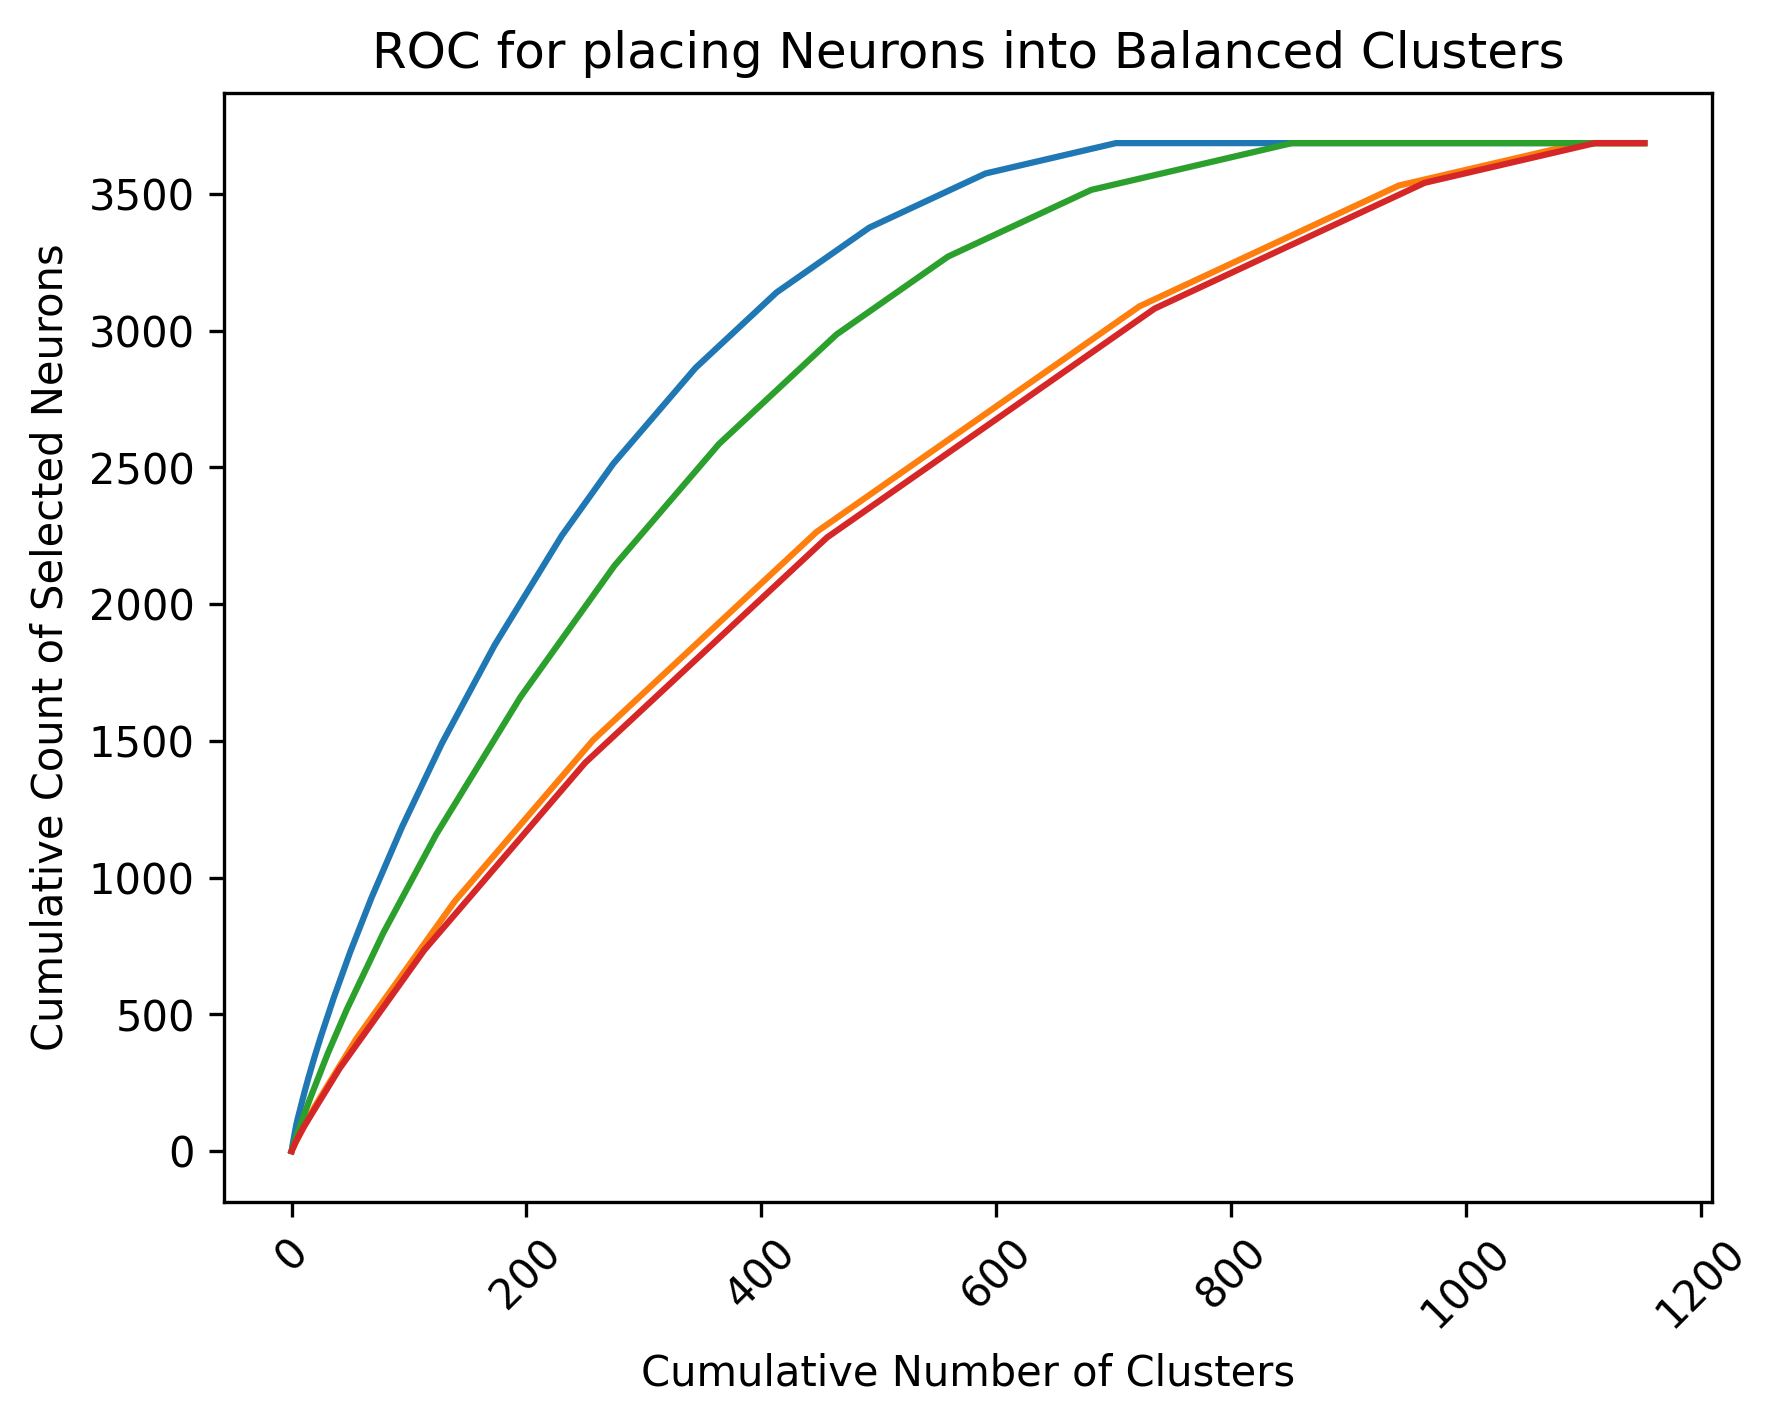

In [9]:
selected_rand = np.array( load_ff_criteria_auto("init", "cifar20-veh2", 0.1) )
selected_good = np.array( load_ff_criteria_auto("Cifar100", "cifar20-veh2", 0.1) )
plot_roc_curve(good_clusters_list, selected_good)
plot_roc_curve(rand_clusters_list, selected_rand)
plot_roc_curve(rand_clusters_list, selected_good)
plot_roc_curve(good_clusters_list, selected_rand)
plt.show()

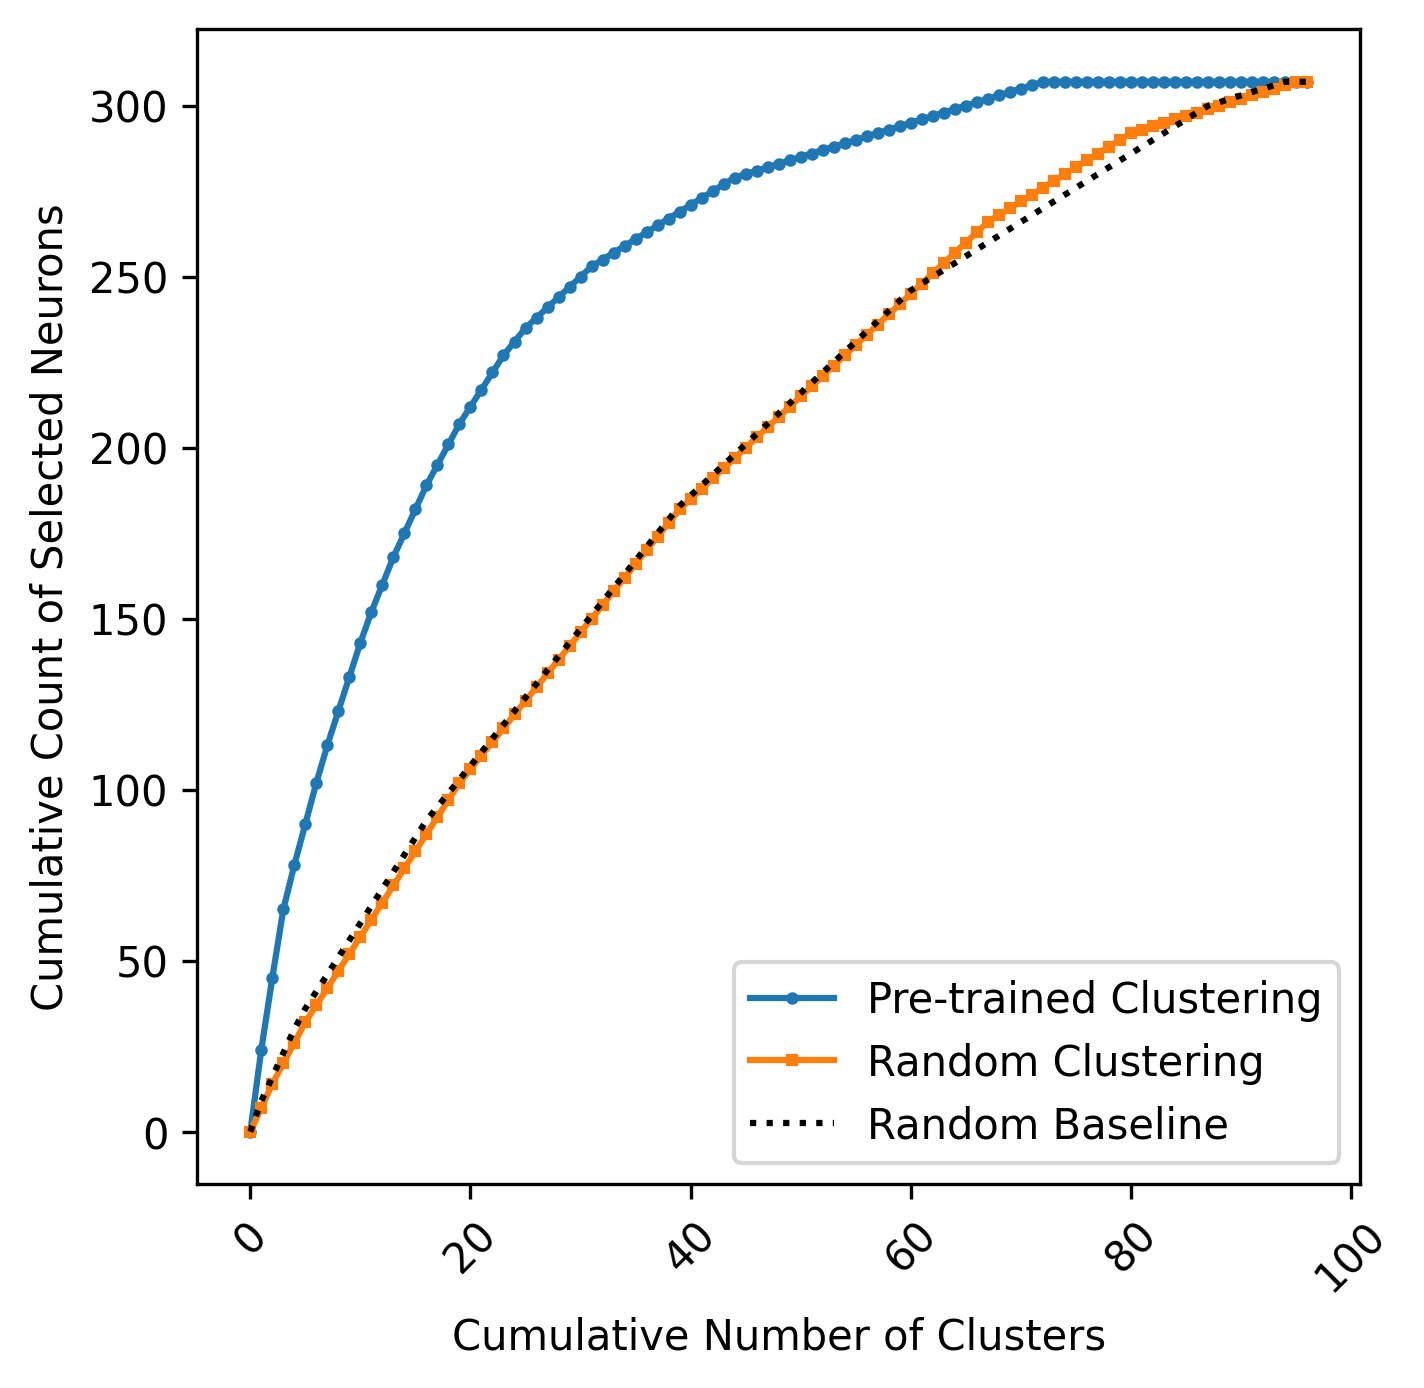

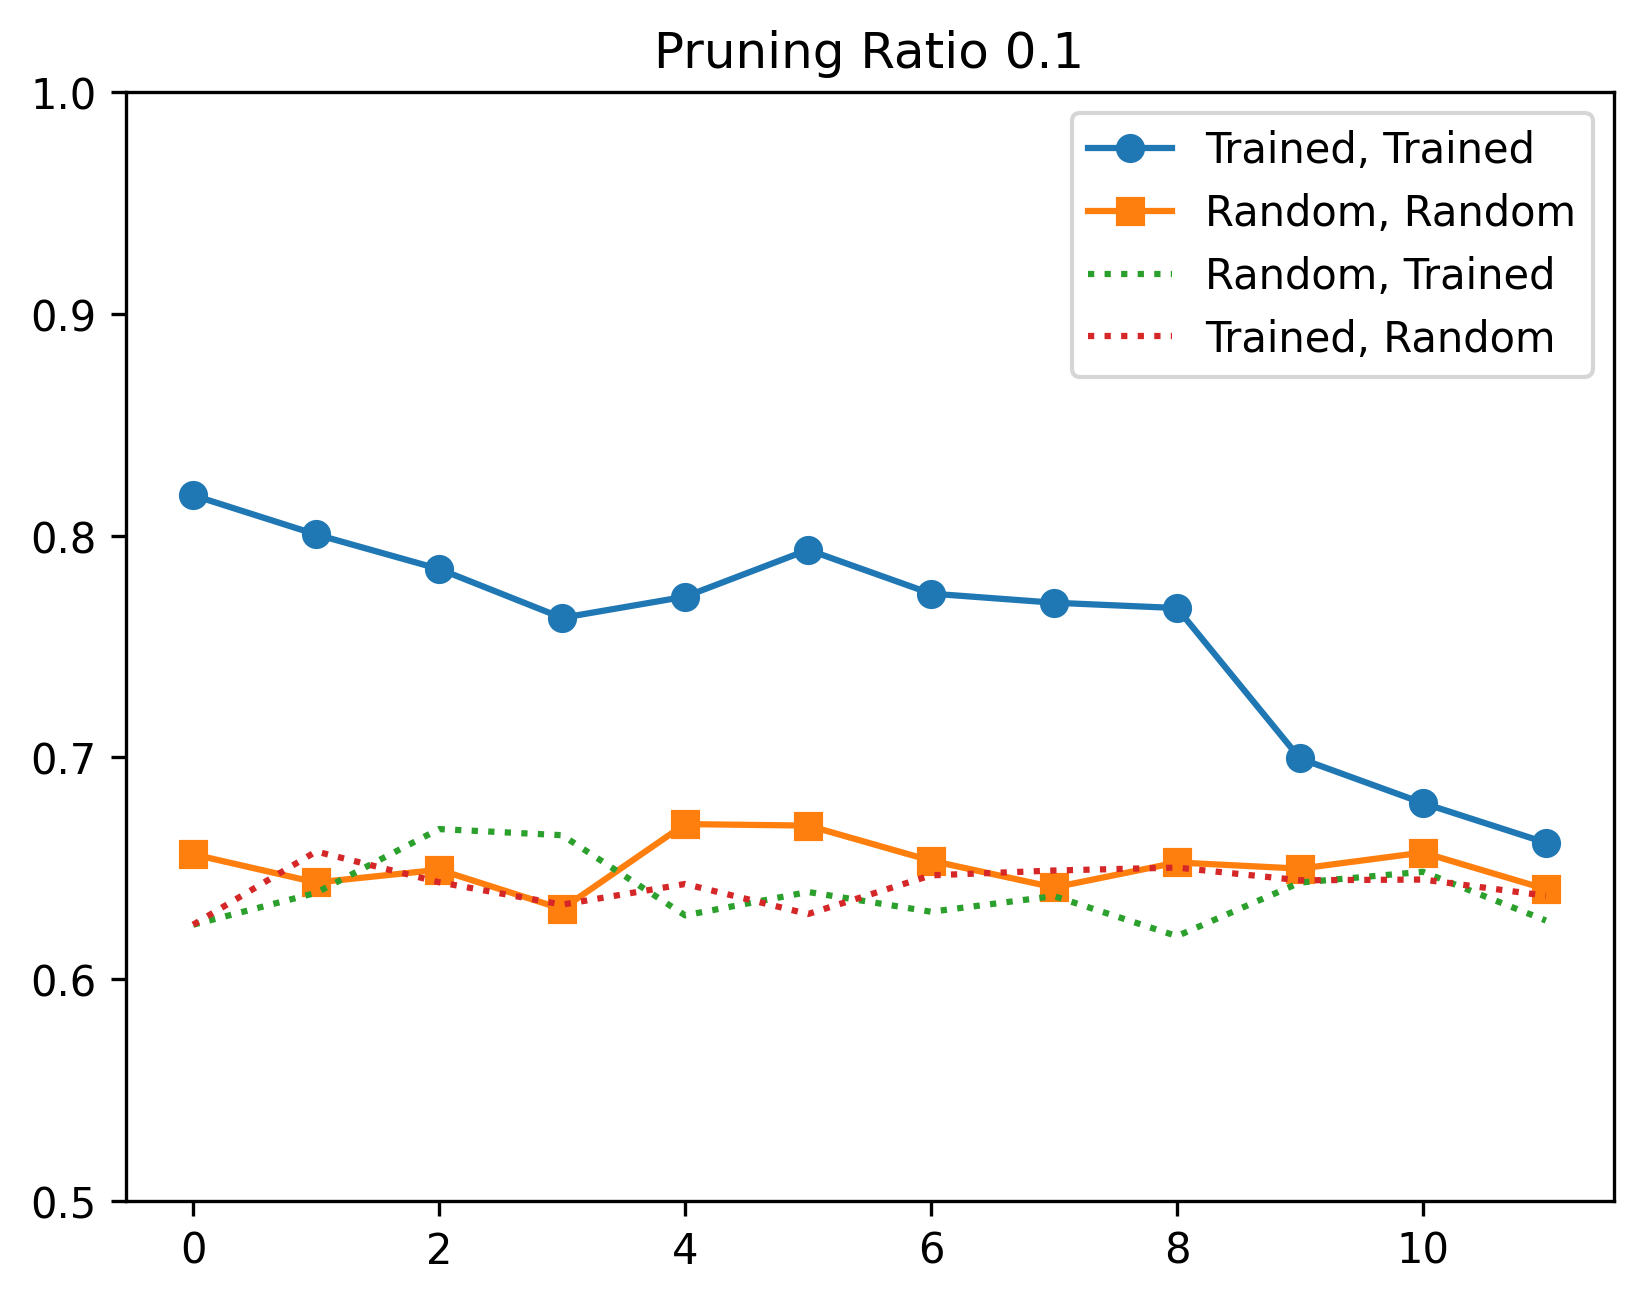

In [10]:
all_layers = list(range(m_good.cfg.n_layers))
#for pruning_ratio in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]:
for pruning_ratio in [0.10]:
    auc_tt, auc_rr, auc_rt, auc_tr = [], [], [], []
    for layer in all_layers:
        layers = [layer]
        good_ff_criteria = np.array( load_ff_criteria_auto("Cifar100", "cifar20-veh2", pruning_ratio, layers=layers) )
        rand_ff_criteria = np.array( load_ff_criteria_auto("init",     "cifar20-veh2", pruning_ratio, layers=layers) )

        auc_tt.append( area_under_curve(get_cumulative_counts(good_clusters_list[layers], good_ff_criteria)) )
        auc_rr.append( area_under_curve(get_cumulative_counts(rand_clusters_list[layers], rand_ff_criteria)) )
        auc_rt.append( area_under_curve(get_cumulative_counts(rand_clusters_list[layers], good_ff_criteria)) )
        auc_tr.append( area_under_curve(get_cumulative_counts(good_clusters_list[layers], rand_ff_criteria)) )

        if layer == 0:
            plt.figure(figsize=(5,5))
            plot_roc_curve(good_clusters_list[layers], good_ff_criteria, label="Pre-trained Clustering", marker="o", markersize=2)
            plot_roc_curve(good_clusters_list[layers], rand_ff_criteria, label="Random Clustering", marker="s", markersize=2)
            plot_roc_curve(rand_clusters_list[layers], good_ff_criteria, label="Random Baseline", linestyle=":", color="k")
            #plot_roc_curve(rand_clusters_list[layers], rand_ff_criteria, label="", linestyle=":", color="k")
            plt.title("")
            plt.legend()
            plt.show()


    plt.plot(all_layers, auc_tt, "-o", label="Trained, Trained")
    plt.plot(all_layers, auc_rr, "-s", label="Random, Random")
    plt.plot(all_layers, auc_rt, ":", label="Random, Trained")
    plt.plot(all_layers, auc_tr, ":", label="Trained, Random")
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.title(f"Pruning Ratio {pruning_ratio}")
    plt.show()

[0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667]
(5, 19, 12)
ROC Curves for Different Repos - Pruning Frac 0.01


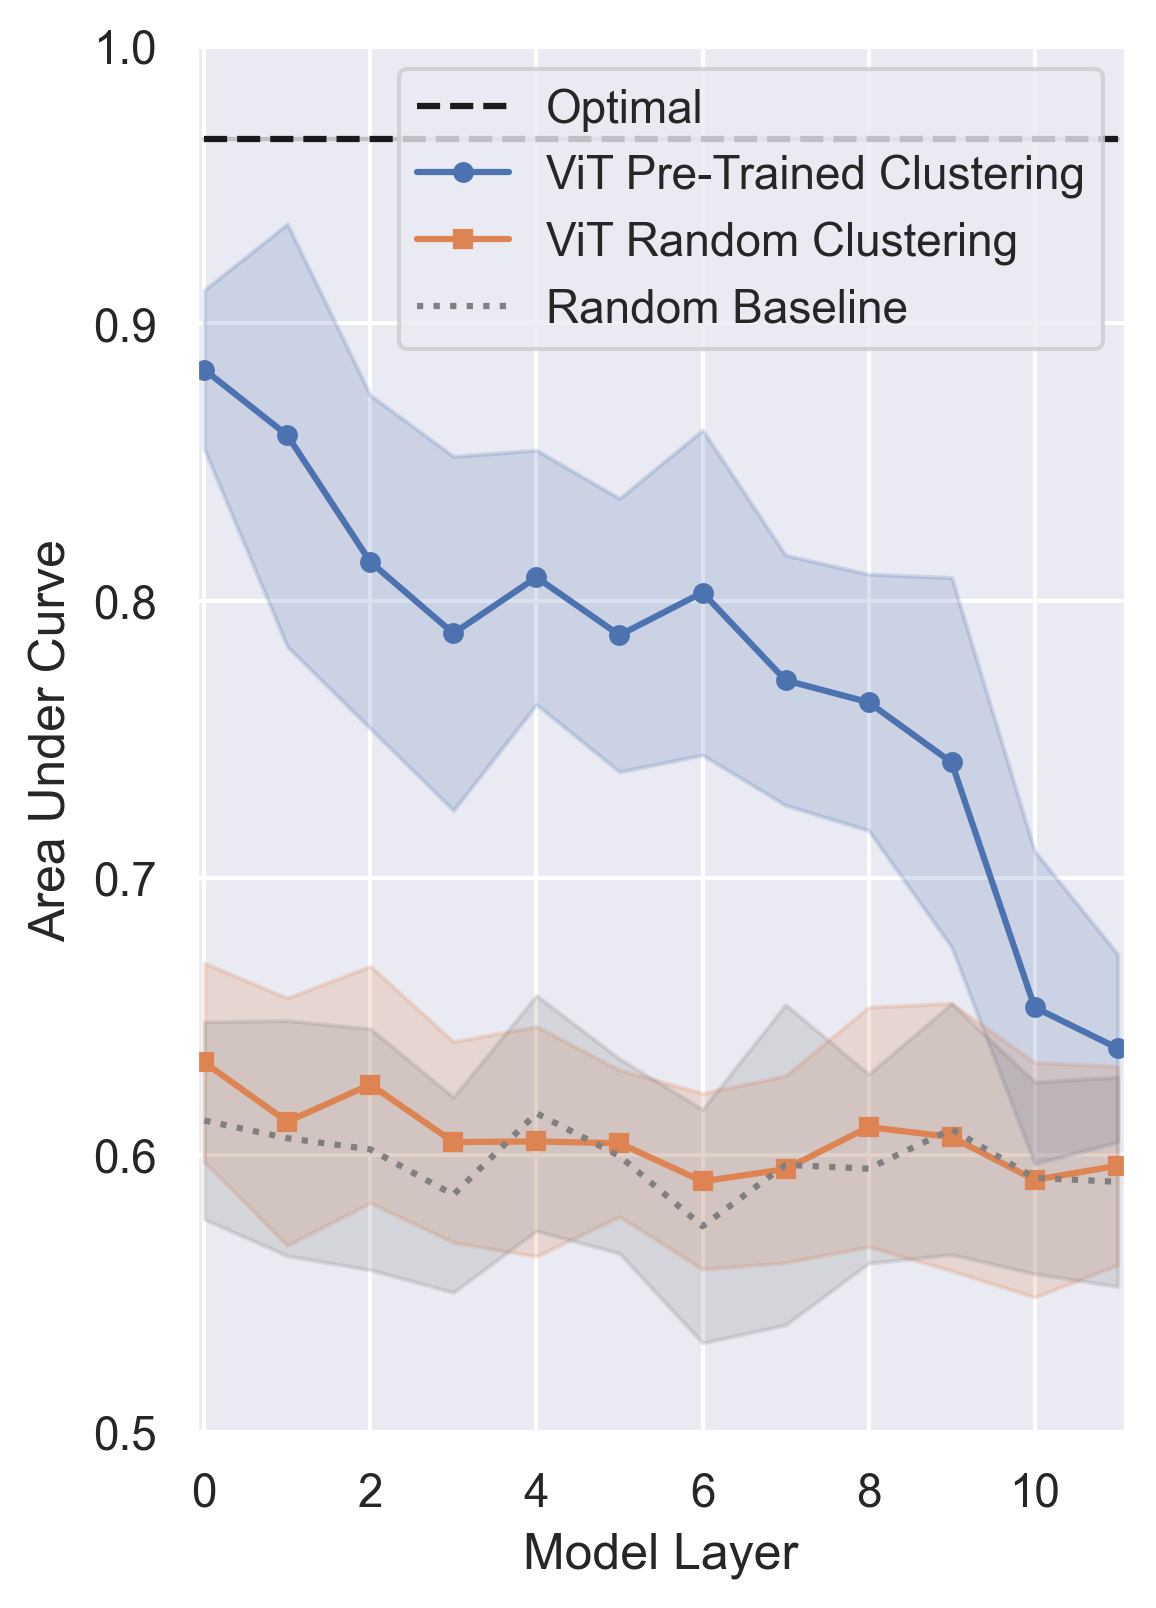

[0.9758129535071217, 0.9758129535071217, 0.9758129535071217, 0.9758129535071217, 0.9758129535071217, 0.9758129535071217, 0.9758129535071217, 0.9758129535071217, 0.9758129535071217, 0.9758129535071217, 0.9758129535071217, 0.9758129535071217]
(5, 19, 12)
ROC Curves for Different Repos - Pruning Frac 0.02


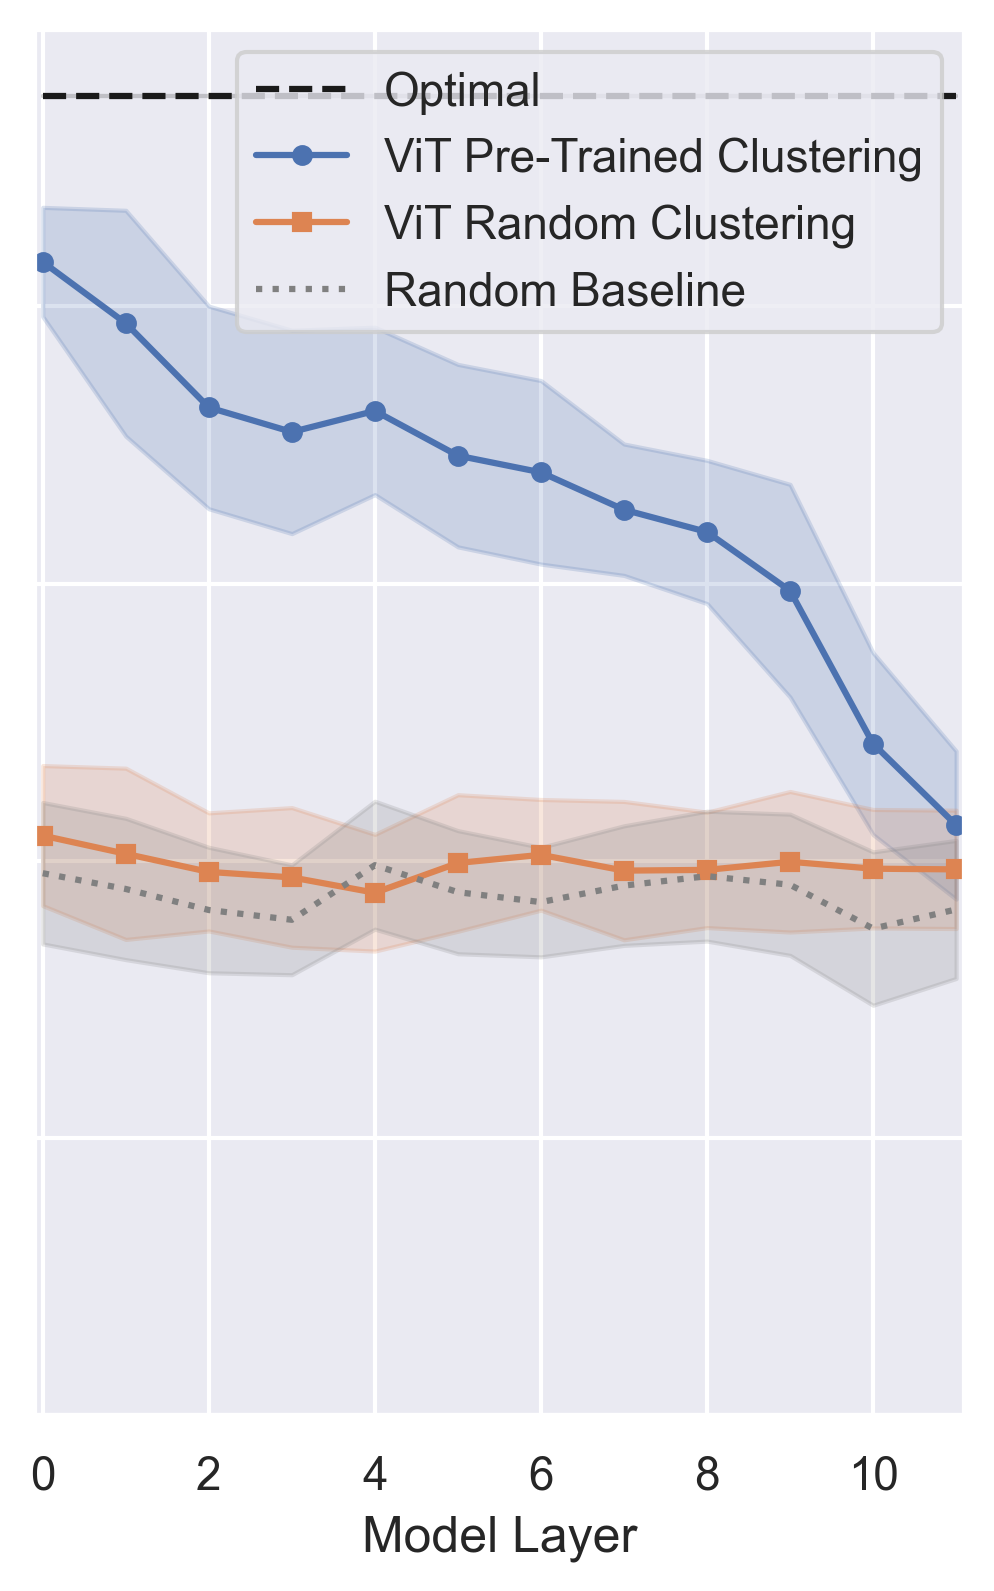

[0.9697031590413944, 0.9697031590413944, 0.9697031590413944, 0.9697031590413944, 0.9697031590413944, 0.9697031590413944, 0.9697031590413944, 0.9697031590413944, 0.9697031590413944, 0.9697031590413944, 0.9697031590413944, 0.9697031590413944]
(5, 19, 12)
ROC Curves for Different Repos - Pruning Frac 0.05


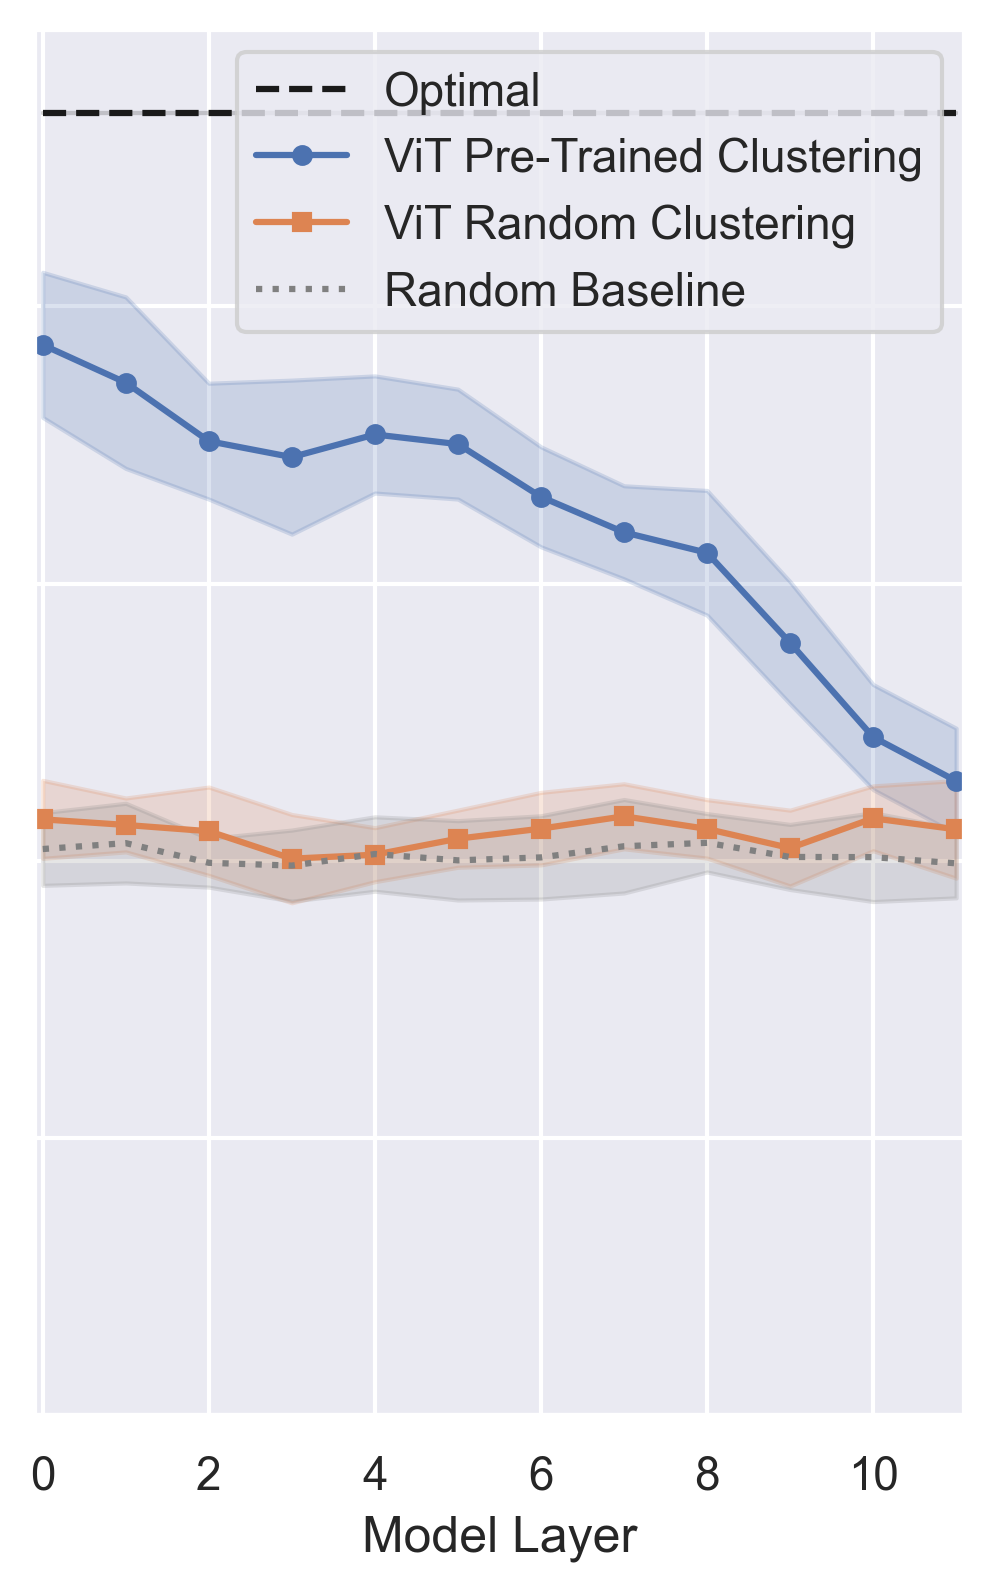

[0.9446932681867535, 0.9446932681867535, 0.9446932681867535, 0.9446932681867535, 0.9446932681867535, 0.9446932681867535, 0.9446932681867535, 0.9446932681867535, 0.9446932681867535, 0.9446932681867535, 0.9446932681867535, 0.9446932681867535]
(5, 19, 12)
ROC Curves for Different Repos - Pruning Frac 0.1


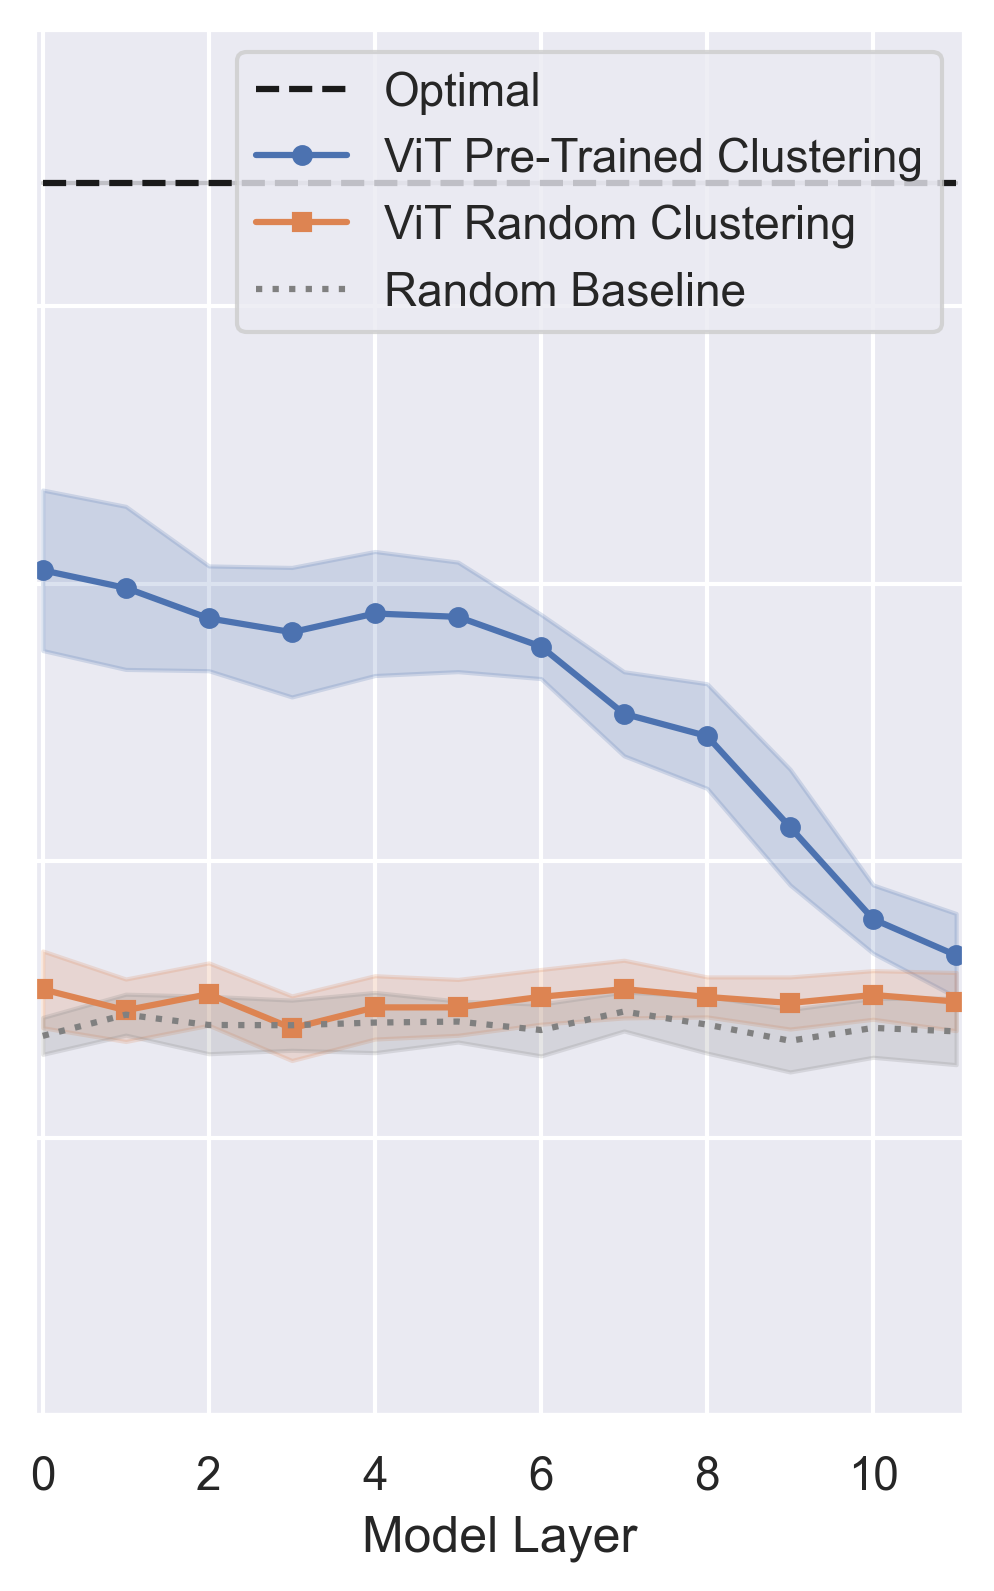

[0.8948154180238871, 0.8948154180238871, 0.8948154180238871, 0.8948154180238871, 0.8948154180238871, 0.8948154180238871, 0.8948154180238871, 0.8948154180238871, 0.8948154180238871, 0.8948154180238871, 0.8948154180238871, 0.8948154180238871]
(5, 19, 12)
ROC Curves for Different Repos - Pruning Frac 0.2


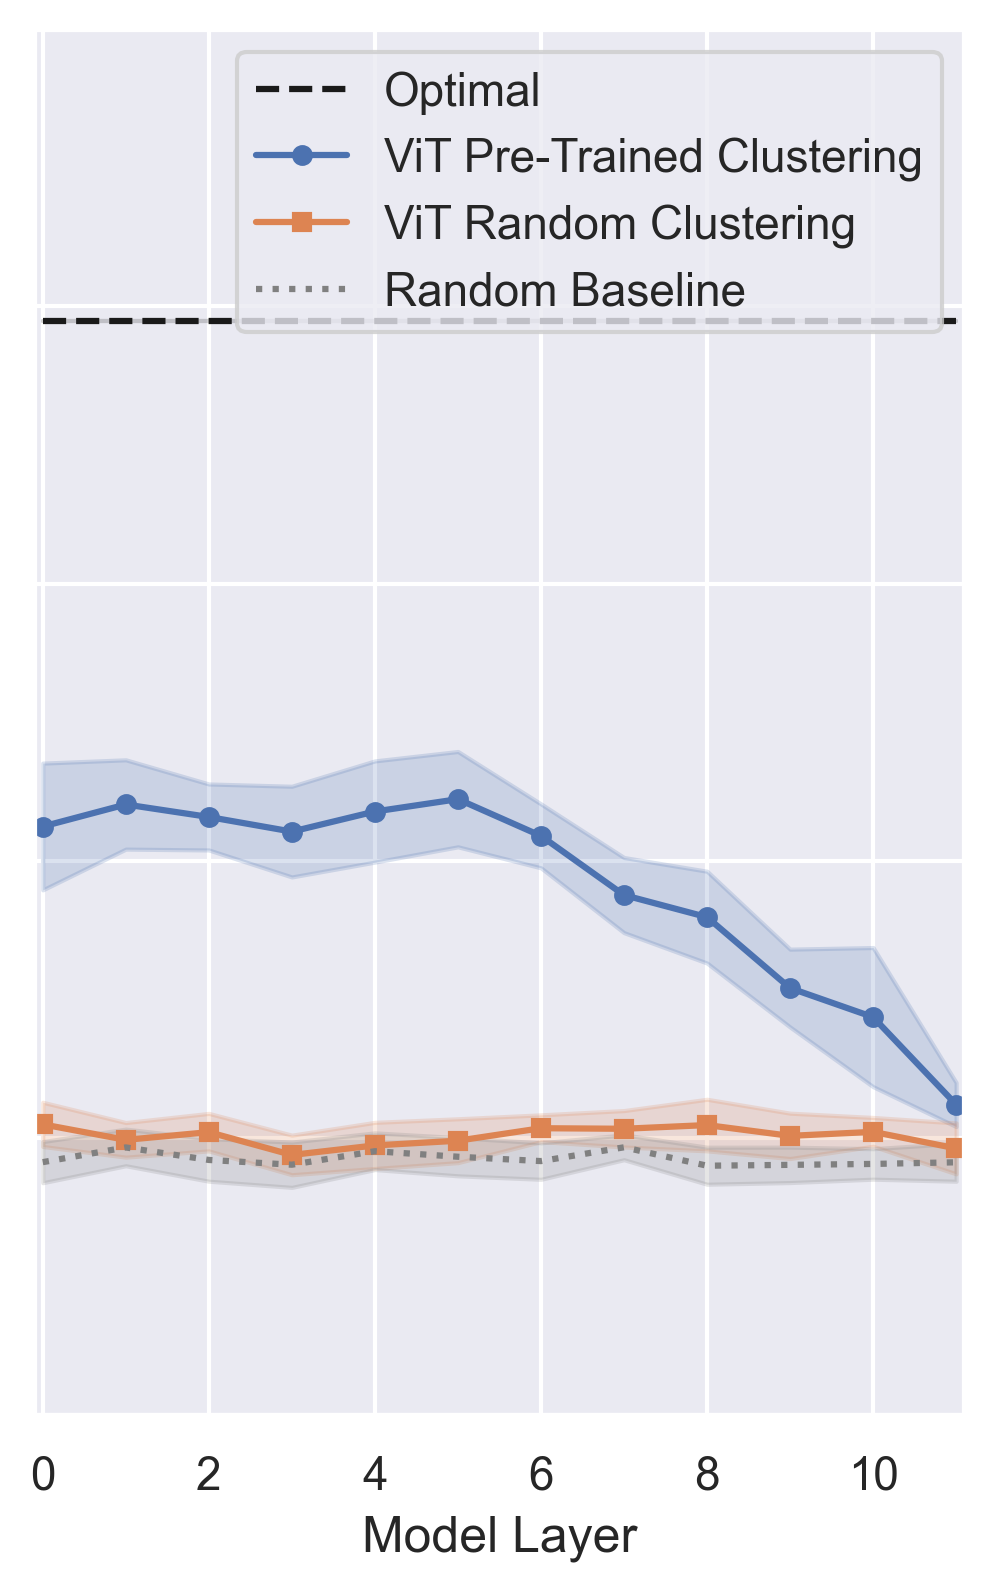

[0.594877730294397, 0.594877730294397, 0.594877730294397, 0.594877730294397, 0.594877730294397, 0.594877730294397, 0.594877730294397, 0.594877730294397, 0.594877730294397, 0.594877730294397, 0.594877730294397, 0.594877730294397]
(5, 19, 12)
ROC Curves for Different Repos - Pruning Frac 0.8


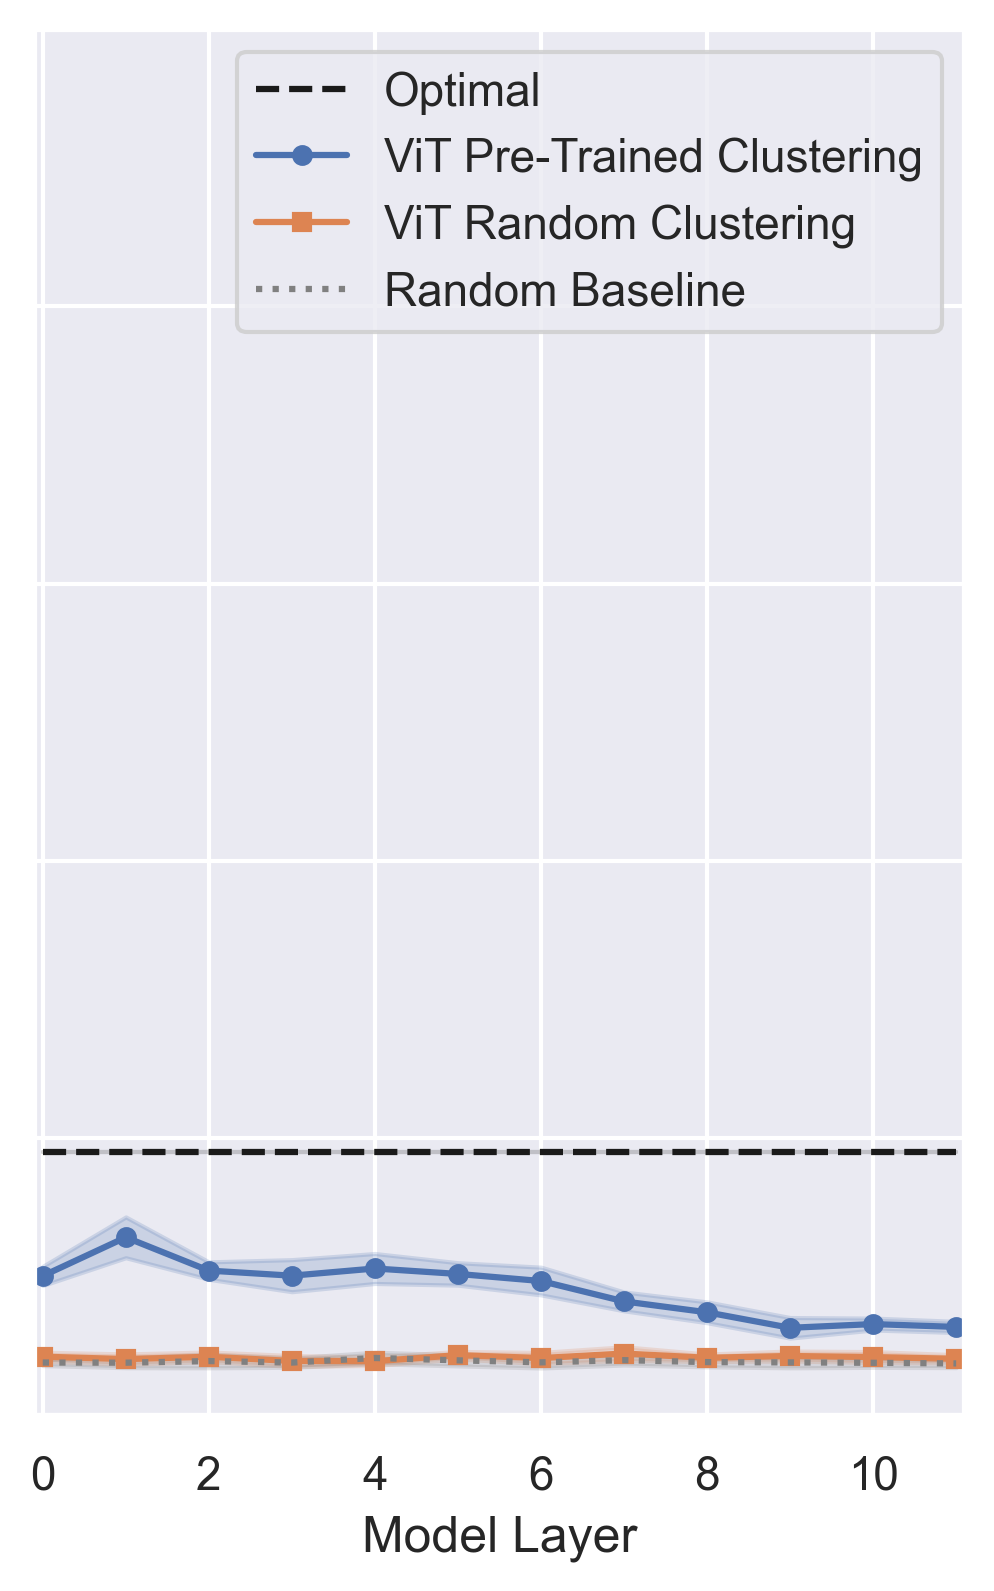

In [11]:
all_layers = list(range(m_good.cfg.n_layers))
for pruning_ratio in [0.01, 0.02, 0.05, 0.1, 0.20, 0.8]:
    repo_aucs = []
    for repo in datasets:
        auc_tt, auc_rr, auc_rt, auc_tr, auc_ideal = [], [], [], [], []
        repo_aucs.append([auc_ideal, auc_tt, auc_rr, auc_rt, auc_tr])
        for layer in all_layers:
            layers = [layer]
            good_ff_criteria = np.array( load_ff_criteria_auto("Cifar100", repo, pruning_ratio, layers=layers) )
            rand_ff_criteria = np.array( load_ff_criteria_auto("init",     repo, pruning_ratio, layers=layers) )

            auc_tt.append( area_under_curve(get_cumulative_counts(good_clusters_list[layers], good_ff_criteria)) )
            auc_rr.append( area_under_curve(get_cumulative_counts(rand_clusters_list[layers], rand_ff_criteria)) )
            auc_rt.append( area_under_curve(get_cumulative_counts(rand_clusters_list[layers], good_ff_criteria)) )
            auc_tr.append( area_under_curve(get_cumulative_counts(good_clusters_list[layers], rand_ff_criteria)) )
            auc_ideal.append( get_optimal_auc(pruning_ratio) )


        #plt.plot(all_layers, auc_tt, "-o", label="Trained Model, Trained Neurons")
        #plt.plot(all_layers, auc_rr, "-s", label="Random Model, Random Neurons")
        #plt.plot(all_layers, auc_rt, ":", label="Random Model, Trained Neurons")
        #plt.plot(all_layers, auc_tr, ":", label="Trained Model, Random Neurons")
        #plt.ylim(0.5, 1.0)
        #plt.legend()
        #plt.title(f"Pruning Ratio {pruning_ratio} in {repo}")
        #plt.show()

    print(auc_ideal)

    import seaborn as sns
    import einops
    sns.set_theme()
    repo_aucs_arr = np.array(repo_aucs)

    repo_aucs_arr = einops.rearrange(repo_aucs_arr, "repo metric layer -> metric repo layer")
    print(repo_aucs_arr.shape)

    repo_x = np.arange(0, 12)
    repo_means = np.mean(repo_aucs_arr, axis=1)
    repo_stds = np.std(repo_aucs_arr, axis=1)

    datas = [
        {"fmt": "--", "color": "k", "label": "Optimal"},
        {"fmt": "-o", "color": "C0", "label": "ViT Pre-Trained Clustering"},
        {"fmt": "-s", "color": "C1",  "label": "ViT Random Clustering"},
        {"fmt": ":",  "color": "gray",  "label": "Random Baseline"},
        {"fmt": ":",  "color": "gray",  "label": "Trained, Random"},
    ]

    plt.figure(figsize=(4,6))

    for i in range(4):
        fmt = datas[i]["fmt"]
        label = datas[i]["label"]
        color = datas[i]["color"]
        # Calculate the upper and lower bounds for the filled area
        lower_bound = repo_means[i] - repo_stds[i]
        upper_bound = repo_means[i] + repo_stds[i]
        # Plot the filled area
        plt.fill_between(repo_x, lower_bound, upper_bound, alpha=0.2, color=color)
        # Plot the mean line
        plt.plot(repo_x, repo_means[i], fmt, label=label, markersize=4, color=color)
        #fmt = datas[i]["fmt"]
        #label = datas[i]["label"]
        #plt.errorbar(repo_x, repo_means[i], repo_stds[i], fmt=fmt, label=label, capsize=4)

    print(f"ROC Curves for Different Repos - Pruning Frac {pruning_ratio}")
    plt.ylim(0.5, 1.0)
    plt.legend(loc="upper right")
    plt.xlabel("Model Layer")
    plt.ylabel("Area Under Curve")
    plt.xlim(-0.1, len(repo_x)-0.9)
    if pruning_ratio > 0.01:
        plt.gca().set_yticklabels([])
        plt.ylabel("")

    plt.show()